In [1]:
import os

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

import utils.plot_utls as plt_utils
import utils.visualizations as viz
import utils.metrics as metrics
import utils.training as training

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
SEED = 42
np.random.seed(SEED)
plt_utils.setup_plots()

In [3]:
df = pd.read_csv('../datasets/wine-quality/wine-quality-all.csv', delimiter=';', encoding='utf-8')
X = df.drop('quality', axis=1)
y = df['quality']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

X_train_color = X_train['color'].values.reshape(-1, 1)
X_test_color = X_test['color'].values.reshape(-1, 1)


In [4]:
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')

X_train_encoded_color = encoder.fit_transform(X_train_color)
X_test_encoded_color = encoder.transform(X_test_color)

# Step 4: Concatenate the encoded 'color' column with the original data
X_train_reset = X_train.drop(columns=['color']).reset_index(drop=True)
X_train_encoded_color_reset = pd.DataFrame(X_train_encoded_color,
                                           columns=encoder.get_feature_names_out(['color'])).reset_index(drop=True)
X_train_e = pd.concat([X_train_reset, X_train_encoded_color_reset], axis=1)

X_test_reset = X_test.drop(columns=['color']).reset_index(drop=True)
X_test_encoded_color_reset = pd.DataFrame(X_test_encoded_color,
                                          columns=encoder.get_feature_names_out(['color'])).reset_index(drop=True)
X_test_e = pd.concat([X_test_reset, X_test_encoded_color_reset], axis=1)

X_all_e = pd.concat((X_train_e, X_test_e), axis=0)

#
scaler = MinMaxScaler()

X_train_n = scaler.fit_transform(X_train_e)
X_test_n = scaler.transform(X_test_e)

X_all_n = np.concatenate((X_train_n, X_test_n), axis=0)

CV = 4
F1_AVERAGING = 'micro'
F1_SCORE = f'f1_{F1_AVERAGING}'

/Users/pavponn/opt/anaconda3/envs/assignment-1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [5]:
X_train = X_train_e
X_test = X_test_e
X_all = X_all_e

In [6]:
WINE_PATH = f'{os.getcwd()}/../figures/wine-quality'


# Decision Tree

### Plan

1. Train baseline decision tree without hyperparameter tuning, look at the precision/recall at train and test sets
2. Validate how different individual hyperparameters affect performance of the model wrt recall@precision
    a. `min_samples_leaf`
    b. `max_depth`
    c. `ccp_alpha`
3. Perform hyperparameter tuning of multiple parameters
4. Analyse performance of the best decision tree with hyperparameter tuning

In [7]:
WINE_DT_PATH = f'{WINE_PATH}/dt'


In [8]:
dt_baseline_clf = DecisionTreeClassifier(random_state=SEED)
dt_baseline_clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

/Users/pavponn/opt/anaconda3/envs/assignment-1/lib/python3.10/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


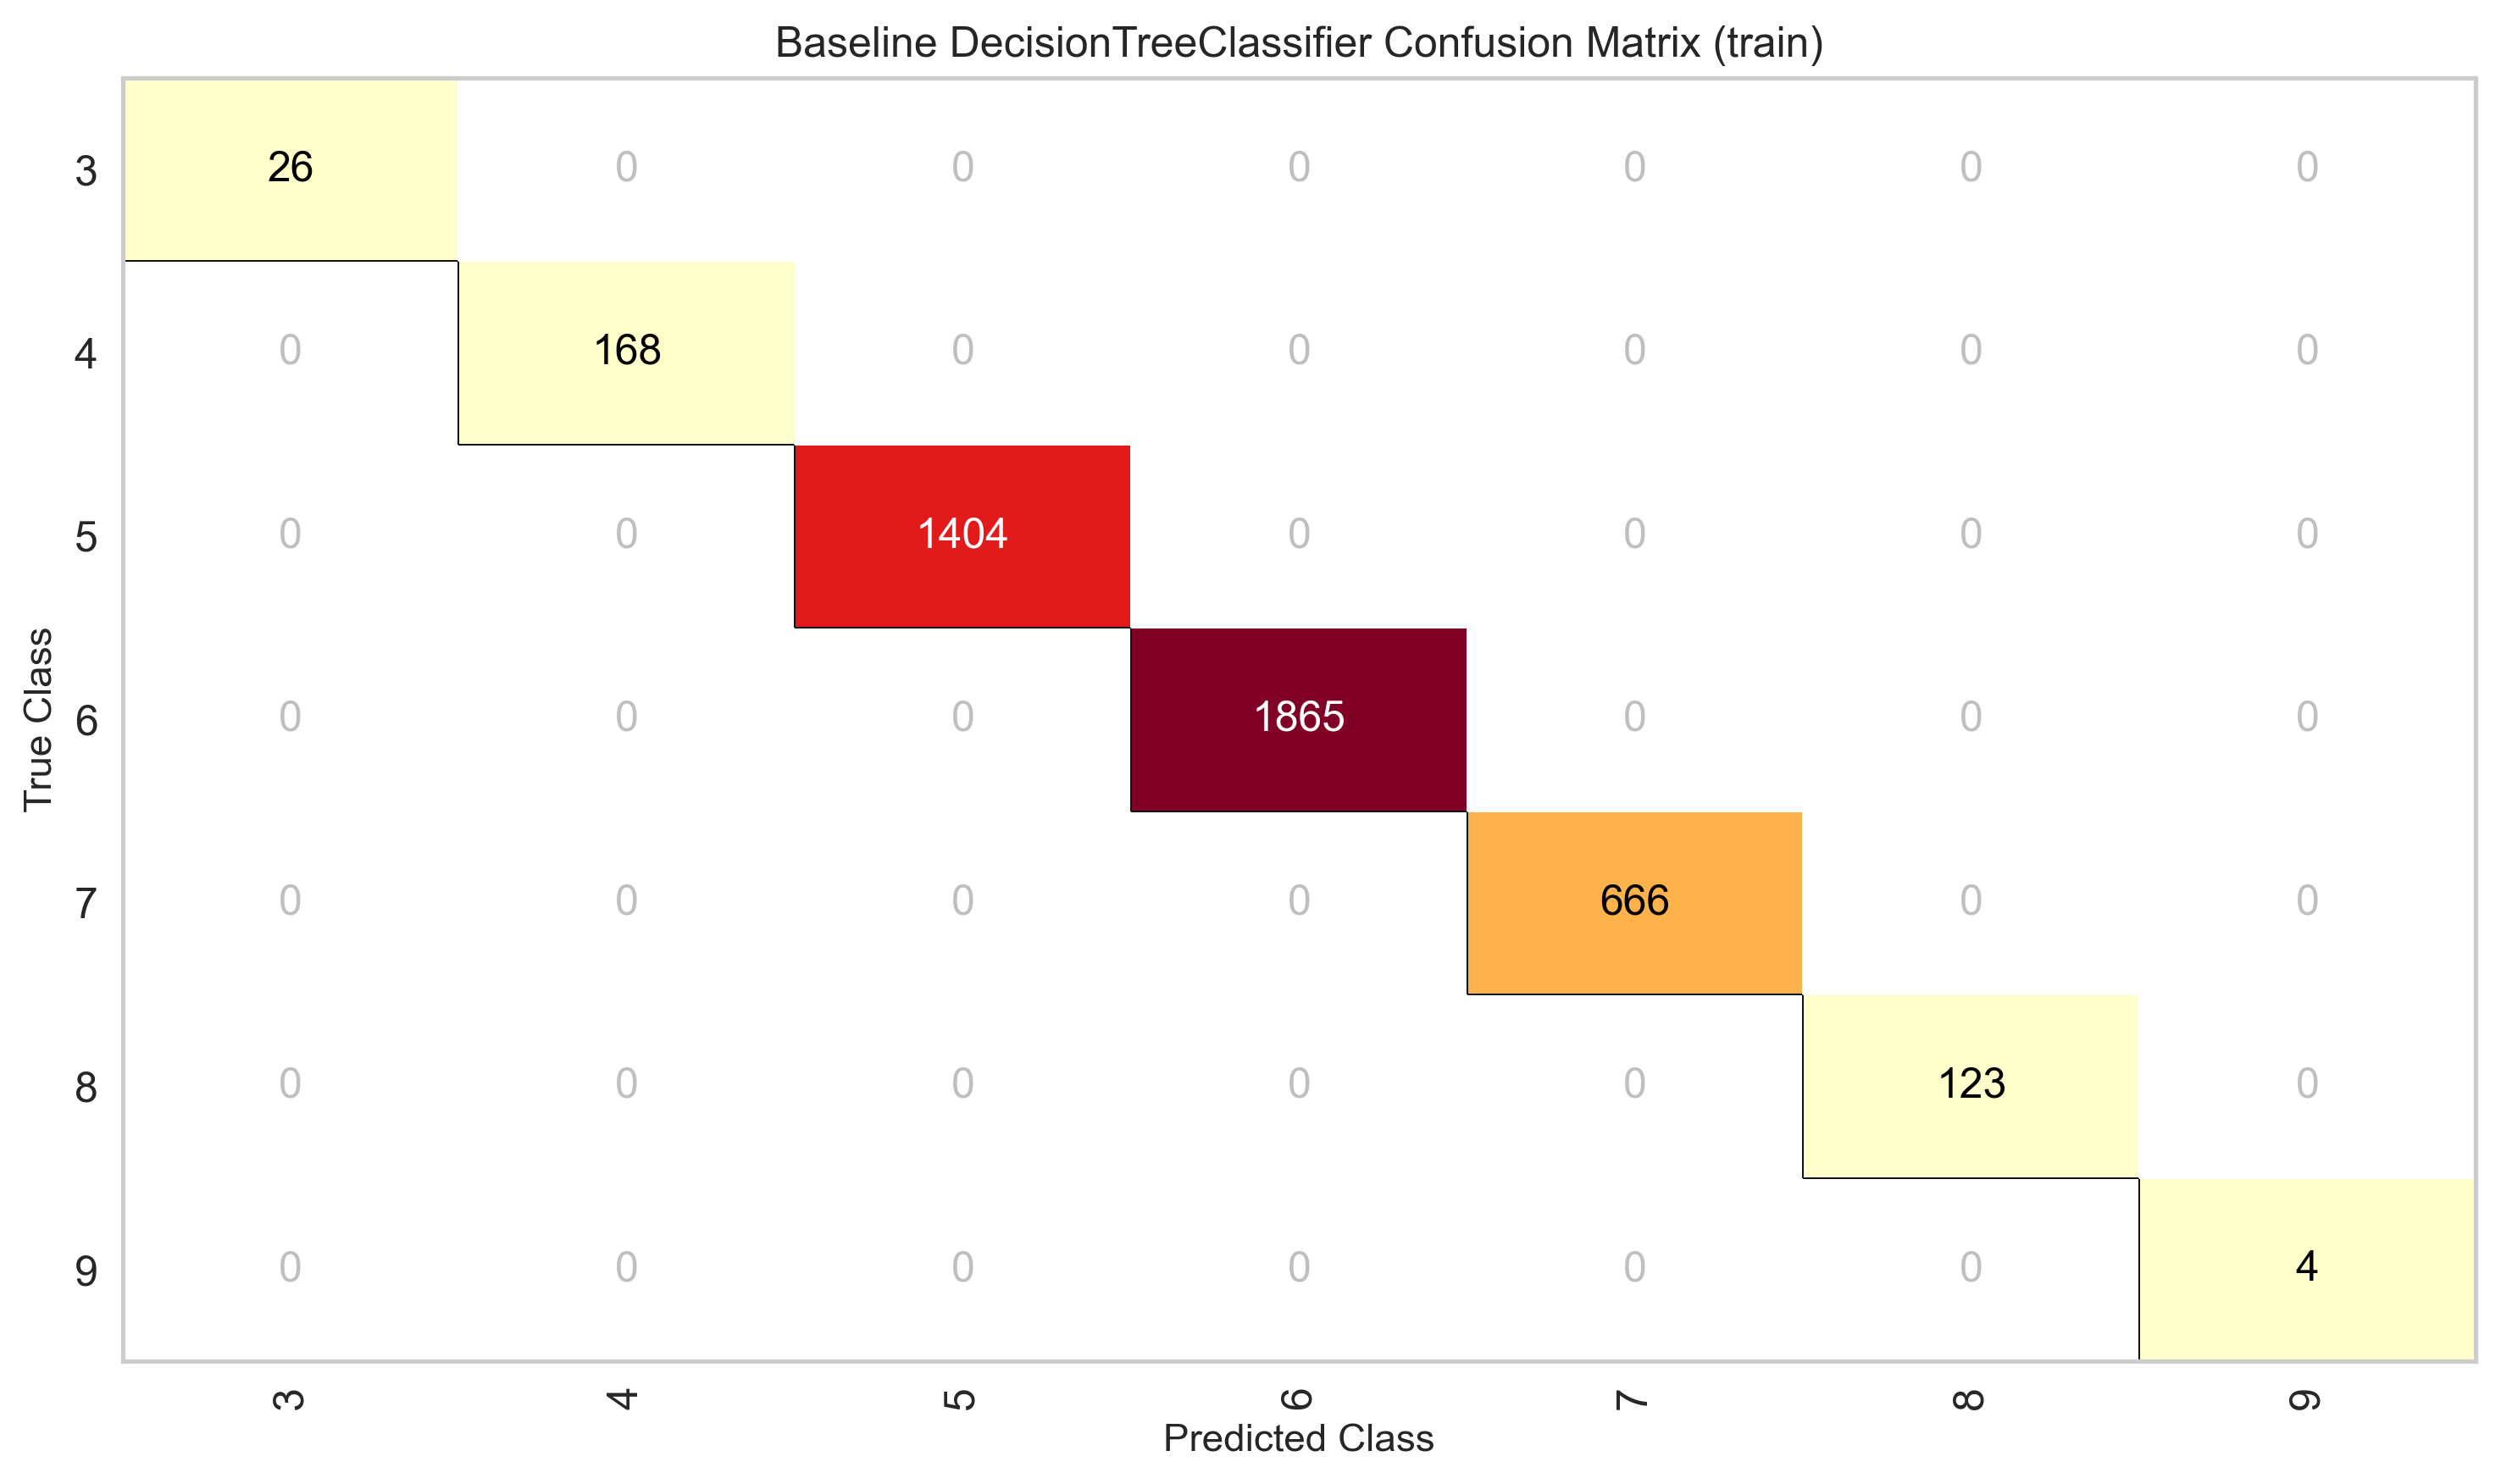

In [9]:
viz.confusion_matrix(
    clf=dt_baseline_clf,
    X=X_train,
    y=y_train,
    title='Baseline DecisionTreeClassifier Confusion Matrix (train)',
    output_path=f'{WINE_DT_PATH}/baseline_dt_train_confusion_matrix.png')

/Users/pavponn/opt/anaconda3/envs/assignment-1/lib/python3.10/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


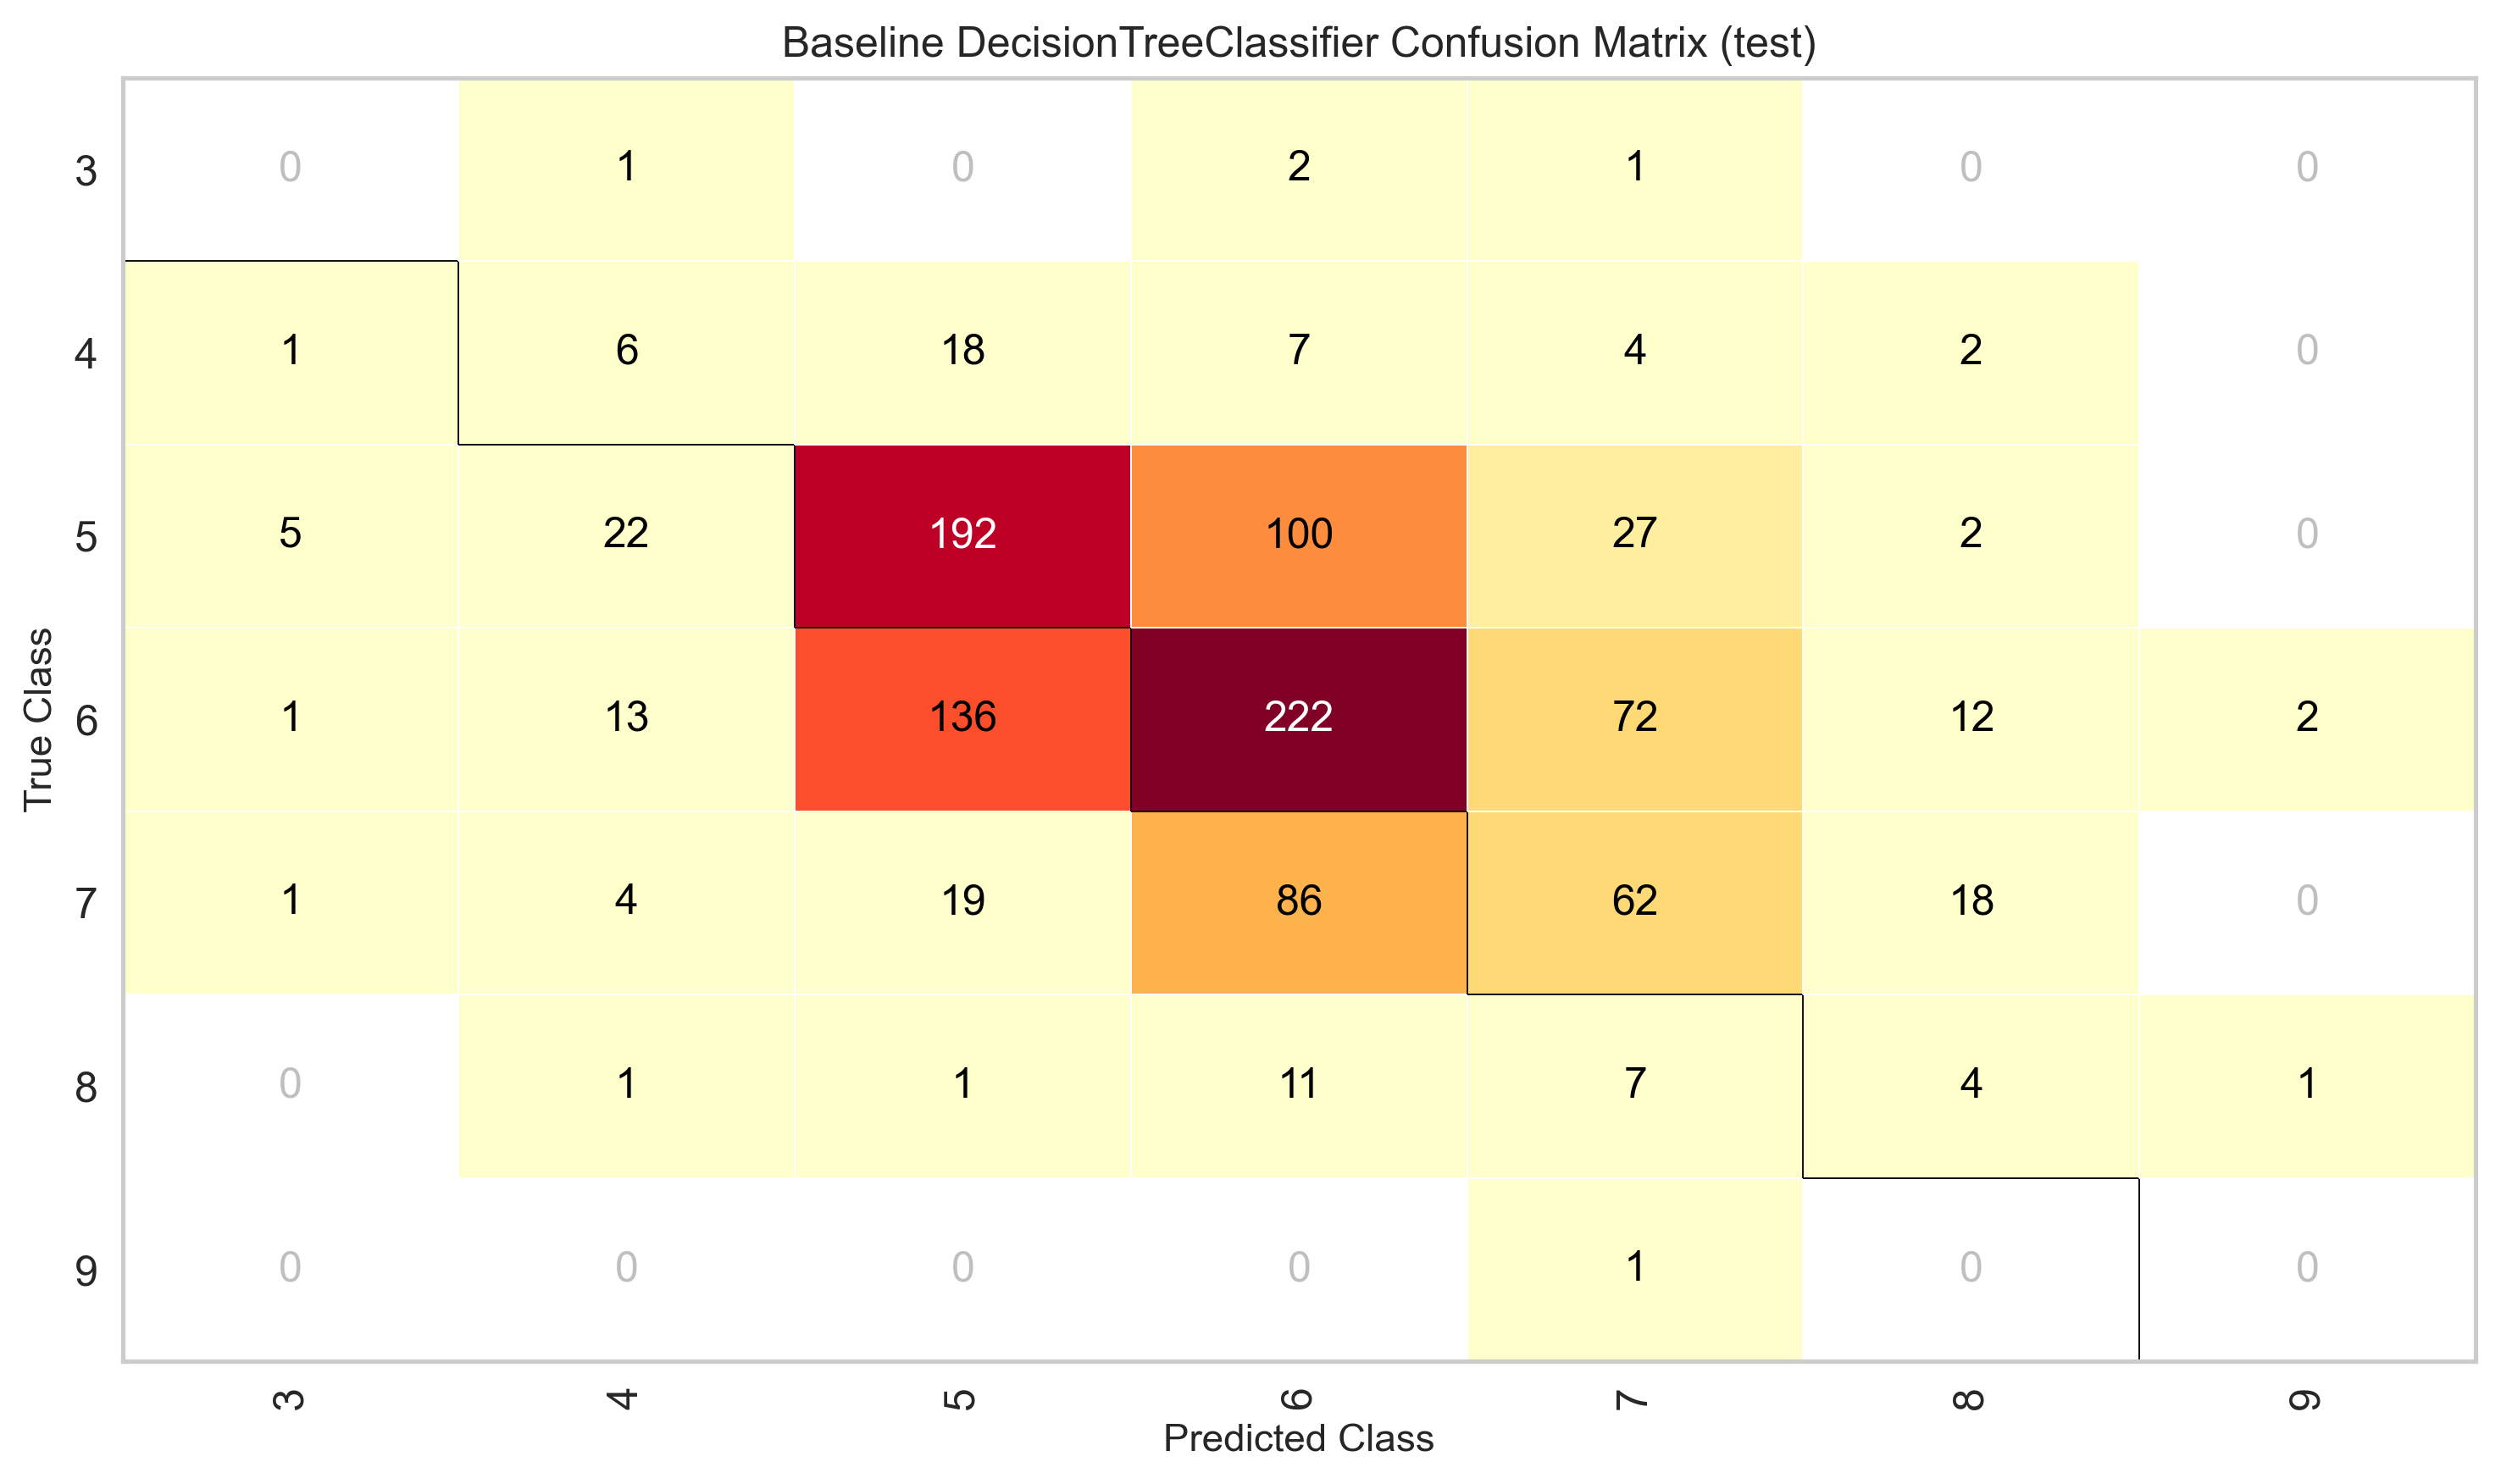

In [10]:
viz.confusion_matrix(
    clf=dt_baseline_clf,
    X=X_test,
    y=y_test,
    title='Baseline DecisionTreeClassifier Confusion Matrix (test)',
    output_path=f'{WINE_DT_PATH}/baseline_dt_test_confusion_matrix.png')

In [11]:
metrics.f1_score_stats(clf=dt_baseline_clf, X_tr=X_train, X_t=X_test, y_tr=y_train, y_t=y_test, averaging=F1_AVERAGING)

F1-Score, micro (train): 1.0000
F1-Score, micro (test) : 0.4568


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


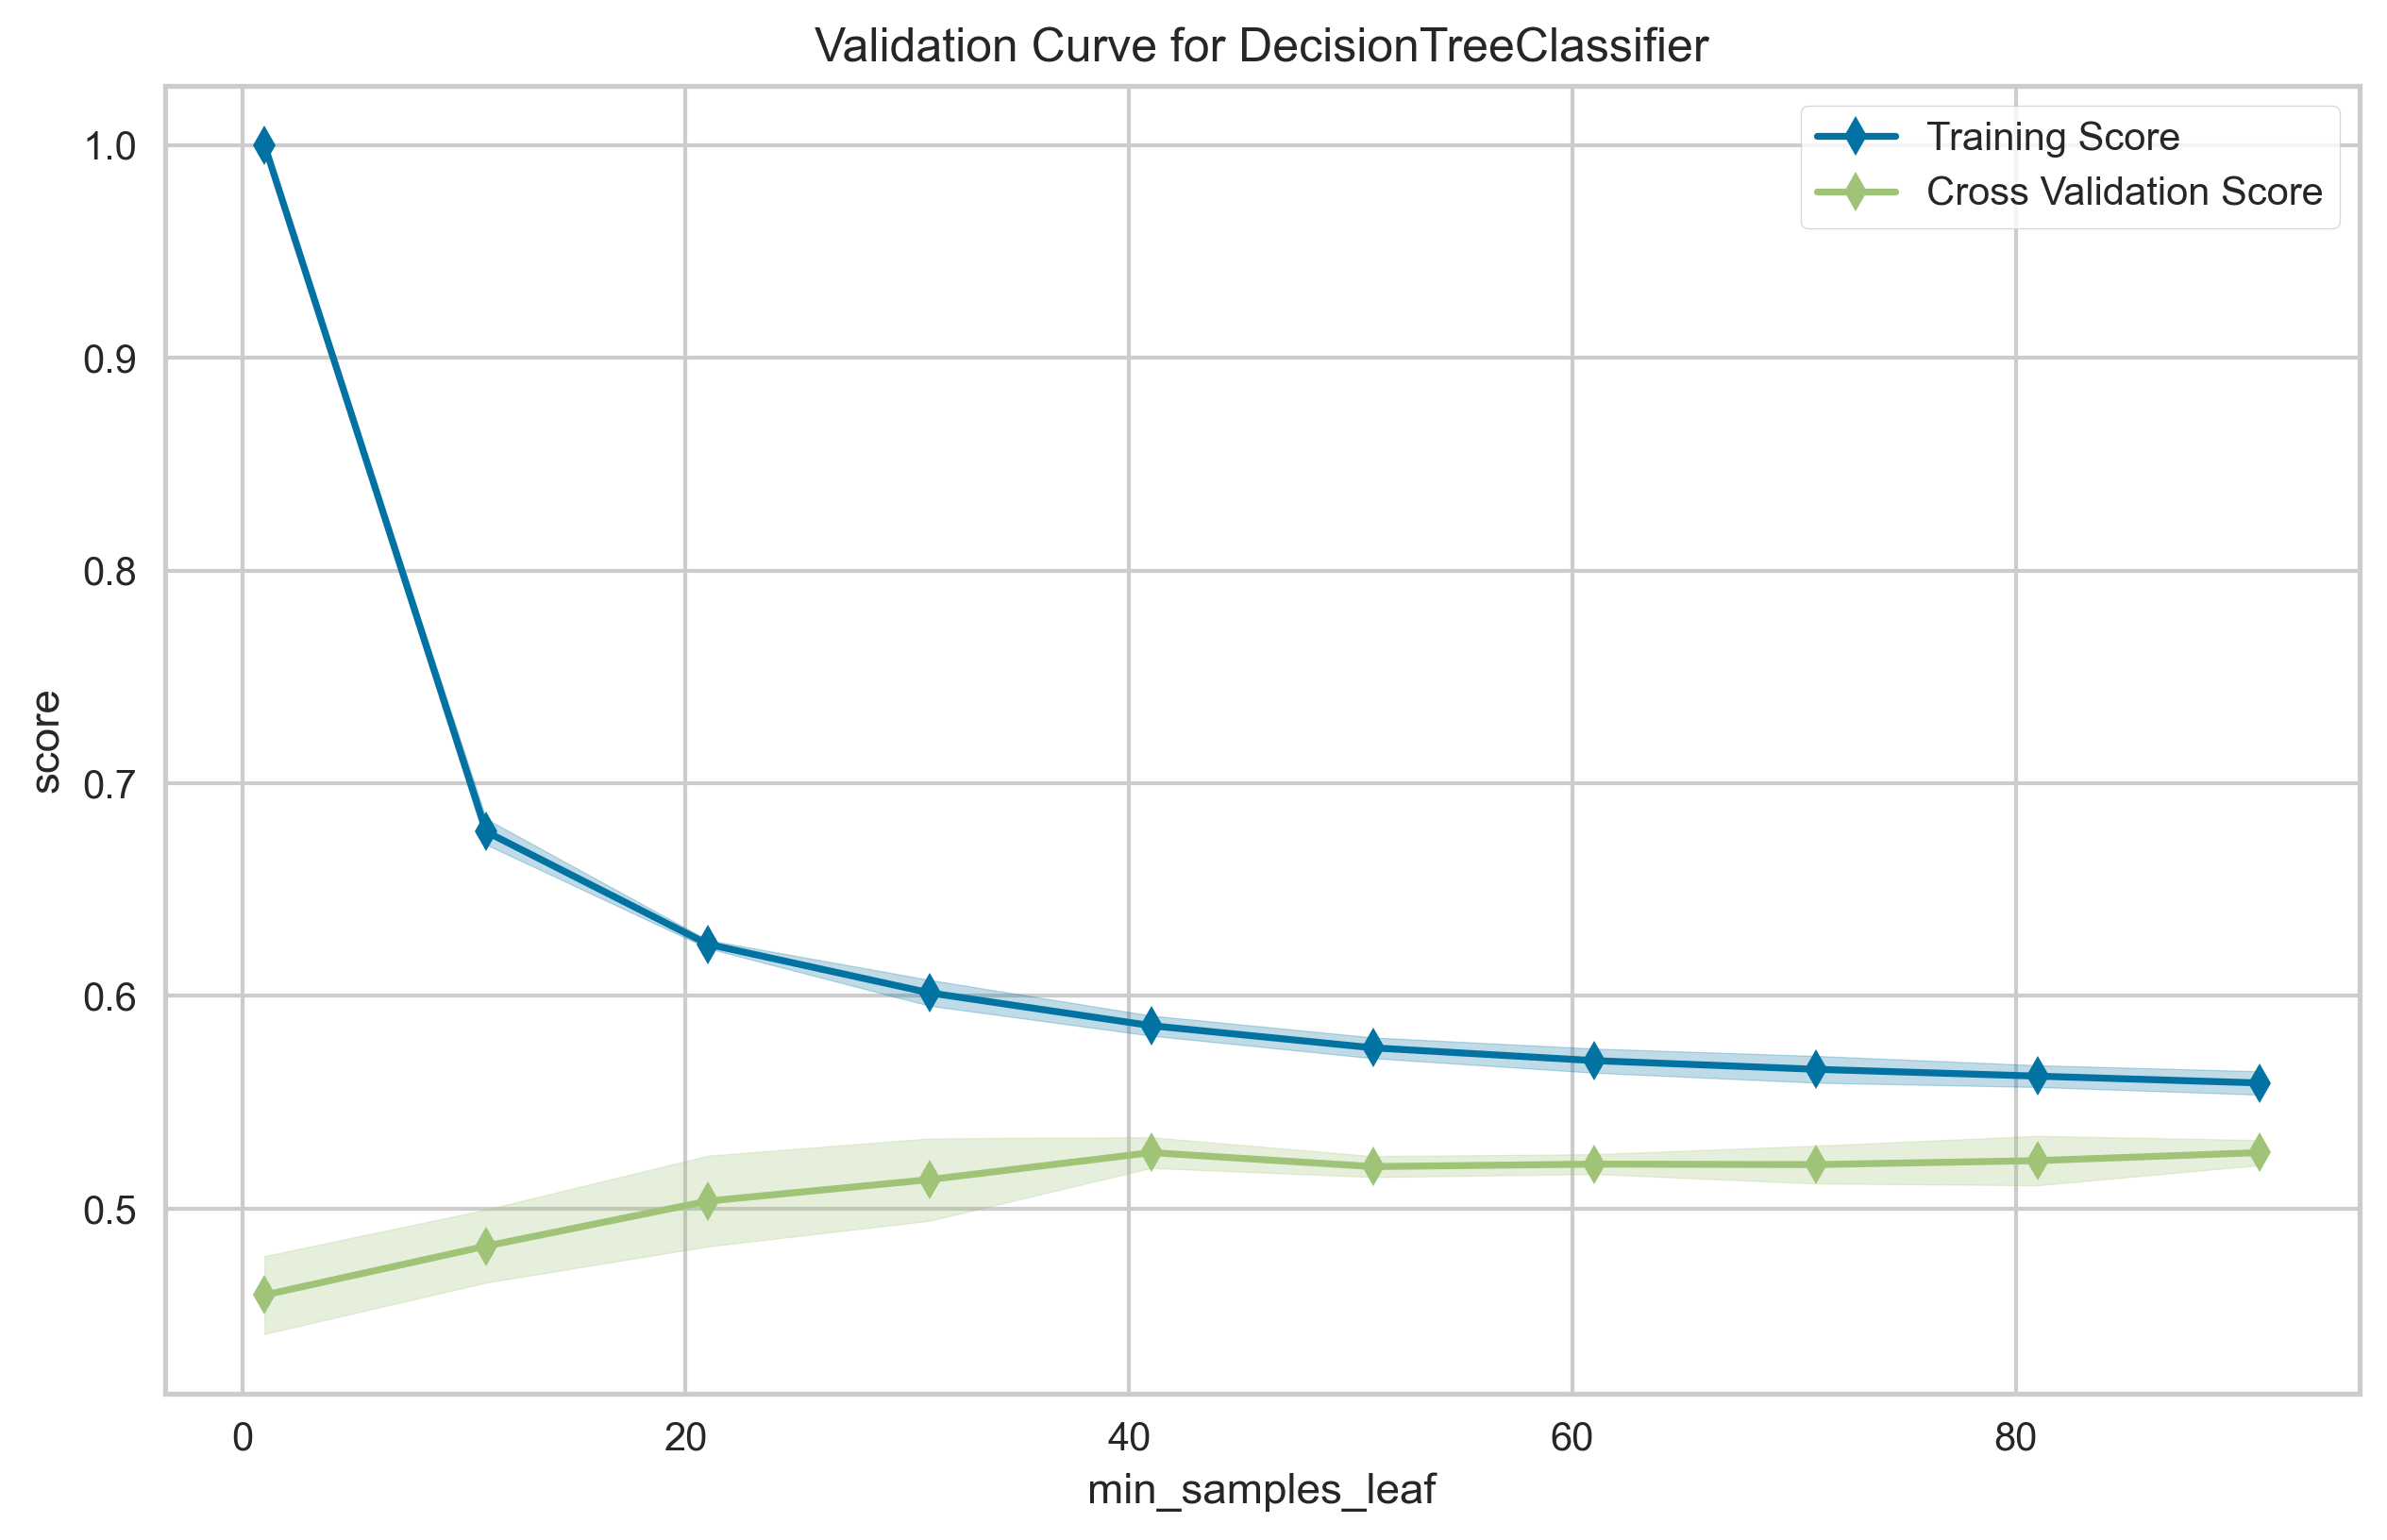

In [12]:
dt_clf = DecisionTreeClassifier(random_state=SEED)
viz.validation_curve(
    clf=dt_clf,
    X_tr=X_train,
    y_tr=y_train,
    cv=CV,
    param_name="min_samples_leaf",
    param_range=np.arange(1, 100, 10),
    output_path=f"{WINE_DT_PATH}/dt_min_samples_leaf.png",
    scoring=F1_SCORE,
)

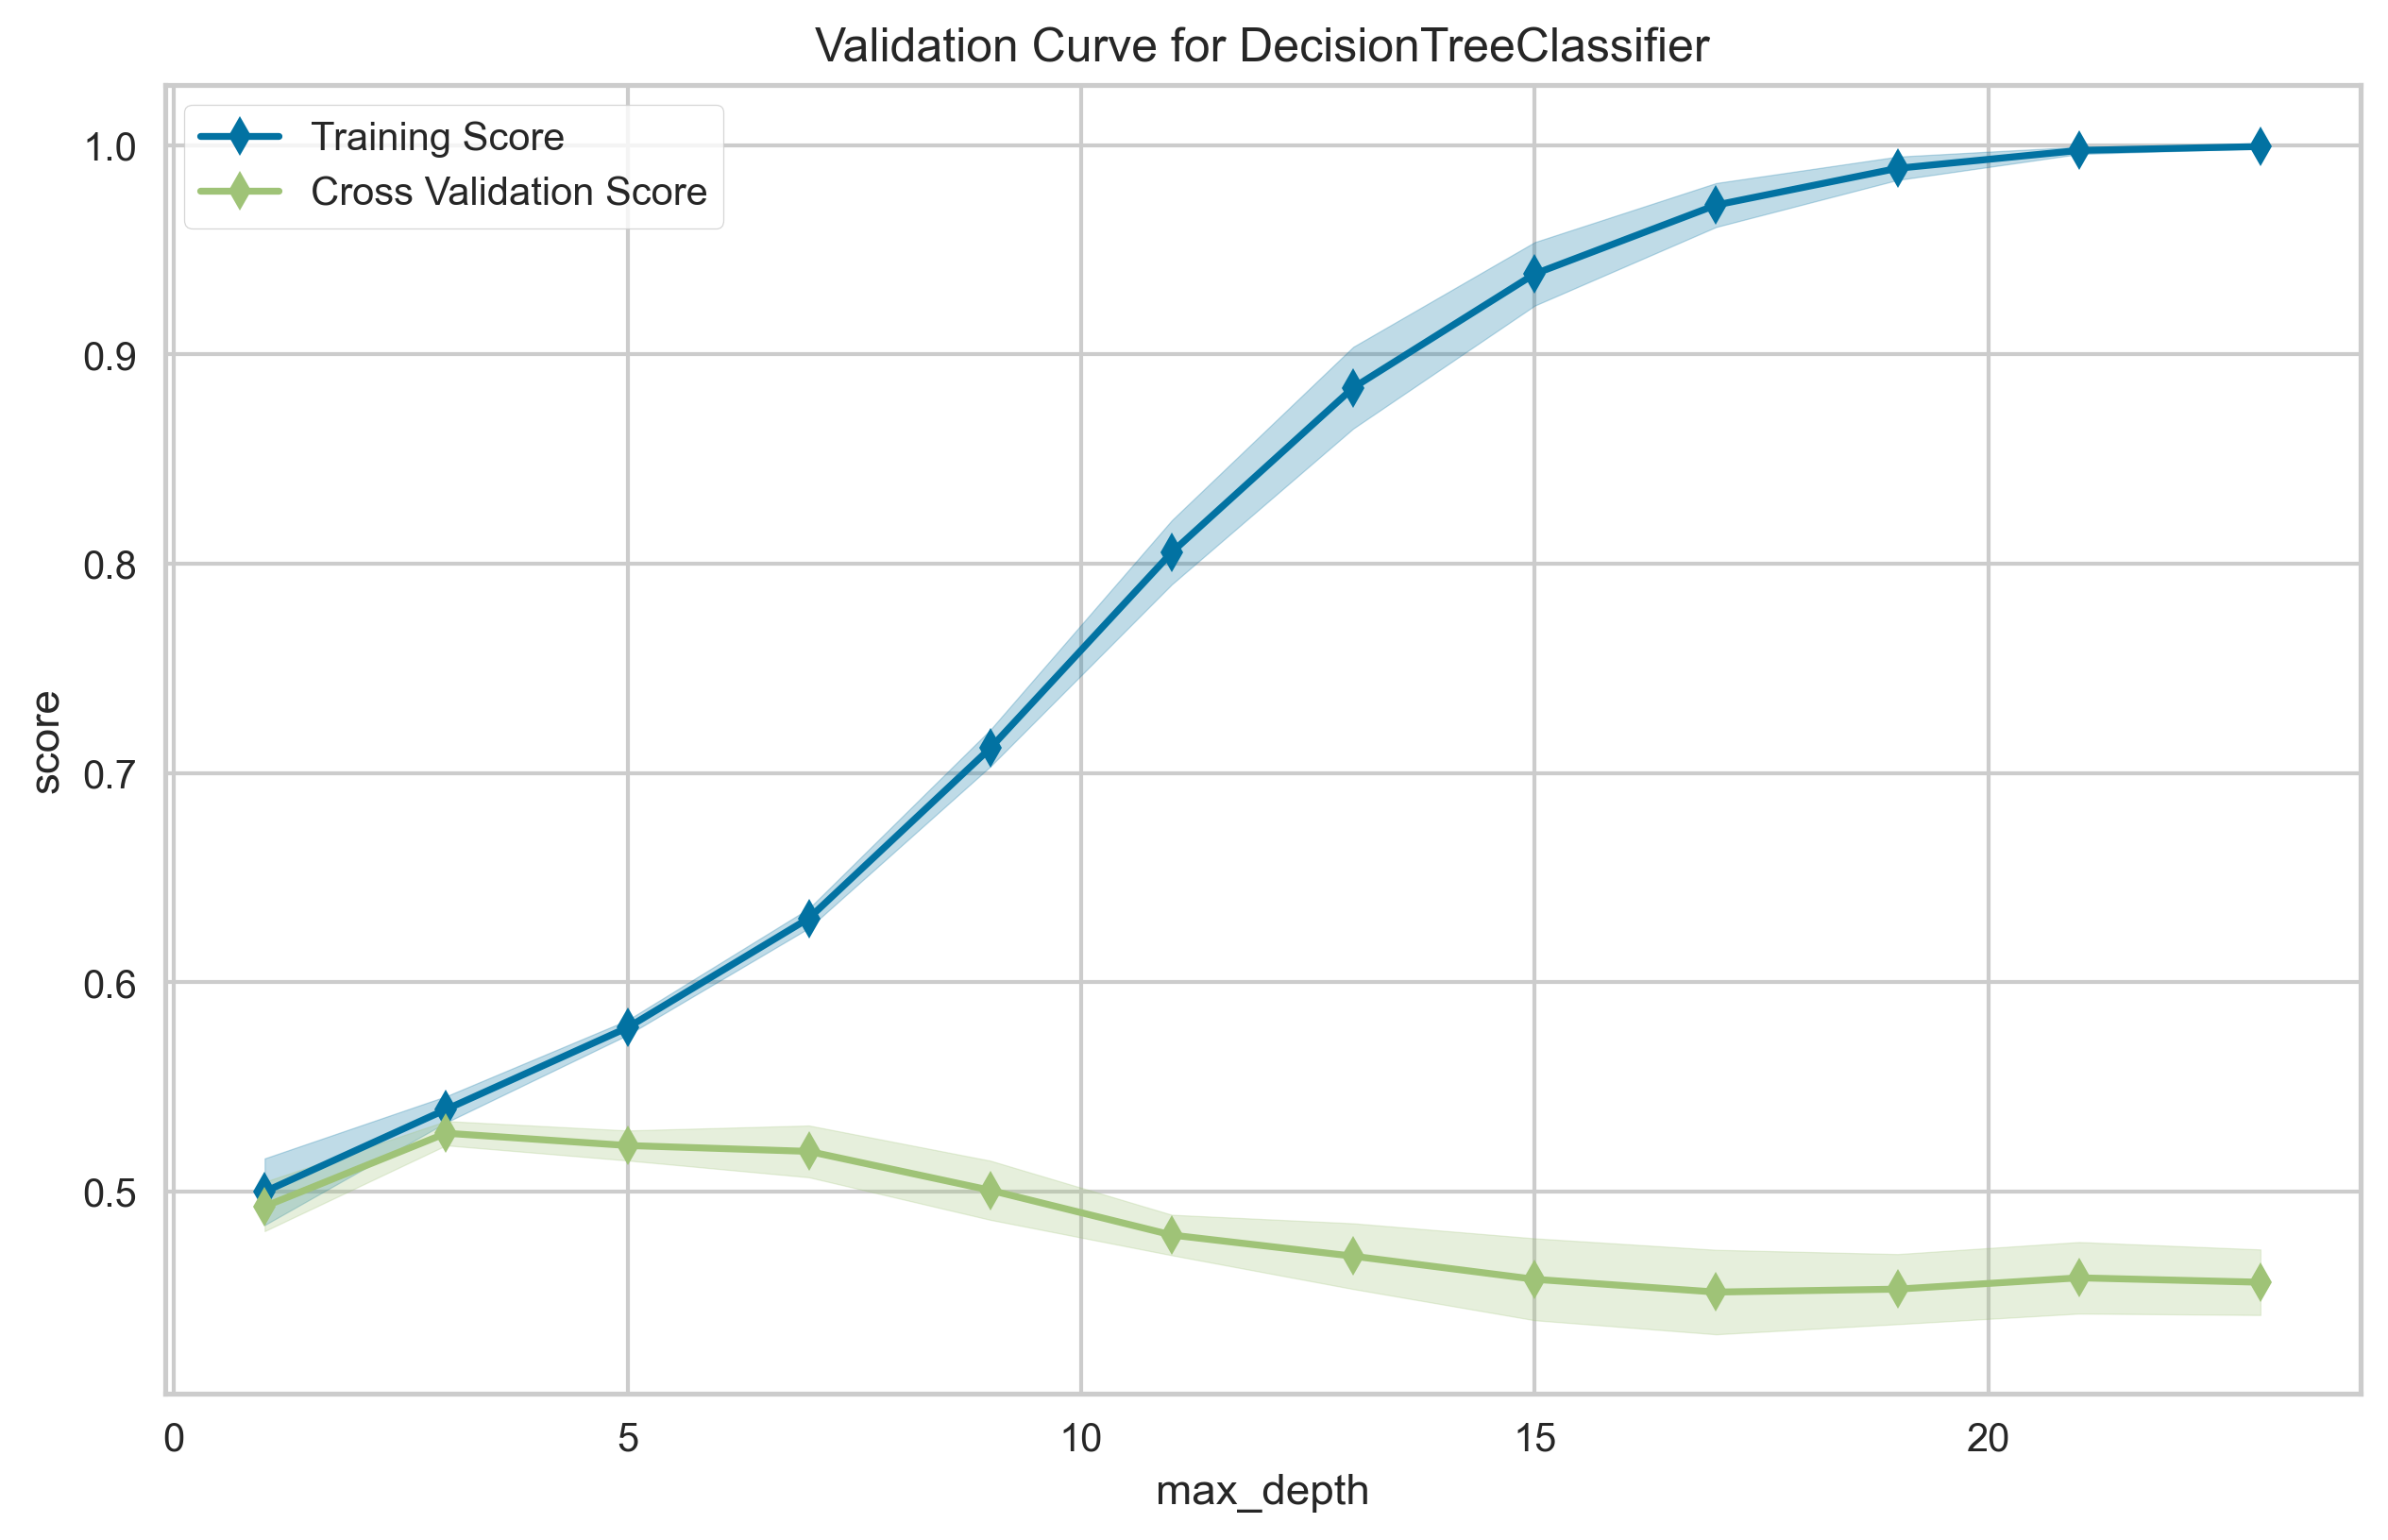

In [13]:
dt_clf = DecisionTreeClassifier(random_state=SEED)
viz.validation_curve(
    clf=dt_clf,
    X_tr=X_train,
    y_tr=y_train,
    cv=CV,
    param_name="max_depth",
    param_range=np.arange(1, 25, 2),
    output_path=f"{WINE_DT_PATH}/dt_max_depth.png",
    scoring=F1_SCORE,
)

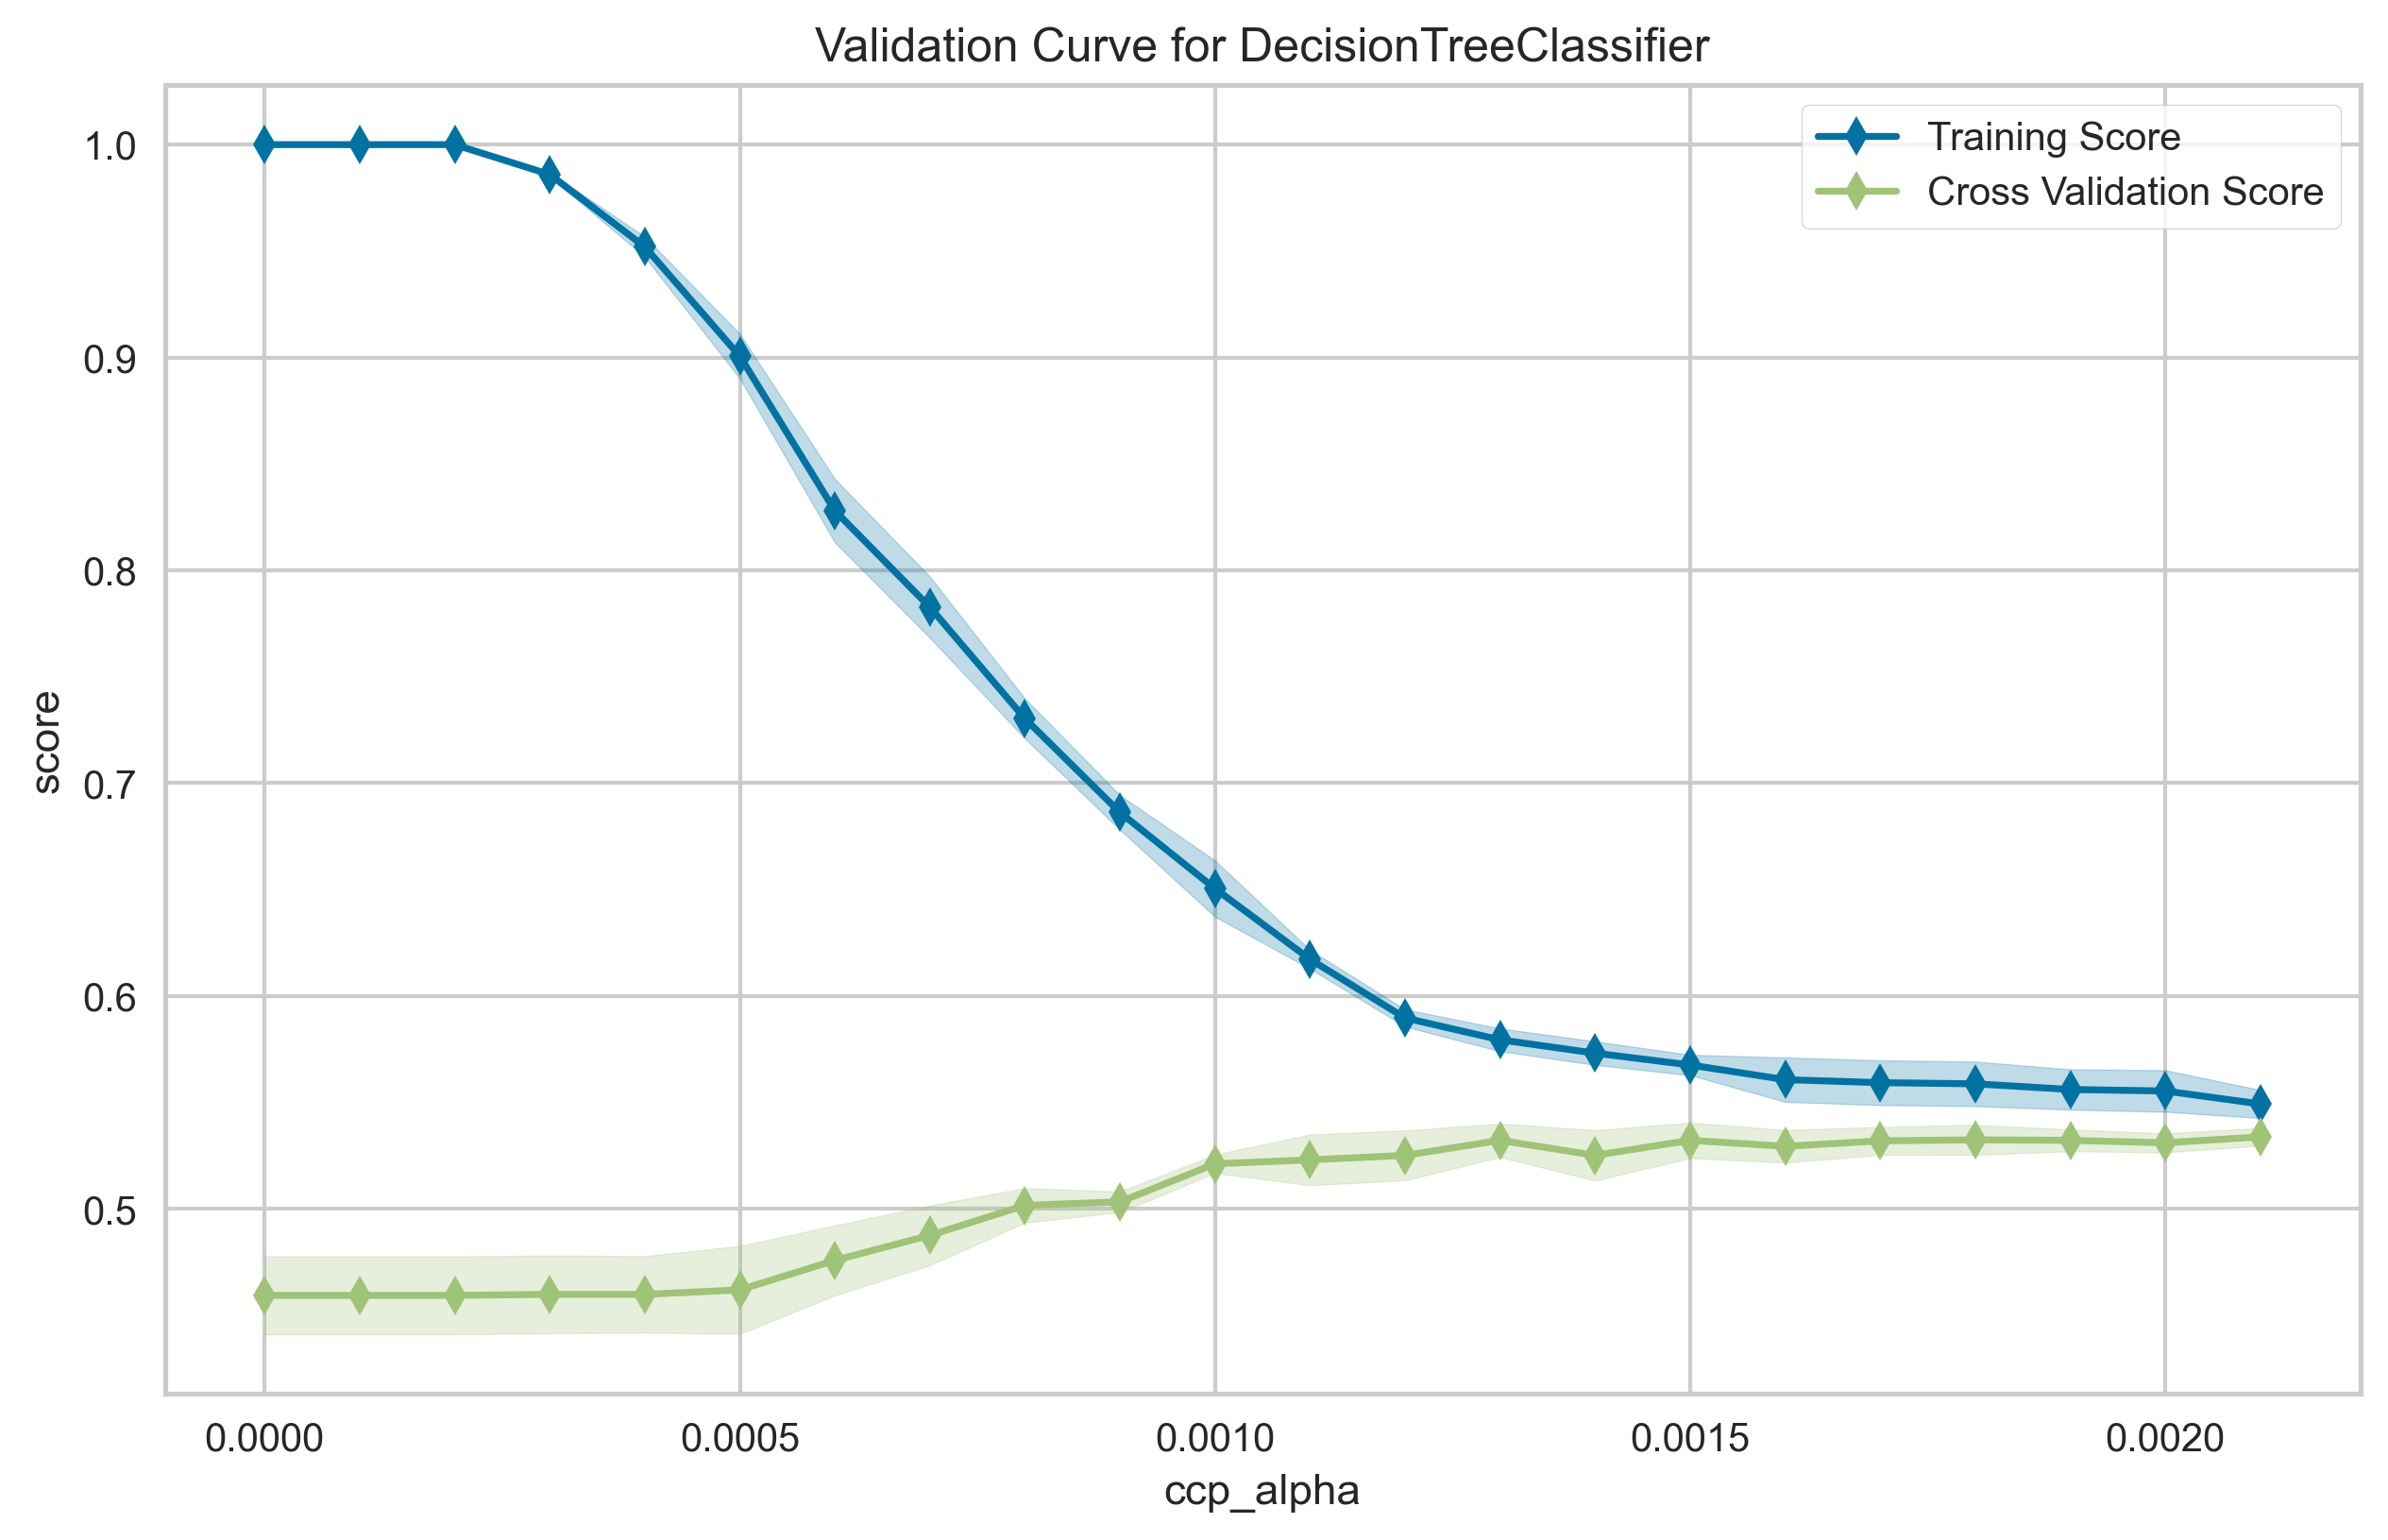

In [14]:
dt_clf = DecisionTreeClassifier(random_state=SEED)
viz.validation_curve(
    clf=dt_clf,
    X_tr=X_train,
    y_tr=y_train,
    cv=CV,
    param_name="ccp_alpha",
    param_range=np.arange(0, 0.0022, 0.0001),
    output_path=f"{WINE_DT_PATH}/dt_ccp_alpha.png",
    scoring=F1_SCORE)

In [15]:
best_dt_params = training.perform_hyperparameter_tuning(
    clf=DecisionTreeClassifier(random_state=SEED),
    X_tr=X_train,
    y_tr=y_train,
    cv=CV,
    param_space={
        "ccp_alpha": np.arange(0, 0.001, 0.0002),
        "max_depth": [int(x) for x in np.arange(2, 50, 5)],
        "min_samples_leaf": np.arange(1, 101, 10),
    },
    scoring=F1_SCORE,
)

In [16]:
best_dt_params

{'ccp_alpha': 0.0, 'max_depth': 7, 'min_samples_leaf': 41}

In [17]:
def instantiate_best_dt_clf():
    return DecisionTreeClassifier(max_depth=best_dt_params['max_depth'],
                                  min_samples_leaf=best_dt_params['min_samples_leaf'],
                                  ccp_alpha=best_dt_params['ccp_alpha'],
                                  random_state=SEED)

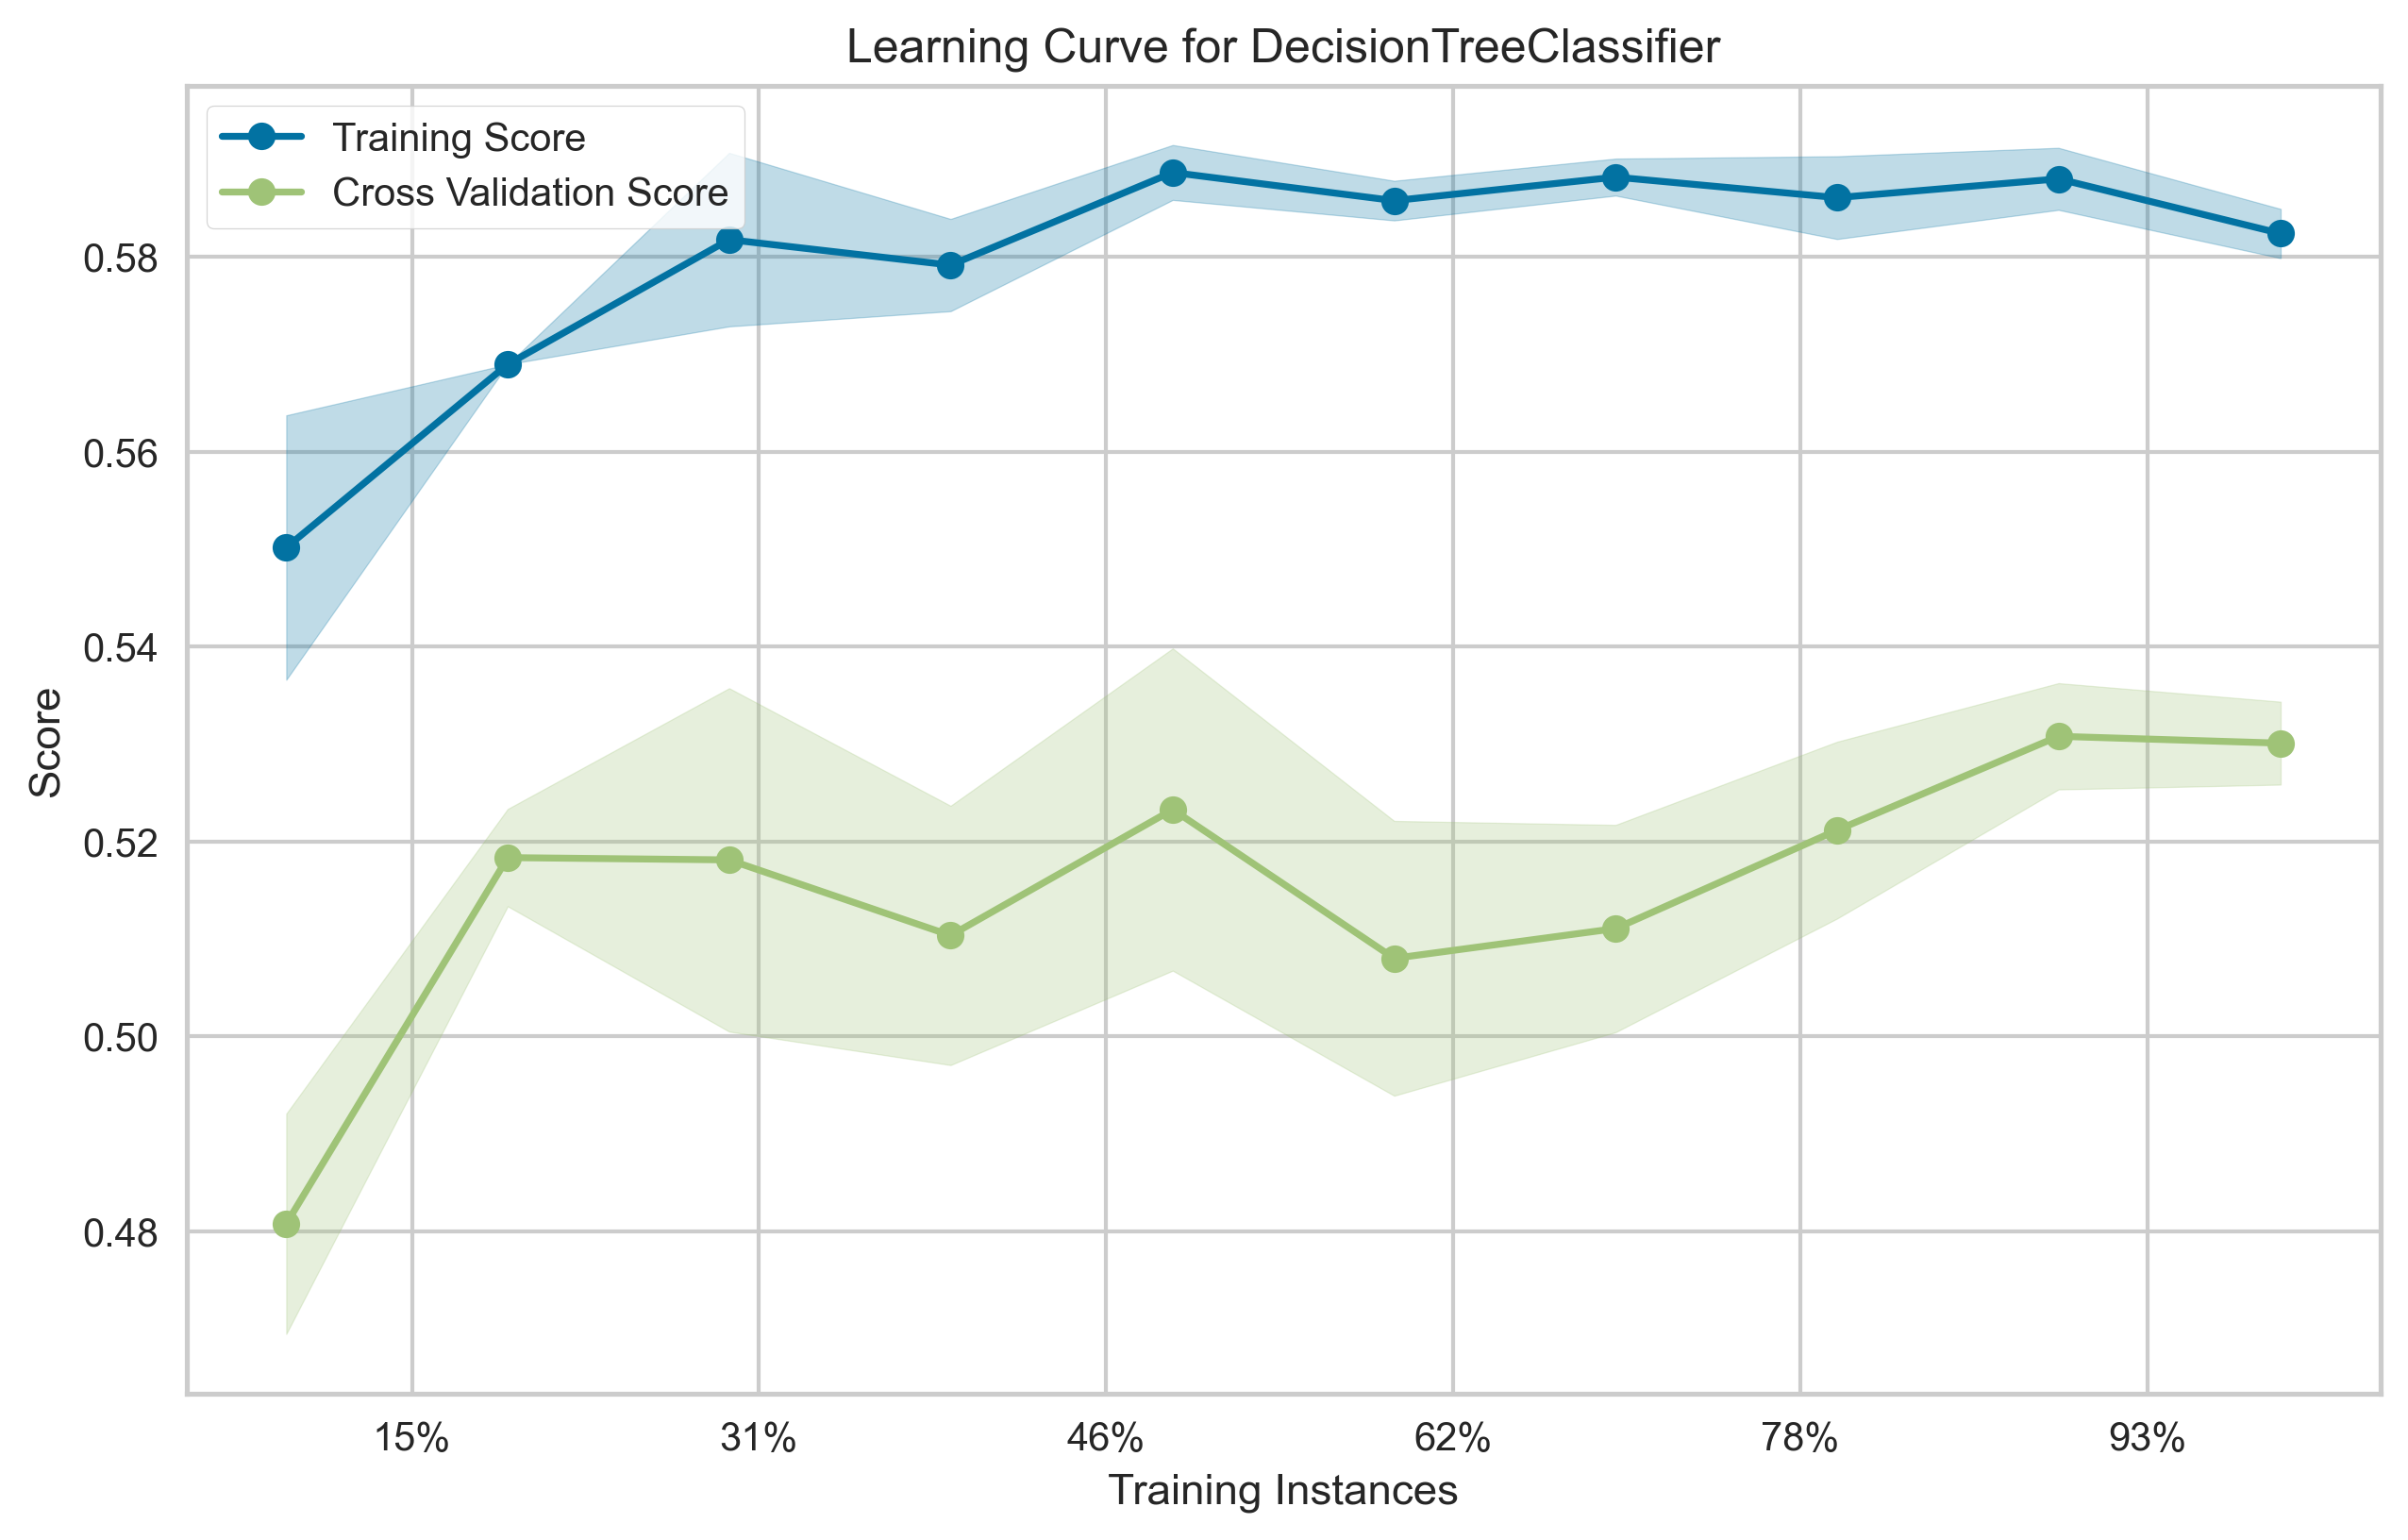

In [18]:
best_dt_clf = instantiate_best_dt_clf()
viz.learning_curve(clf=best_dt_clf,
                   X_tr=X_train,
                   y_tr=y_train,
                   cv=CV,
                   output_path=f"{WINE_DT_PATH}/dt_learning_curve.png",
                   scoring=F1_SCORE)

/Users/pavponn/opt/anaconda3/envs/assignment-1/lib/python3.10/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


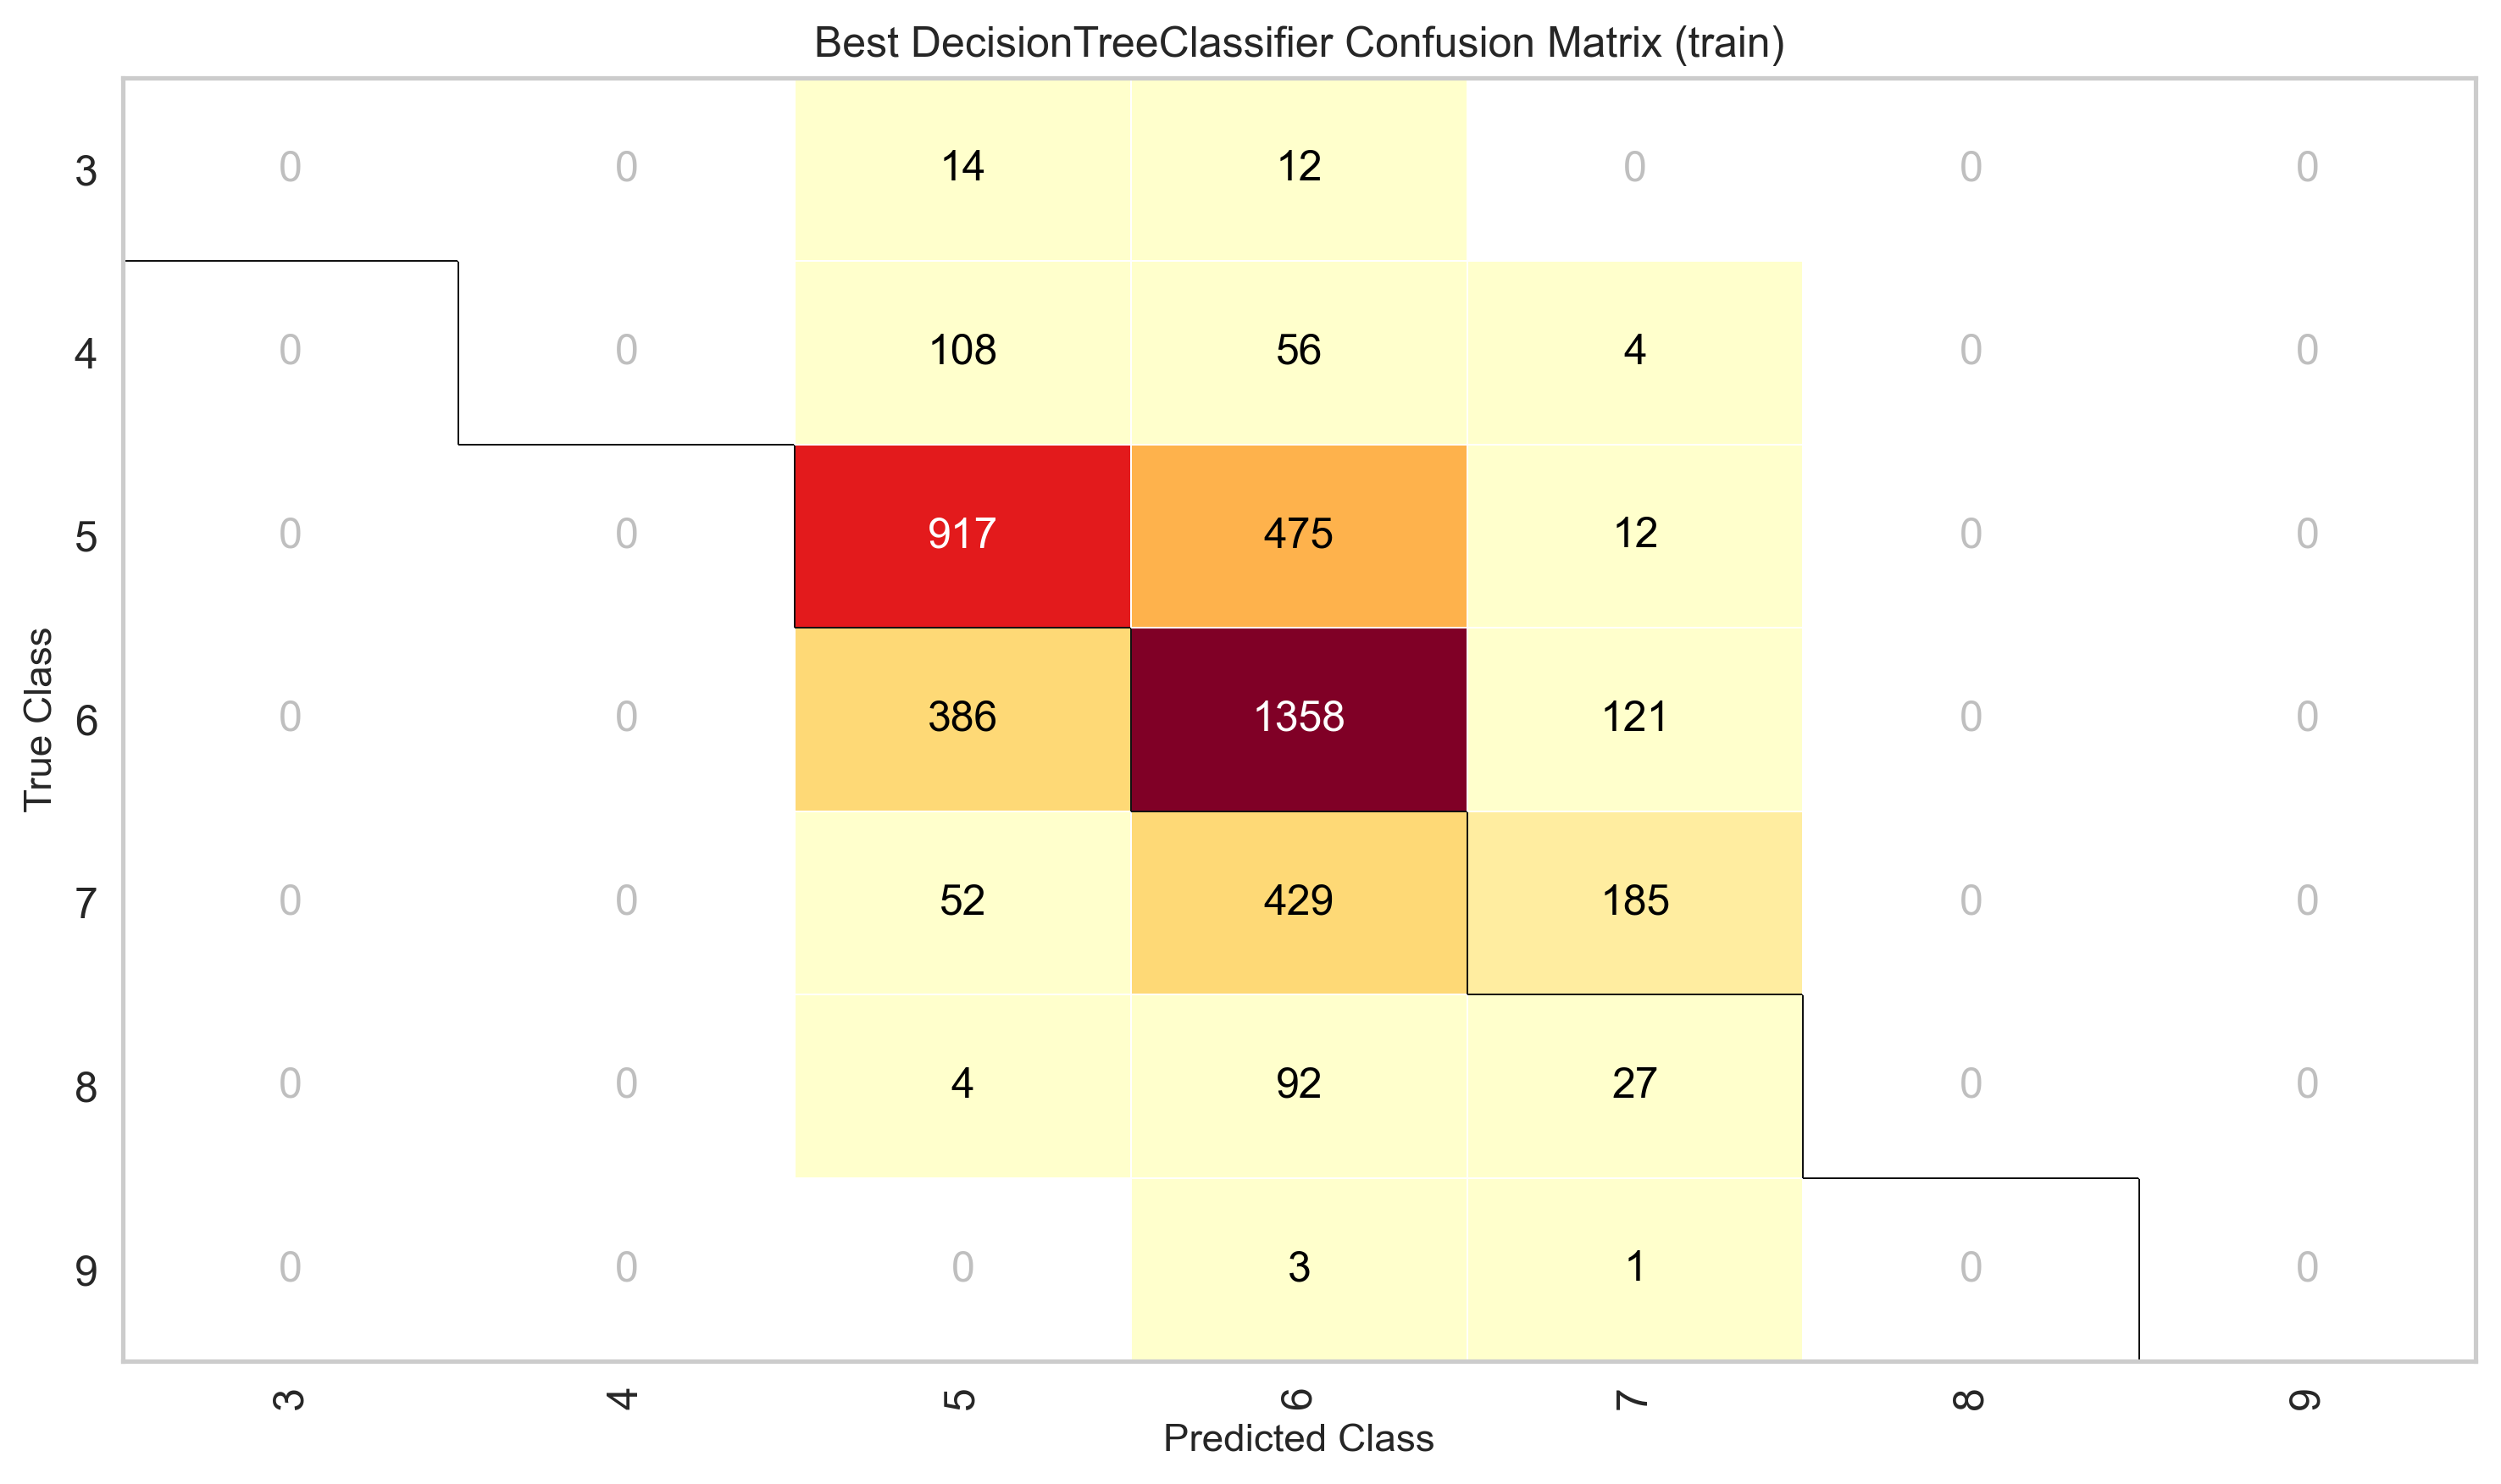

In [19]:
best_dt_clf = instantiate_best_dt_clf()
best_dt_clf = best_dt_clf.fit(X_train, y_train)
viz.confusion_matrix(
    clf=best_dt_clf,
    X=X_train,
    y=y_train,
    title='Best DecisionTreeClassifier Confusion Matrix (train)',
    output_path=f'{WINE_DT_PATH}/best_dt_train_confusion_matrix.png')

/Users/pavponn/opt/anaconda3/envs/assignment-1/lib/python3.10/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


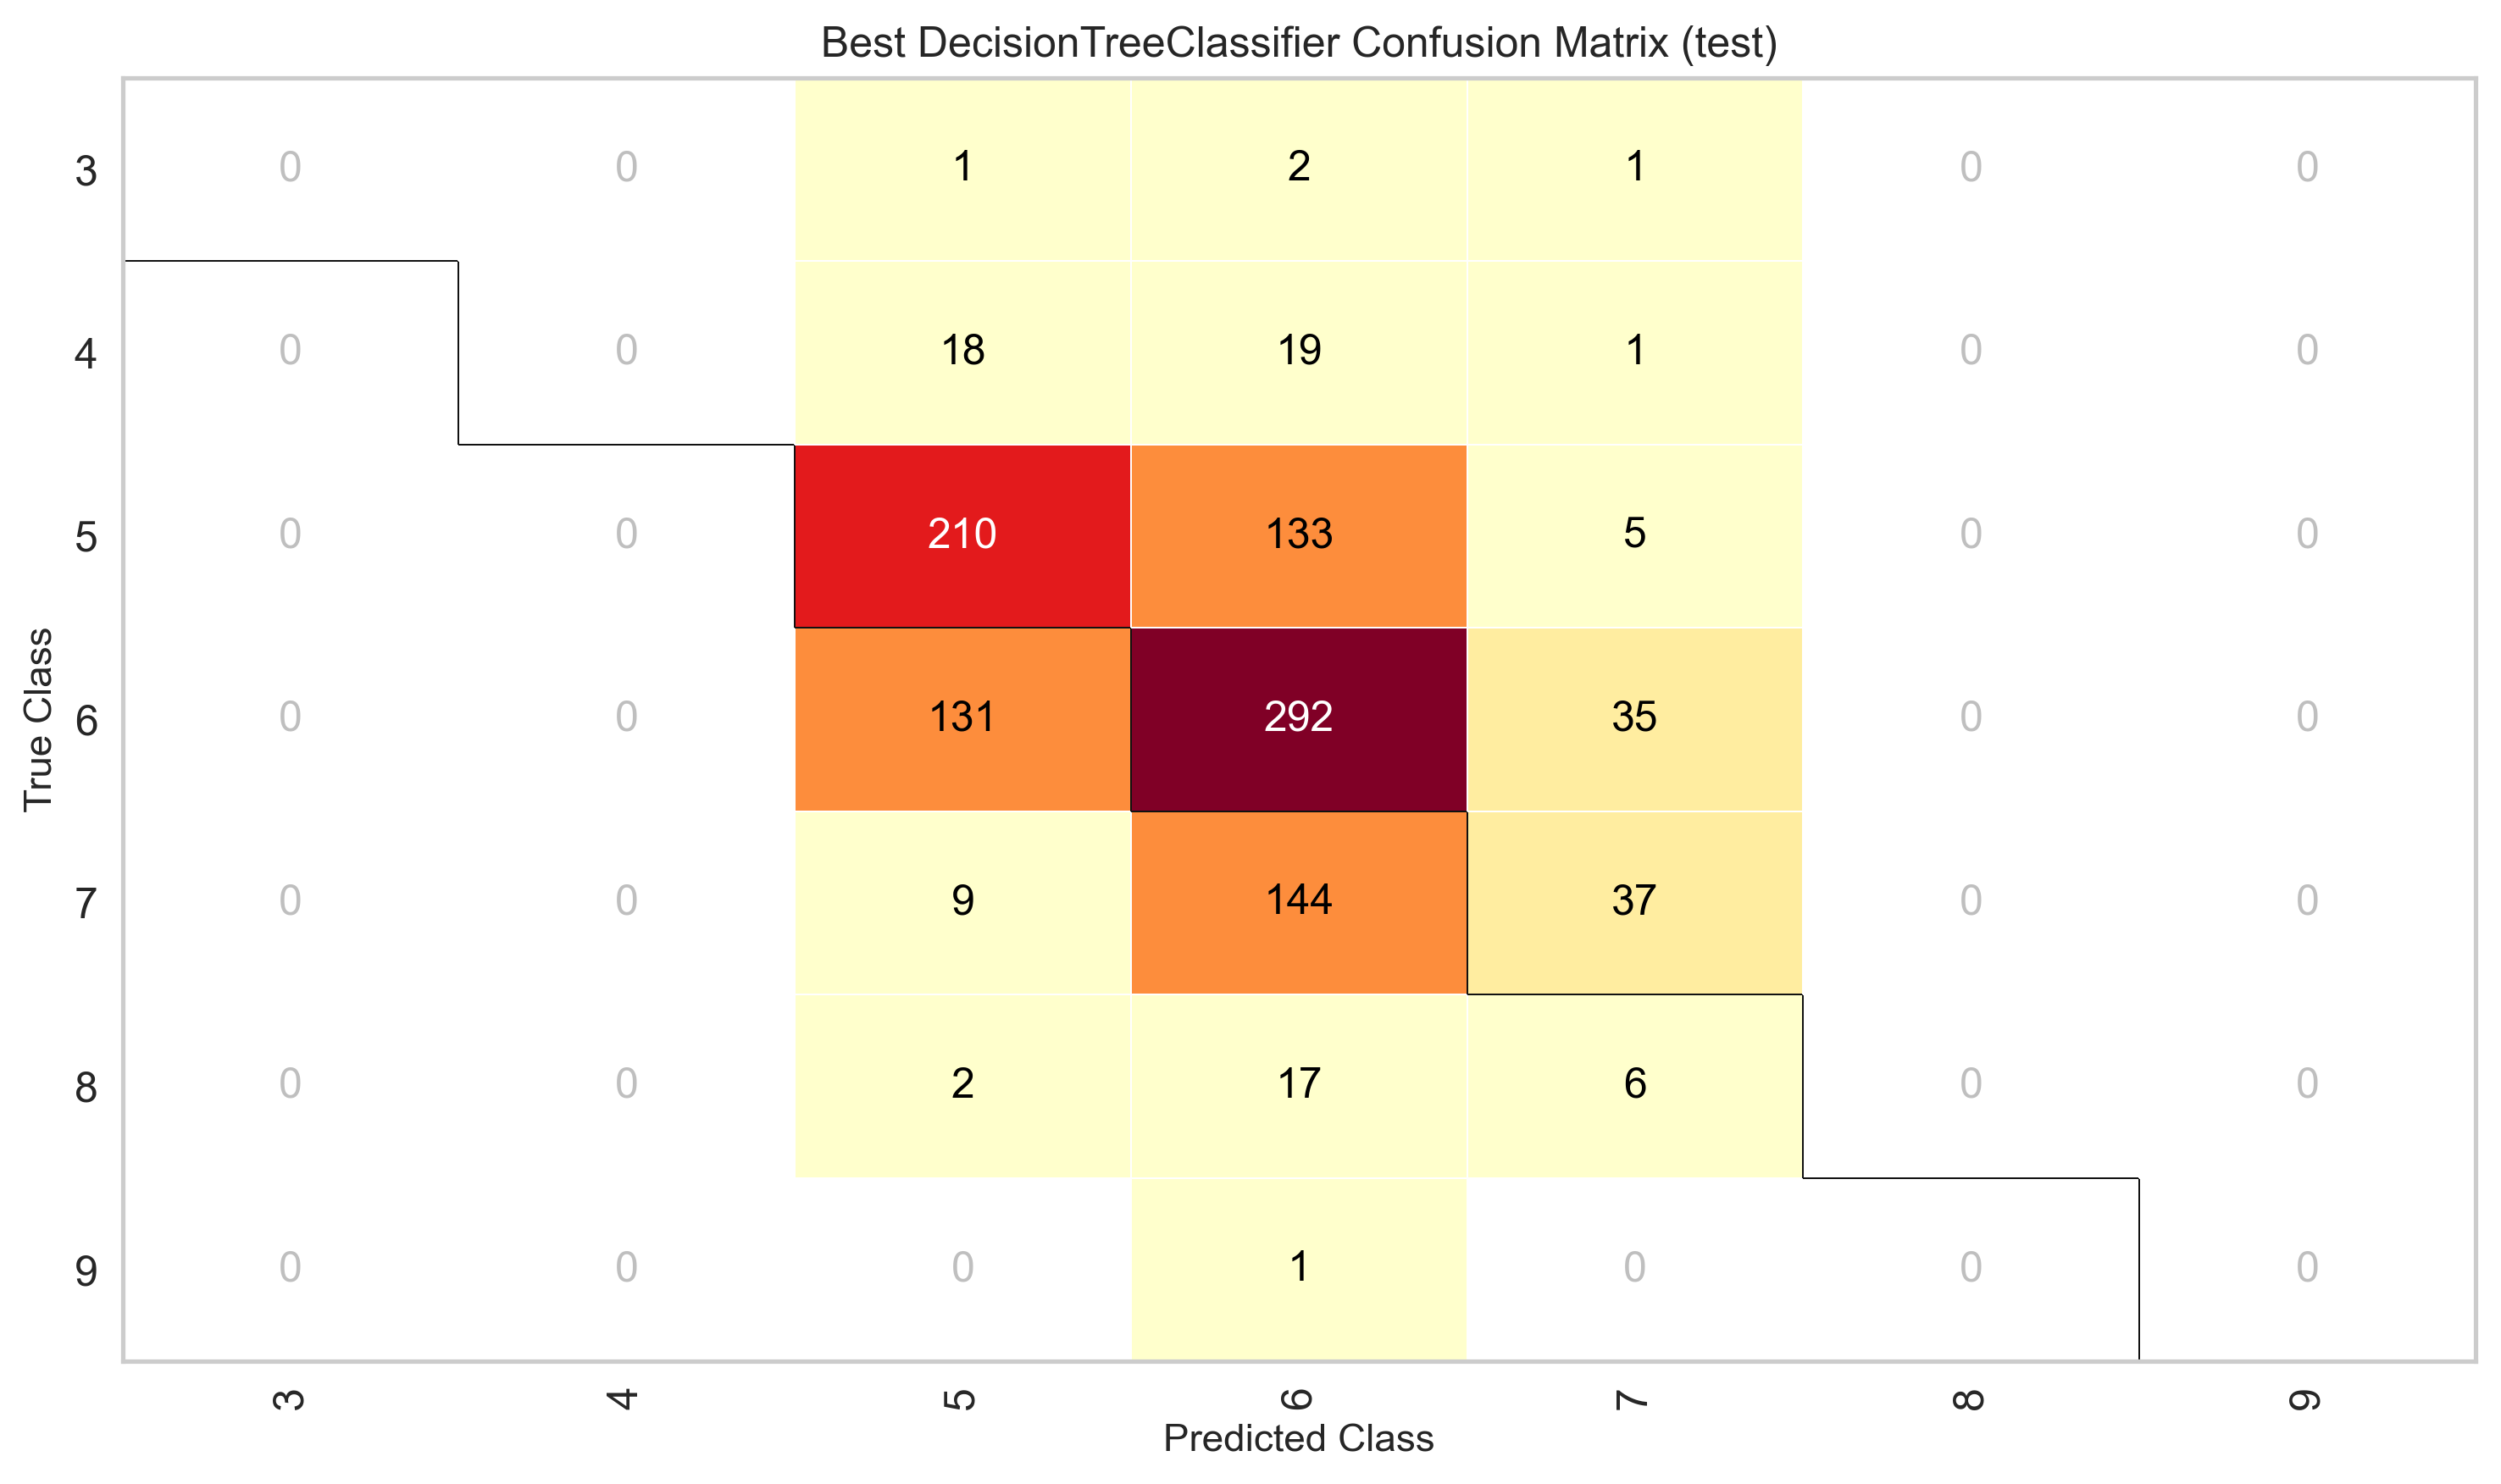

In [20]:
viz.confusion_matrix(
    clf=best_dt_clf,
    X=X_test,
    y=y_test,
    title='Best DecisionTreeClassifier Confusion Matrix (test)',
    output_path=f'{WINE_DT_PATH}/best_dt_test_confusion_matrix.png')

In [21]:
metrics.f1_score_stats(clf=best_dt_clf, X_tr=X_train, X_t=X_test, y_tr=y_train, y_t=y_test, averaging=F1_AVERAGING)

F1-Score, micro (train): 0.5780
F1-Score, micro (test) : 0.5066


In [22]:
best_dt_clf = instantiate_best_dt_clf()
training.learning_time_stats(best_dt_clf,
                             X_tr=X_train,
                             y_tr=y_train,
                             )

Training time, total: 0.0134 seconds
Training time, normalized (per 1000 samples): 0.0031 seconds


In [23]:
training.inference_time_stats(best_dt_clf, X_train, proba=False, dataset_name='train')
training.inference_time_stats(best_dt_clf, X_test, proba=False, dataset_name='test')
training.inference_time_stats(best_dt_clf, X_all, proba=False, dataset_name='all')

Inference time (train), total: 0.0017 seconds
Inference time (train), normalized (per 1000 samples): 0.0004 seconds
Inference time (test), total: 0.0009 seconds
Inference time (test), normalized (per 1000 samples): 0.0009 seconds
Inference time (all), total: 0.0011 seconds
Inference time (all), normalized (per 1000 samples): 0.0002 seconds


# Boosting

### Plan

1. Train baseline boosting without hyperparameter tuning, look at the precision/recall at train and test sets
2. Validate how different individual hyperparameters affect performance of the model wrt recall@precision
    a. `n_estimators`
    b. `learning_rate`
3. Perform hyperparameter tuning of multiple parameters
4. Analyse performance of the best decision tree with hyperparameter tuning

In [24]:
WINE_BOOST_PATH = f'{WINE_PATH}/boosting'

In [25]:
boost_baseline_clf = AdaBoostClassifier(random_state=SEED)
boost_baseline_clf.fit(X_train, y_train)

AdaBoostClassifier(random_state=42)

/Users/pavponn/opt/anaconda3/envs/assignment-1/lib/python3.10/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


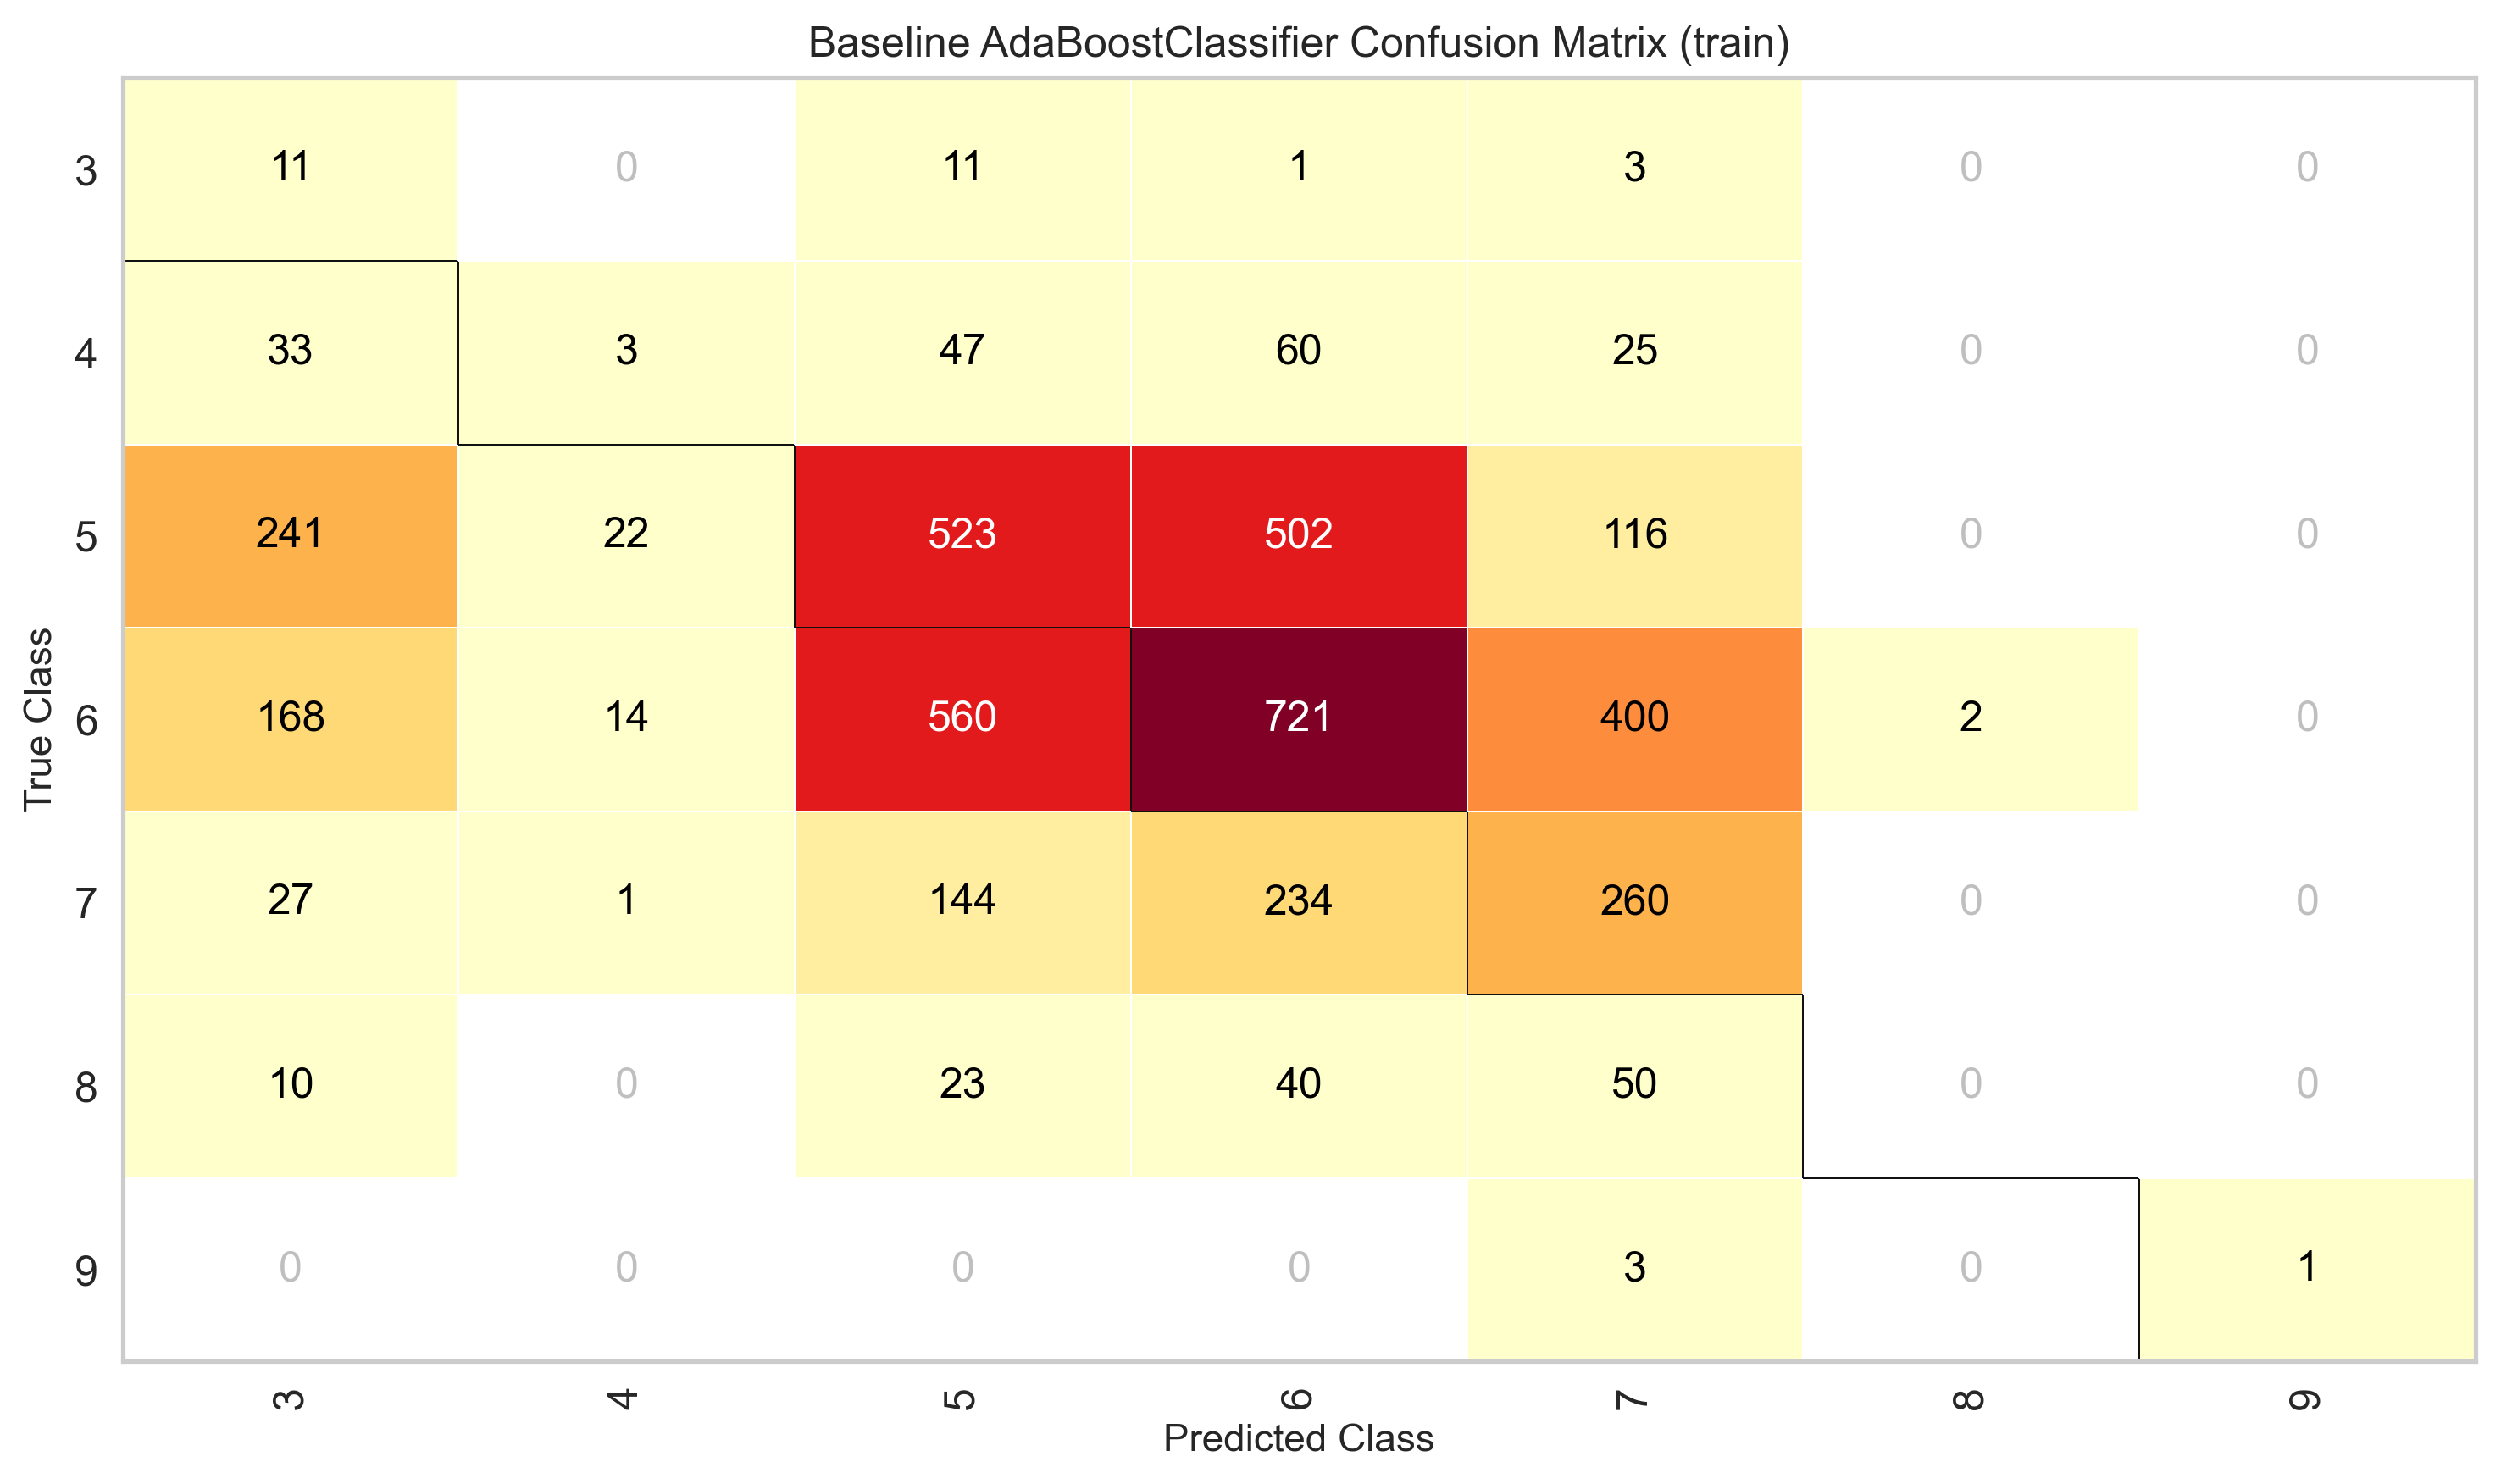

In [26]:
viz.confusion_matrix(
    clf=boost_baseline_clf,
    X=X_train,
    y=y_train,
    title='Baseline AdaBoostClassifier Confusion Matrix (train)',
    output_path=f'{WINE_BOOST_PATH}/baseline_boost_train_confusion_matrix.png')

/Users/pavponn/opt/anaconda3/envs/assignment-1/lib/python3.10/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


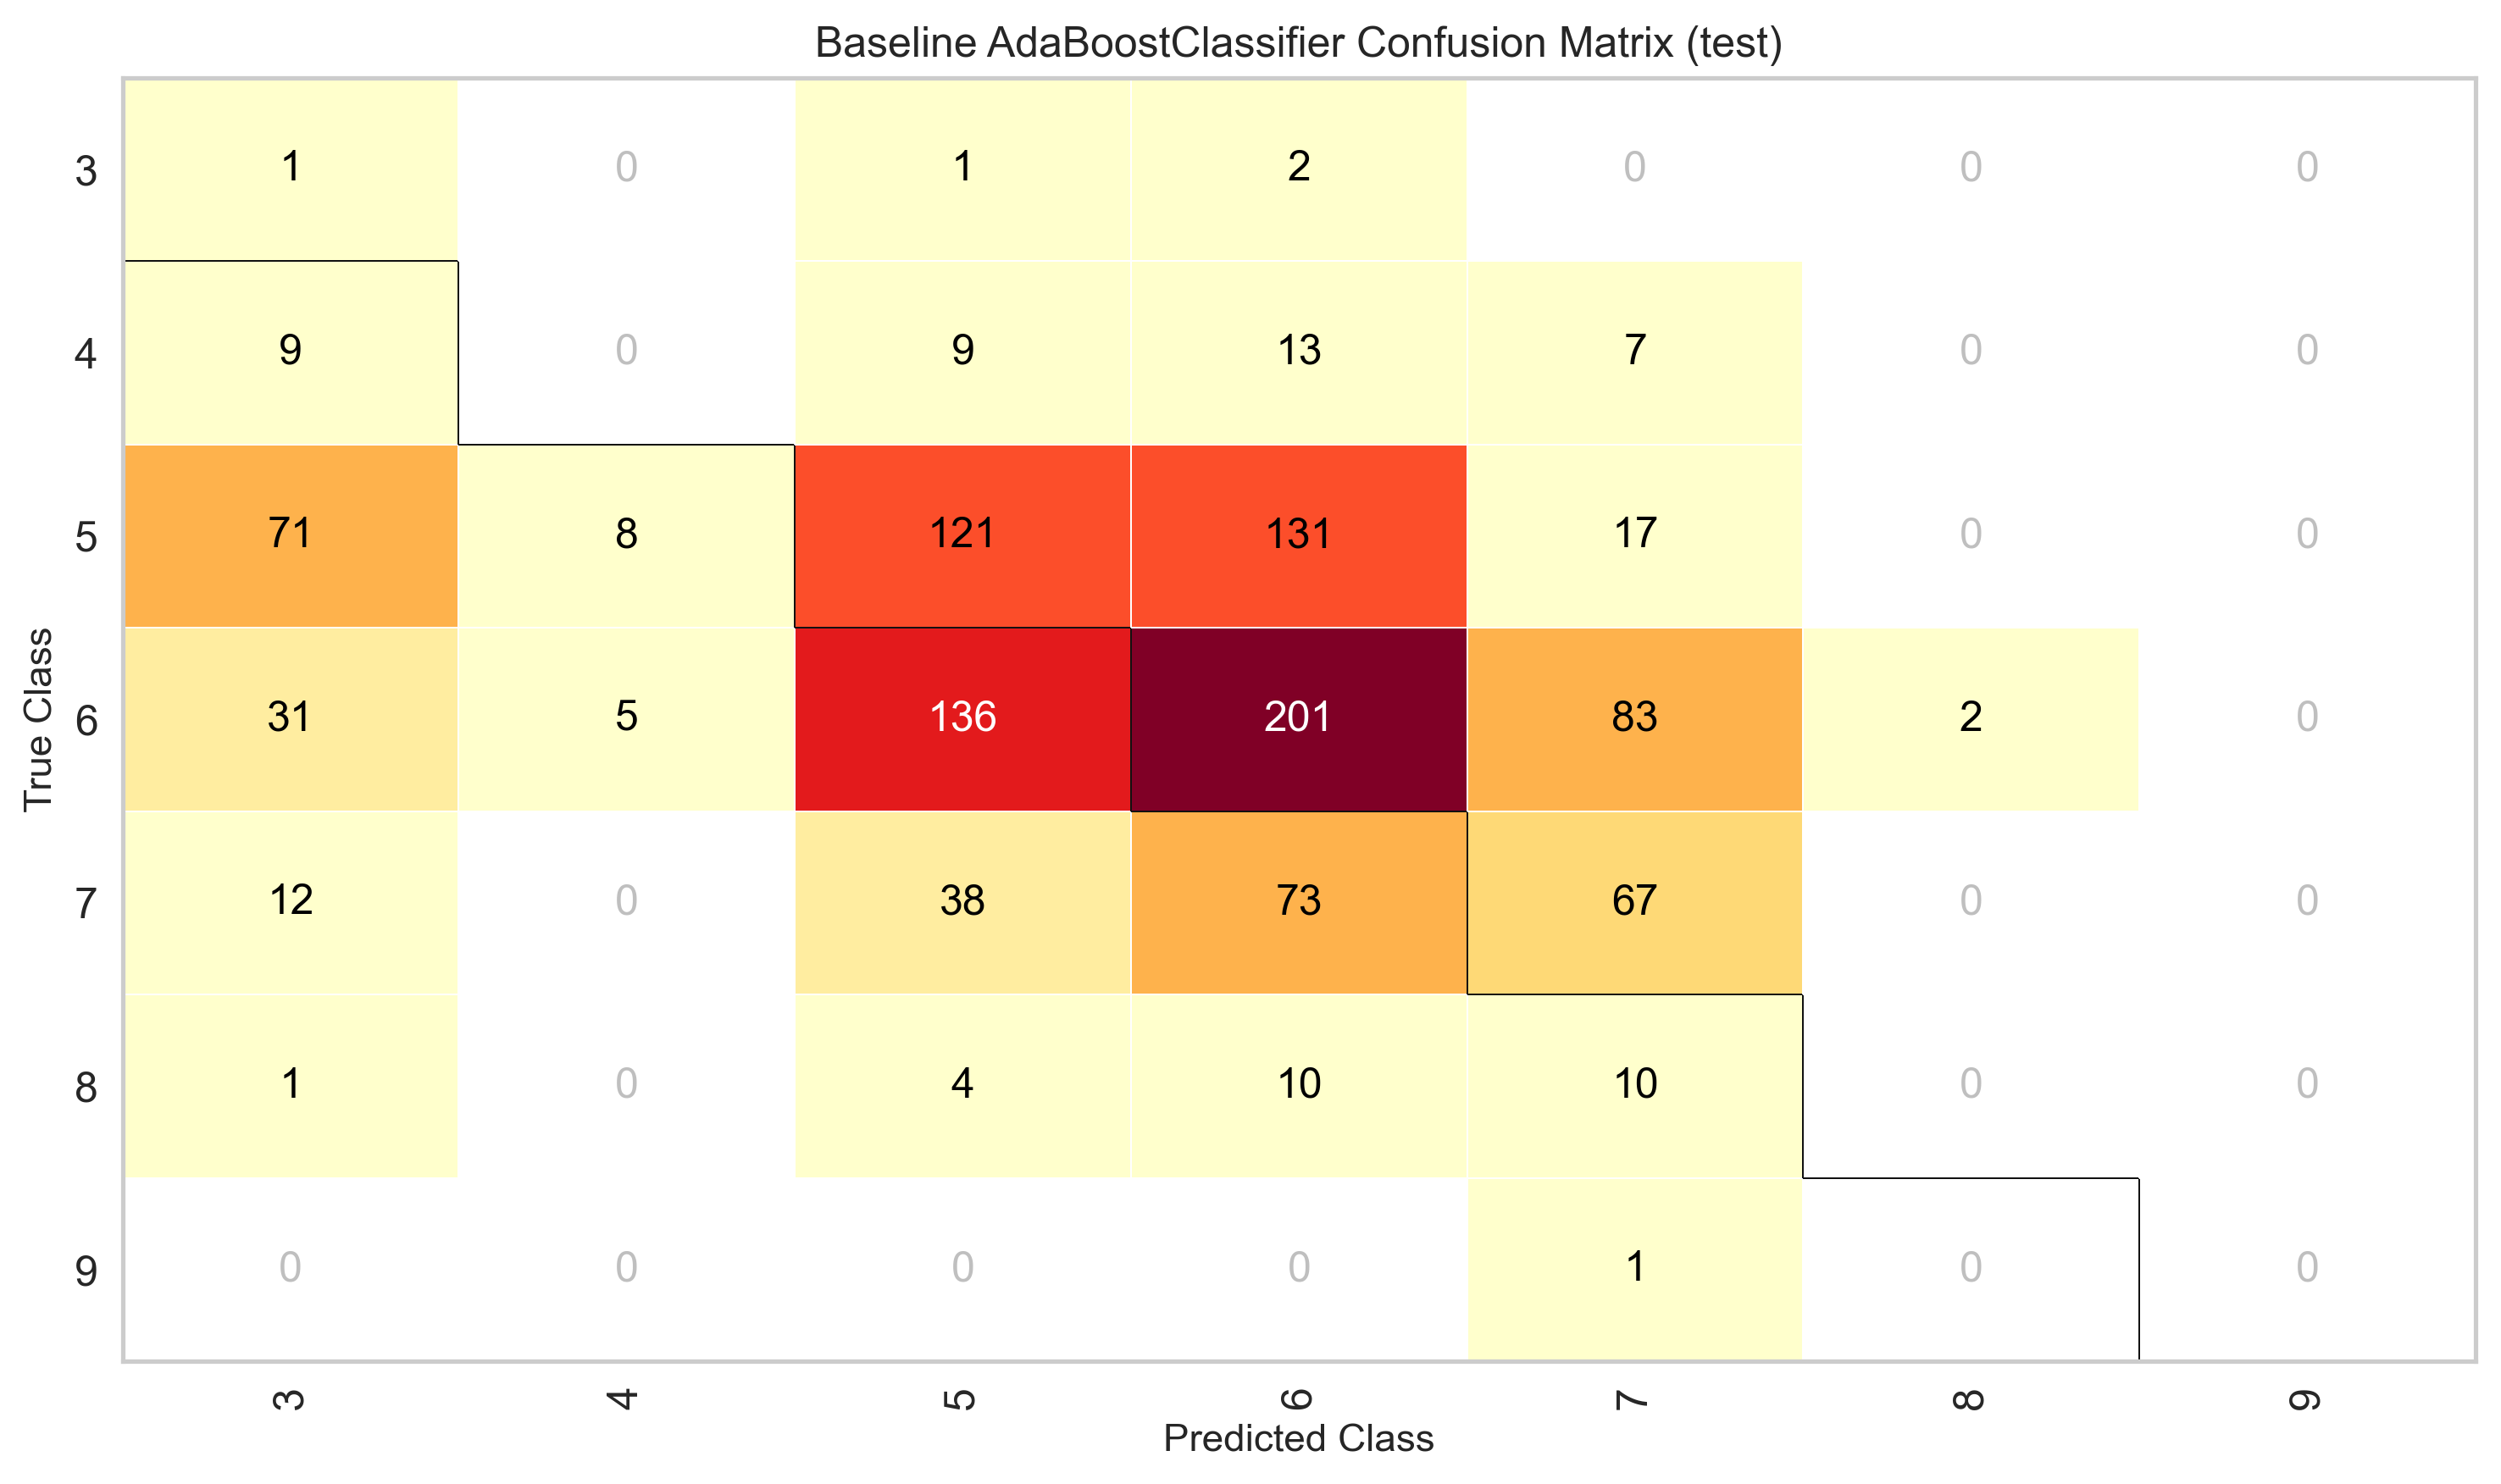

In [27]:
viz.confusion_matrix(
    clf=boost_baseline_clf,
    X=X_test,
    y=y_test,
    title='Baseline AdaBoostClassifier Confusion Matrix (test)',
    output_path=f'{WINE_BOOST_PATH}/baseline_boost_test_confusion_matrix.png')

In [28]:
metrics.f1_score_stats(clf=boost_baseline_clf, X_tr=X_train, X_t=X_test, y_tr=y_train, y_t=y_test,
                       averaging=F1_AVERAGING)


F1-Score, micro (train): 0.3569
F1-Score, micro (test) : 0.3665


/Users/pavponn/opt/anaconda3/envs/assignment-1/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:627: RuntimeWarning: overflow encountered in exp
  sample_weight *= np.exp(
/Users/pavponn/opt/anaconda3/envs/assignment-1/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:627: RuntimeWarning: overflow encountered in exp
  sample_weight *= np.exp(
/Users/pavponn/opt/anaconda3/envs/assignment-1/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: UserWarning: Sample weights have reached infinite values, at iteration 2, causing overflow. Iterations stopped. Try lowering the learning rate.
  estimator.fit(X_train, y_train, **fit_params)
/Users/pavponn/opt/anaconda3/envs/assignment-1/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: UserWarning: Sample weights have reached infinite values, at iteration 2, causing overflow. Iterations stopped. Try lowering the learning rate.
  estimator.fit(X_train, y_train, **fit_params

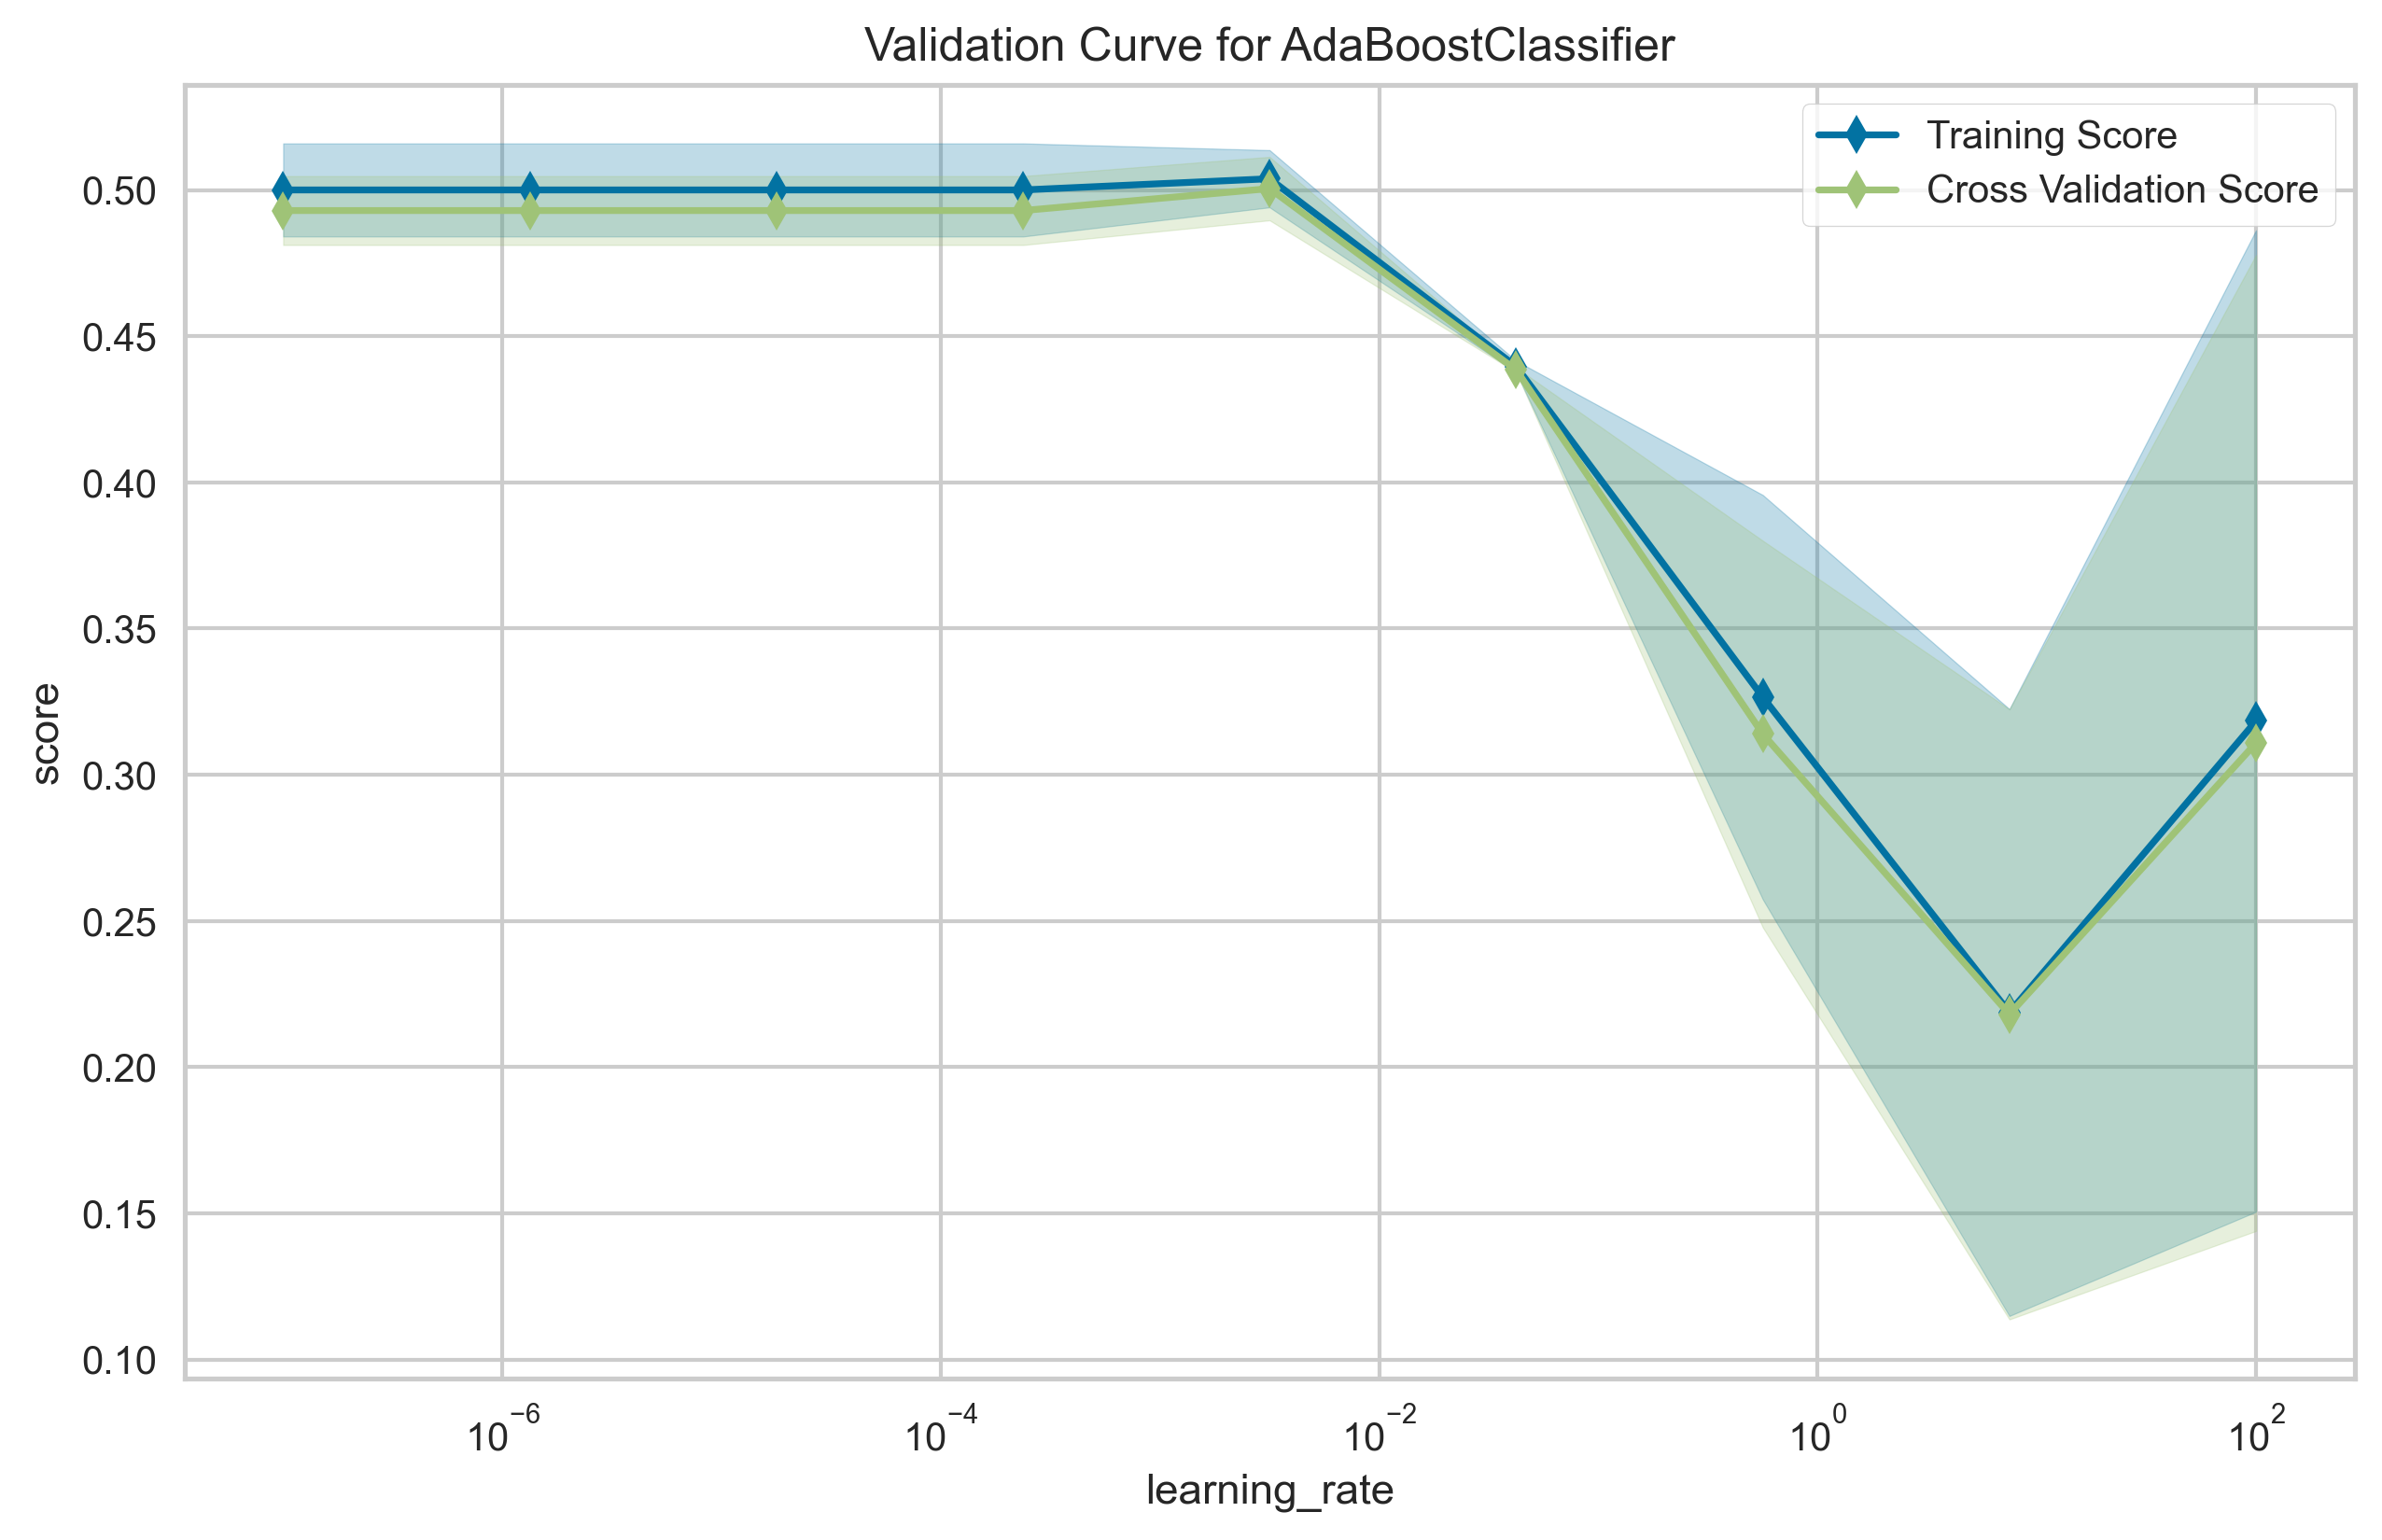

In [29]:
boost_clf = AdaBoostClassifier(random_state=SEED)
viz.validation_curve(
    clf=boost_clf,
    X_tr=X_train,
    y_tr=y_train,
    cv=CV,
    param_name="learning_rate",
    param_range=np.logspace(-7, 2, 9),
    output_path=f"{WINE_BOOST_PATH}/boost_learning_rate.png",
    logx=True,
    scoring=F1_SCORE,
)

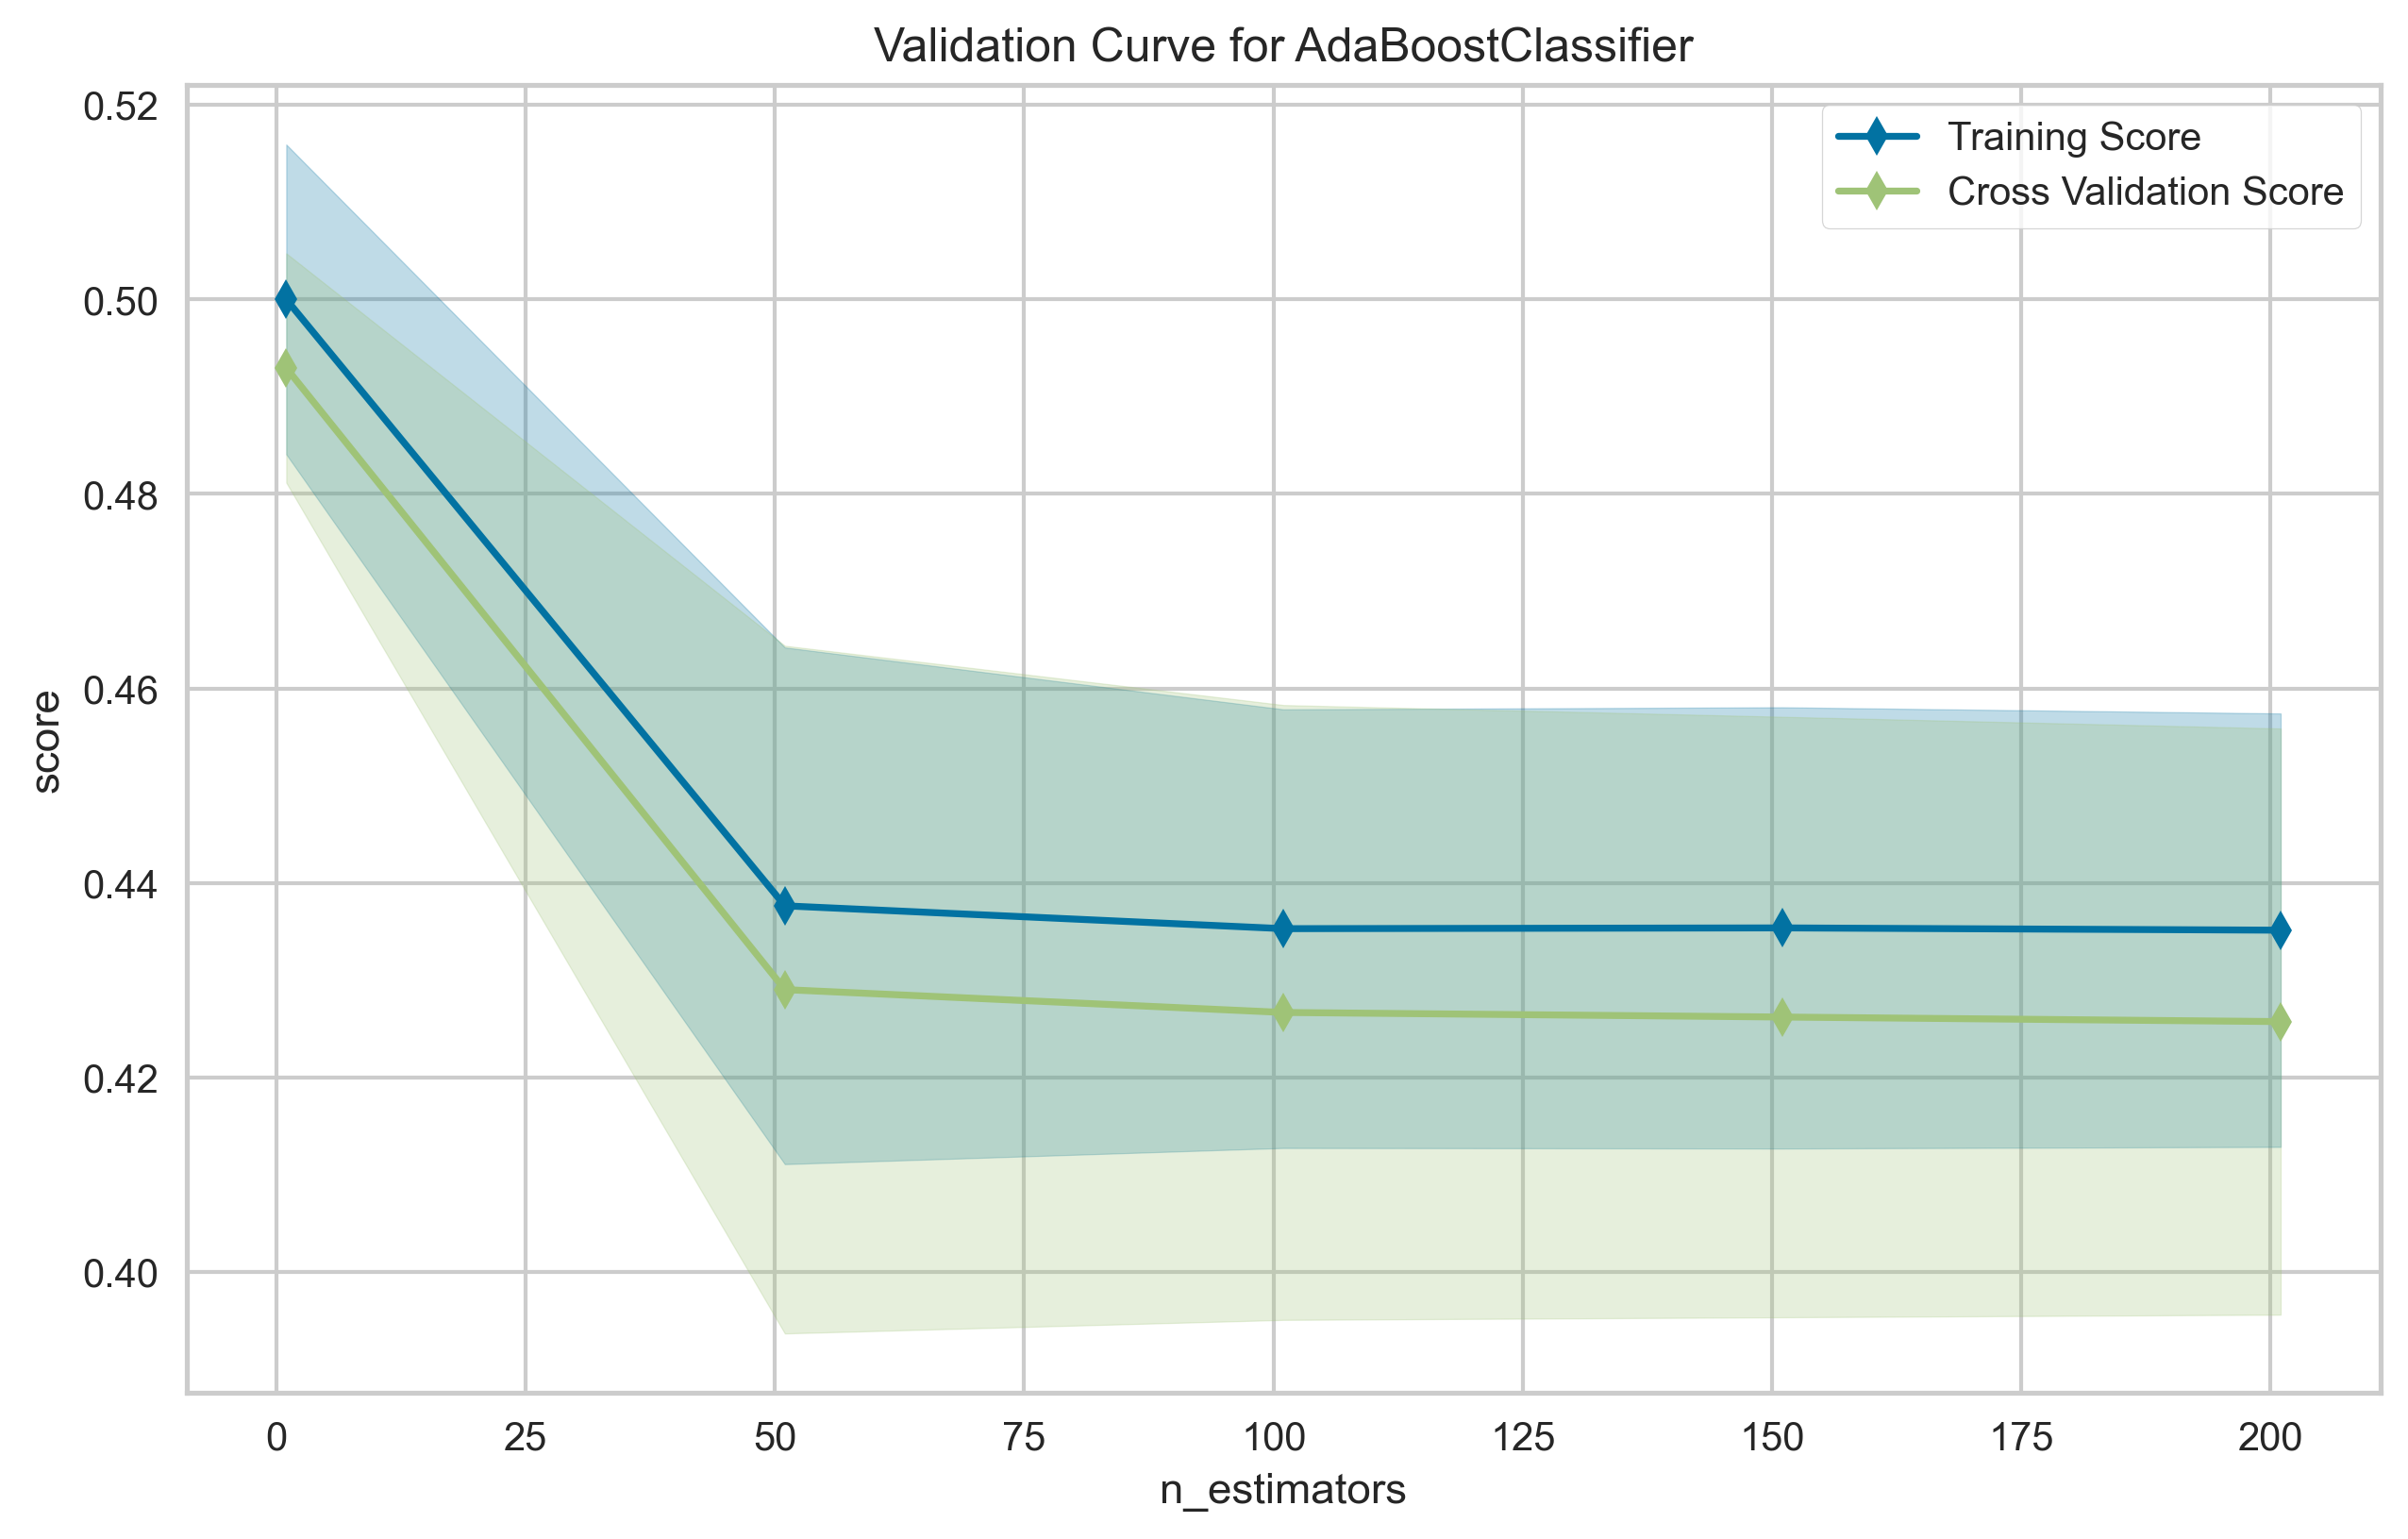

In [30]:
boost_clf = AdaBoostClassifier(random_state=SEED)
viz.validation_curve(
    clf=boost_clf,
    X_tr=X_train,
    y_tr=y_train,
    cv=CV,
    param_name="n_estimators",
    param_range=np.arange(1, 250, 50),
    output_path=f"{WINE_BOOST_PATH}/boost_n_estimators.png",
    scoring=F1_SCORE,
)

In [31]:
best_boost_params = training.perform_hyperparameter_tuning(
    clf=AdaBoostClassifier(random_state=SEED),
    X_tr=X_train,
    y_tr=y_train,
    cv=CV,
    param_space={
        "n_estimators": np.arange(50, 300, 50),
        "learning_rate": np.logspace(-4, 0, 8)
    },
    n_jobs=6,
    scoring=F1_SCORE,
)

In [32]:
best_boost_params

{'learning_rate': 0.0003727593720314938, 'n_estimators': 150}

In [33]:
def instantiate_best_boost_clf():
    return AdaBoostClassifier(learning_rate=best_boost_params['learning_rate'],
                              n_estimators=best_boost_params['n_estimators'],
                              random_state=SEED)

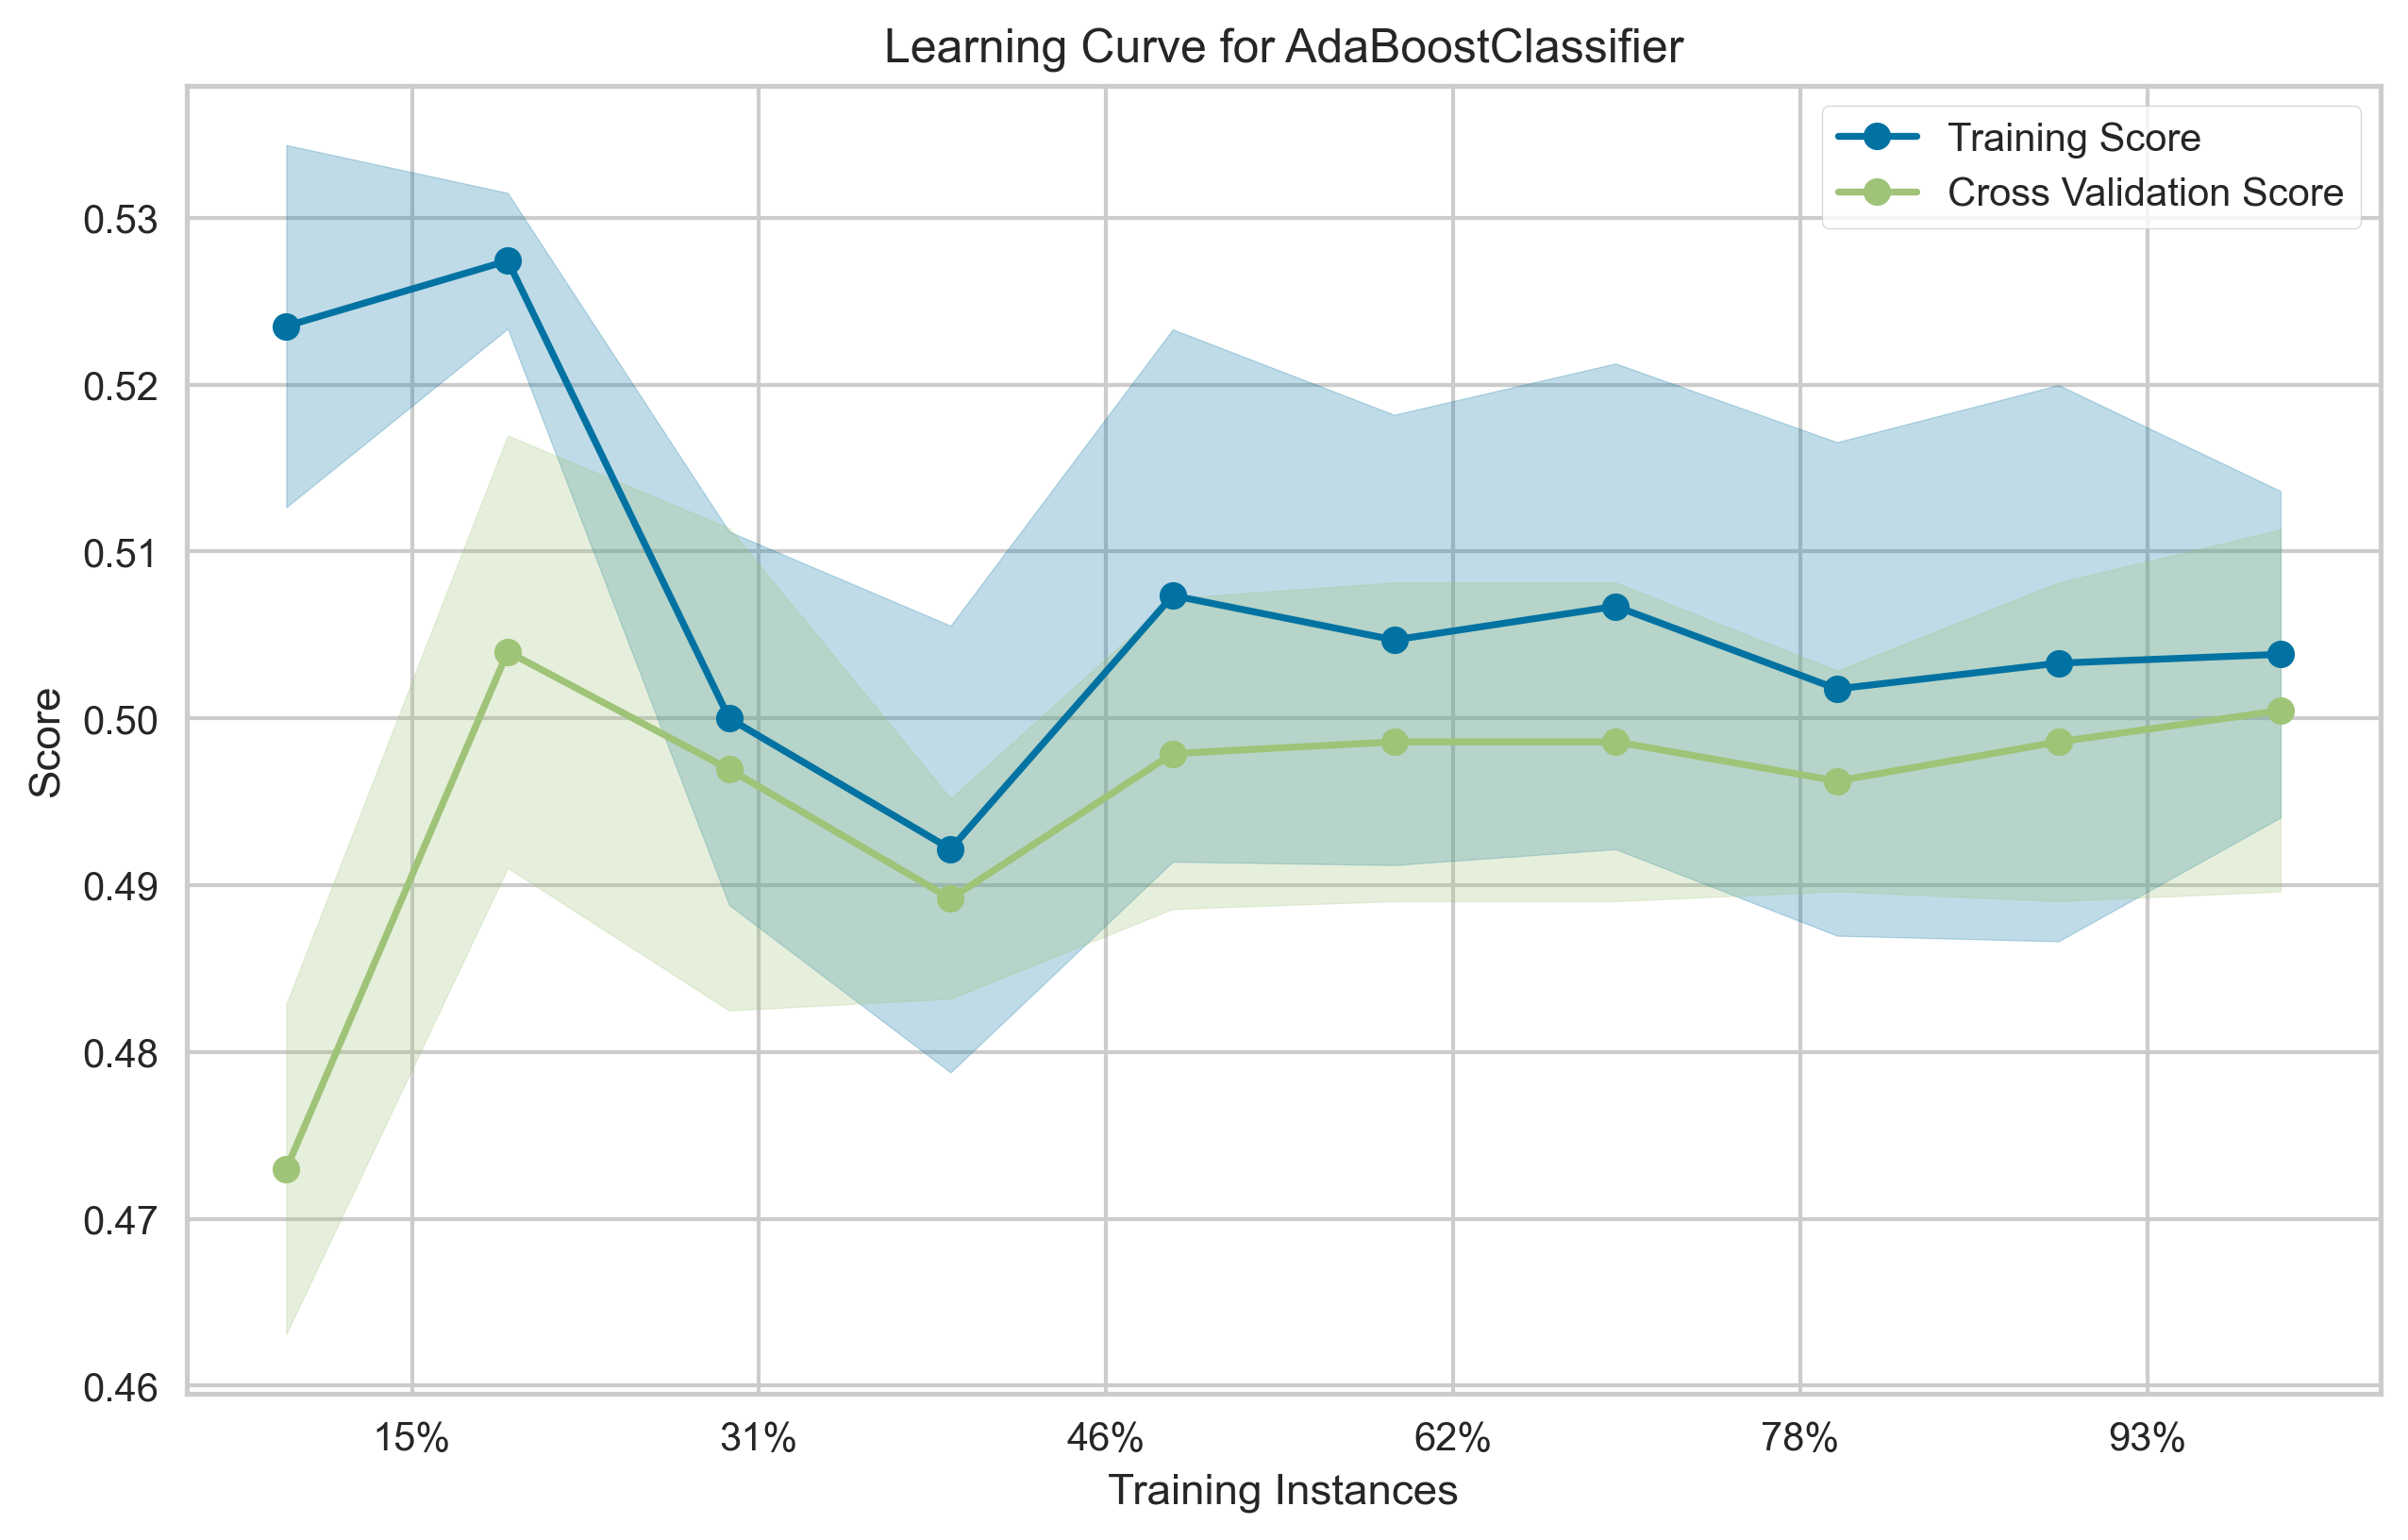

In [34]:
best_boost_clf = instantiate_best_boost_clf()
viz.learning_curve(clf=best_boost_clf,
                   X_tr=X_train,
                   y_tr=y_train,
                   cv=CV,
                   output_path=f"{WINE_BOOST_PATH}/boost_learning_curve.png", scoring=F1_SCORE)

/Users/pavponn/opt/anaconda3/envs/assignment-1/lib/python3.10/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


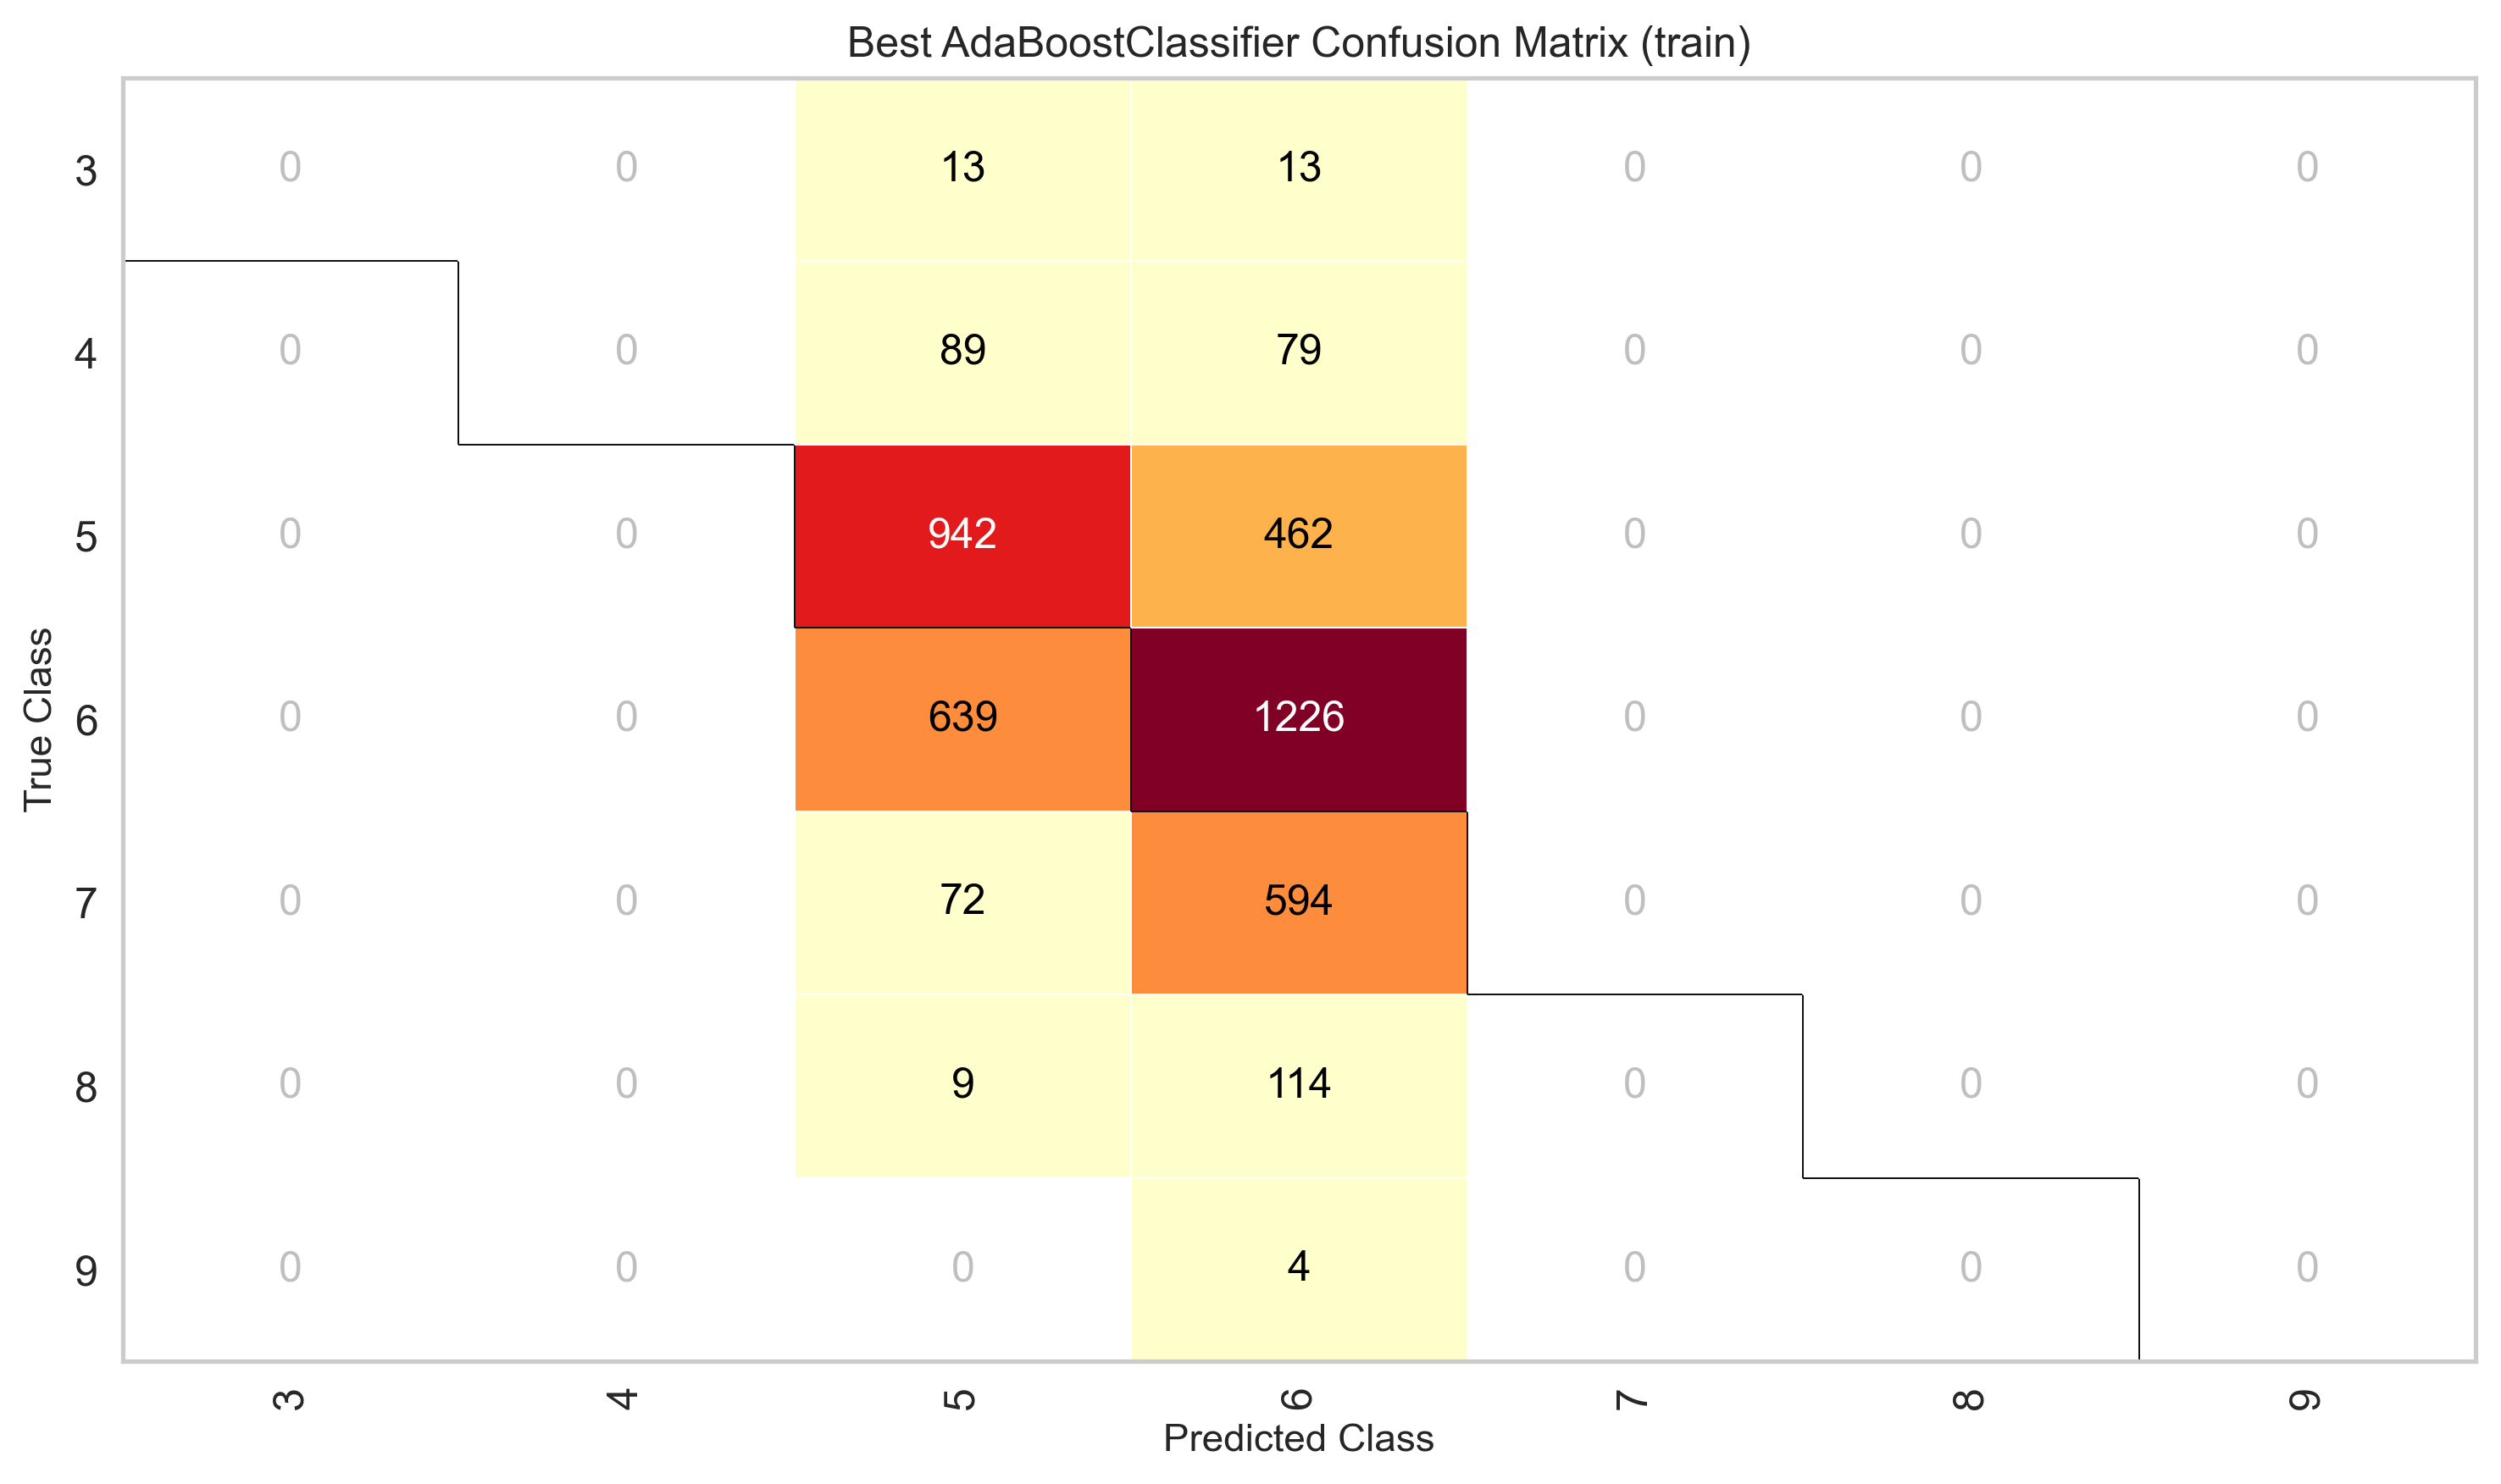

In [35]:
best_boost_clf = instantiate_best_boost_clf()
best_boost_clf.fit(X_train, y_train)
viz.confusion_matrix(
    clf=best_boost_clf,
    X=X_train,
    y=y_train,
    title='Best AdaBoostClassifier Confusion Matrix (train)',
    output_path=f'{WINE_BOOST_PATH}/best_boost_train_confusion_matrix.png',
)


/Users/pavponn/opt/anaconda3/envs/assignment-1/lib/python3.10/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


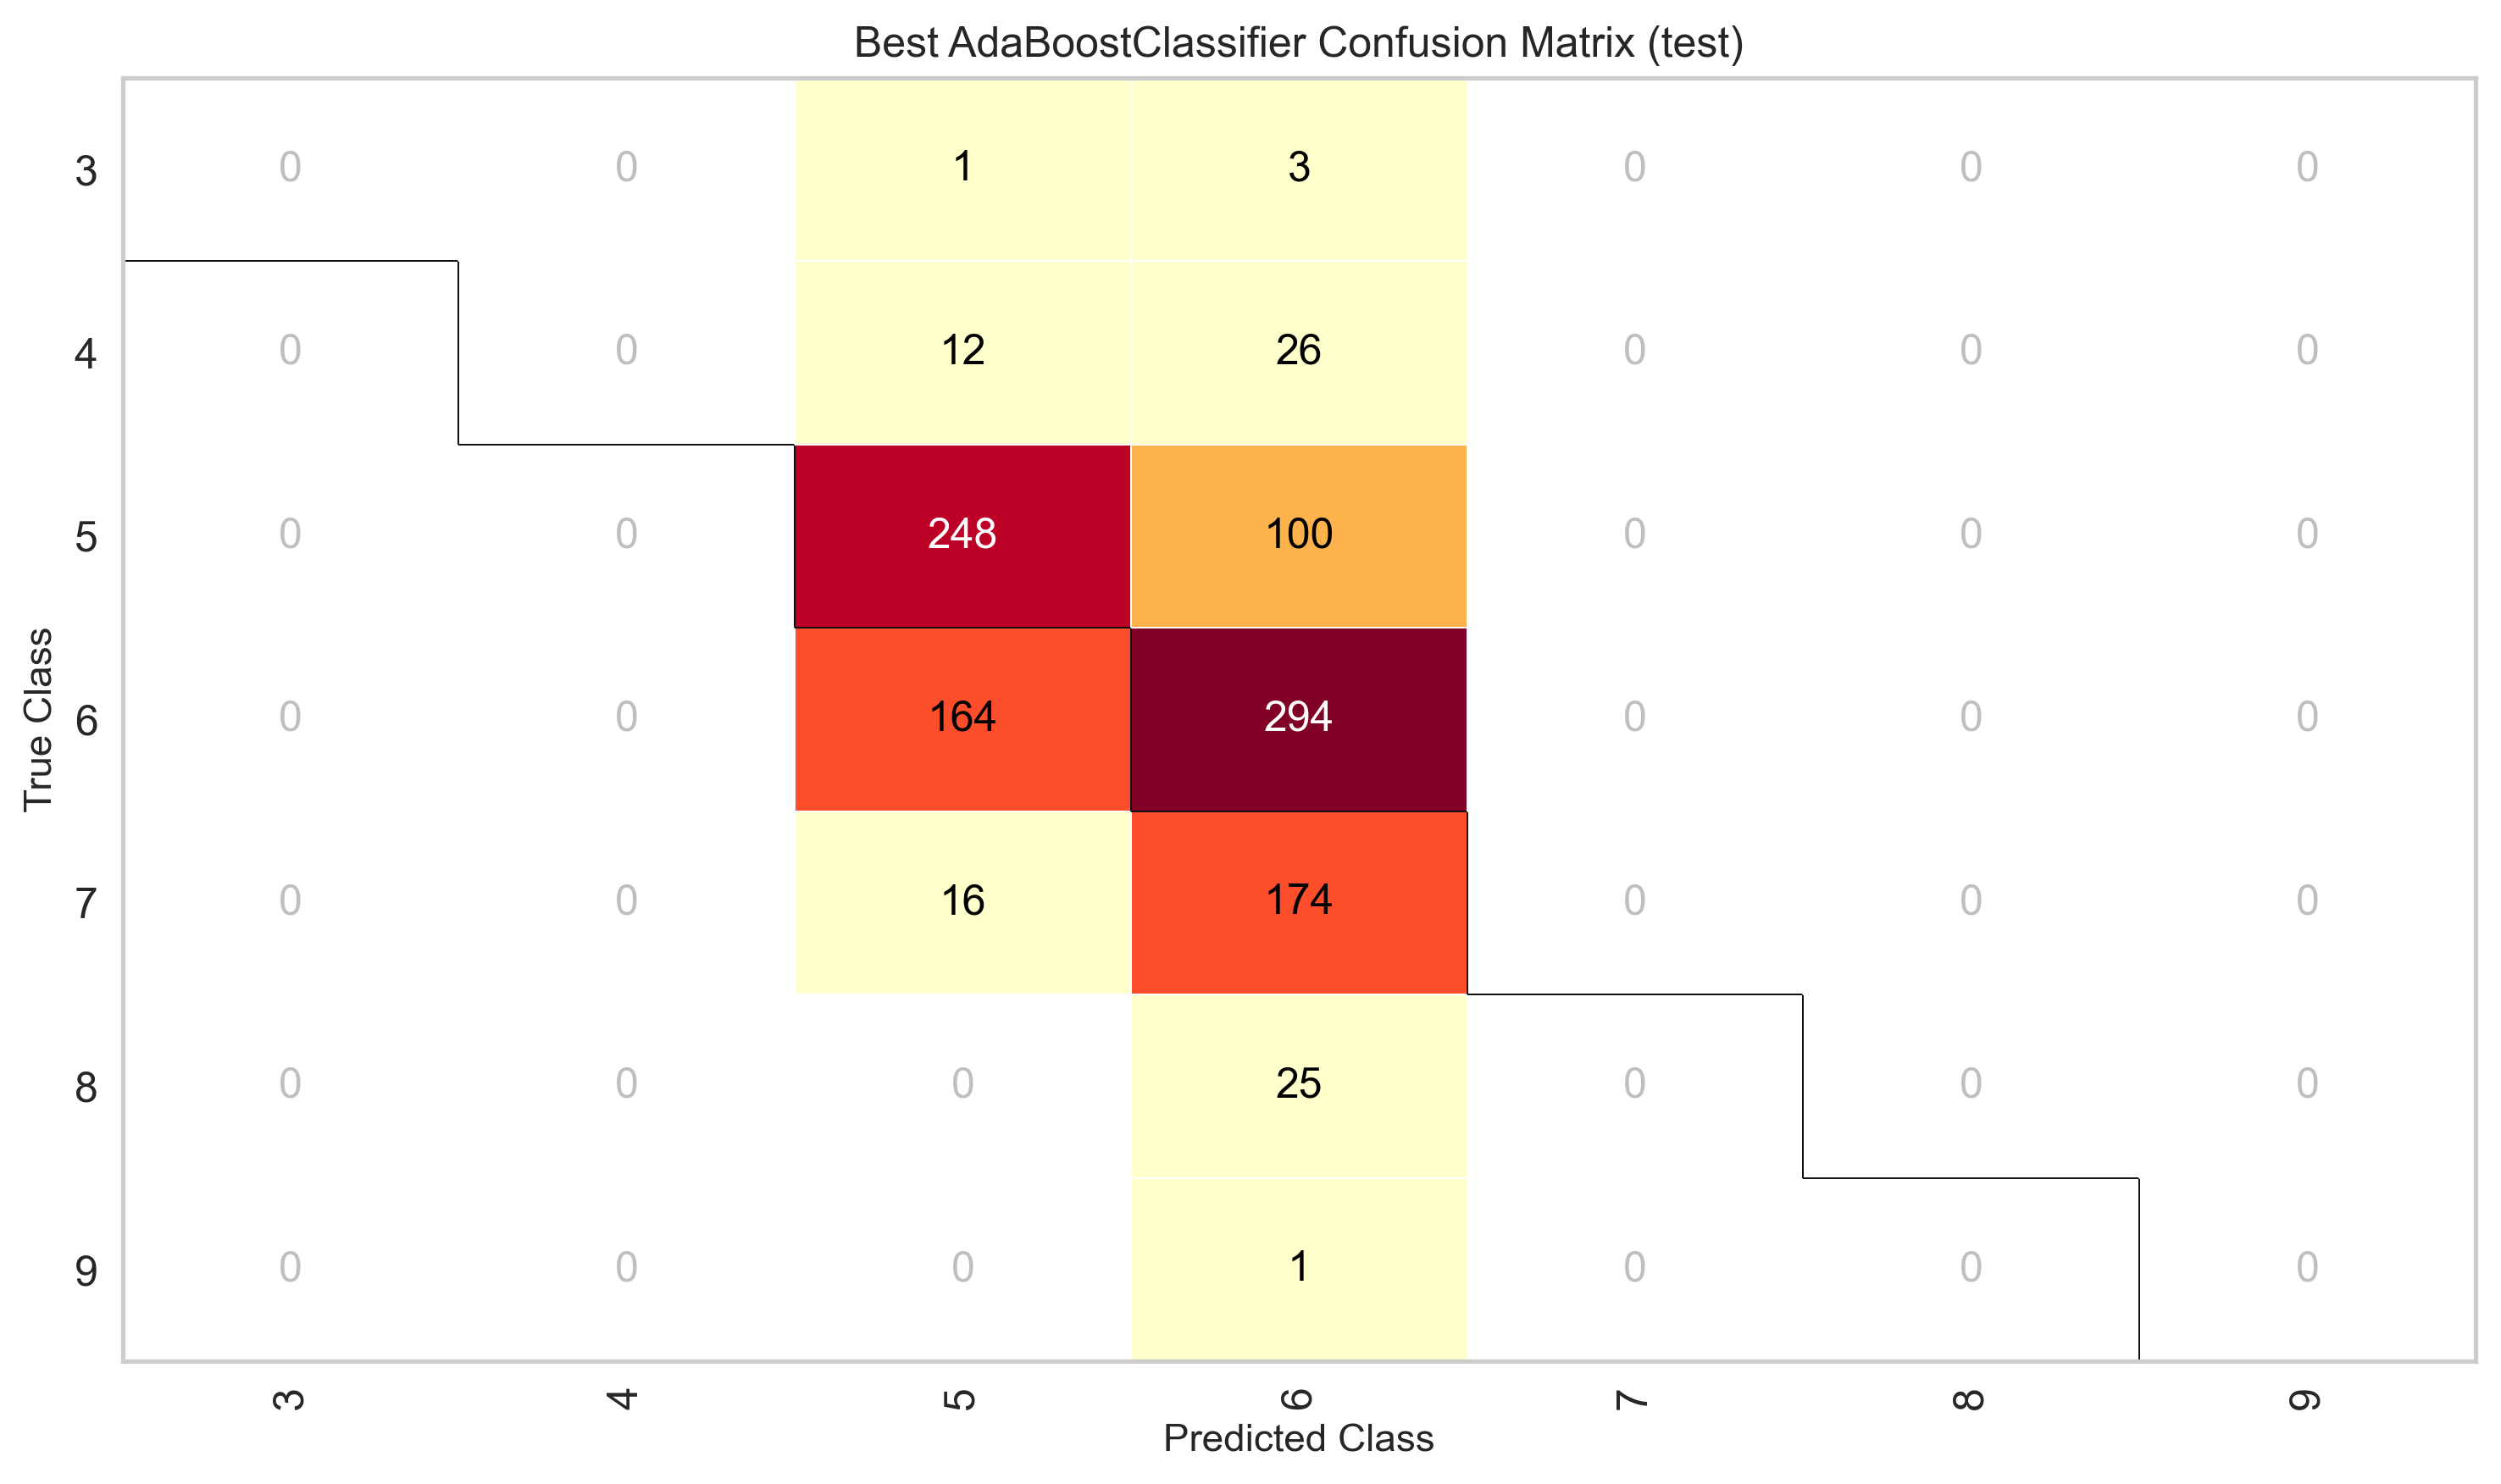

In [36]:
viz.confusion_matrix(
    clf=best_boost_clf,
    X=X_test,
    y=y_test,
    title='Best AdaBoostClassifier Confusion Matrix (test)',
    output_path=f'{WINE_BOOST_PATH}/best_boost_test_confusion_matrix.png',
)

In [37]:
metrics.f1_score_stats(clf=best_boost_clf, X_tr=X_train, X_t=X_test, y_tr=y_train, y_t=y_test, averaging=F1_AVERAGING)

F1-Score, micro (train): 0.5094
F1-Score, micro (test) : 0.5094


In [38]:
best_boost_clf = instantiate_best_boost_clf()
training.learning_time_stats(best_boost_clf,
                             X_tr=X_train,
                             y_tr=y_train,
                             )

Training time, total: 0.5150 seconds
Training time, normalized (per 1000 samples): 0.1210 seconds


In [39]:
best_boost_clf = instantiate_best_boost_clf()
best_boost_clf.fit(X_train, y_train)
training.inference_time_stats(best_boost_clf, X_train, proba=False, dataset_name='train')
training.inference_time_stats(best_boost_clf, X_test, proba=False, dataset_name='test')
training.inference_time_stats(best_boost_clf, X_all, proba=False, dataset_name='all')


Inference time (train), total: 0.0737 seconds
Inference time (train), normalized (per 1000 samples): 0.0173 seconds
Inference time (test), total: 0.0257 seconds
Inference time (test), normalized (per 1000 samples): 0.0242 seconds
Inference time (all), total: 0.0886 seconds
Inference time (all), normalized (per 1000 samples): 0.0166 seconds


# K-NN

### Plan

1. Train baseline boosting without hyperparameter tuning, look at the precision/recall at train and test sets
2. Validate how different individual hyperparameters affect performance of the model wrt recall@precision
    a. `K`
    b. `p`in minkowski metric
3. Perform hyperparameter tuning of multiple parameters
4. Analyse performance of the best decision tree with hyperparameter tuning

In [40]:
WINE_KNN_PATH = f'{WINE_PATH}/knn'

In [96]:
knn_baseline_clf = KNeighborsClassifier()
knn_baseline_clf.fit(X_train_n, y_train)

KNeighborsClassifier()

/Users/pavponn/opt/anaconda3/envs/assignment-1/lib/python3.10/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


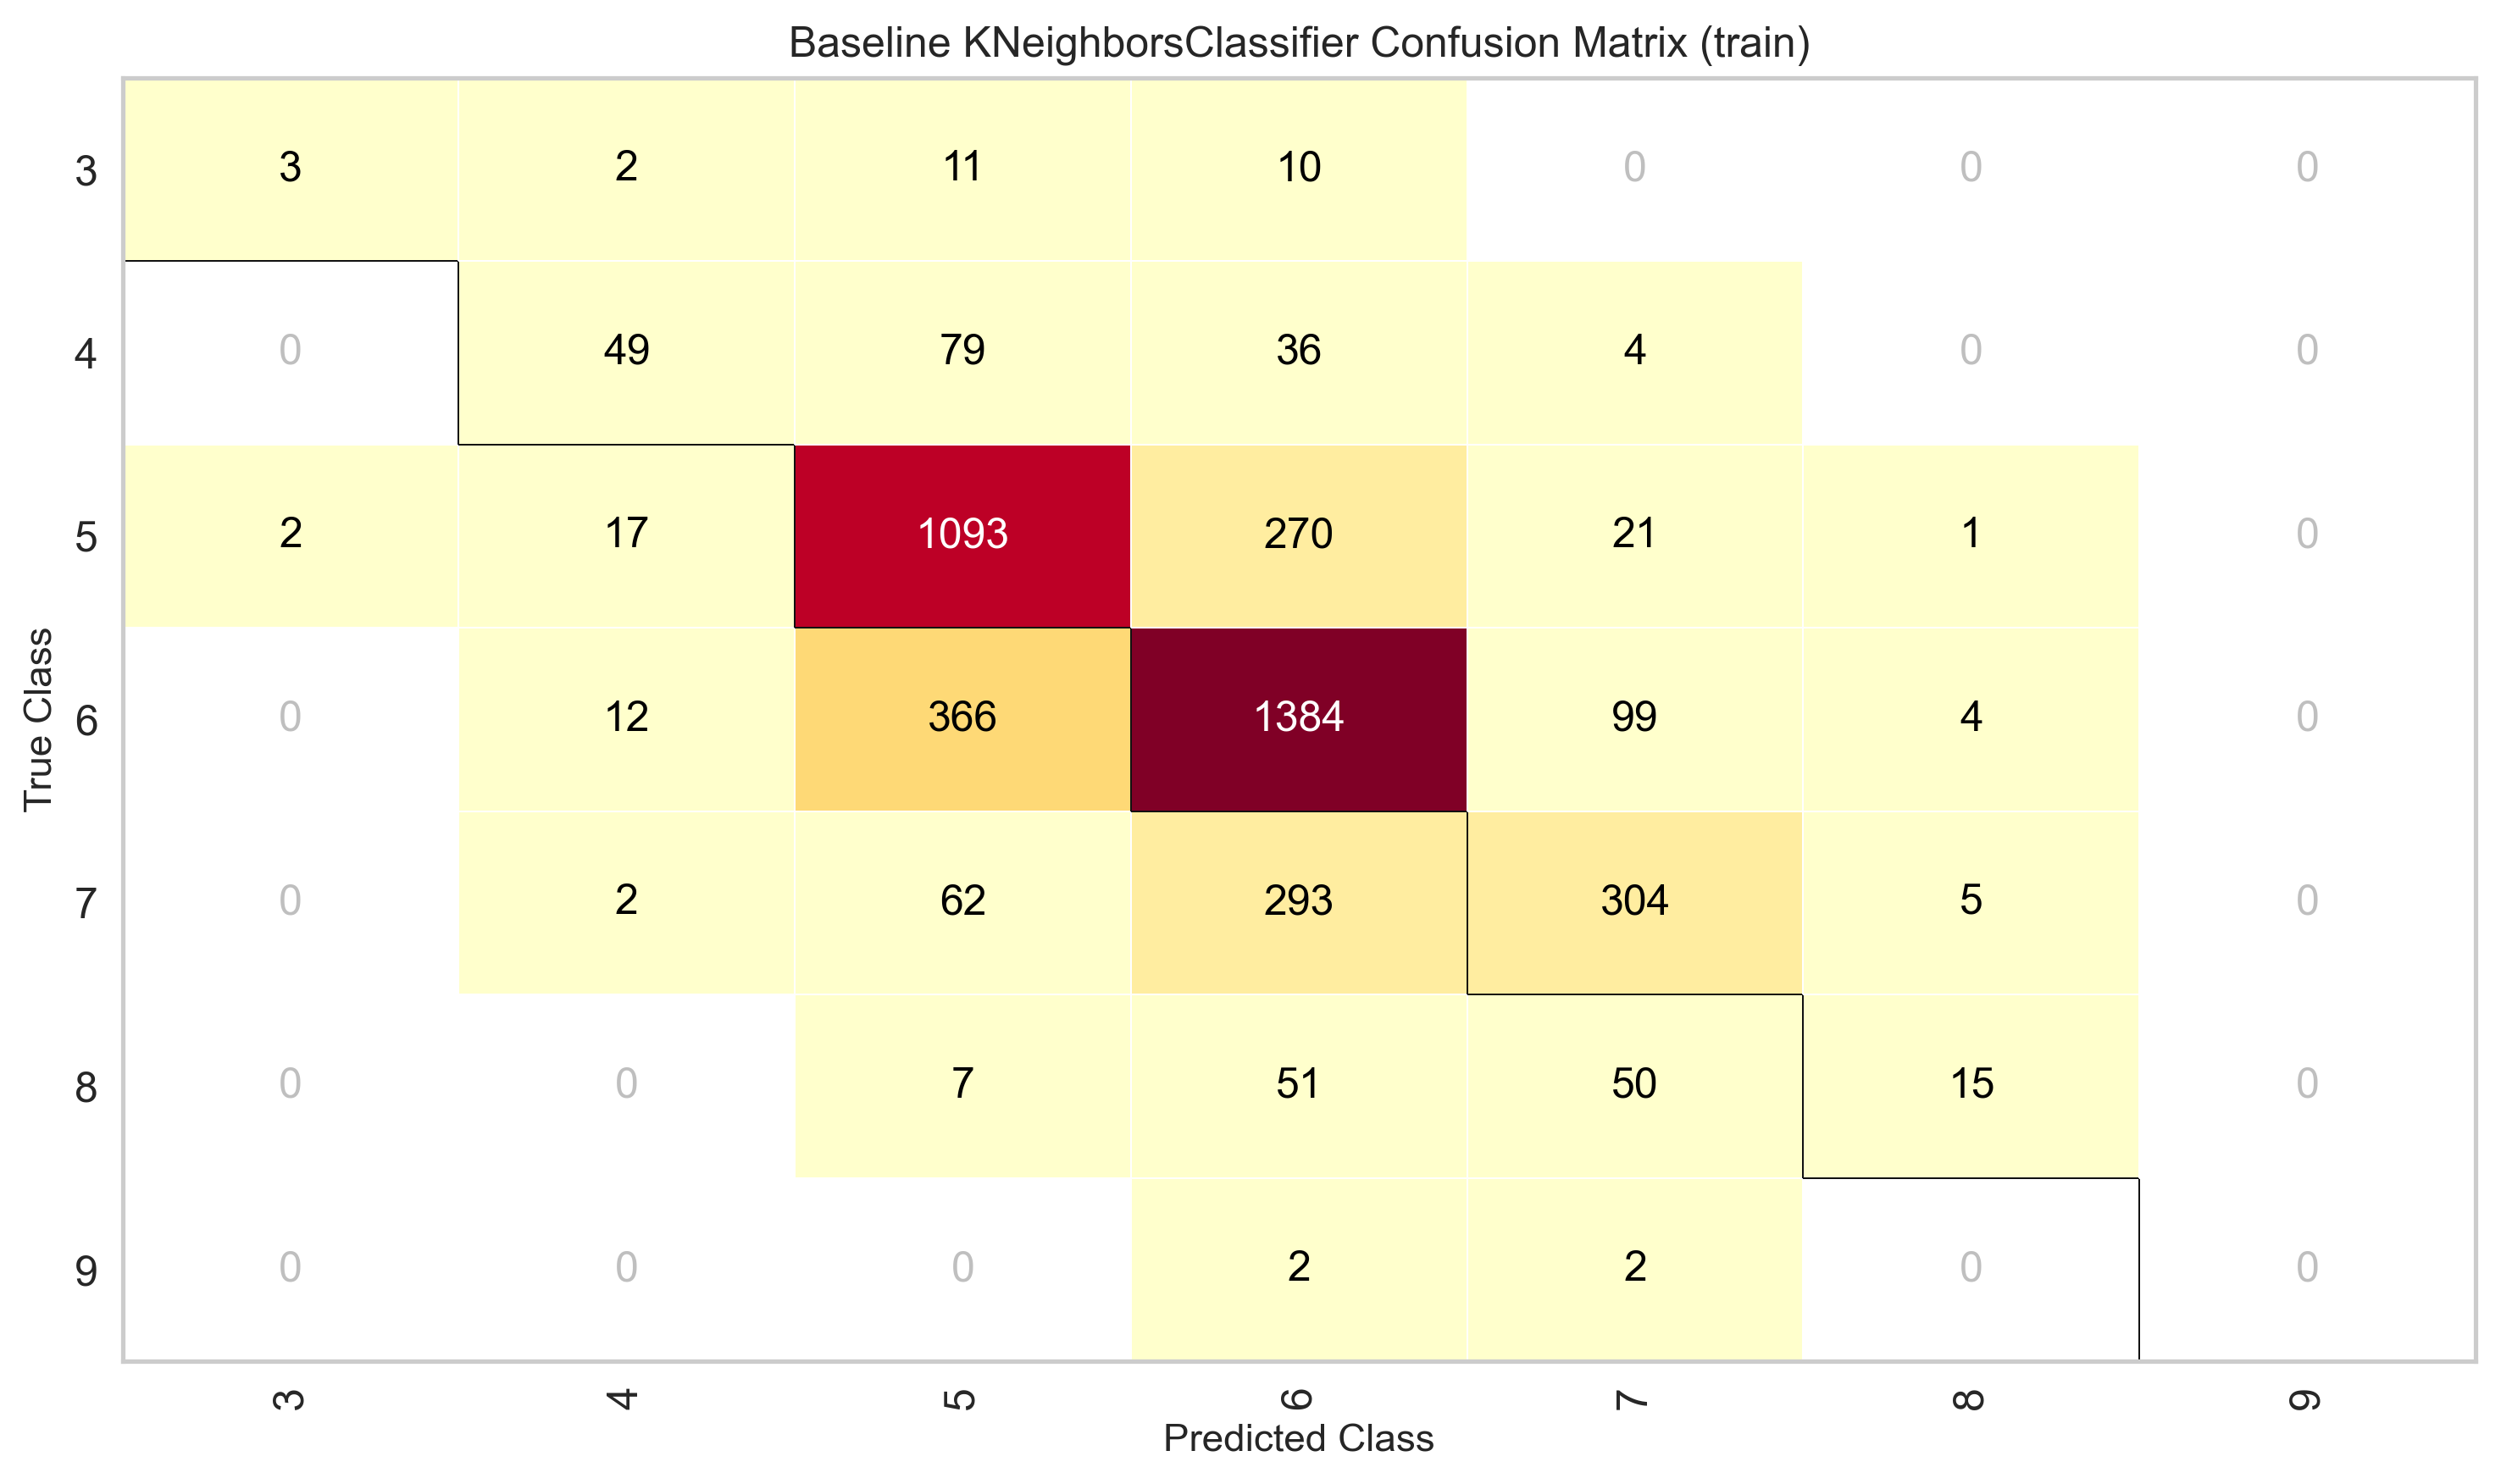

In [97]:
viz.confusion_matrix(
    clf=knn_baseline_clf,
    X=X_train_n,
    y=y_train,
    title='Baseline KNeighborsClassifier Confusion Matrix (train)',
    output_path=f'{WINE_KNN_PATH}/baseline_knn_train_confusion_matrix.png'
)

/Users/pavponn/opt/anaconda3/envs/assignment-1/lib/python3.10/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


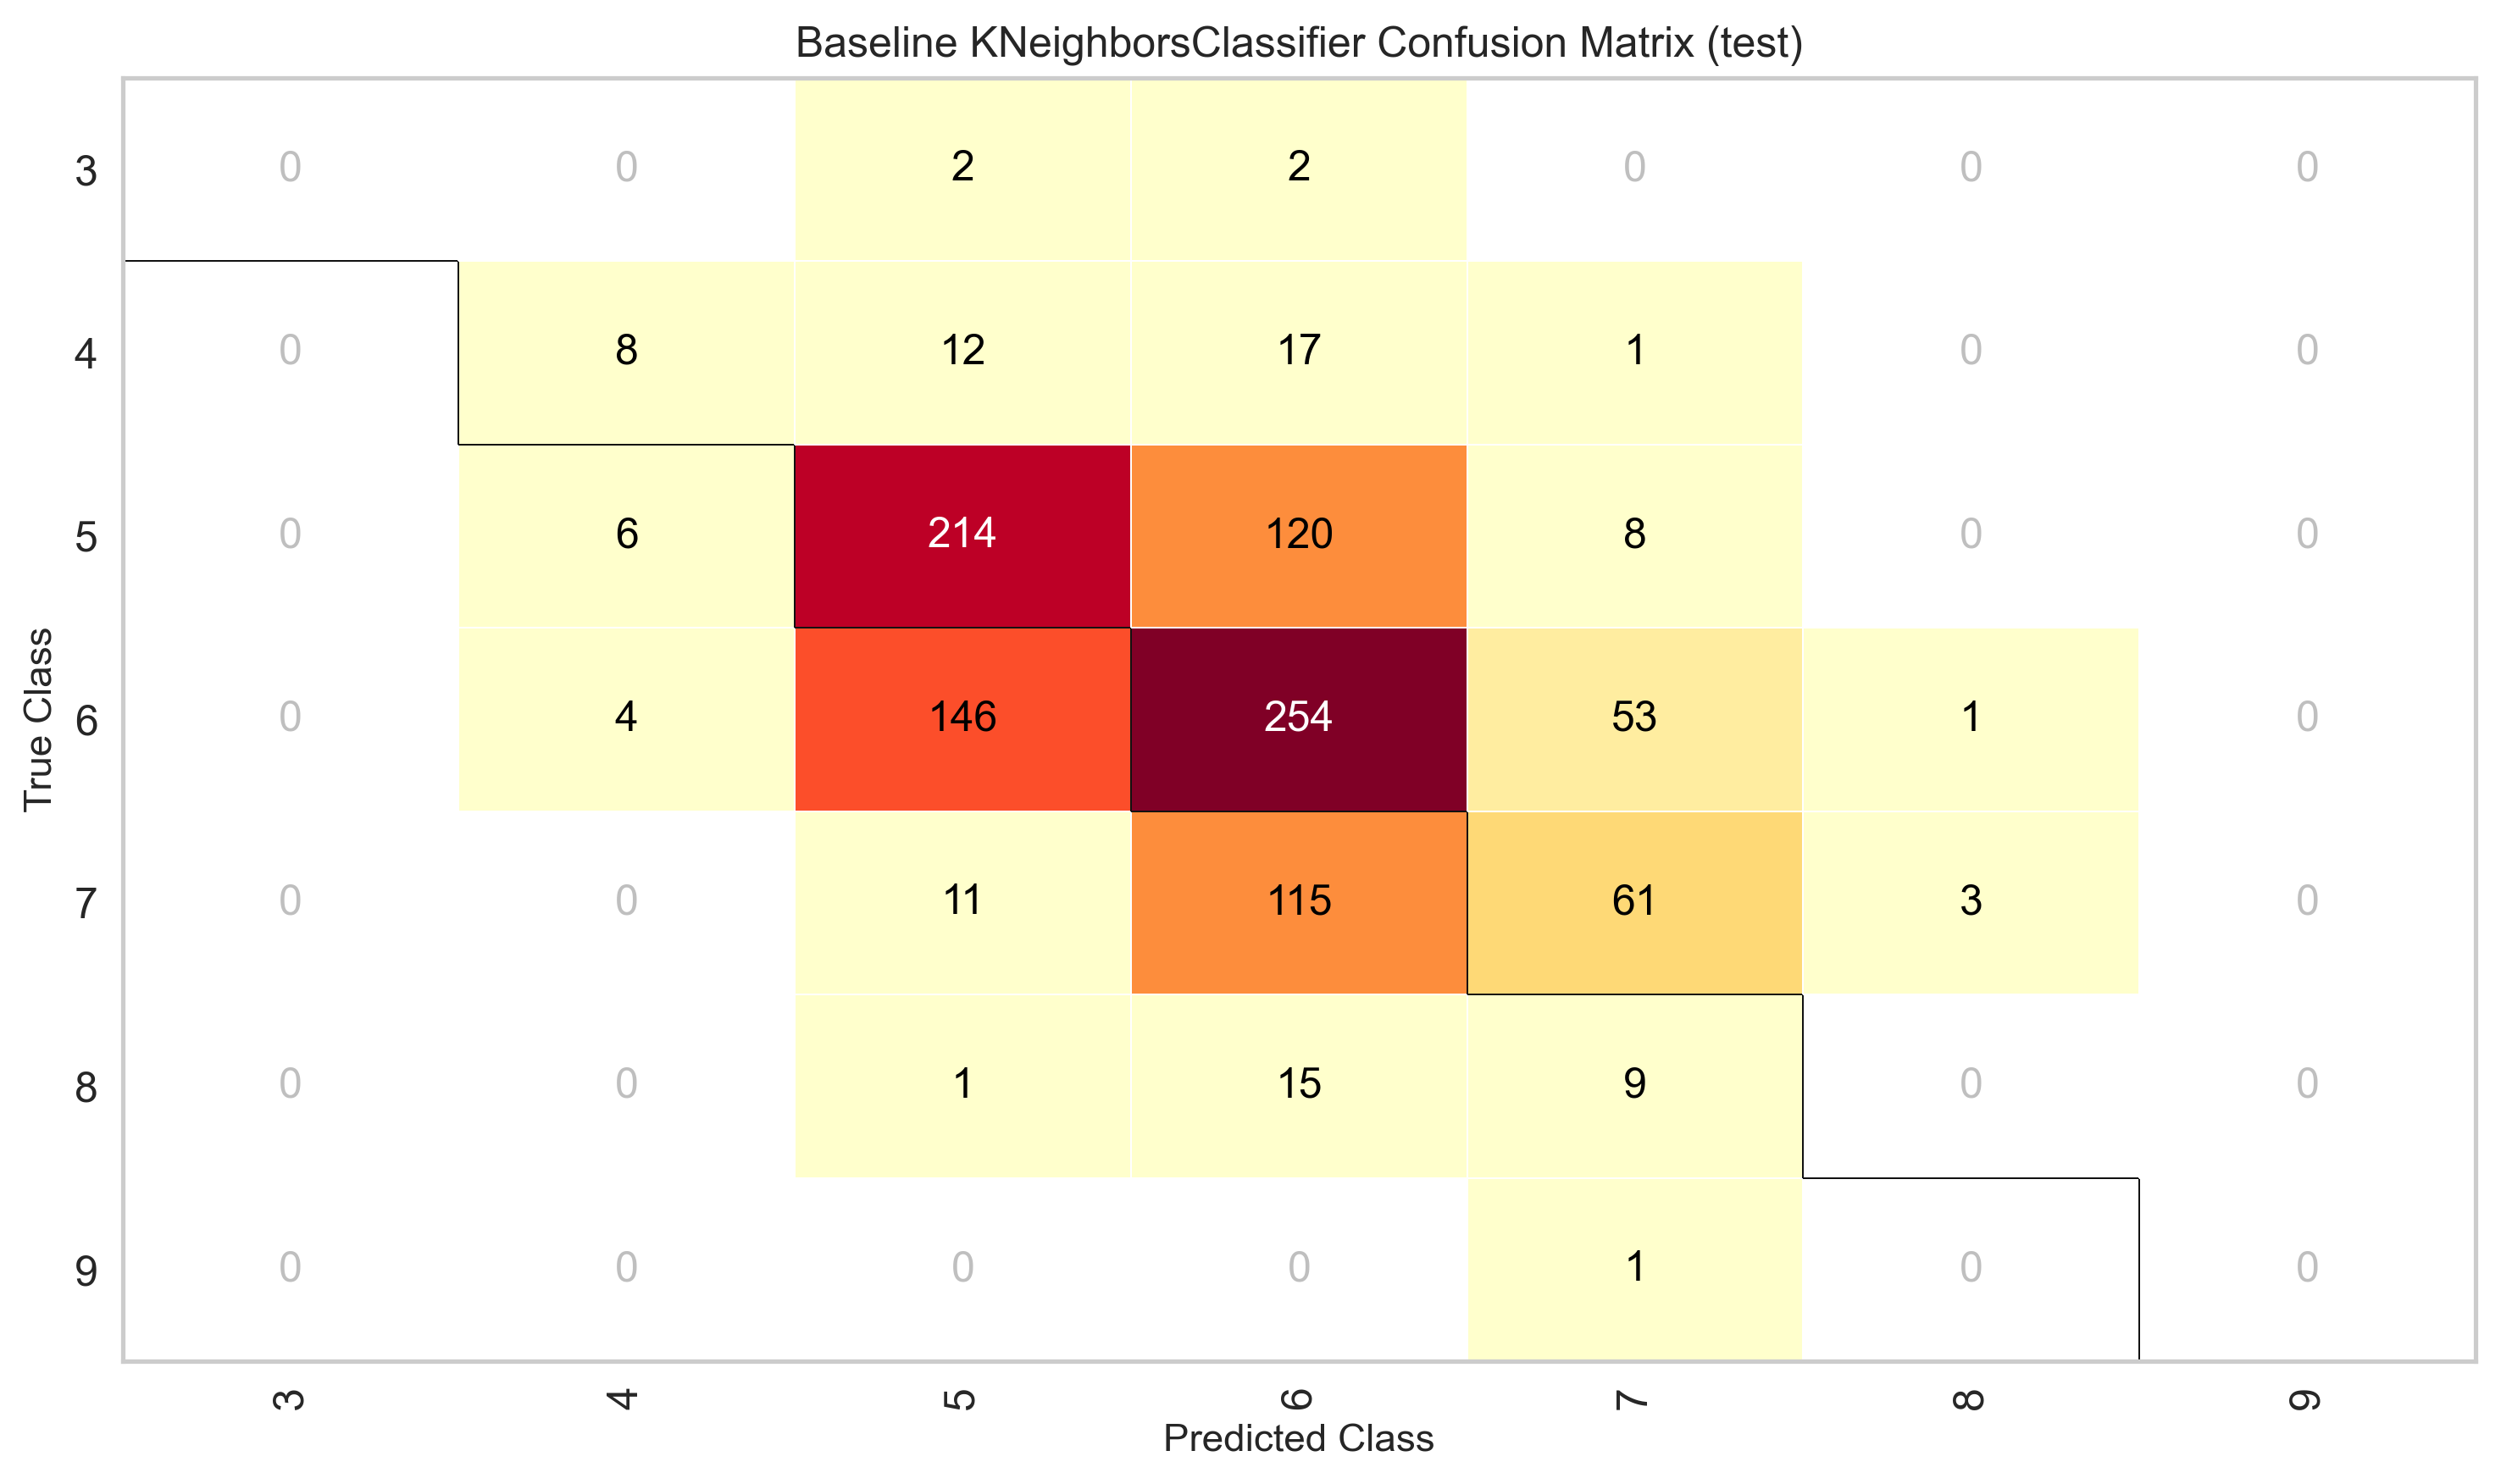

In [98]:
viz.confusion_matrix(
    clf=knn_baseline_clf,
    X=X_test_n,
    y=y_test,
    title='Baseline KNeighborsClassifier Confusion Matrix (test)',
    output_path=f'{WINE_KNN_PATH}/baseline_knn_test_confusion_matrix.png'
)

In [99]:
metrics.f1_score_stats(clf=knn_baseline_clf, X_tr=X_train_n, X_t=X_test_n, y_tr=y_train, y_t=y_test,
                       averaging=F1_AVERAGING)


F1-Score, micro (train): 0.6692
F1-Score, micro (test) : 0.5047


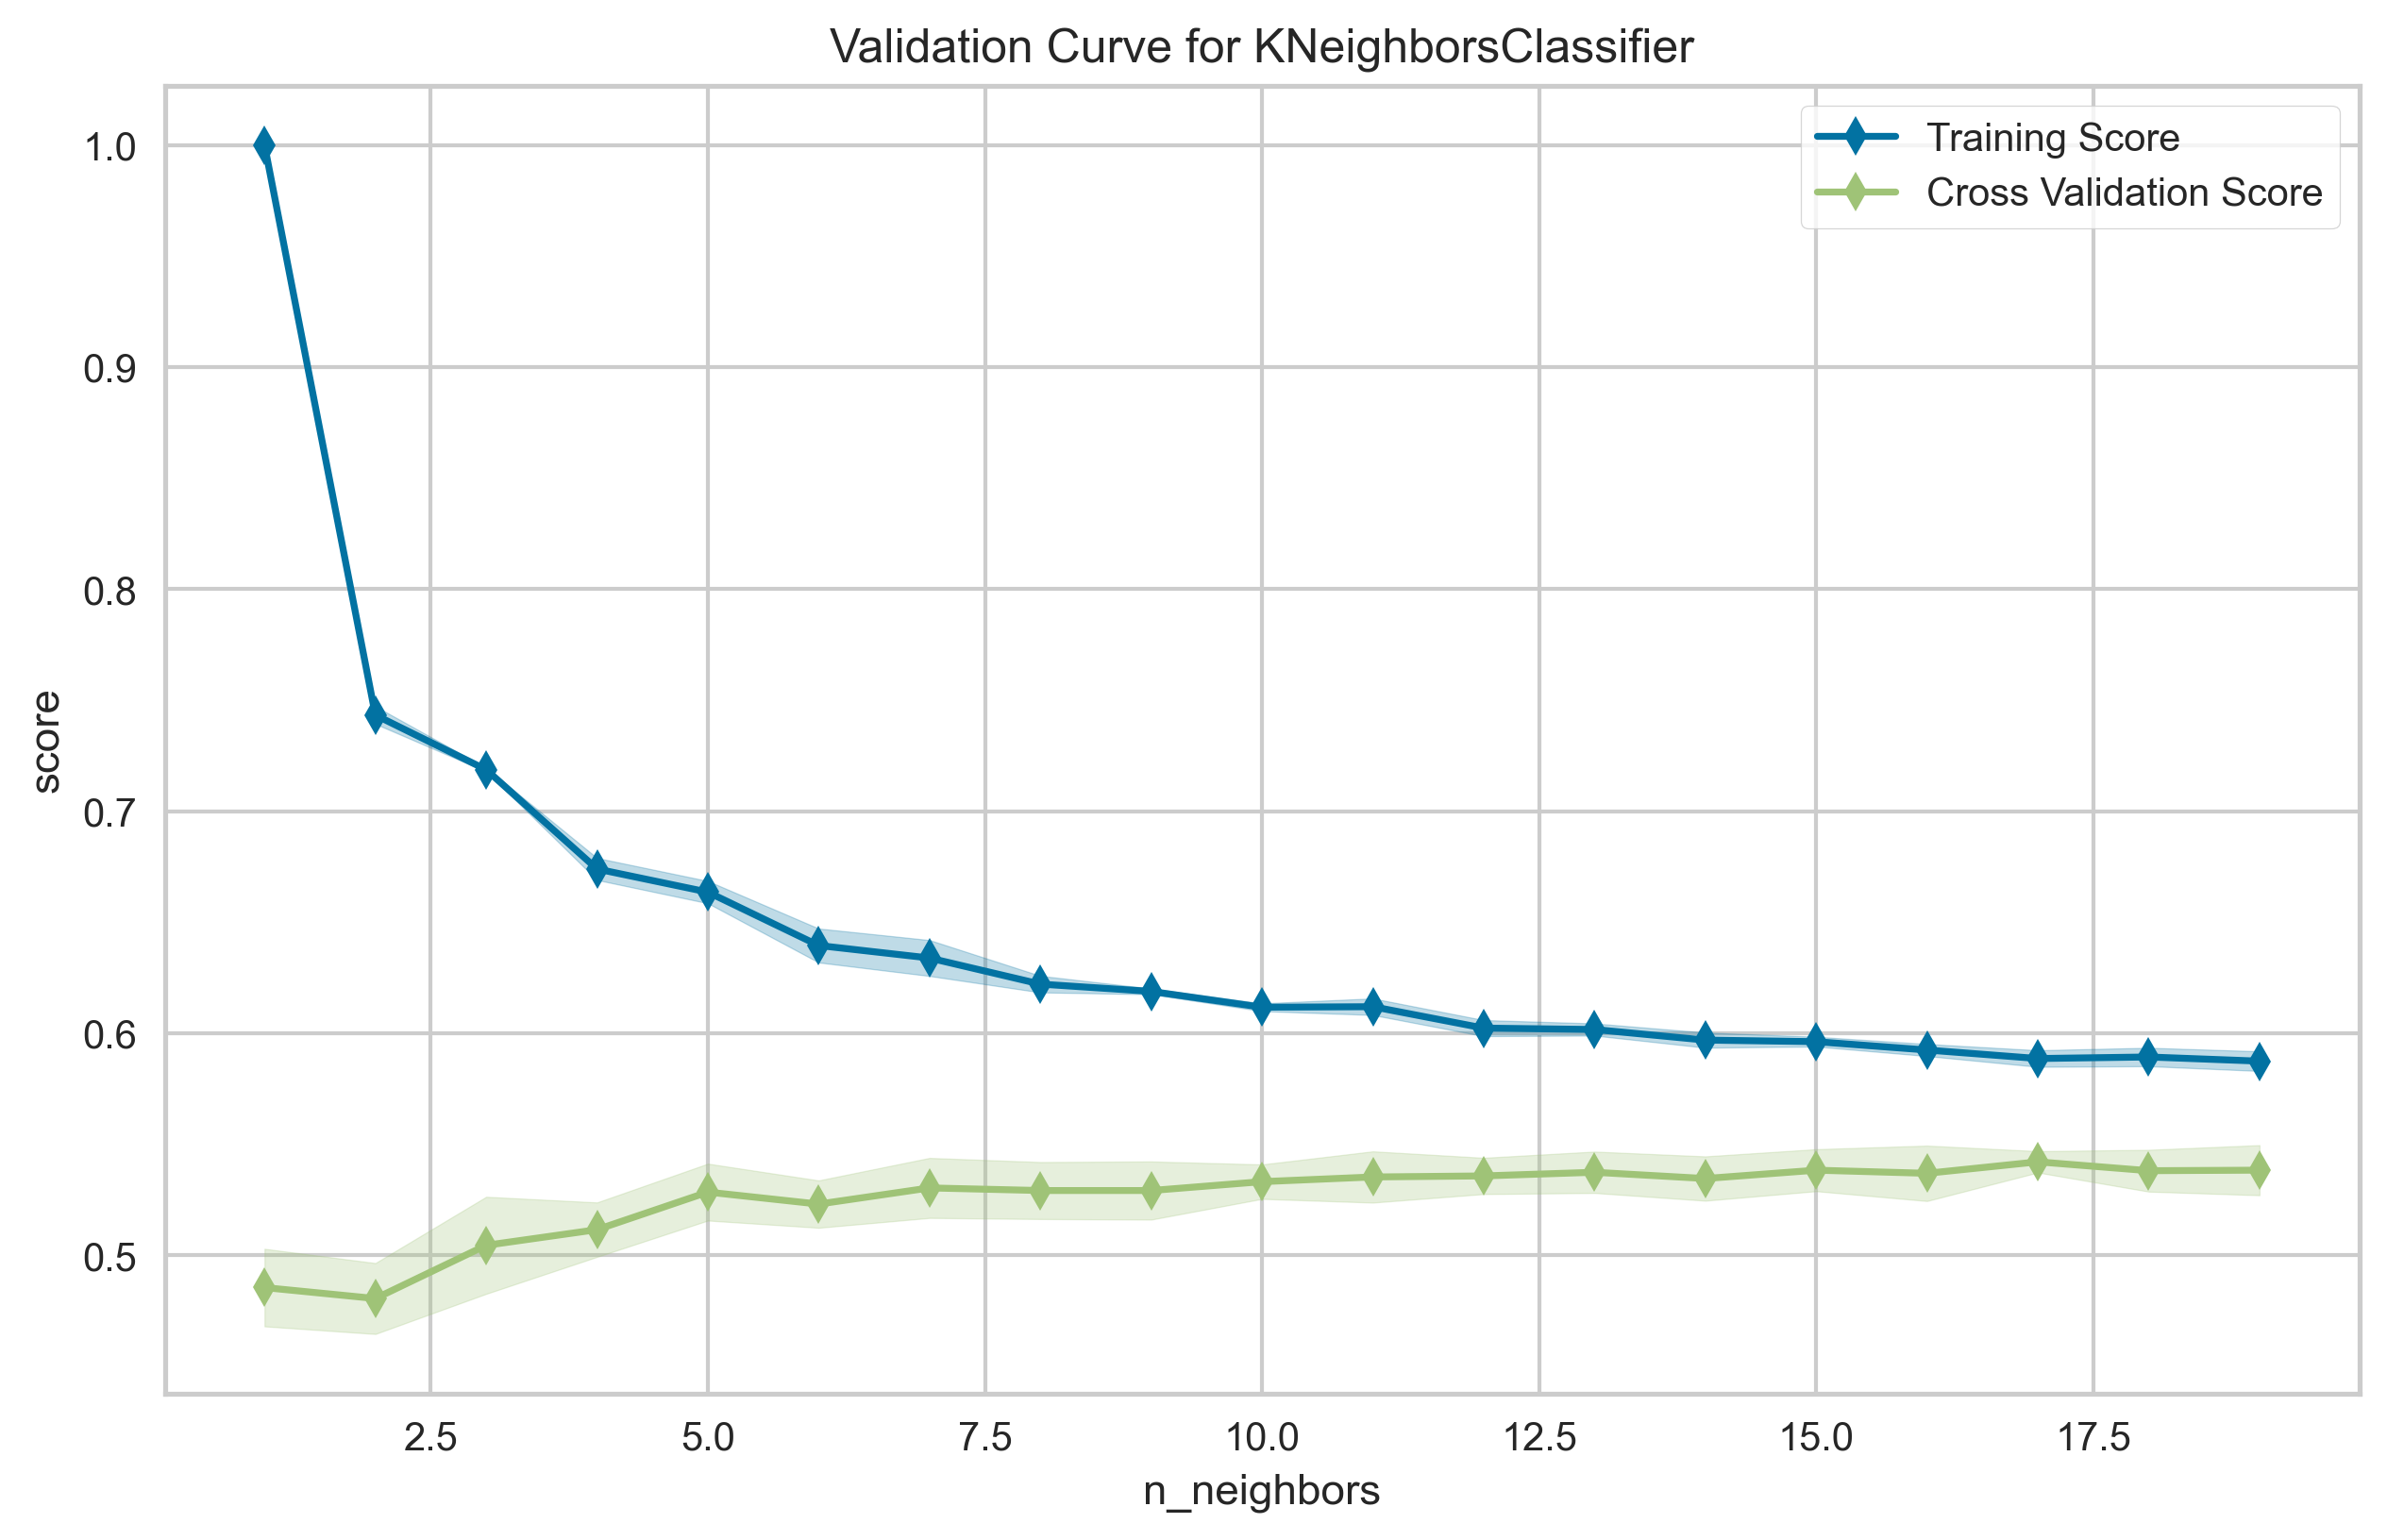

In [45]:
knn_clf = KNeighborsClassifier()
viz.validation_curve(
    clf=knn_clf,
    X_tr=X_train_n,
    y_tr=y_train,
    cv=CV,
    param_name="n_neighbors",
    param_range=np.arange(1, 20, 1),
    output_path=f"{WINE_KNN_PATH}/knn_n_neighbors.png",
    scoring=F1_SCORE,
)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


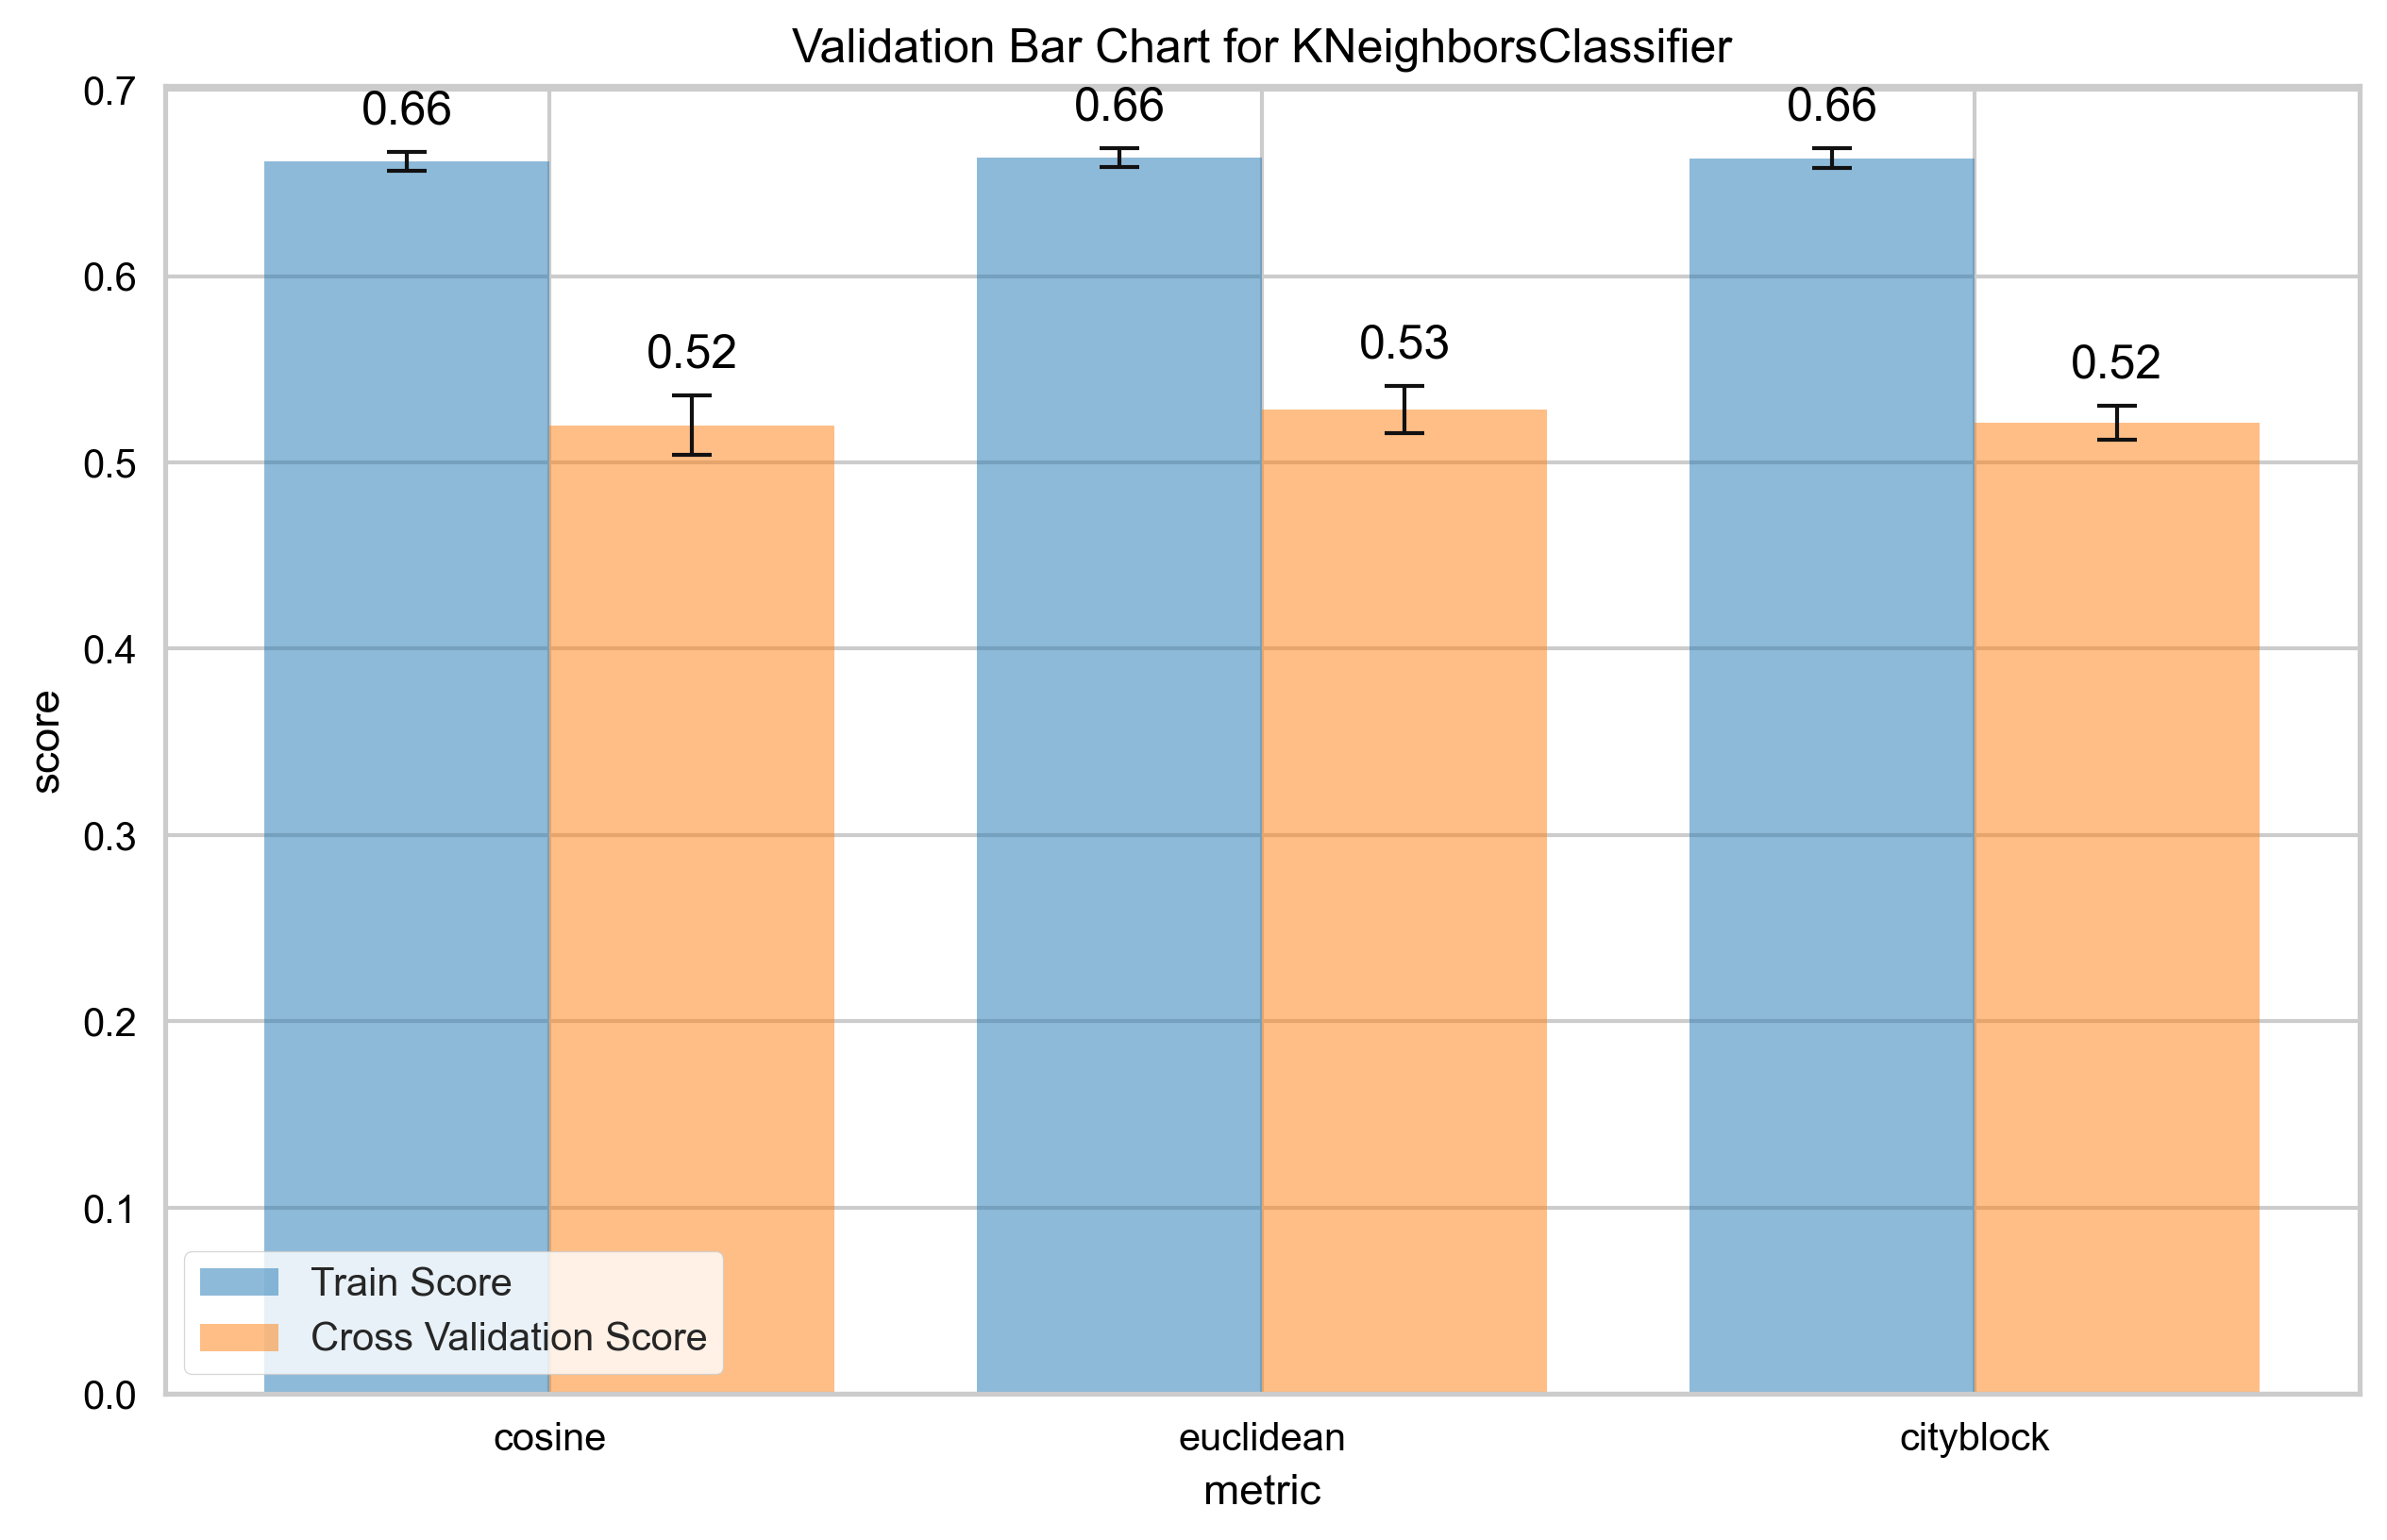

In [46]:
knn_clf = KNeighborsClassifier()
viz.validation_bar_chart(
    clf=knn_clf,
    X_tr=X_train_n,
    y_tr=y_train,
    cv=CV,
    param_name="metric",
    param_range=['cosine', 'euclidean', 'cityblock'],
    output_path=f"{WINE_KNN_PATH}/knn_metric.png",
    n_jobs=3,
    scoring=F1_SCORE
)

In [100]:
best_knn_params = training.perform_hyperparameter_tuning(
    clf=KNeighborsClassifier(),
    X_tr=X_train_n,
    y_tr=y_train,
    cv=CV,
    param_space={
        "n_neighbors": np.arange(1, 10, 1),
        "metric": ['cosine', 'euclidean', 'cityblock']
    },
    scoring=F1_SCORE,
)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [101]:
best_knn_params

{'metric': 'cosine', 'n_neighbors': 9}

In [102]:
def instantiate_best_knn_clf():
    return KNeighborsClassifier(n_neighbors=best_knn_params['n_neighbors'],
                                metric=best_knn_params['metric'])

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


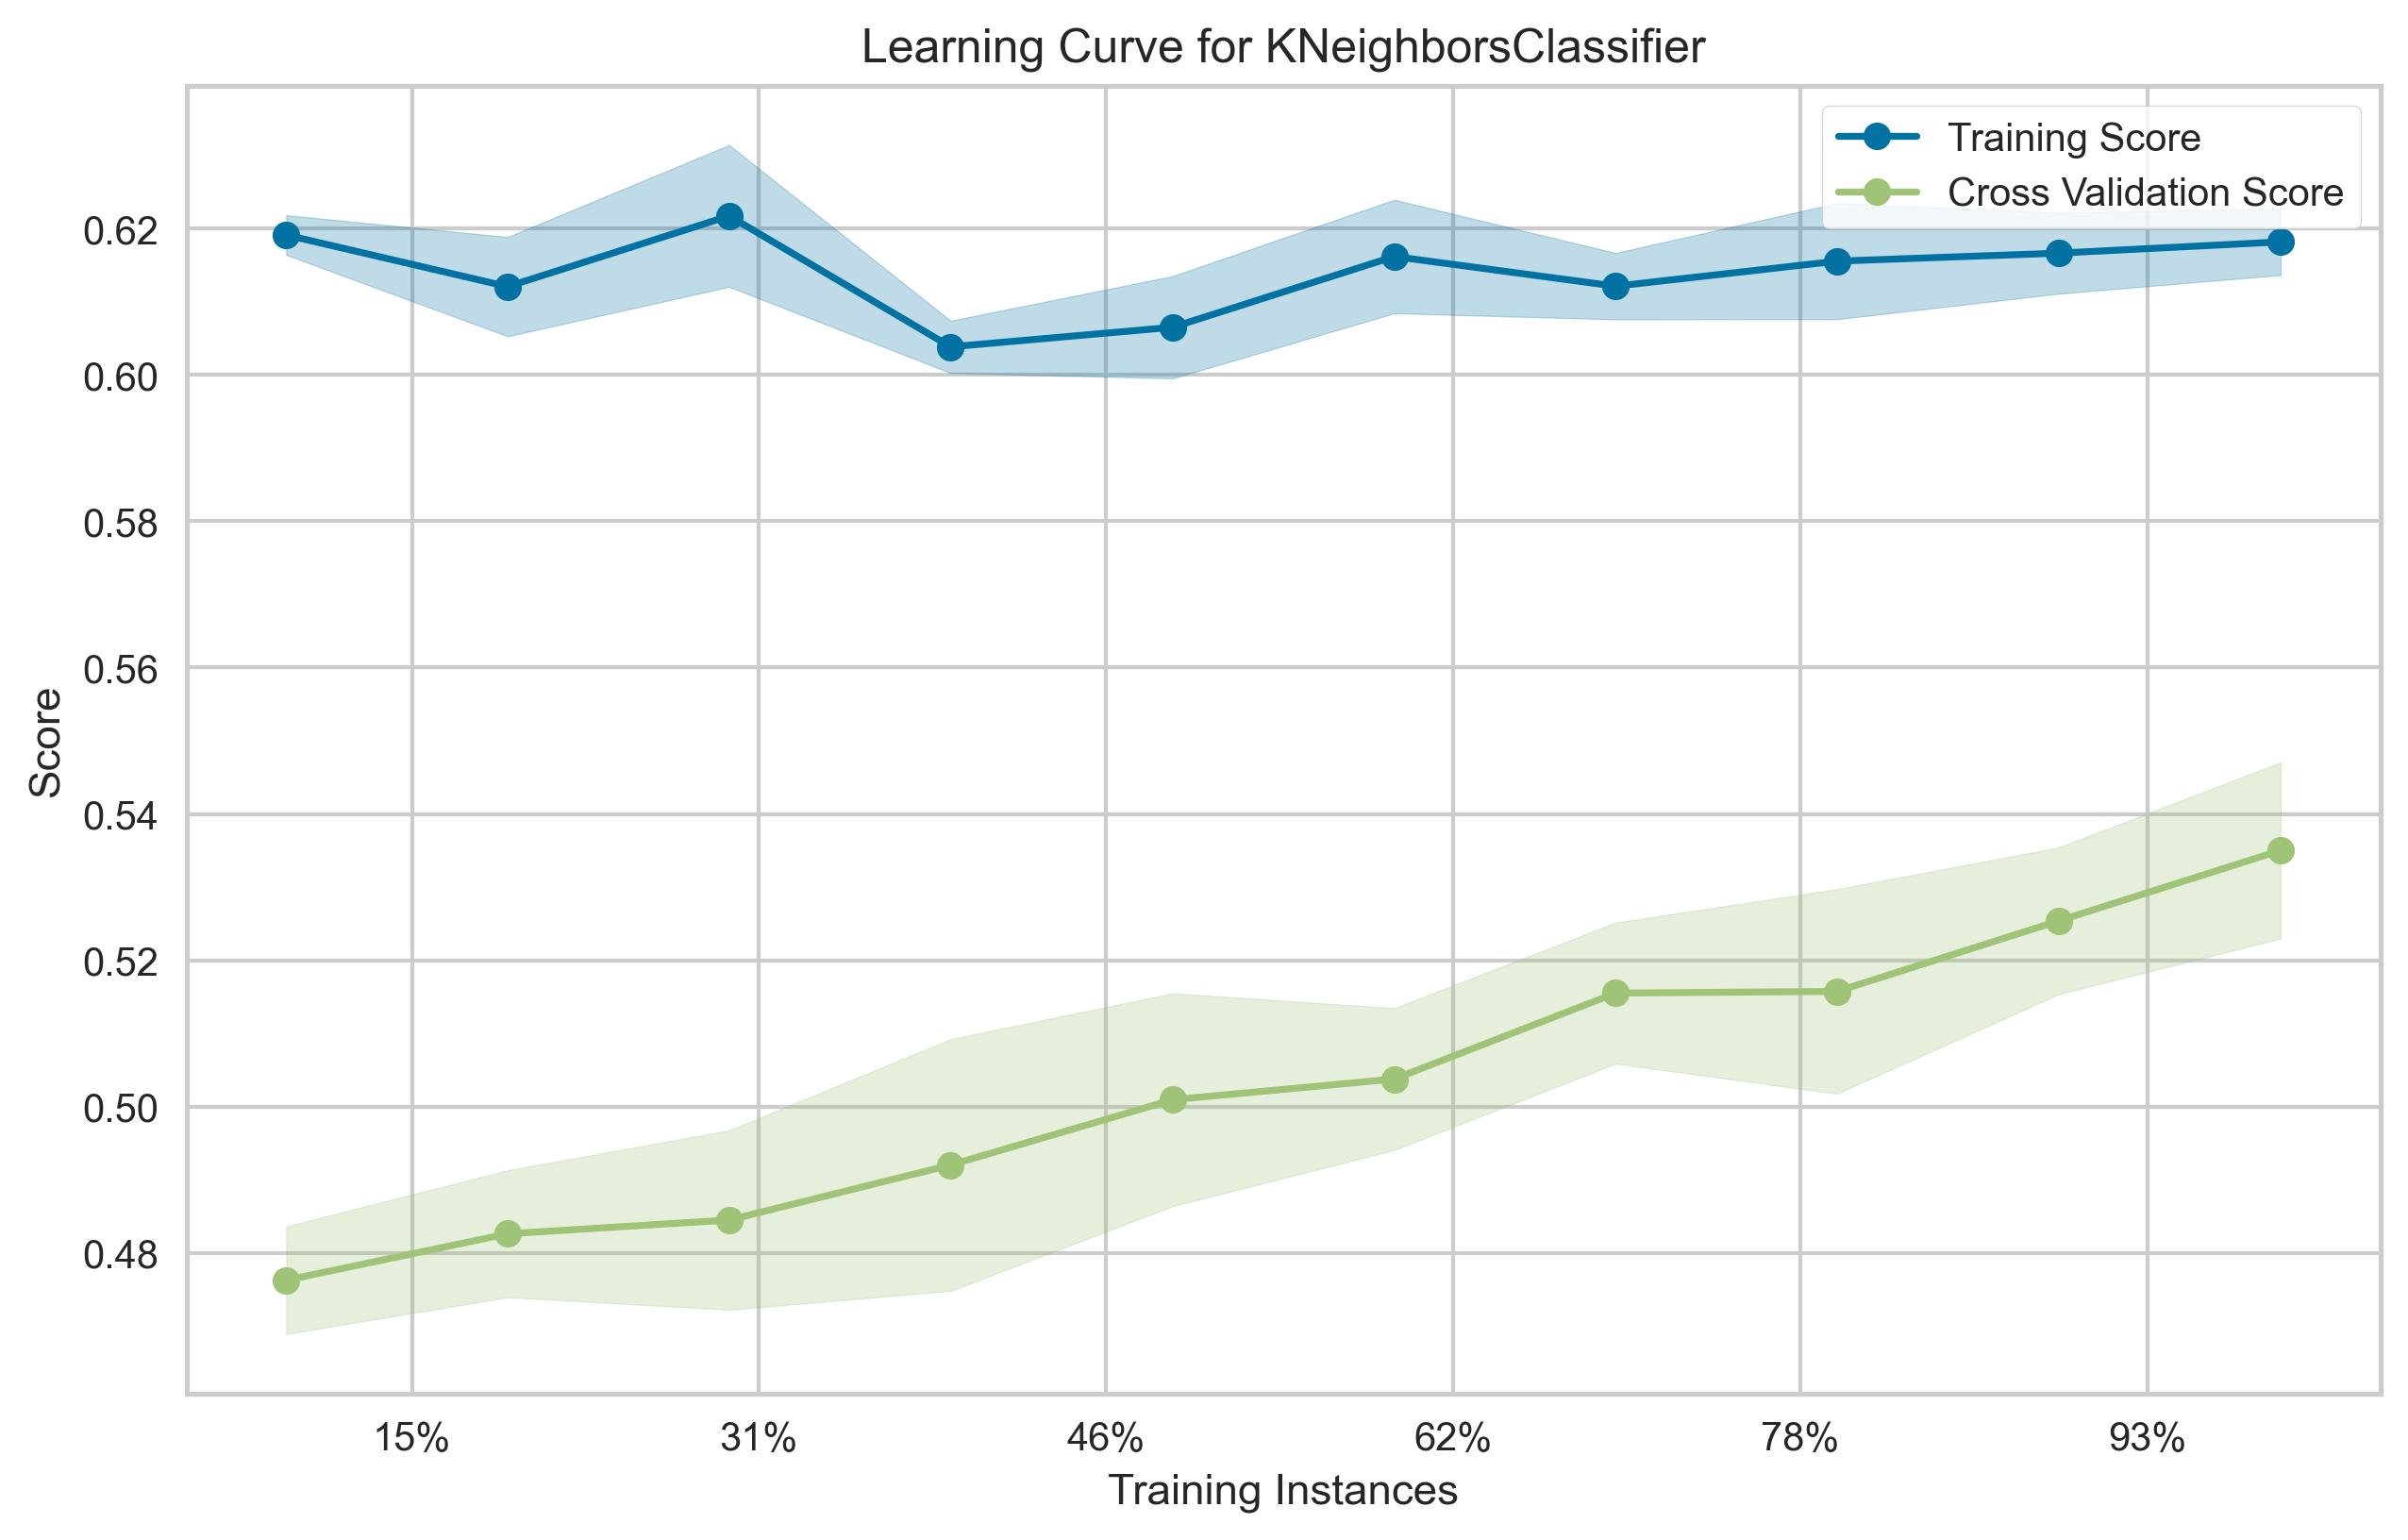

In [50]:
best_knn_clf = instantiate_best_knn_clf()
viz.learning_curve(clf=best_knn_clf,
                   X_tr=X_train_n,
                   y_tr=y_train,
                   cv=CV,
                   output_path=f"{WINE_KNN_PATH}/knn_learning_curve.png", scoring=F1_SCORE)

/Users/pavponn/opt/anaconda3/envs/assignment-1/lib/python3.10/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


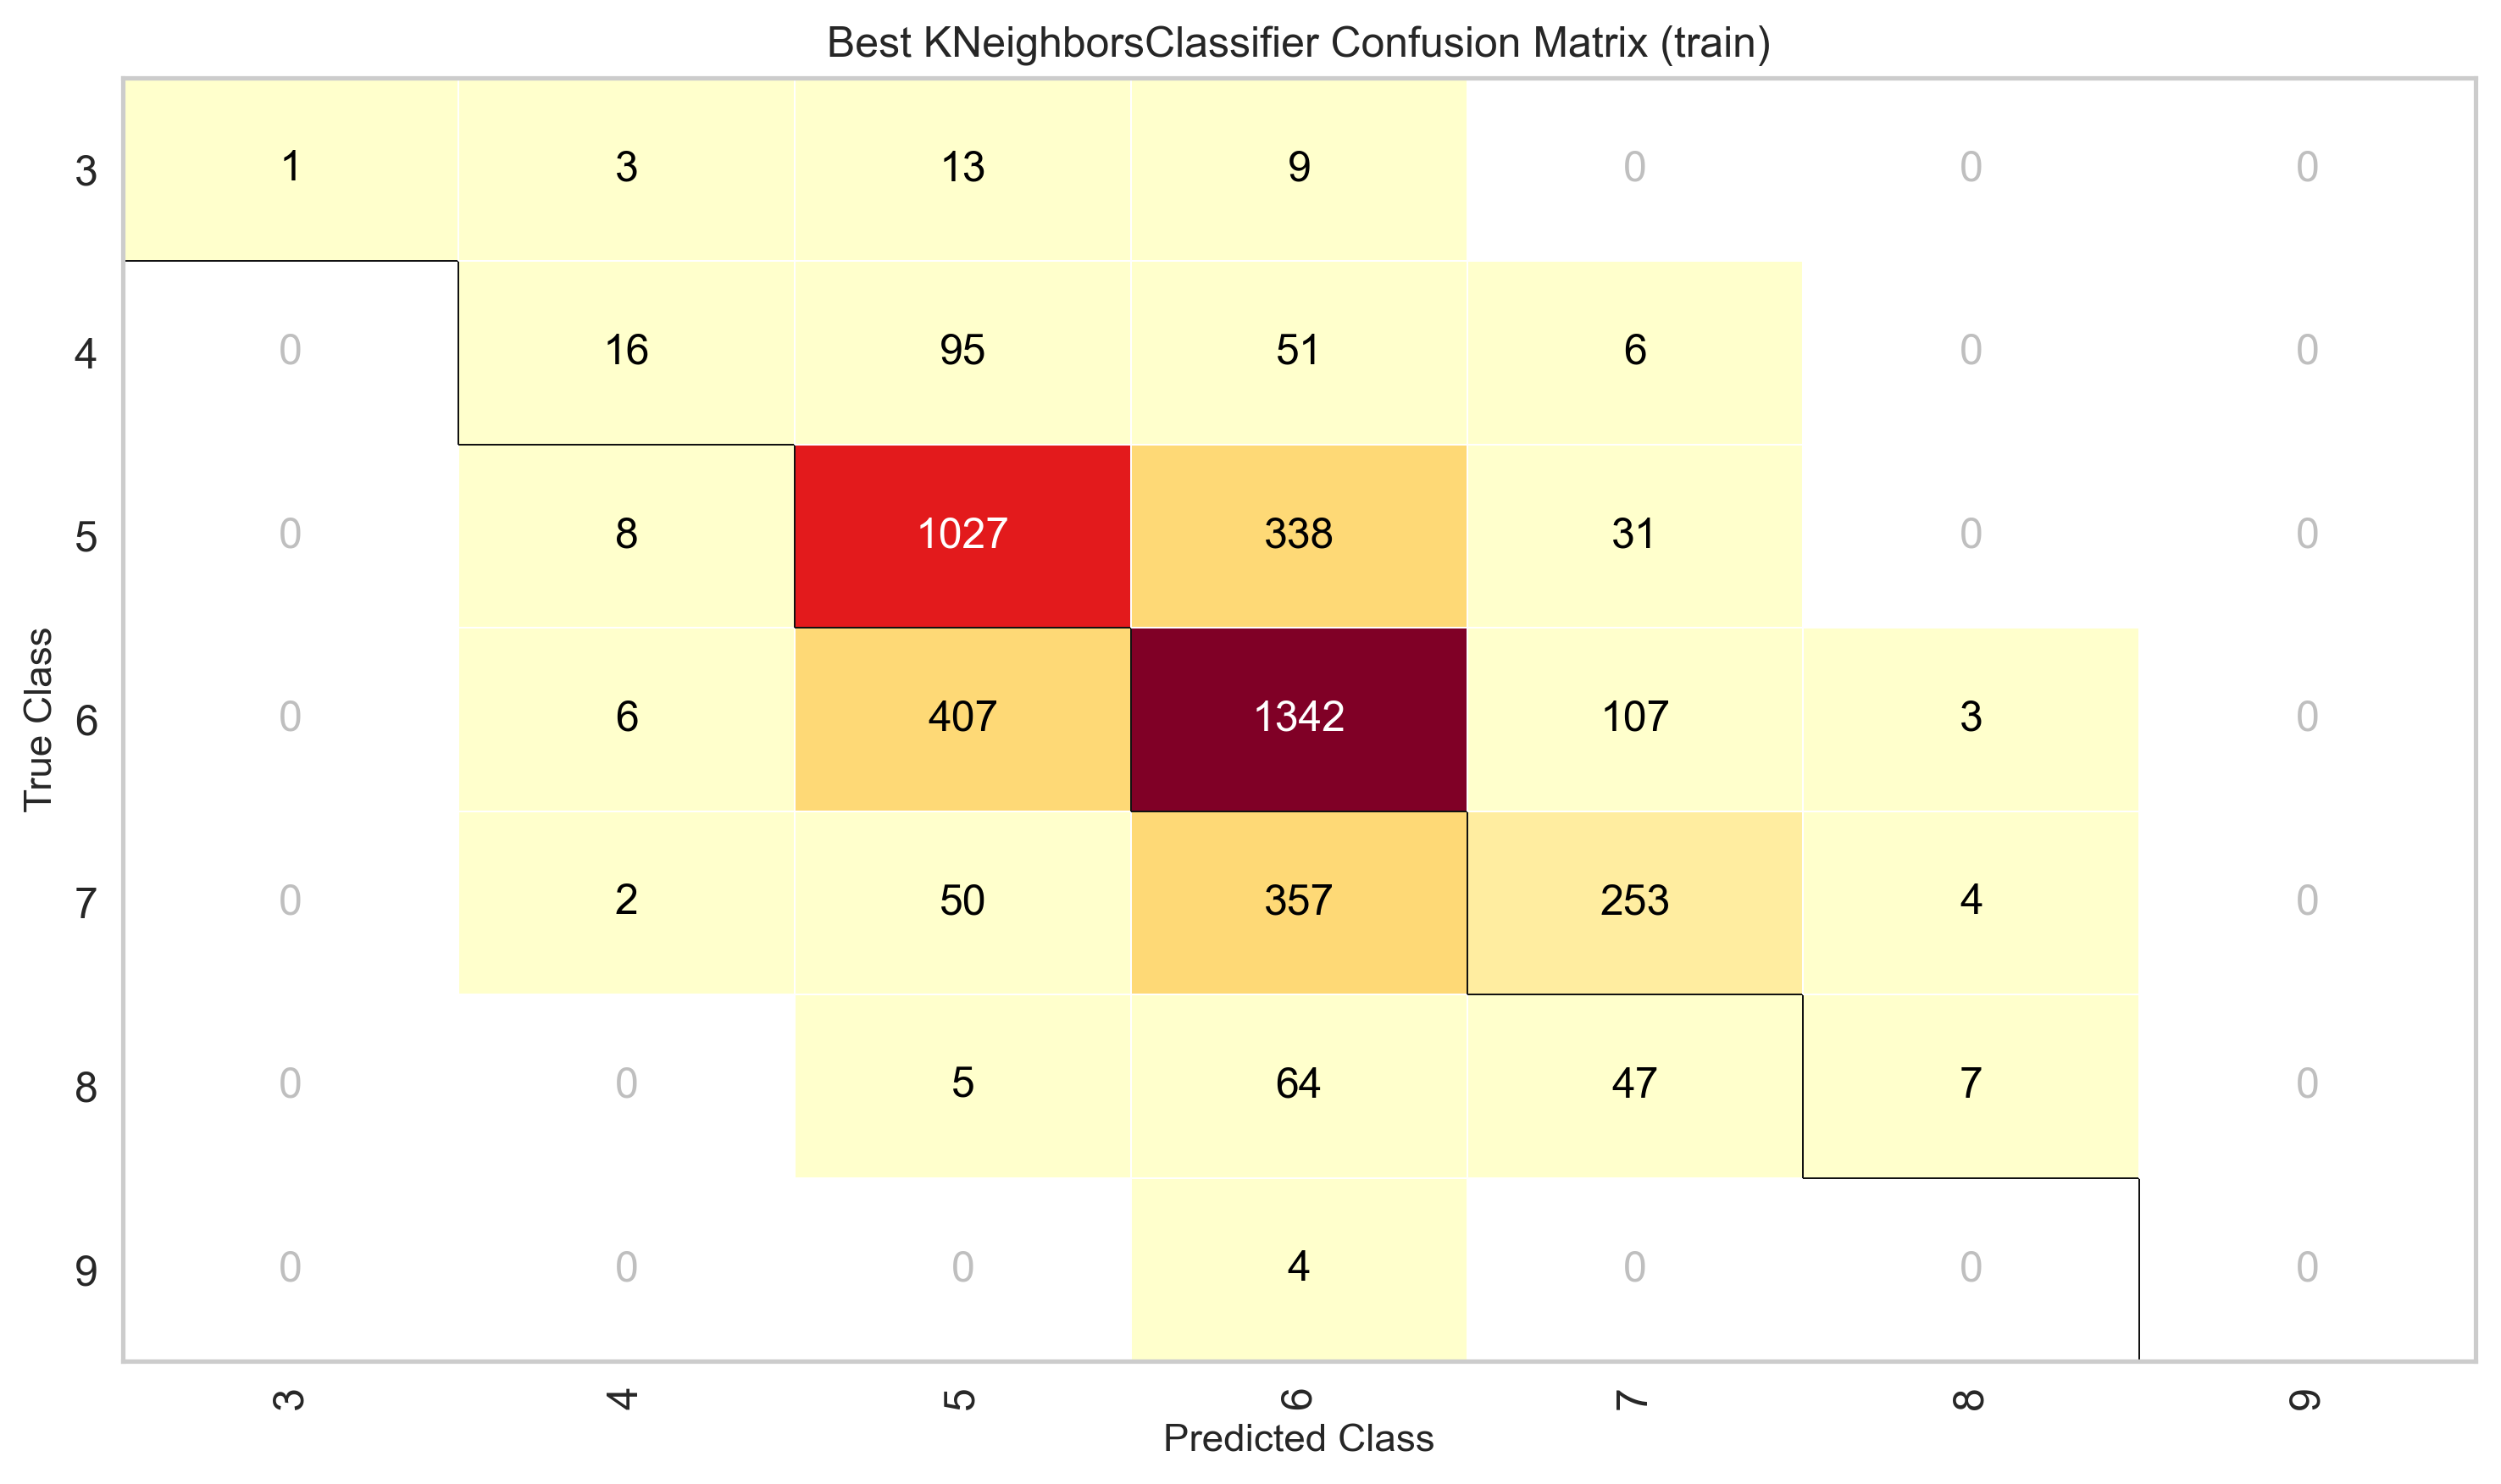

In [103]:
best_knn_clf = instantiate_best_knn_clf()
best_knn_clf.fit(X_train_n, y_train)
viz.confusion_matrix(
    clf=best_knn_clf,
    X=X_train_n,
    y=y_train,
    title='Best KNeighborsClassifier Confusion Matrix (train)',
    output_path=f'{WINE_KNN_PATH}/best_knn_train_confusion_matrix.png'
)

/Users/pavponn/opt/anaconda3/envs/assignment-1/lib/python3.10/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


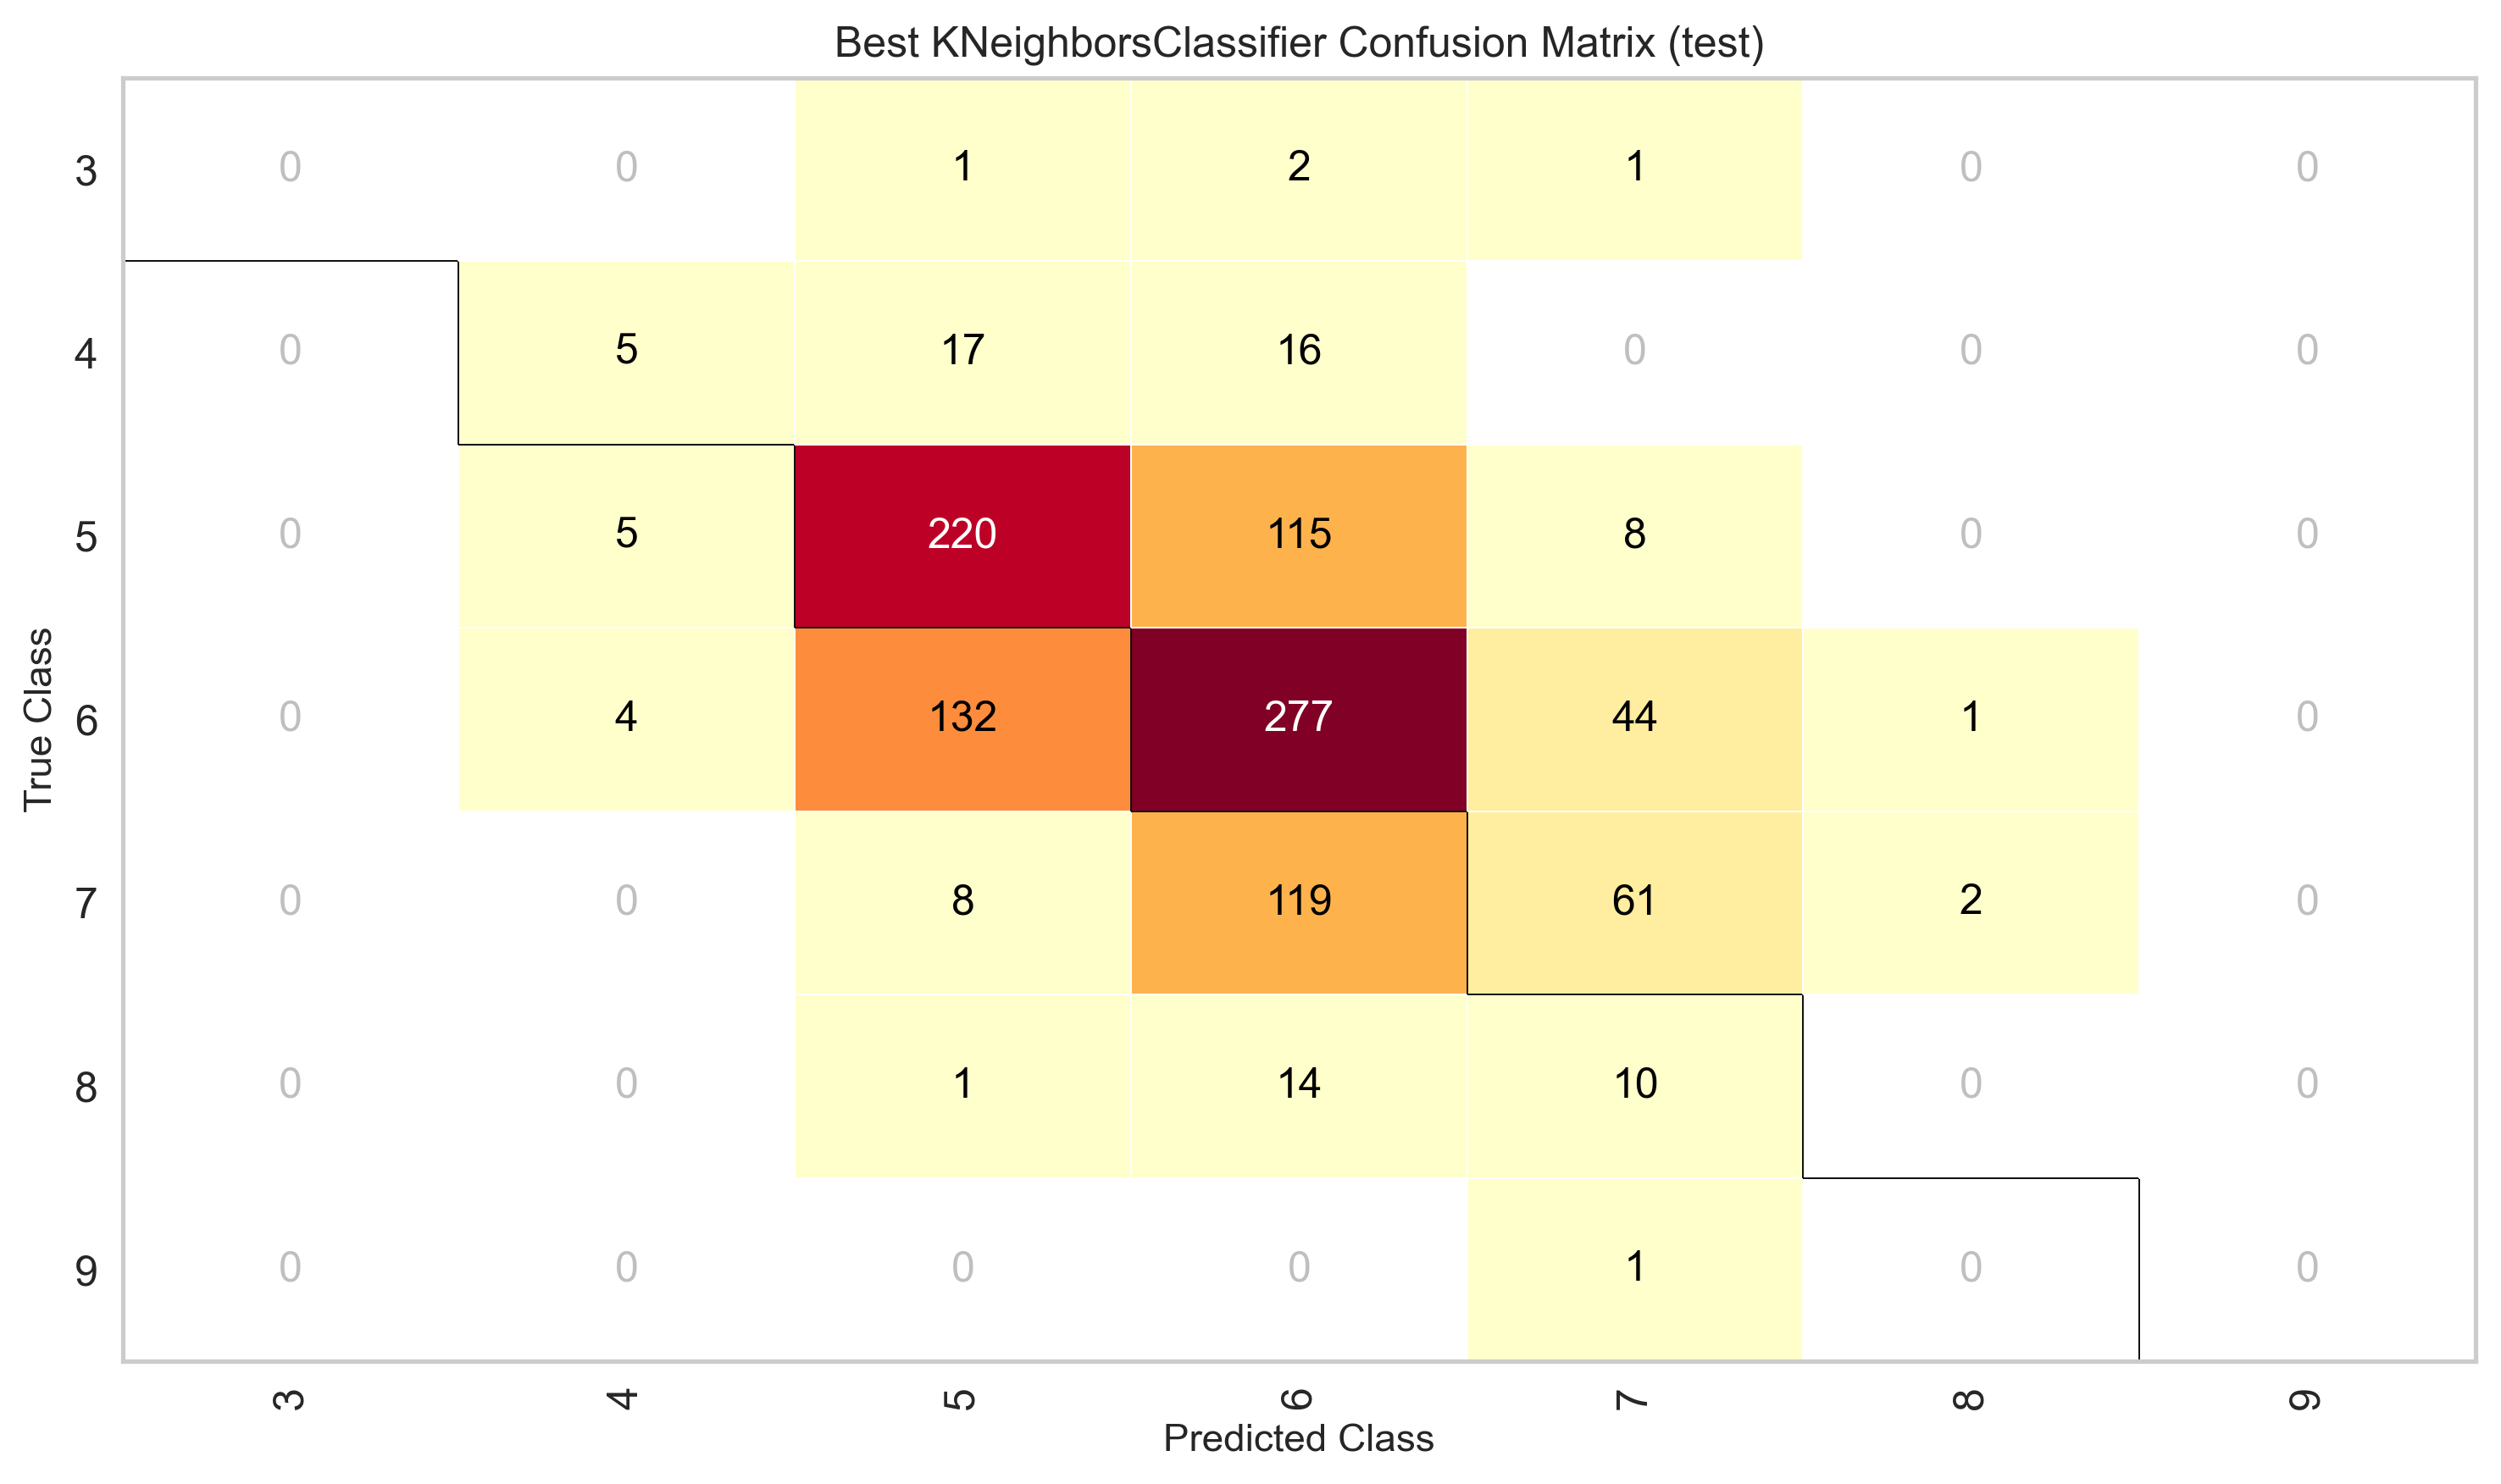

In [104]:
viz.confusion_matrix(
    clf=best_knn_clf,
    X=X_test_n,
    y=y_test,
    title='Best KNeighborsClassifier Confusion Matrix (test)',
    output_path=f'{WINE_KNN_PATH}/best_knn_test_confusion_matrix.png'
)

In [105]:
metrics.f1_score_stats(clf=best_knn_clf, X_tr=X_train_n, X_t=X_test_n, y_tr=y_train, y_t=y_test, averaging=F1_AVERAGING)

F1-Score, micro (train): 0.6217
F1-Score, micro (test) : 0.5291


In [54]:
best_knn_clf = instantiate_best_knn_clf()
training.learning_time_stats(best_knn_clf, X_tr=X_train_n, y_tr=y_train)

Training time, total: 0.0011 seconds
Training time, normalized (per 1000 samples): 0.0003 seconds


In [55]:
training.inference_time_stats(best_knn_clf, X_train_n, proba=False, dataset_name='train')
training.inference_time_stats(best_knn_clf, X_test_n, proba=False, dataset_name='test')
training.inference_time_stats(best_knn_clf, X_all_n, proba=False, dataset_name='all')

Inference time (train), total: 0.3106 seconds
Inference time (train), normalized (per 1000 samples): 0.0730 seconds
Inference time (test), total: 0.0767 seconds
Inference time (test), normalized (per 1000 samples): 0.0721 seconds
Inference time (all), total: 0.4805 seconds
Inference time (all), normalized (per 1000 samples): 0.0903 seconds


# SVM

## Plan
1. Train baseline boosting without hyperparameter tuning, look at the precision/recall at train and test sets
2. Validate how different individual hyperparameters affect performance of the model wrt recall@precision
    a. `kernel`
    b. `C`
3. Perform hyperparameter tuning of multiple parameters
4. Analyse performance of the best decision tree with hyperparameter tuning

In [56]:
WINE_SVM_PATH = f'{WINE_PATH}/svm'


In [57]:
svc_baseline_clf = SVC(random_state=SEED, probability=True)
svc_baseline_clf.fit(X_train_n, y_train)

SVC(probability=True, random_state=42)

/Users/pavponn/opt/anaconda3/envs/assignment-1/lib/python3.10/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


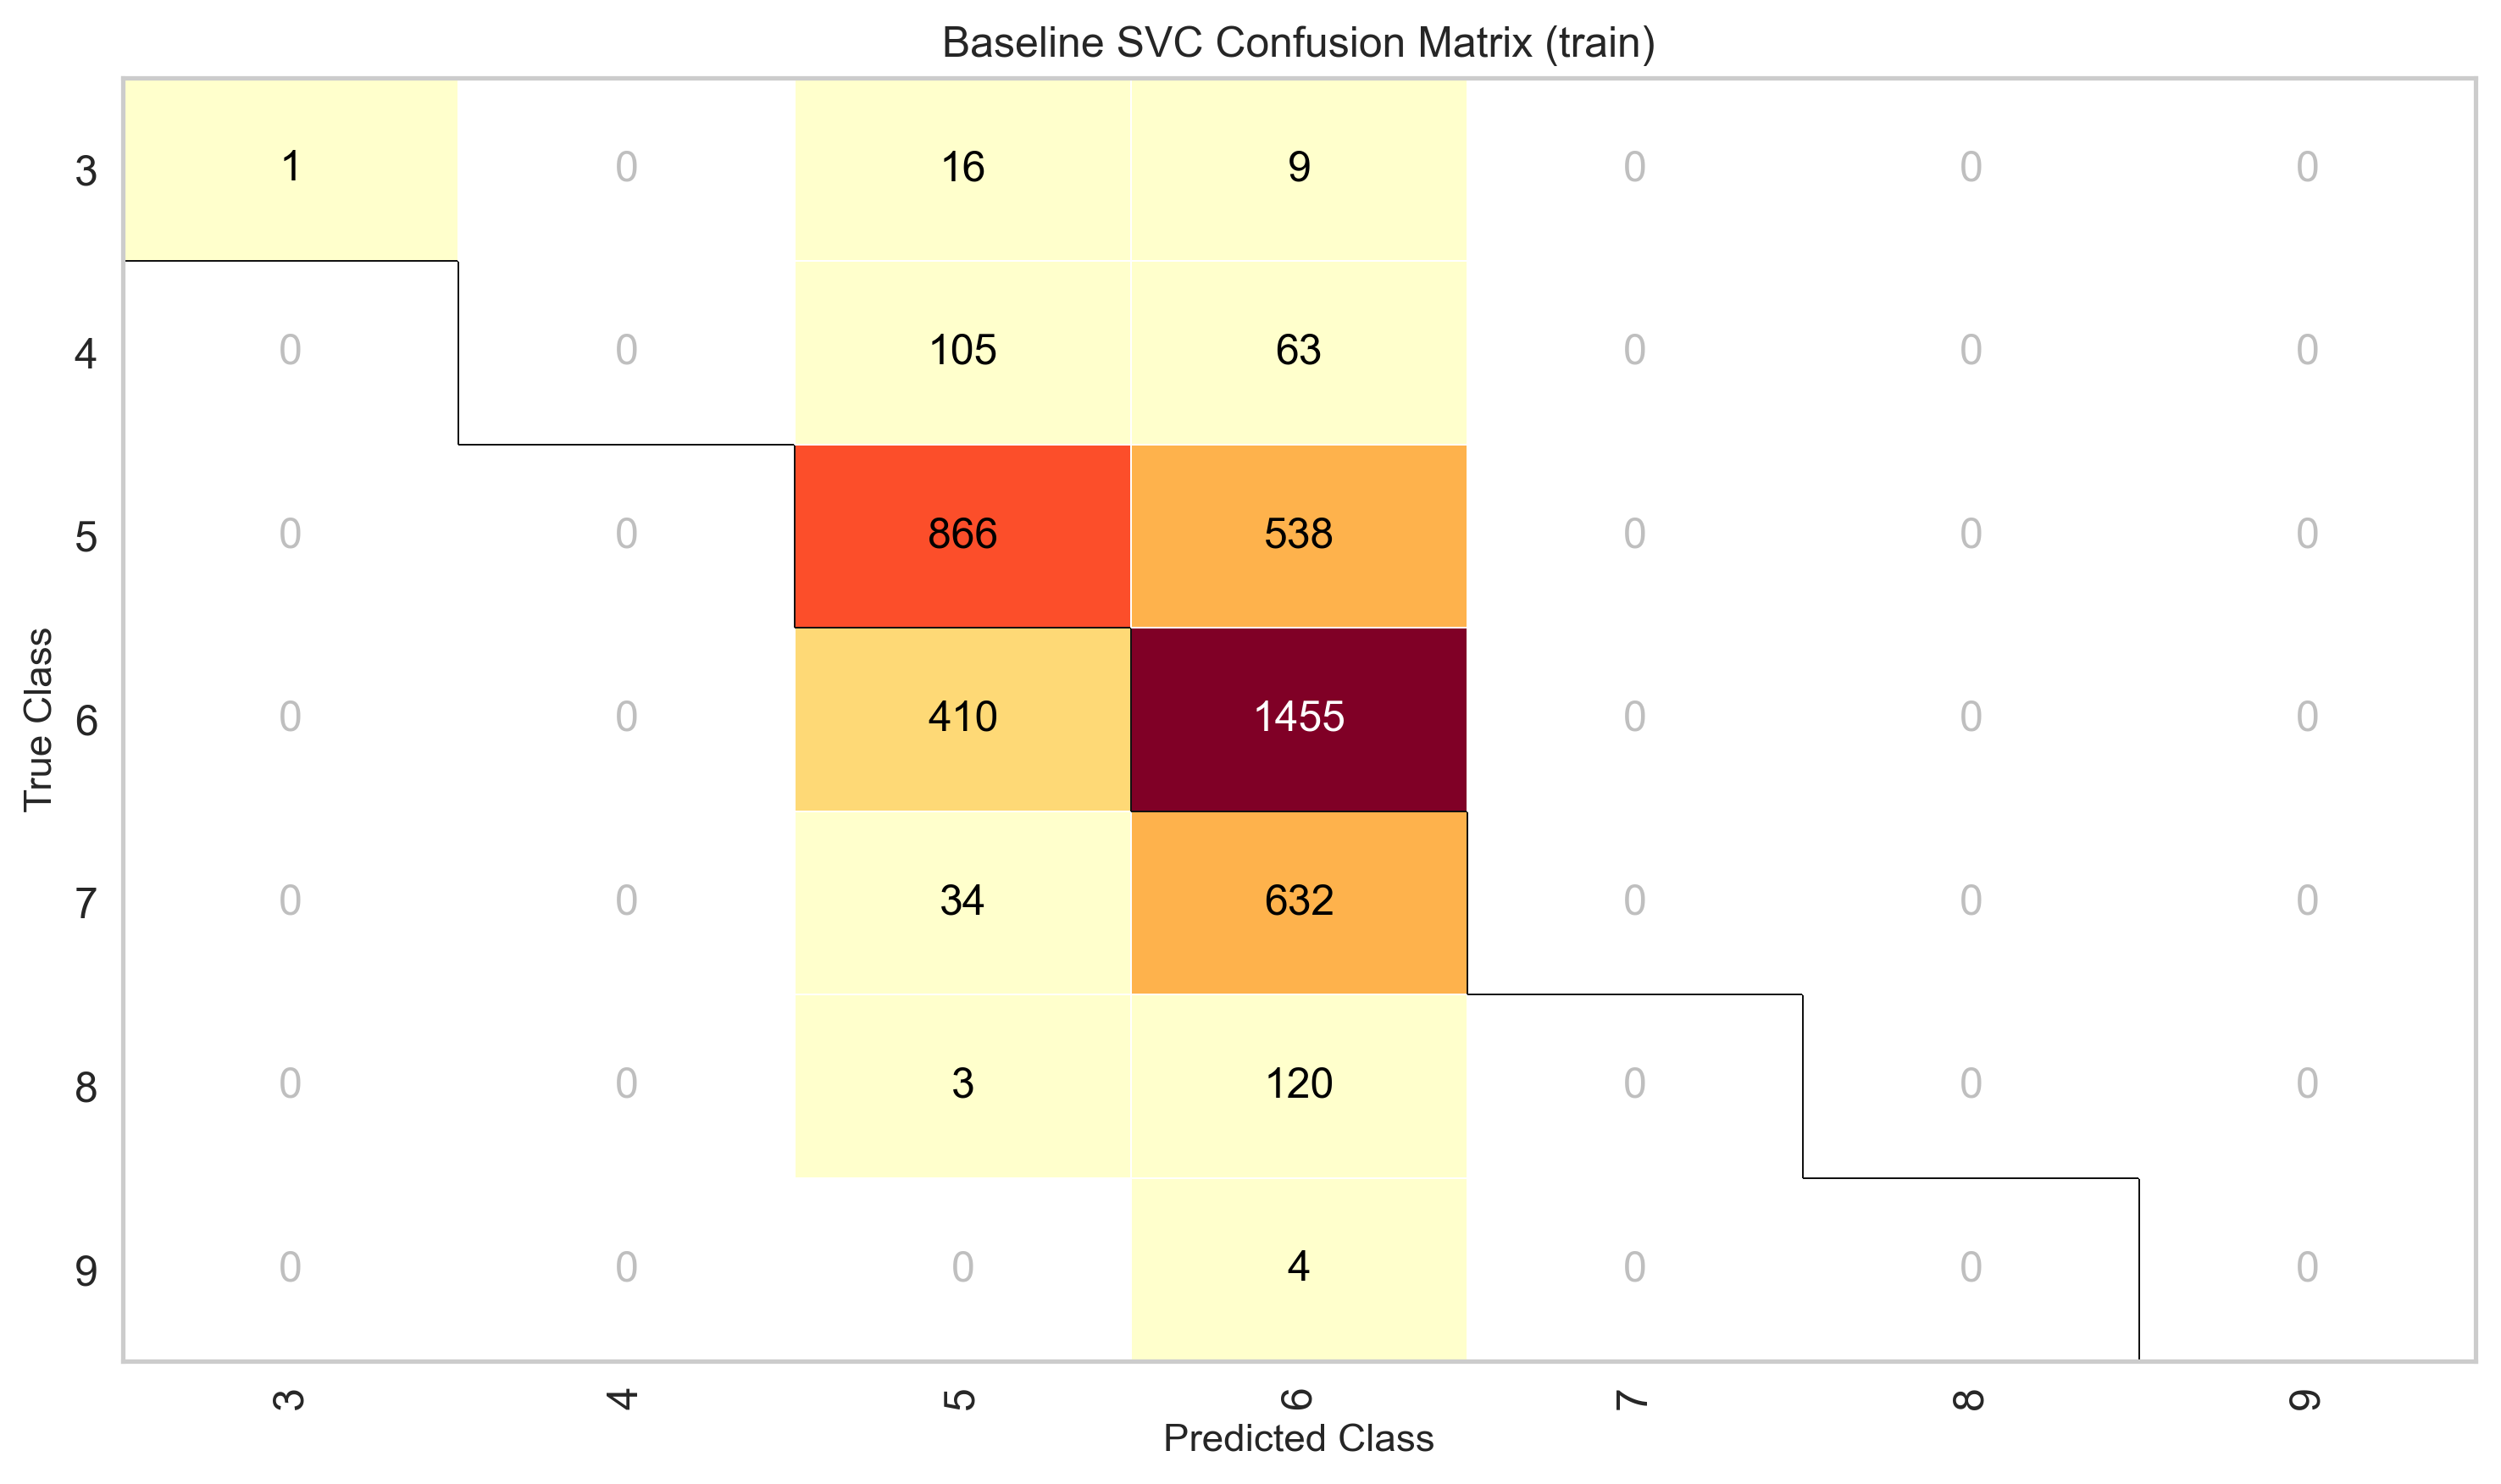

In [58]:
viz.confusion_matrix(
    clf=svc_baseline_clf,
    X=X_train_n,
    y=y_train,
    title='Baseline SVC Confusion Matrix (train)',
    output_path=f'{WINE_SVM_PATH}/baseline_svm_train_confusion_matrix.png'
)


/Users/pavponn/opt/anaconda3/envs/assignment-1/lib/python3.10/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


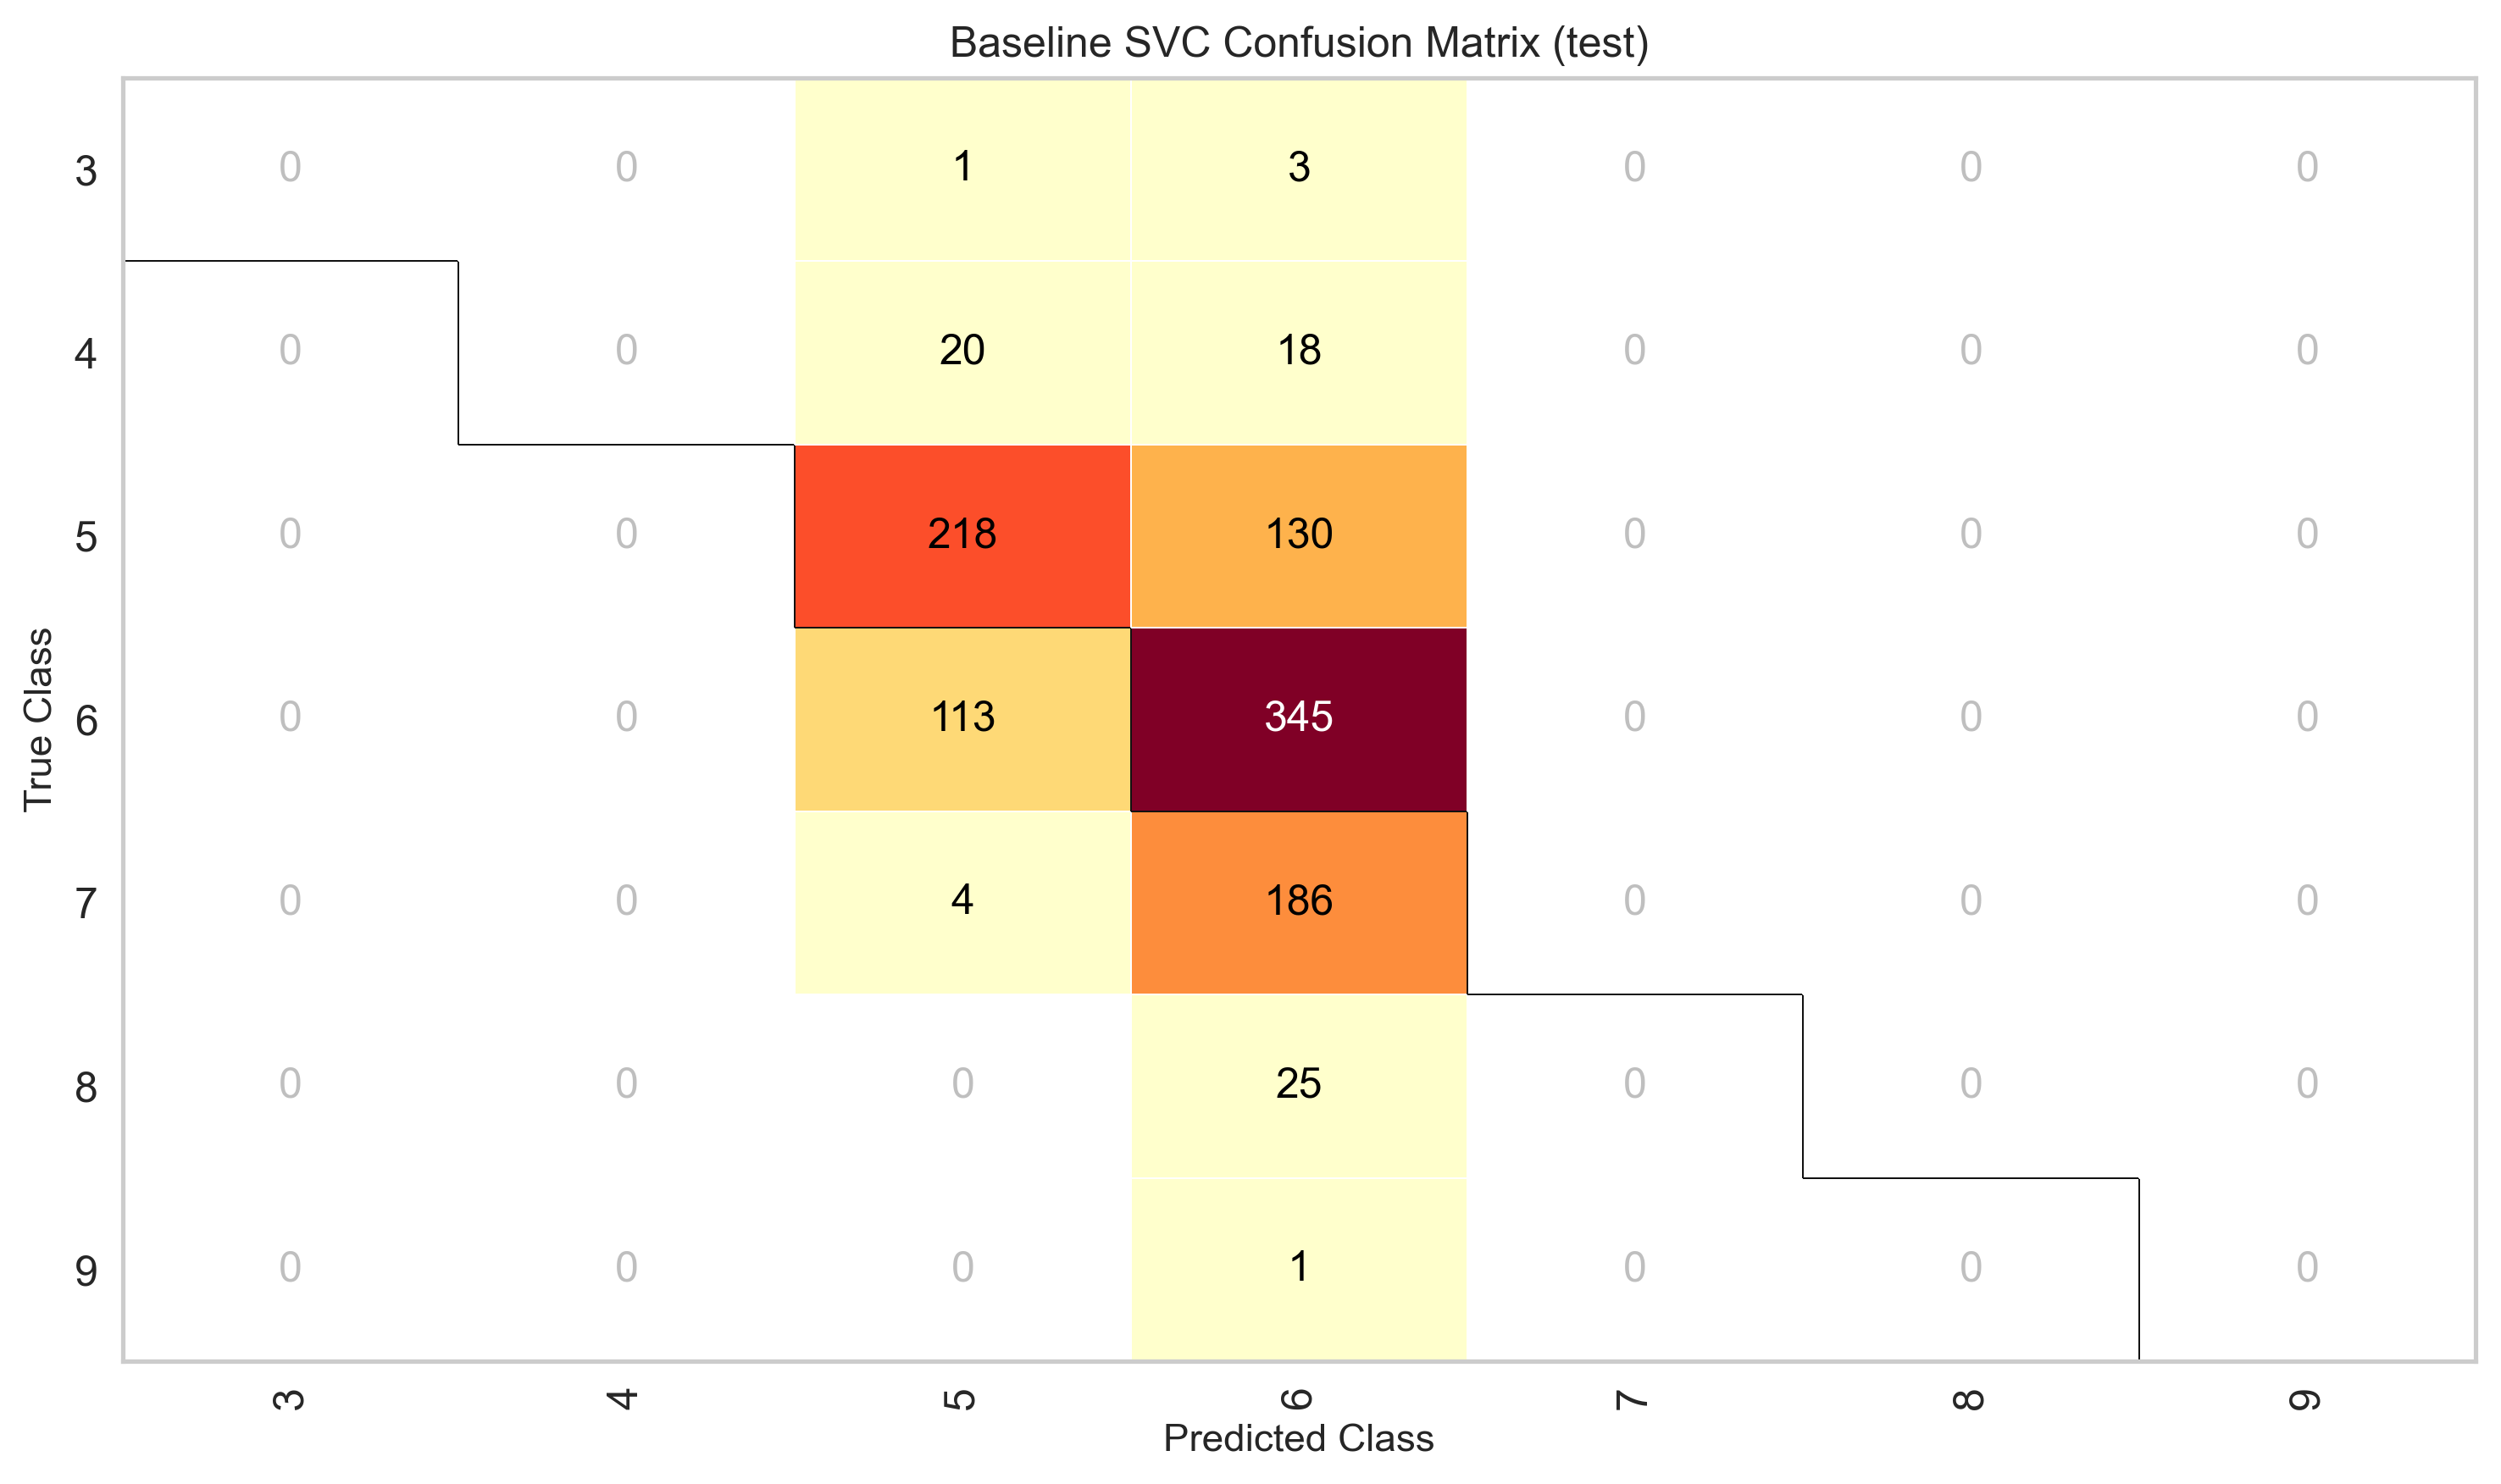

In [59]:
viz.confusion_matrix(
    clf=svc_baseline_clf,
    X=X_test_n,
    y=y_test,
    title='Baseline SVC Confusion Matrix (test)',
    output_path=f'{WINE_SVM_PATH}/baseline_svm_test_confusion_matrix.png'
)


In [60]:
metrics.f1_score_stats(clf=svc_baseline_clf, X_tr=X_train_n, X_t=X_test_n, y_tr=y_train, y_t=y_test,
                       averaging=F1_AVERAGING)


F1-Score, micro (train): 0.5456
F1-Score, micro (test) : 0.5291


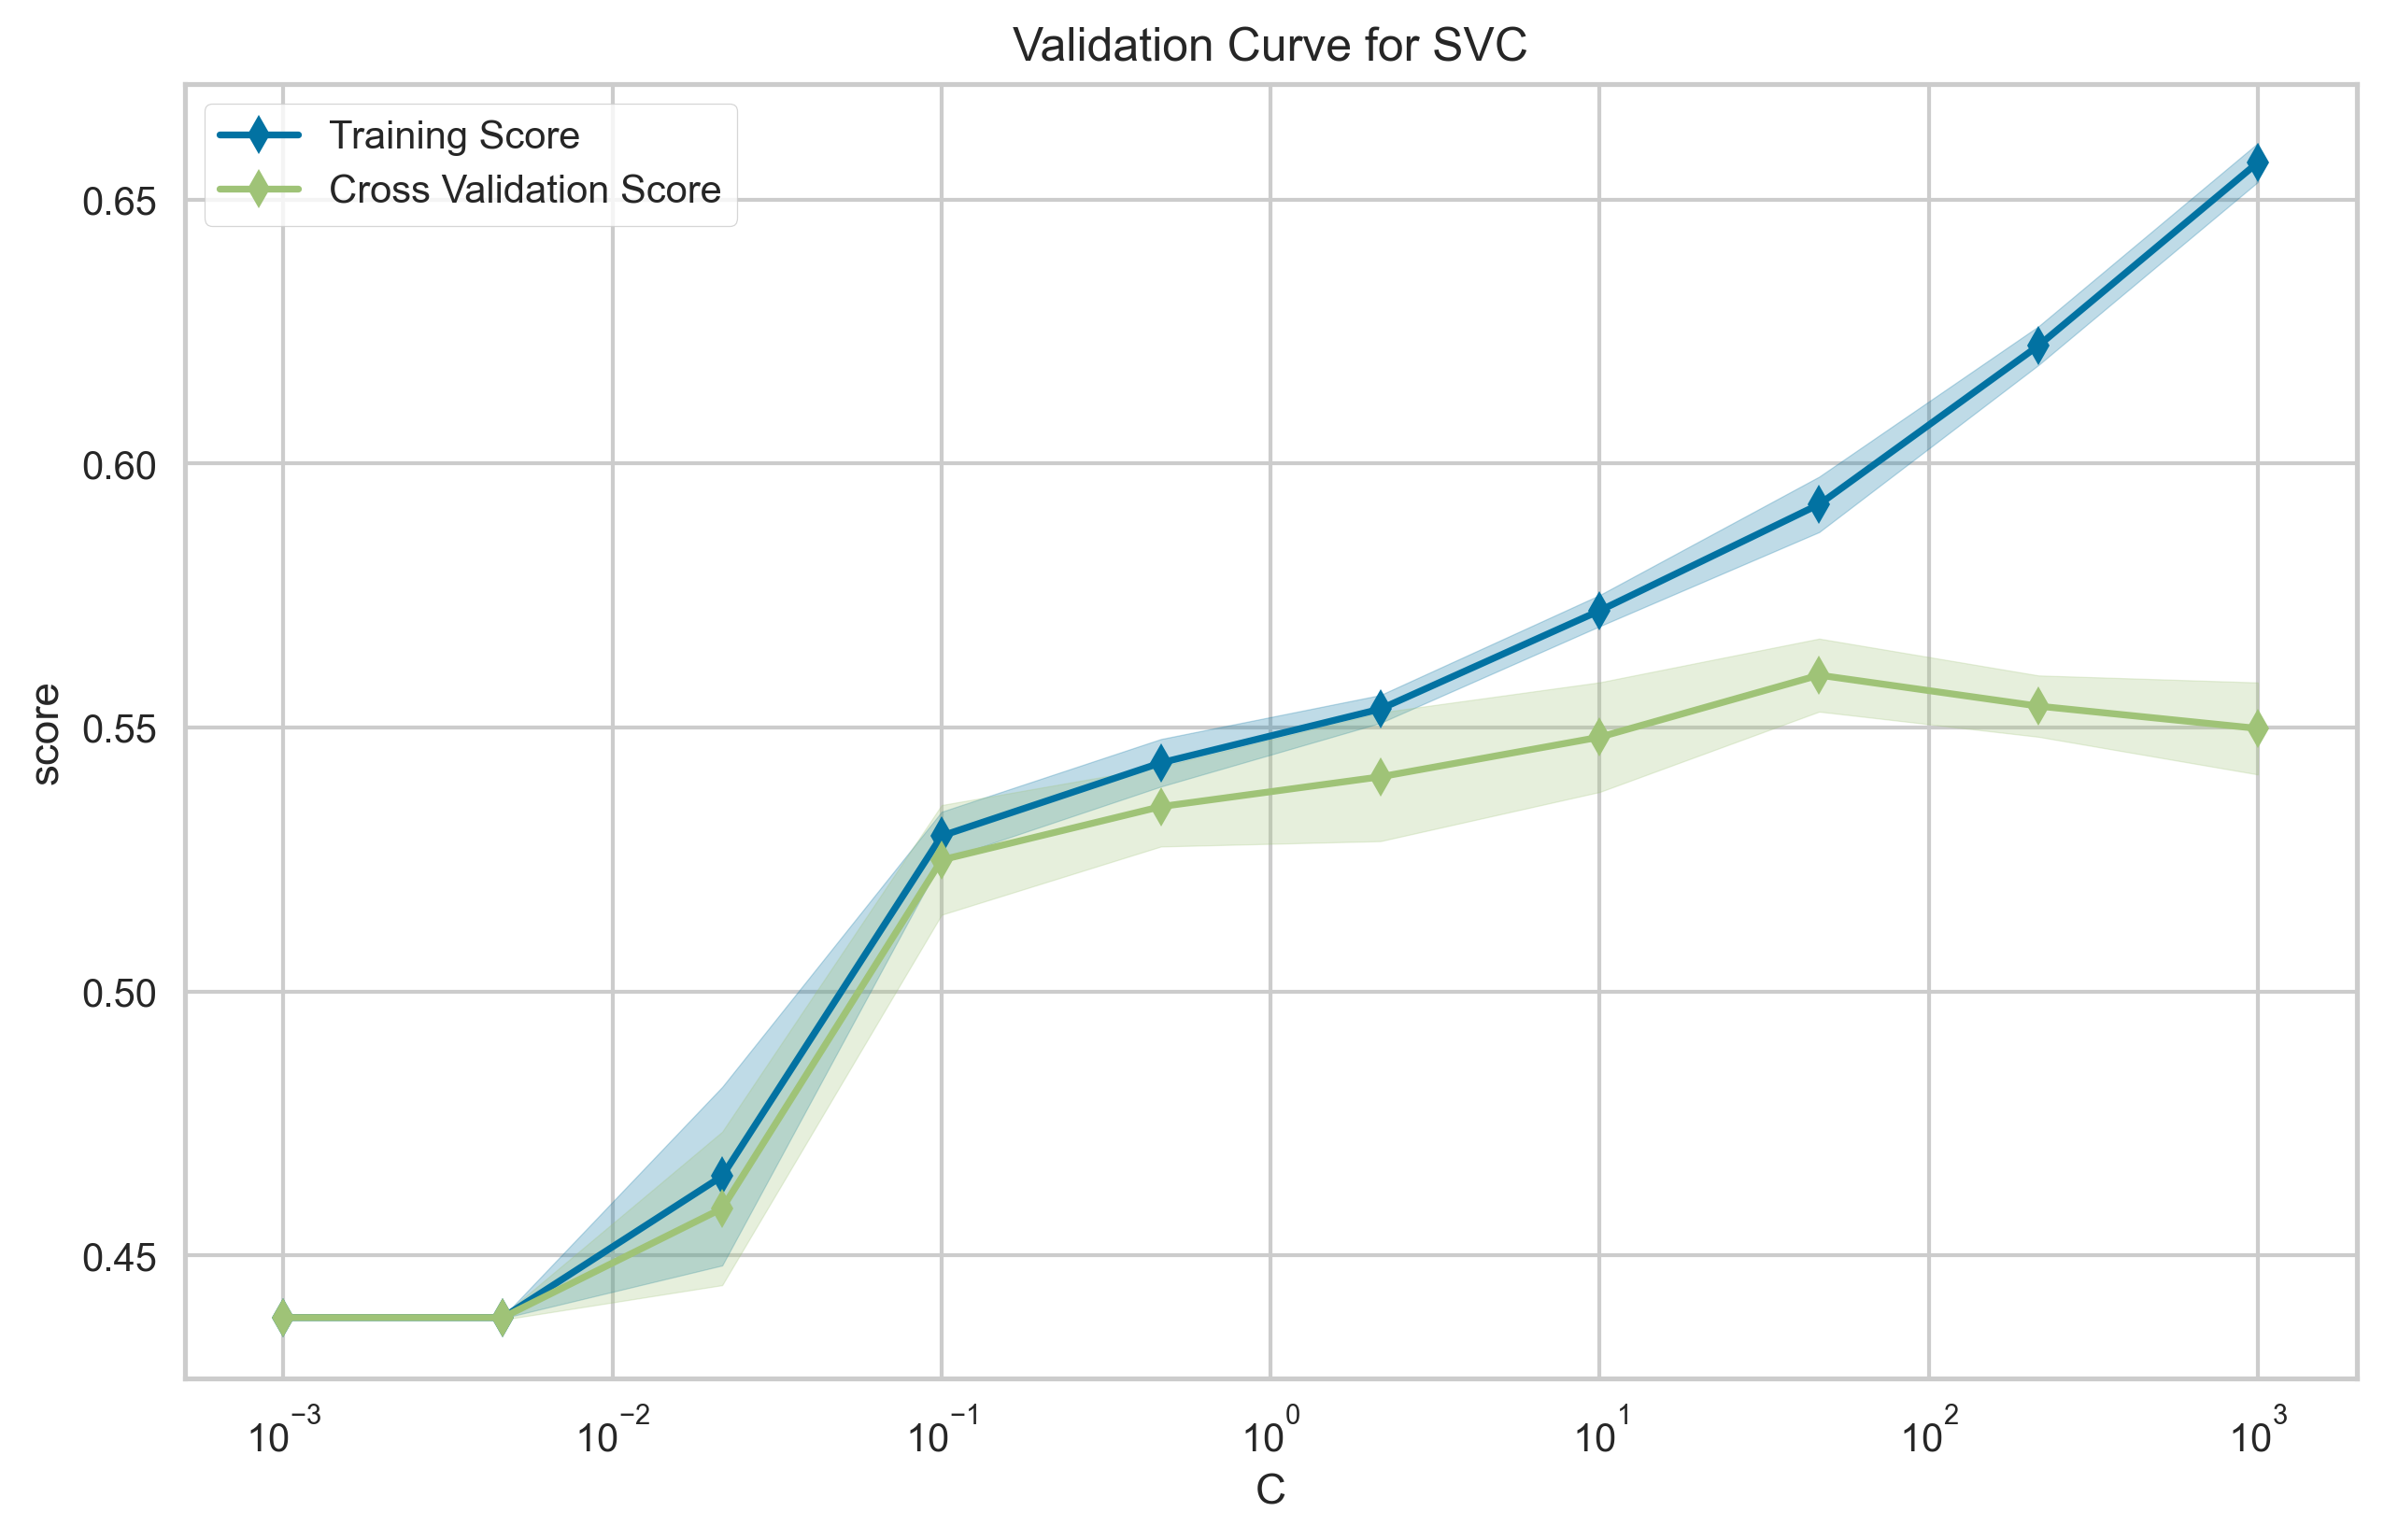

In [61]:
svc_clf = SVC(random_state=SEED, probability=True)
viz.validation_curve(
    clf=svc_clf,
    X_tr=X_train_n,
    y_tr=y_train,
    cv=CV,
    param_name="C",
    param_range=np.logspace(-3, 3, 10),
    output_path=f"{WINE_SVM_PATH}/svm_c.png",
    logx=True,
    scoring=F1_SCORE,
)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


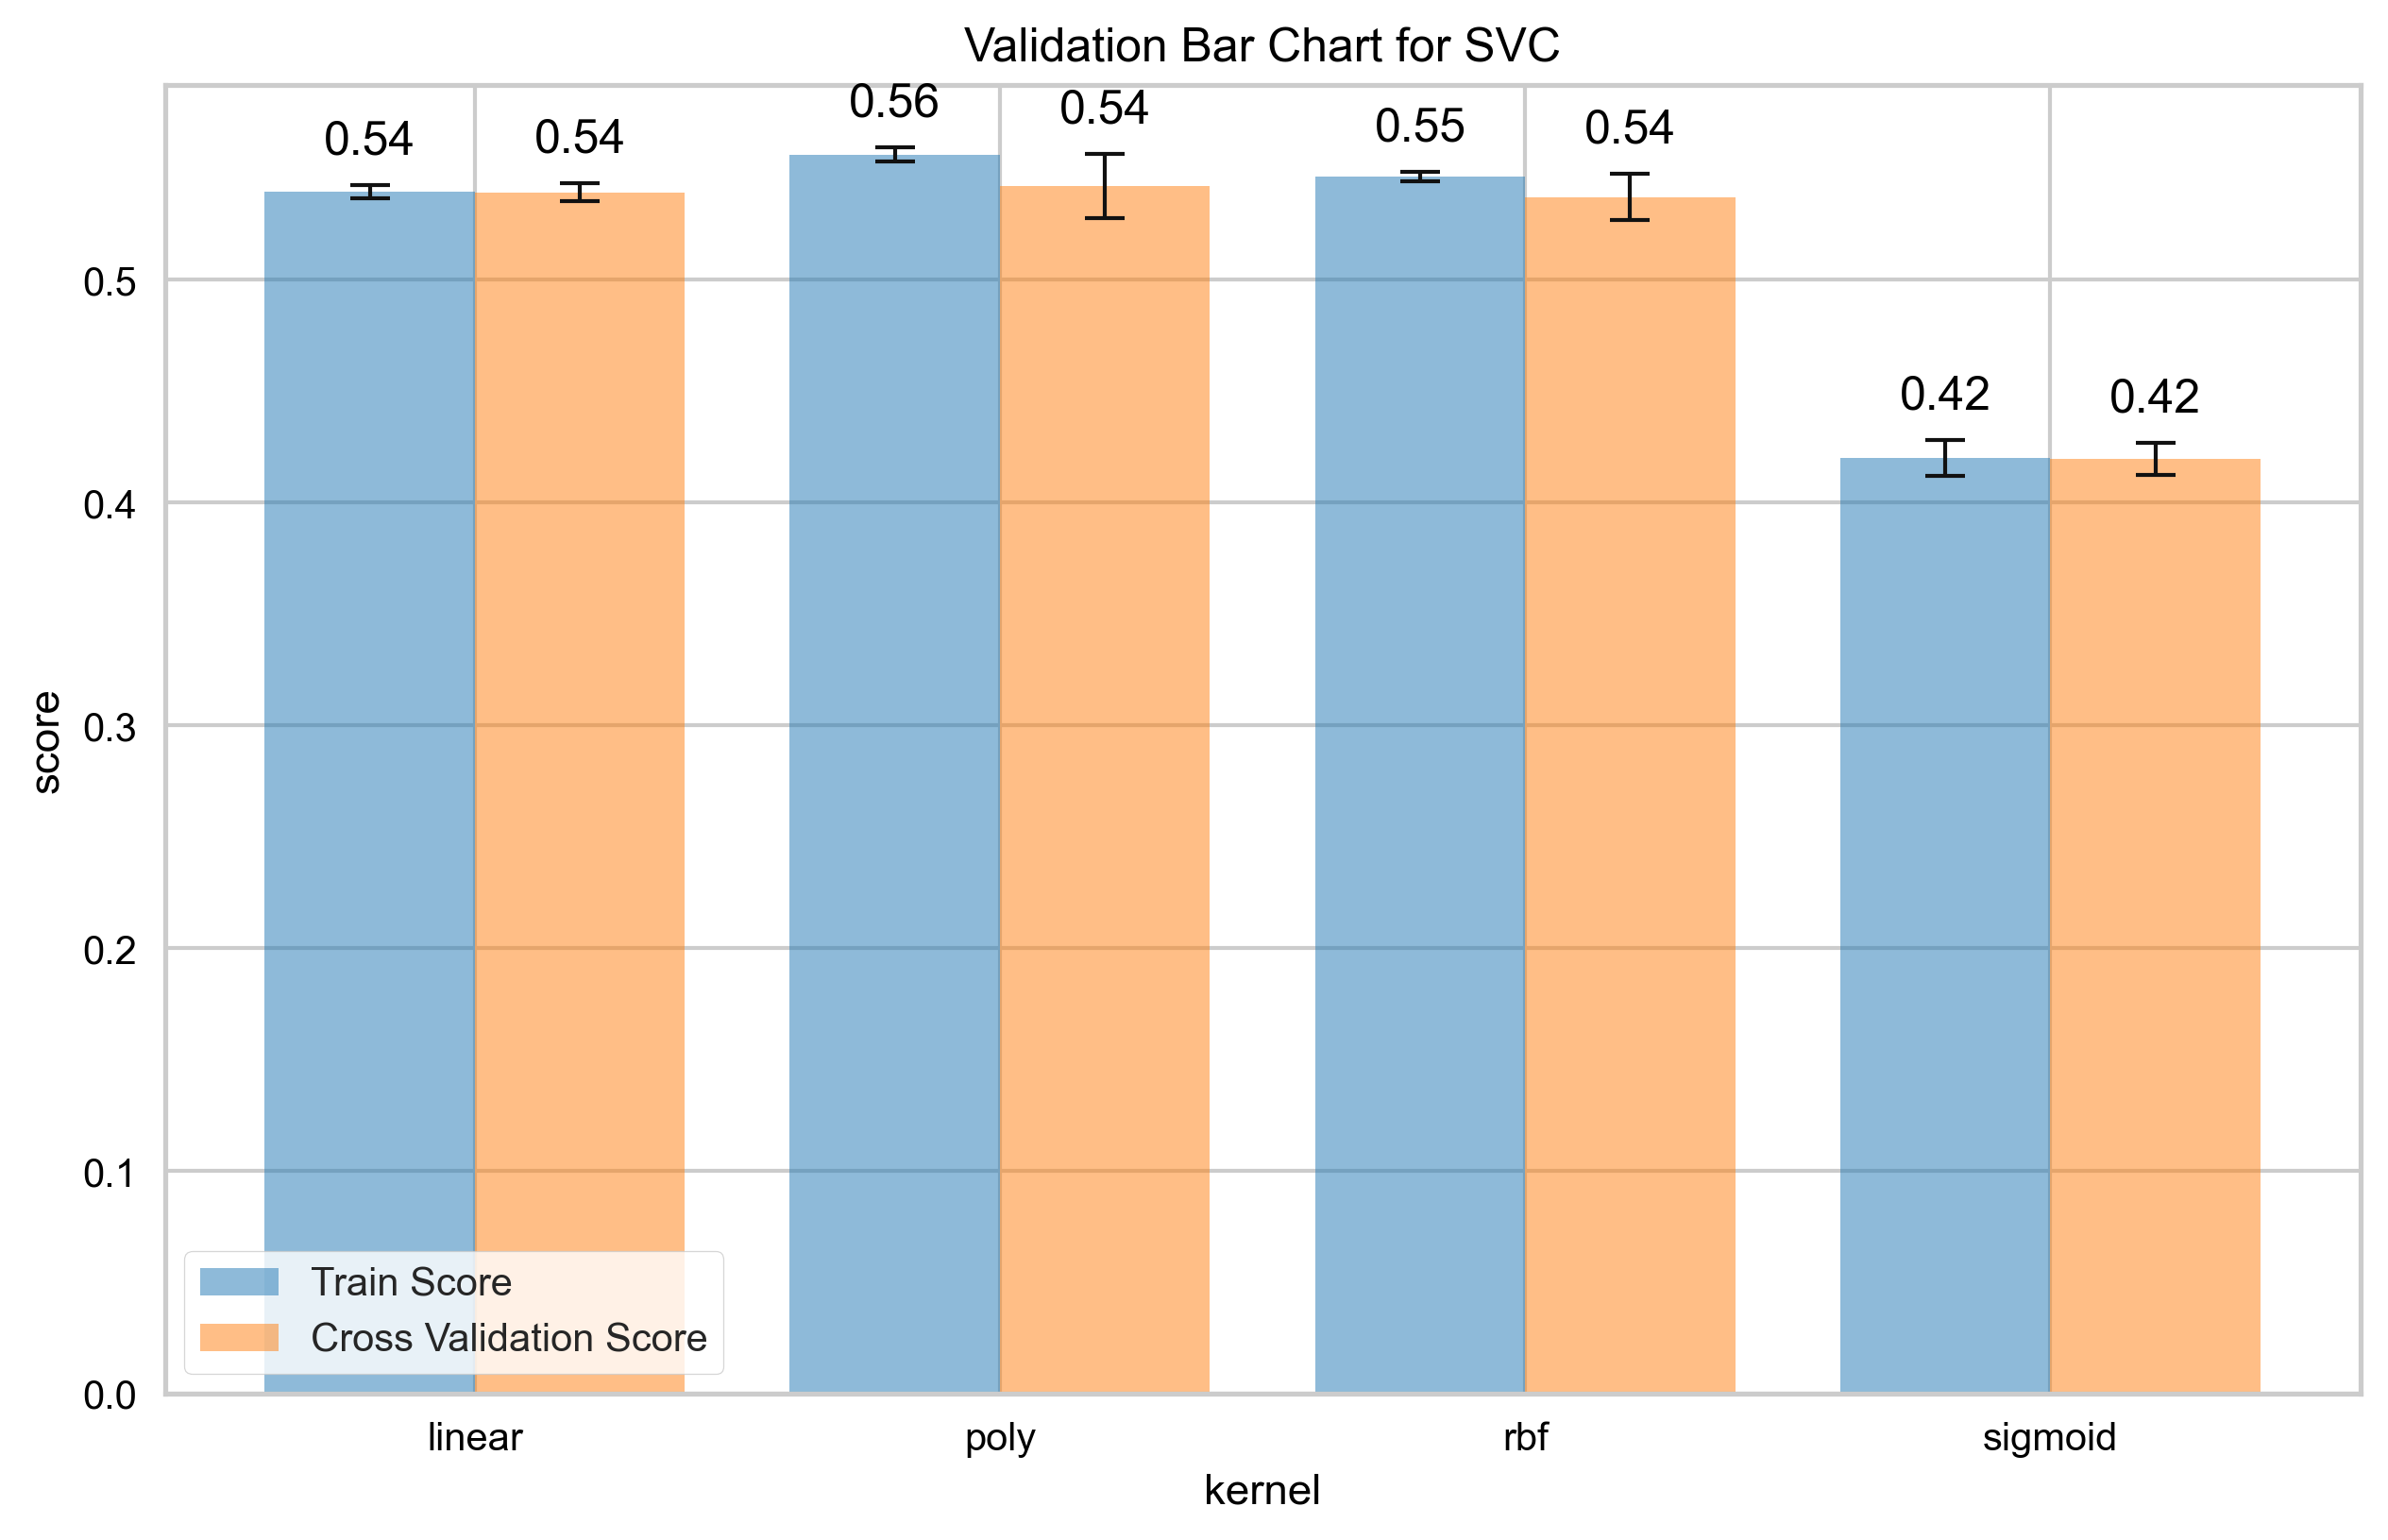

In [62]:
svc_clf = SVC(random_state=SEED, probability=True)
viz.validation_bar_chart(
    clf=svc_clf,
    X_tr=X_train_n,
    y_tr=y_train,
    cv=CV,
    param_name="kernel",
    param_range=['linear', 'poly', 'rbf', 'sigmoid'],
    output_path=f"{WINE_SVM_PATH}/svm_kernel.png",
    n_jobs=3,
    scoring=F1_SCORE,
)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


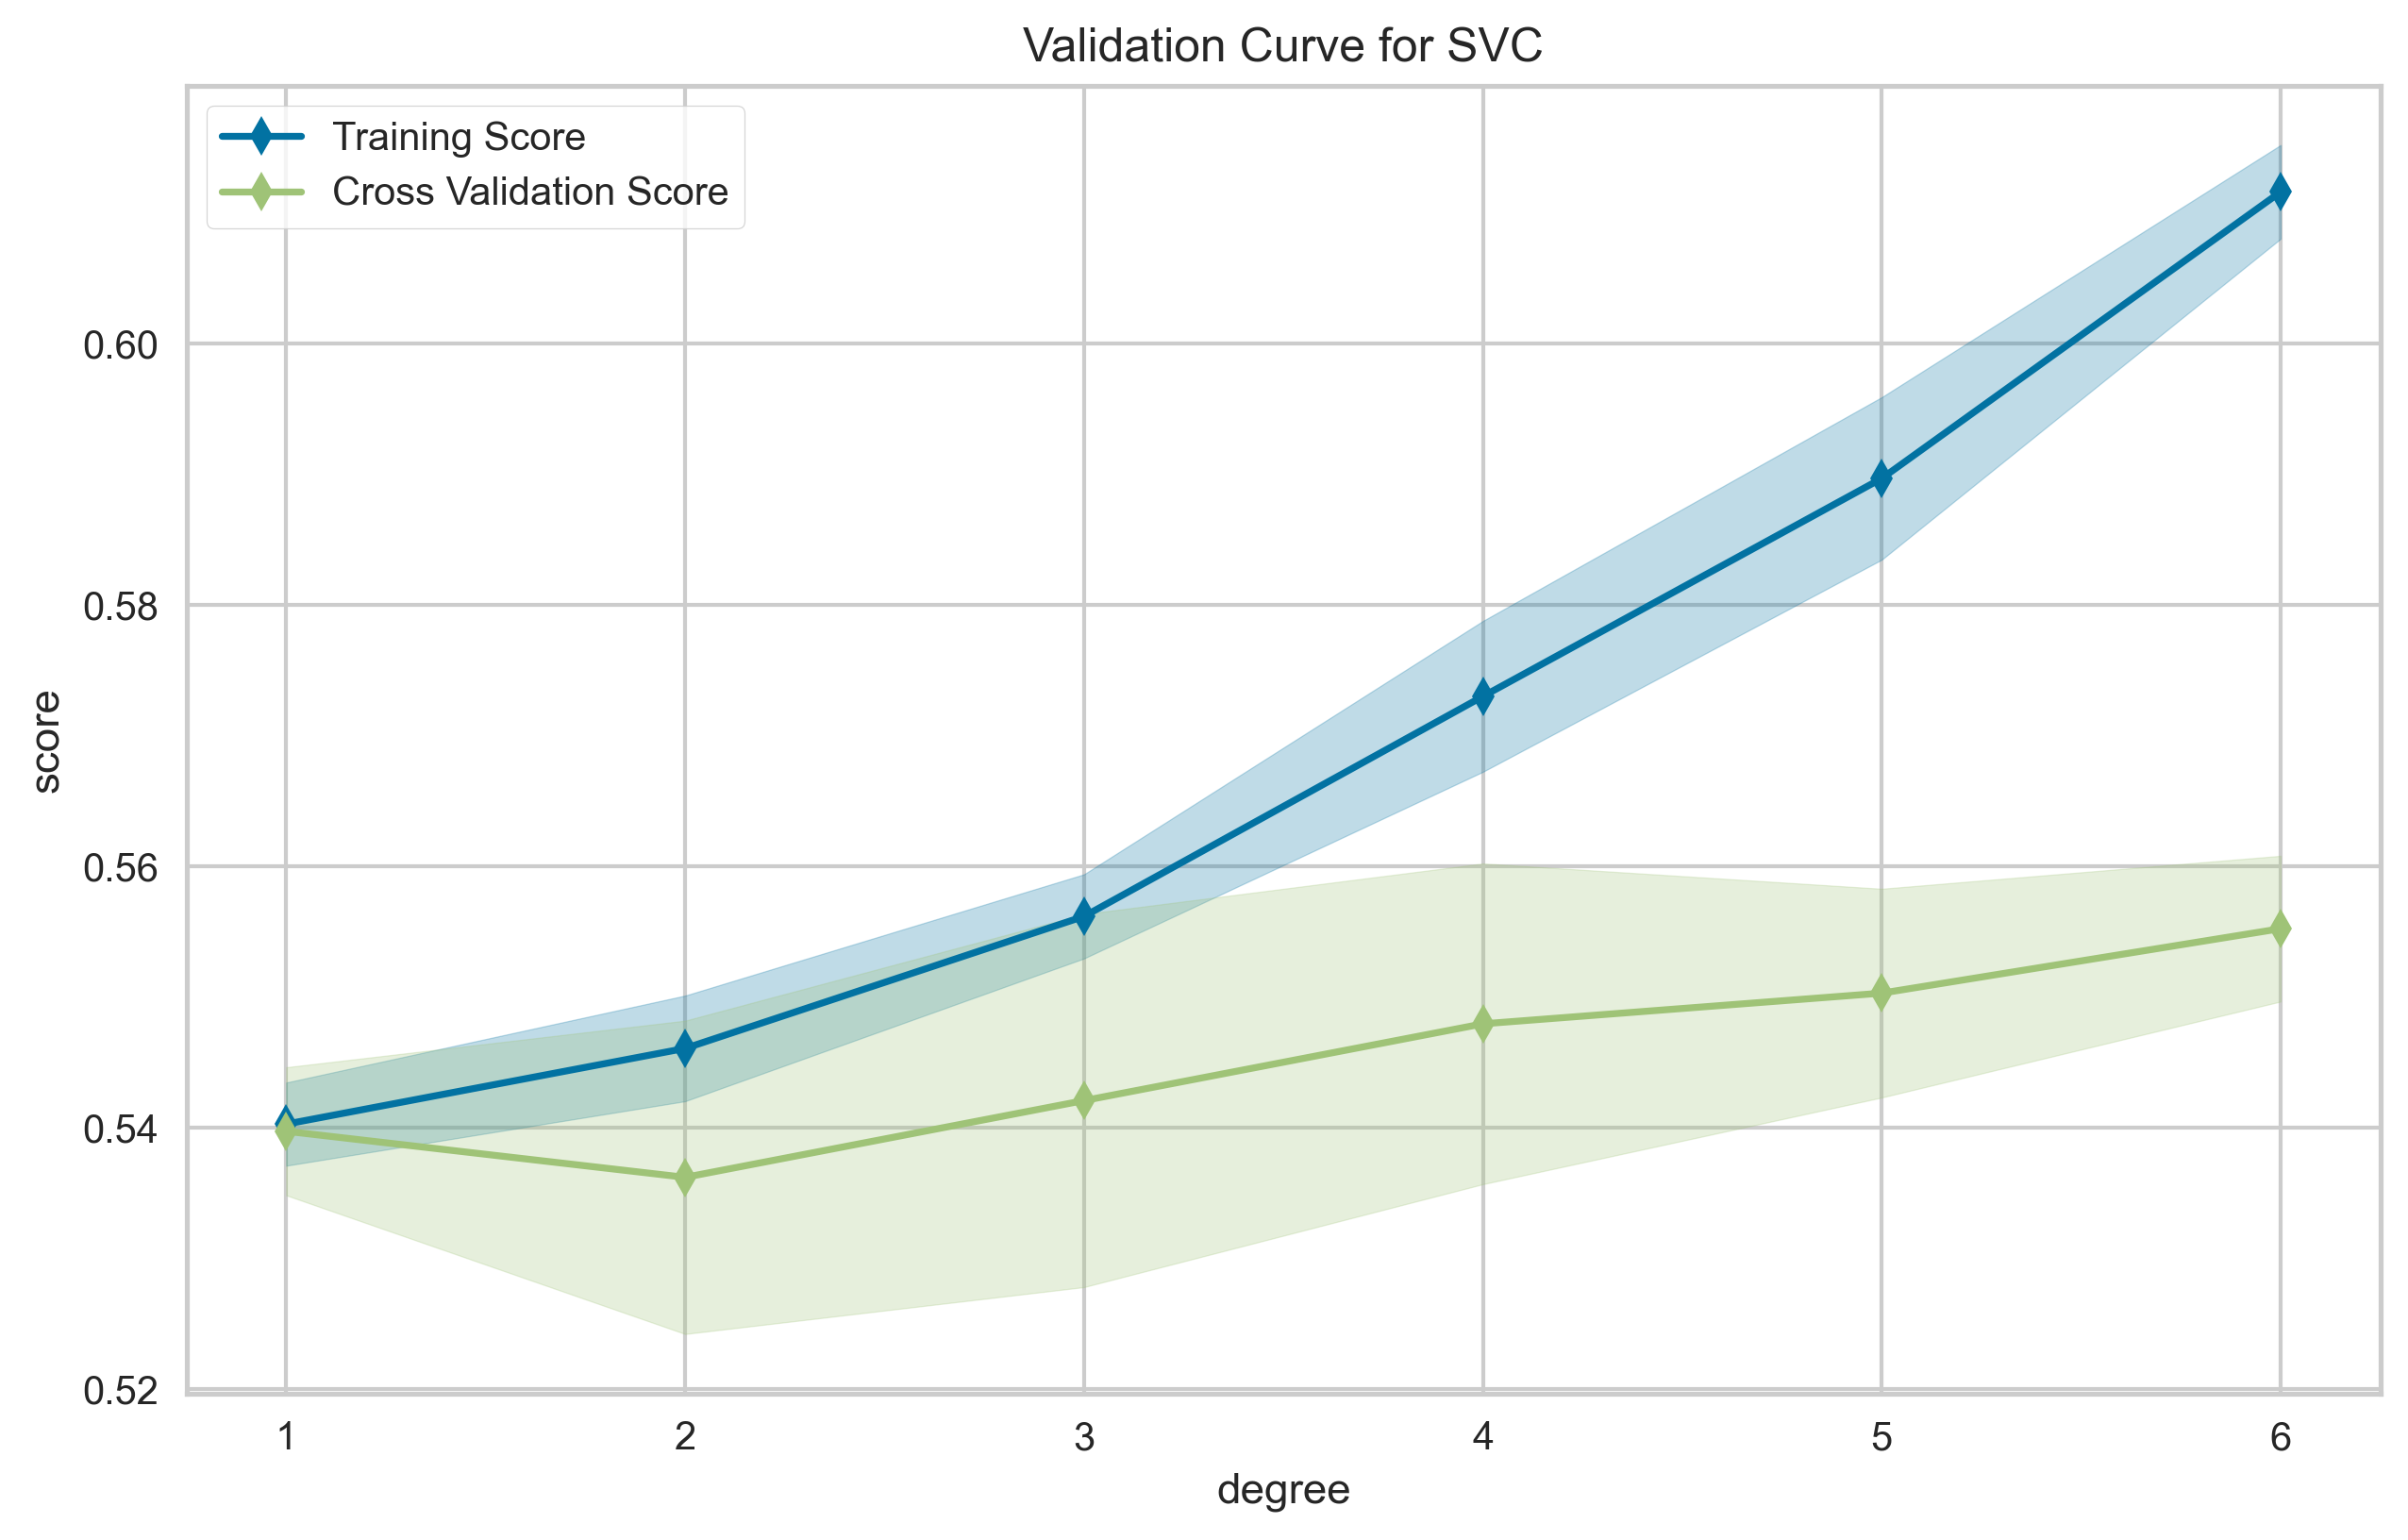

In [63]:
svc_clf = SVC(random_state=SEED, probability=True, kernel='poly')
viz.validation_curve(
    clf=svc_clf,
    X_tr=X_train_n,
    y_tr=y_train,
    cv=CV,
    param_name="degree",
    param_range=np.arange(1, 7, 1),
    output_path=f"{WINE_SVM_PATH}/svm_poly_degree.png",
    scoring=F1_SCORE,
)

In [64]:
best_svm_params = training.perform_hyperparameter_tuning(
    clf=SVC(random_state=SEED, probability=True),
    X_tr=X_train_n,
    y_tr=y_train,
    cv=CV,
    param_space={
        "C": np.logspace(-1, 2, 5),
        "degree": [3, 4, 5],
        "kernel": ['linear', 'poly', 'rbf'],
    },
    scoring=F1_SCORE,
    # n_jobs=4,
)

In [65]:
best_svm_params

{'C': 17.78279410038923, 'degree': 5, 'kernel': 'poly'}

In [66]:
def instantiate_best_svm_clf():
    return SVC(random_state=SEED, probability=True, C=best_svm_params['C'],
               degree=best_svm_params['degree'],
               kernel=best_svm_params['kernel'])

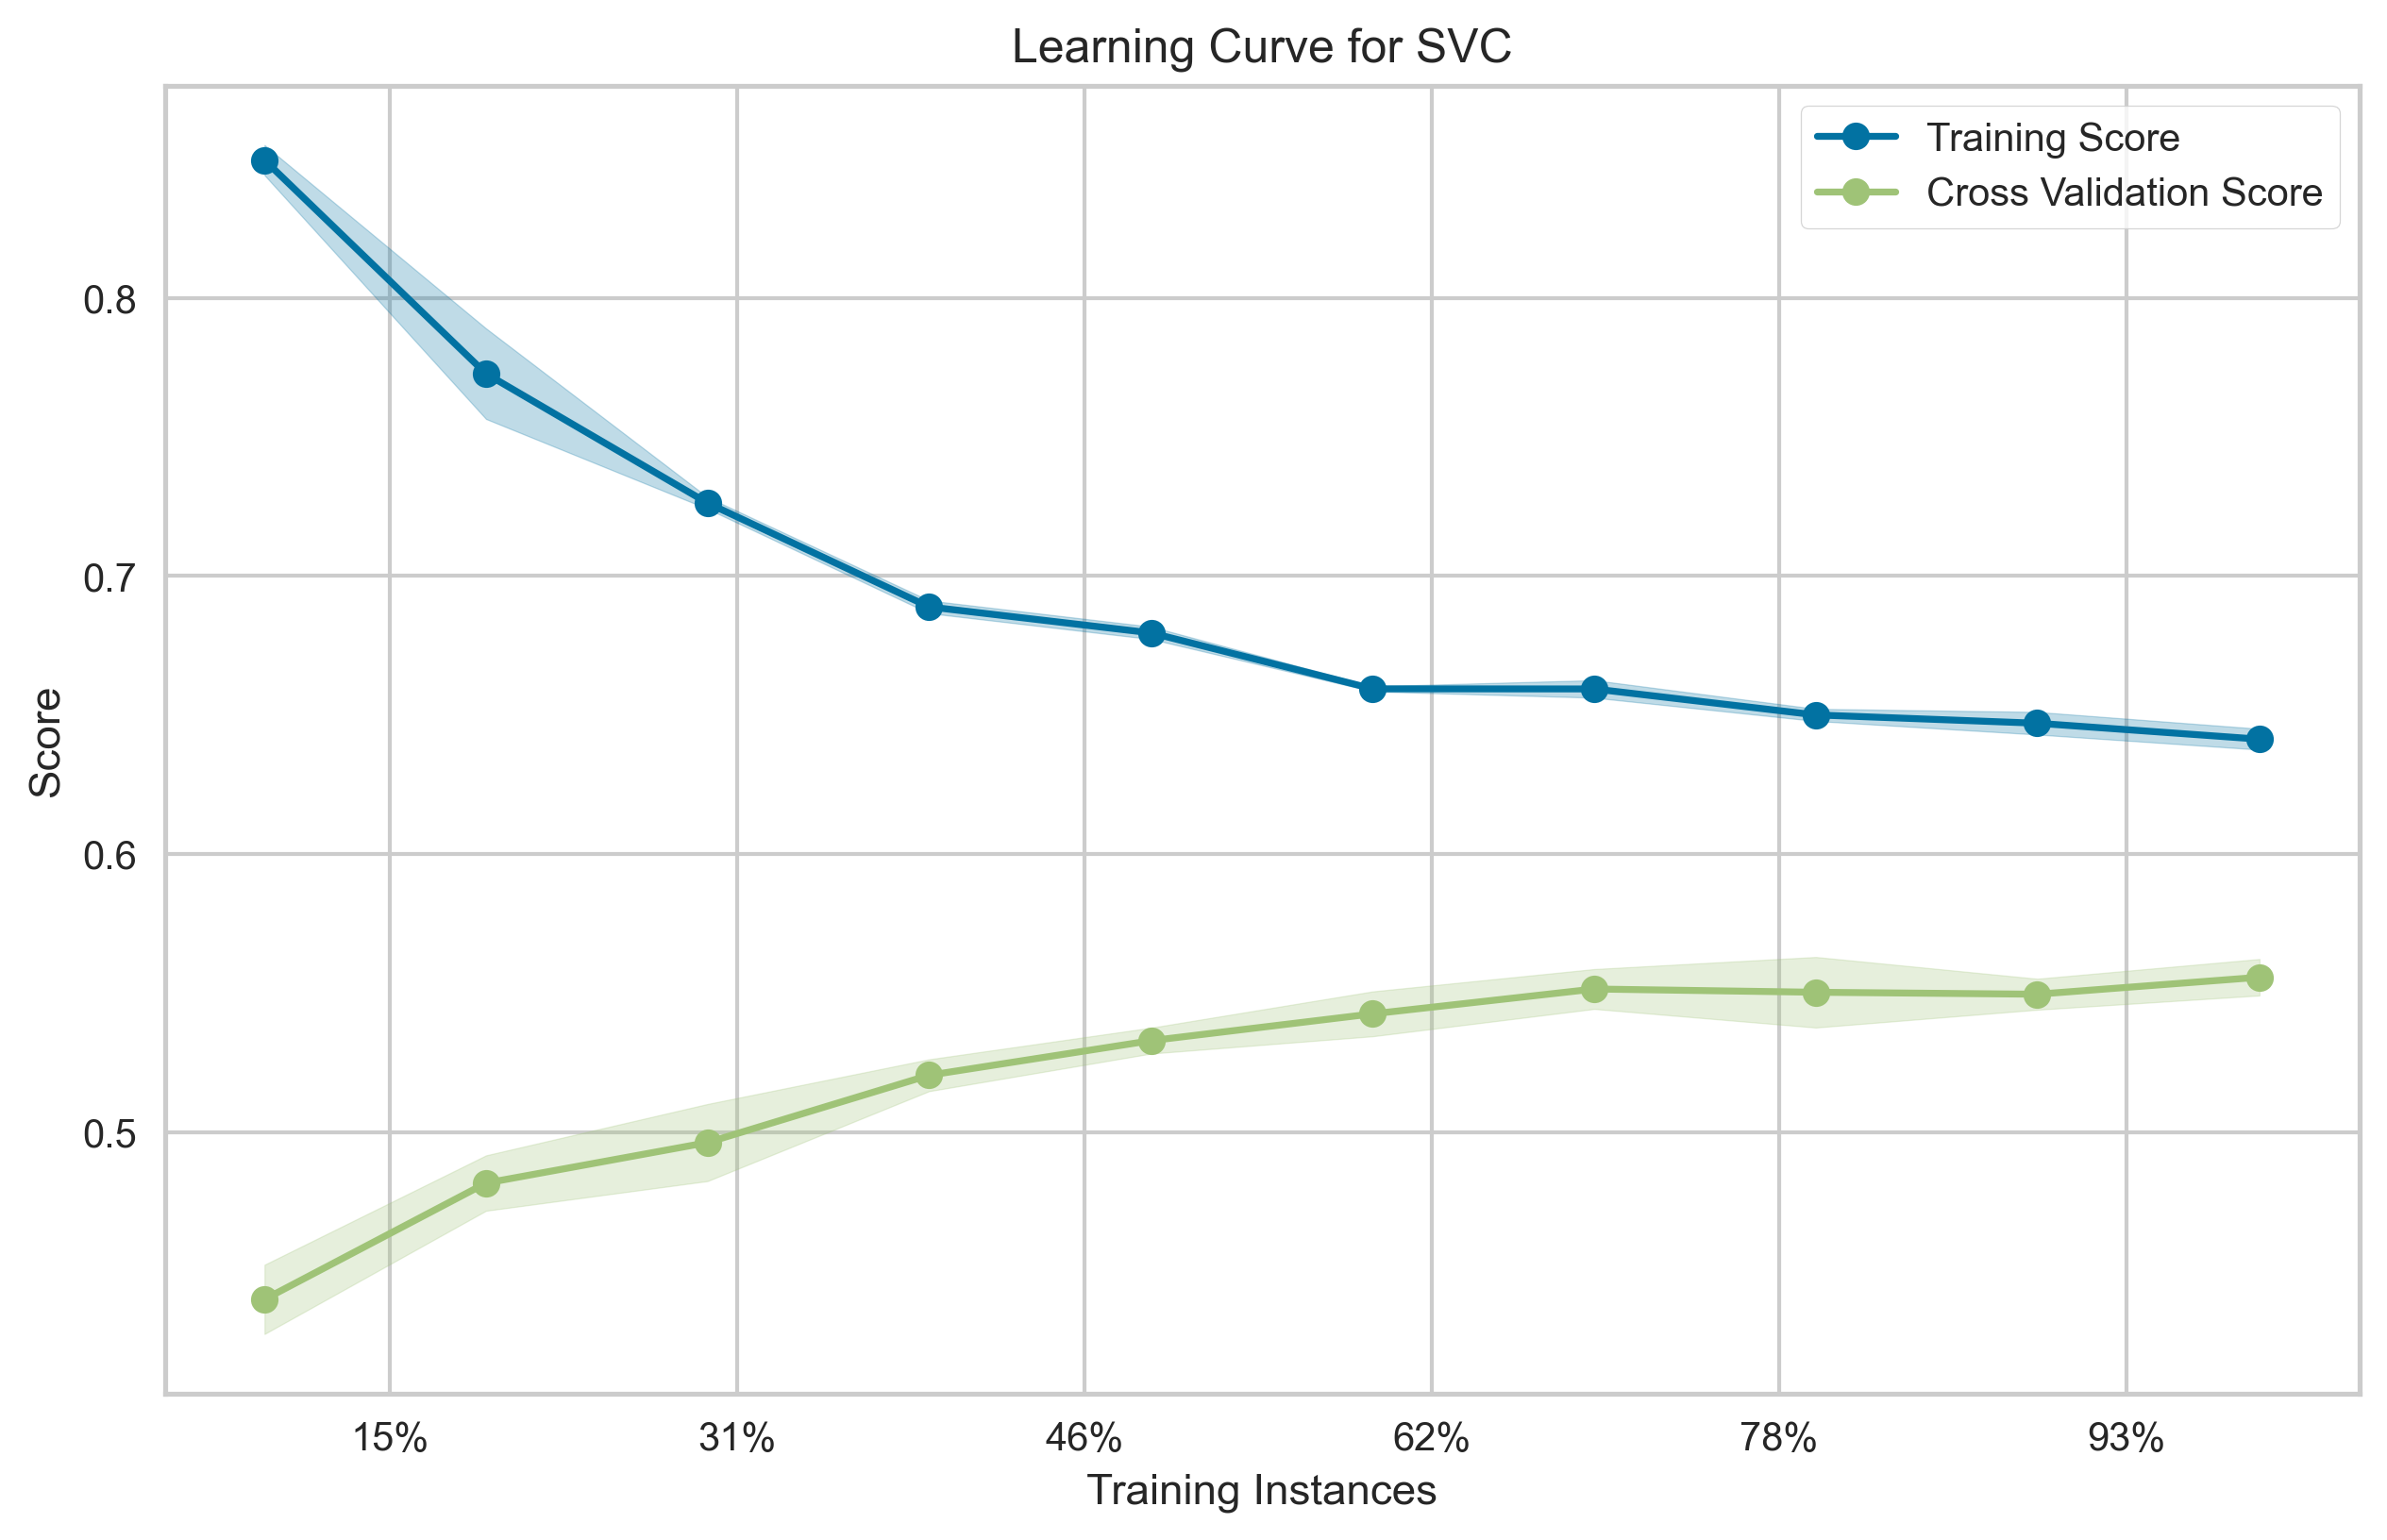

In [67]:
best_svm_clf = instantiate_best_svm_clf()
viz.learning_curve(clf=best_svm_clf,
                   X_tr=X_train_n,
                   y_tr=y_train,
                   cv=CV,
                   scoring=F1_SCORE,
                   output_path=f"{WINE_SVM_PATH}/svm_learning_curve.png")

/Users/pavponn/opt/anaconda3/envs/assignment-1/lib/python3.10/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


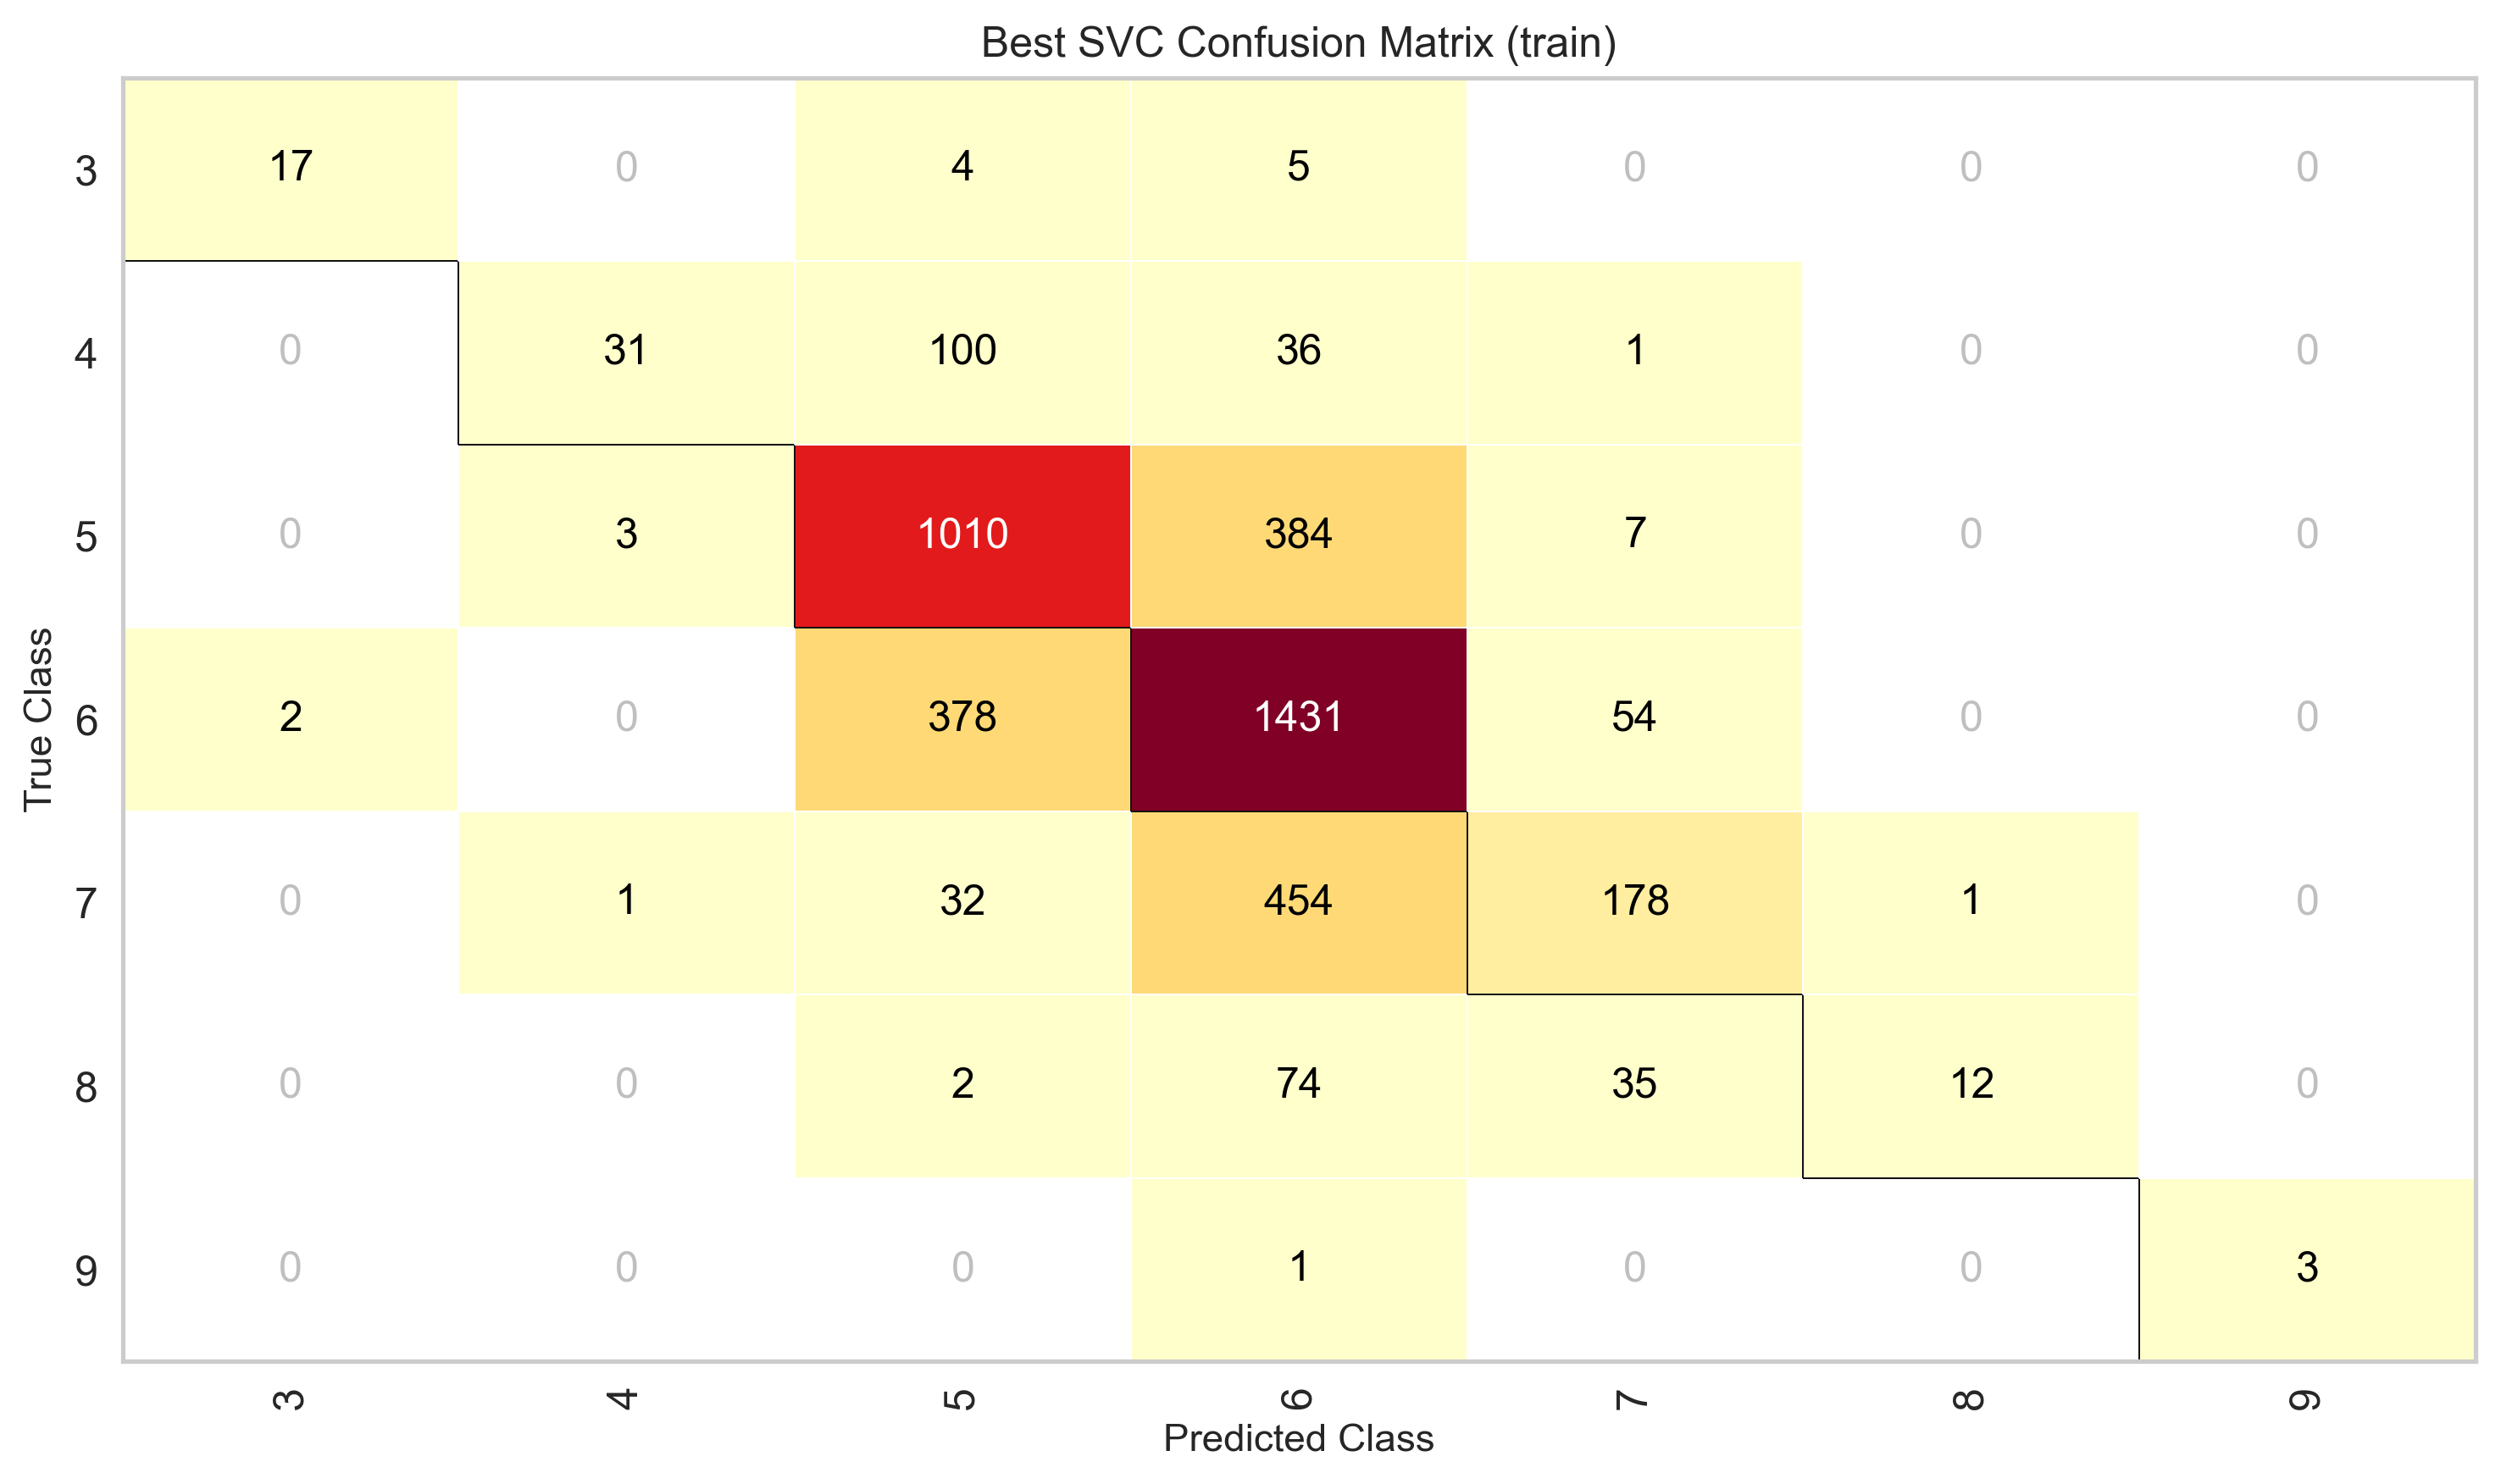

In [68]:
best_svm_clf = instantiate_best_svm_clf()
best_svm_clf.fit(X_train_n, y_train)

viz.confusion_matrix(
    clf=best_svm_clf,
    X=X_train_n,
    y=y_train,
    title='Best SVC Confusion Matrix (train)',
    output_path=f'{WINE_SVM_PATH}/best_svm_train_confusion_matrix.png'
)

/Users/pavponn/opt/anaconda3/envs/assignment-1/lib/python3.10/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


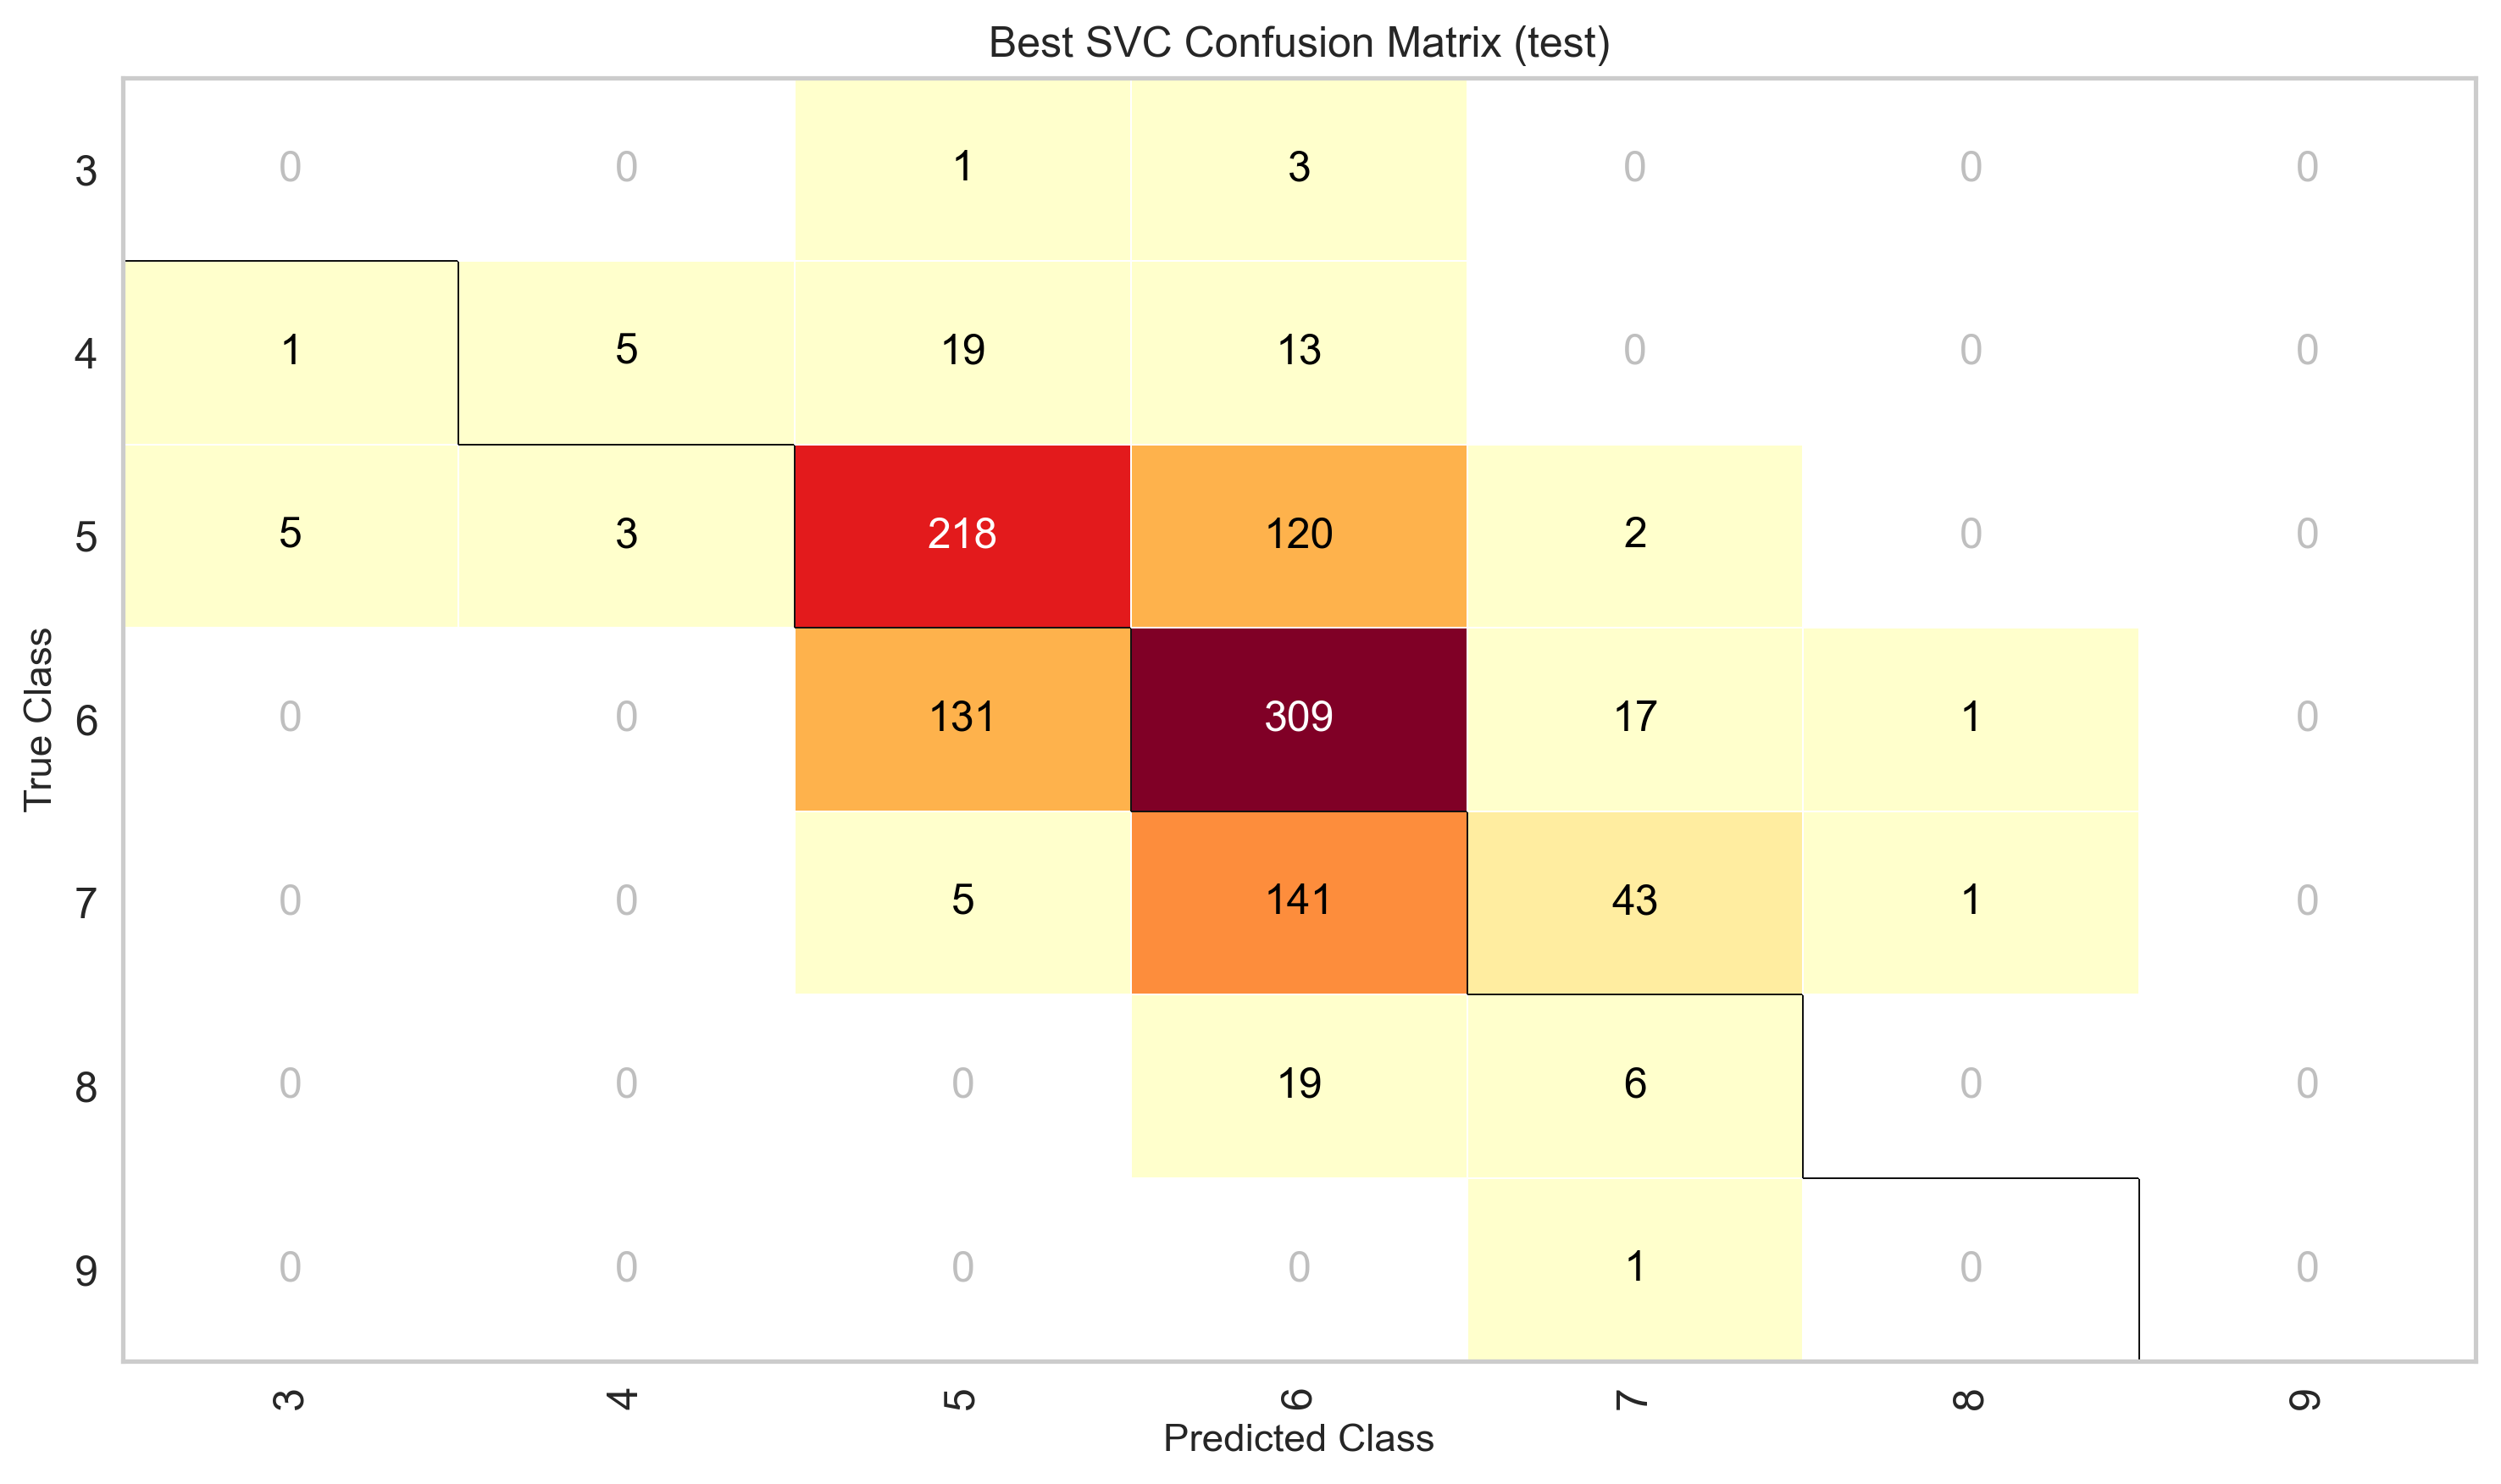

In [69]:
viz.confusion_matrix(
    clf=best_svm_clf,
    X=X_test_n,
    y=y_test,
    title='Best SVC Confusion Matrix (test)',
    output_path=f'{WINE_SVM_PATH}/best_svm_test_confusion_matrix.png'
)

In [70]:
metrics.f1_score_stats(clf=best_svm_clf, X_tr=X_train_n, X_t=X_test_n, y_tr=y_train, y_t=y_test, averaging=F1_AVERAGING)


F1-Score, micro (train): 0.6302
F1-Score, micro (test) : 0.5404


In [71]:
best_svm_clf = instantiate_best_svm_clf()
training.learning_time_stats(best_svm_clf, X_tr=X_train_n, y_tr=y_train)

Training time, total: 12.3855 seconds
Training time, normalized (per 1000 samples): 2.9101 seconds


In [73]:
training.inference_time_stats(best_svm_clf, X_train_n, proba=False, dataset_name='train')
training.inference_time_stats(best_svm_clf, X_test_n, proba=False, dataset_name='test')
training.inference_time_stats(best_svm_clf, X_all_n, proba=False, dataset_name='all')

Inference time (train), total: 0.5302 seconds
Inference time (train), normalized (per 1000 samples): 0.1246 seconds
Inference time (test), total: 0.1374 seconds
Inference time (test), normalized (per 1000 samples): 0.1291 seconds
Inference time (all), total: 0.8163 seconds
Inference time (all), normalized (per 1000 samples): 0.1534 seconds


# Neural Network

### Plan

1. Train baseline boosting without hyperparameter tuning, look at the precision/recall at train and test sets
2. Validate how different individual hyperparameters affect performance of the model wrt recall@precision
    a. `Hidden Layer Size (width & depth)`
    b. `TODO`
3. Perform hyperparameter tuning of multiple parameters
4. Analyse performance of the best decision tree with hyperparameter tuning

In [74]:
WINE_MLP_PATH = f'{WINE_PATH}/mlp'

In [75]:
NUMBER_OF_FEATURES = 13
baseline_mlp_clf = MLPClassifier(random_state=SEED, hidden_layer_sizes=[NUMBER_OF_FEATURES], max_iter=1000)
baseline_mlp_clf.fit(X_train_n, y_train)

MLPClassifier(hidden_layer_sizes=[13], max_iter=1000, random_state=42)

/Users/pavponn/opt/anaconda3/envs/assignment-1/lib/python3.10/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


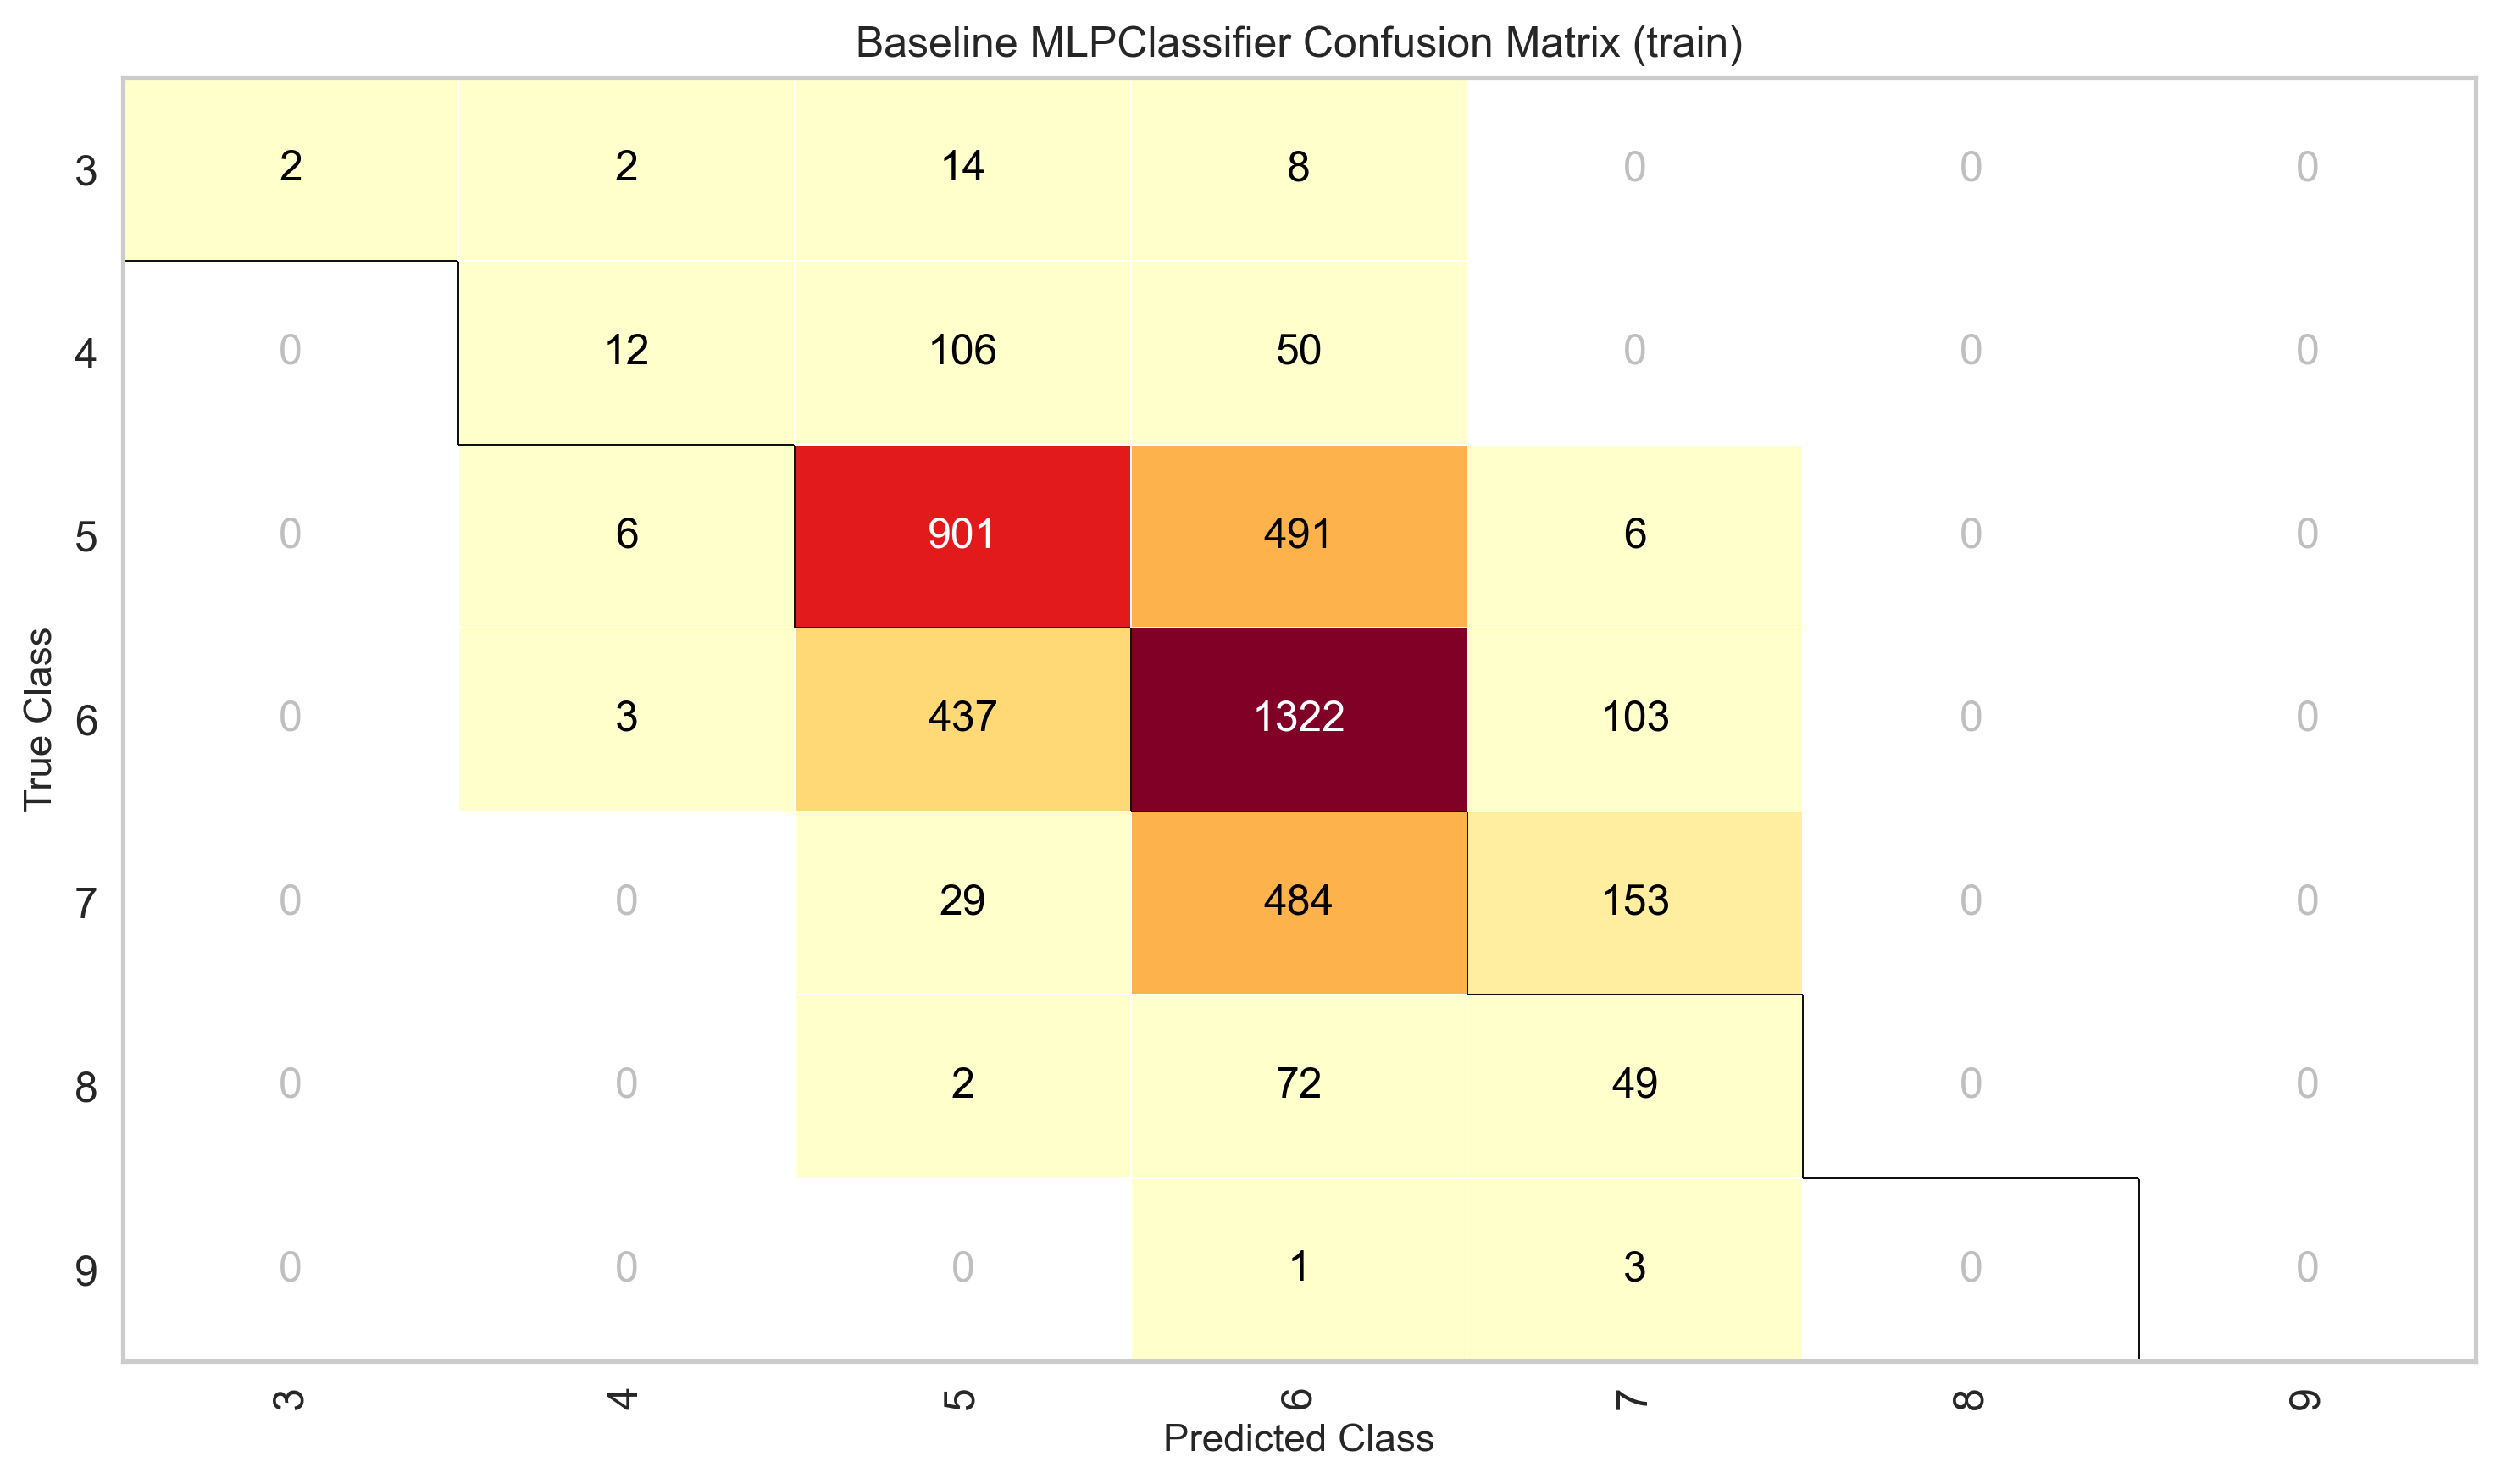

In [76]:
viz.confusion_matrix(
    clf=baseline_mlp_clf,
    X=X_train_n,
    y=y_train,
    title='Baseline MLPClassifier Confusion Matrix (train)',
    output_path=f'{WINE_MLP_PATH}/baseline_mlp_train_confusion_matrix.png'
)

/Users/pavponn/opt/anaconda3/envs/assignment-1/lib/python3.10/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


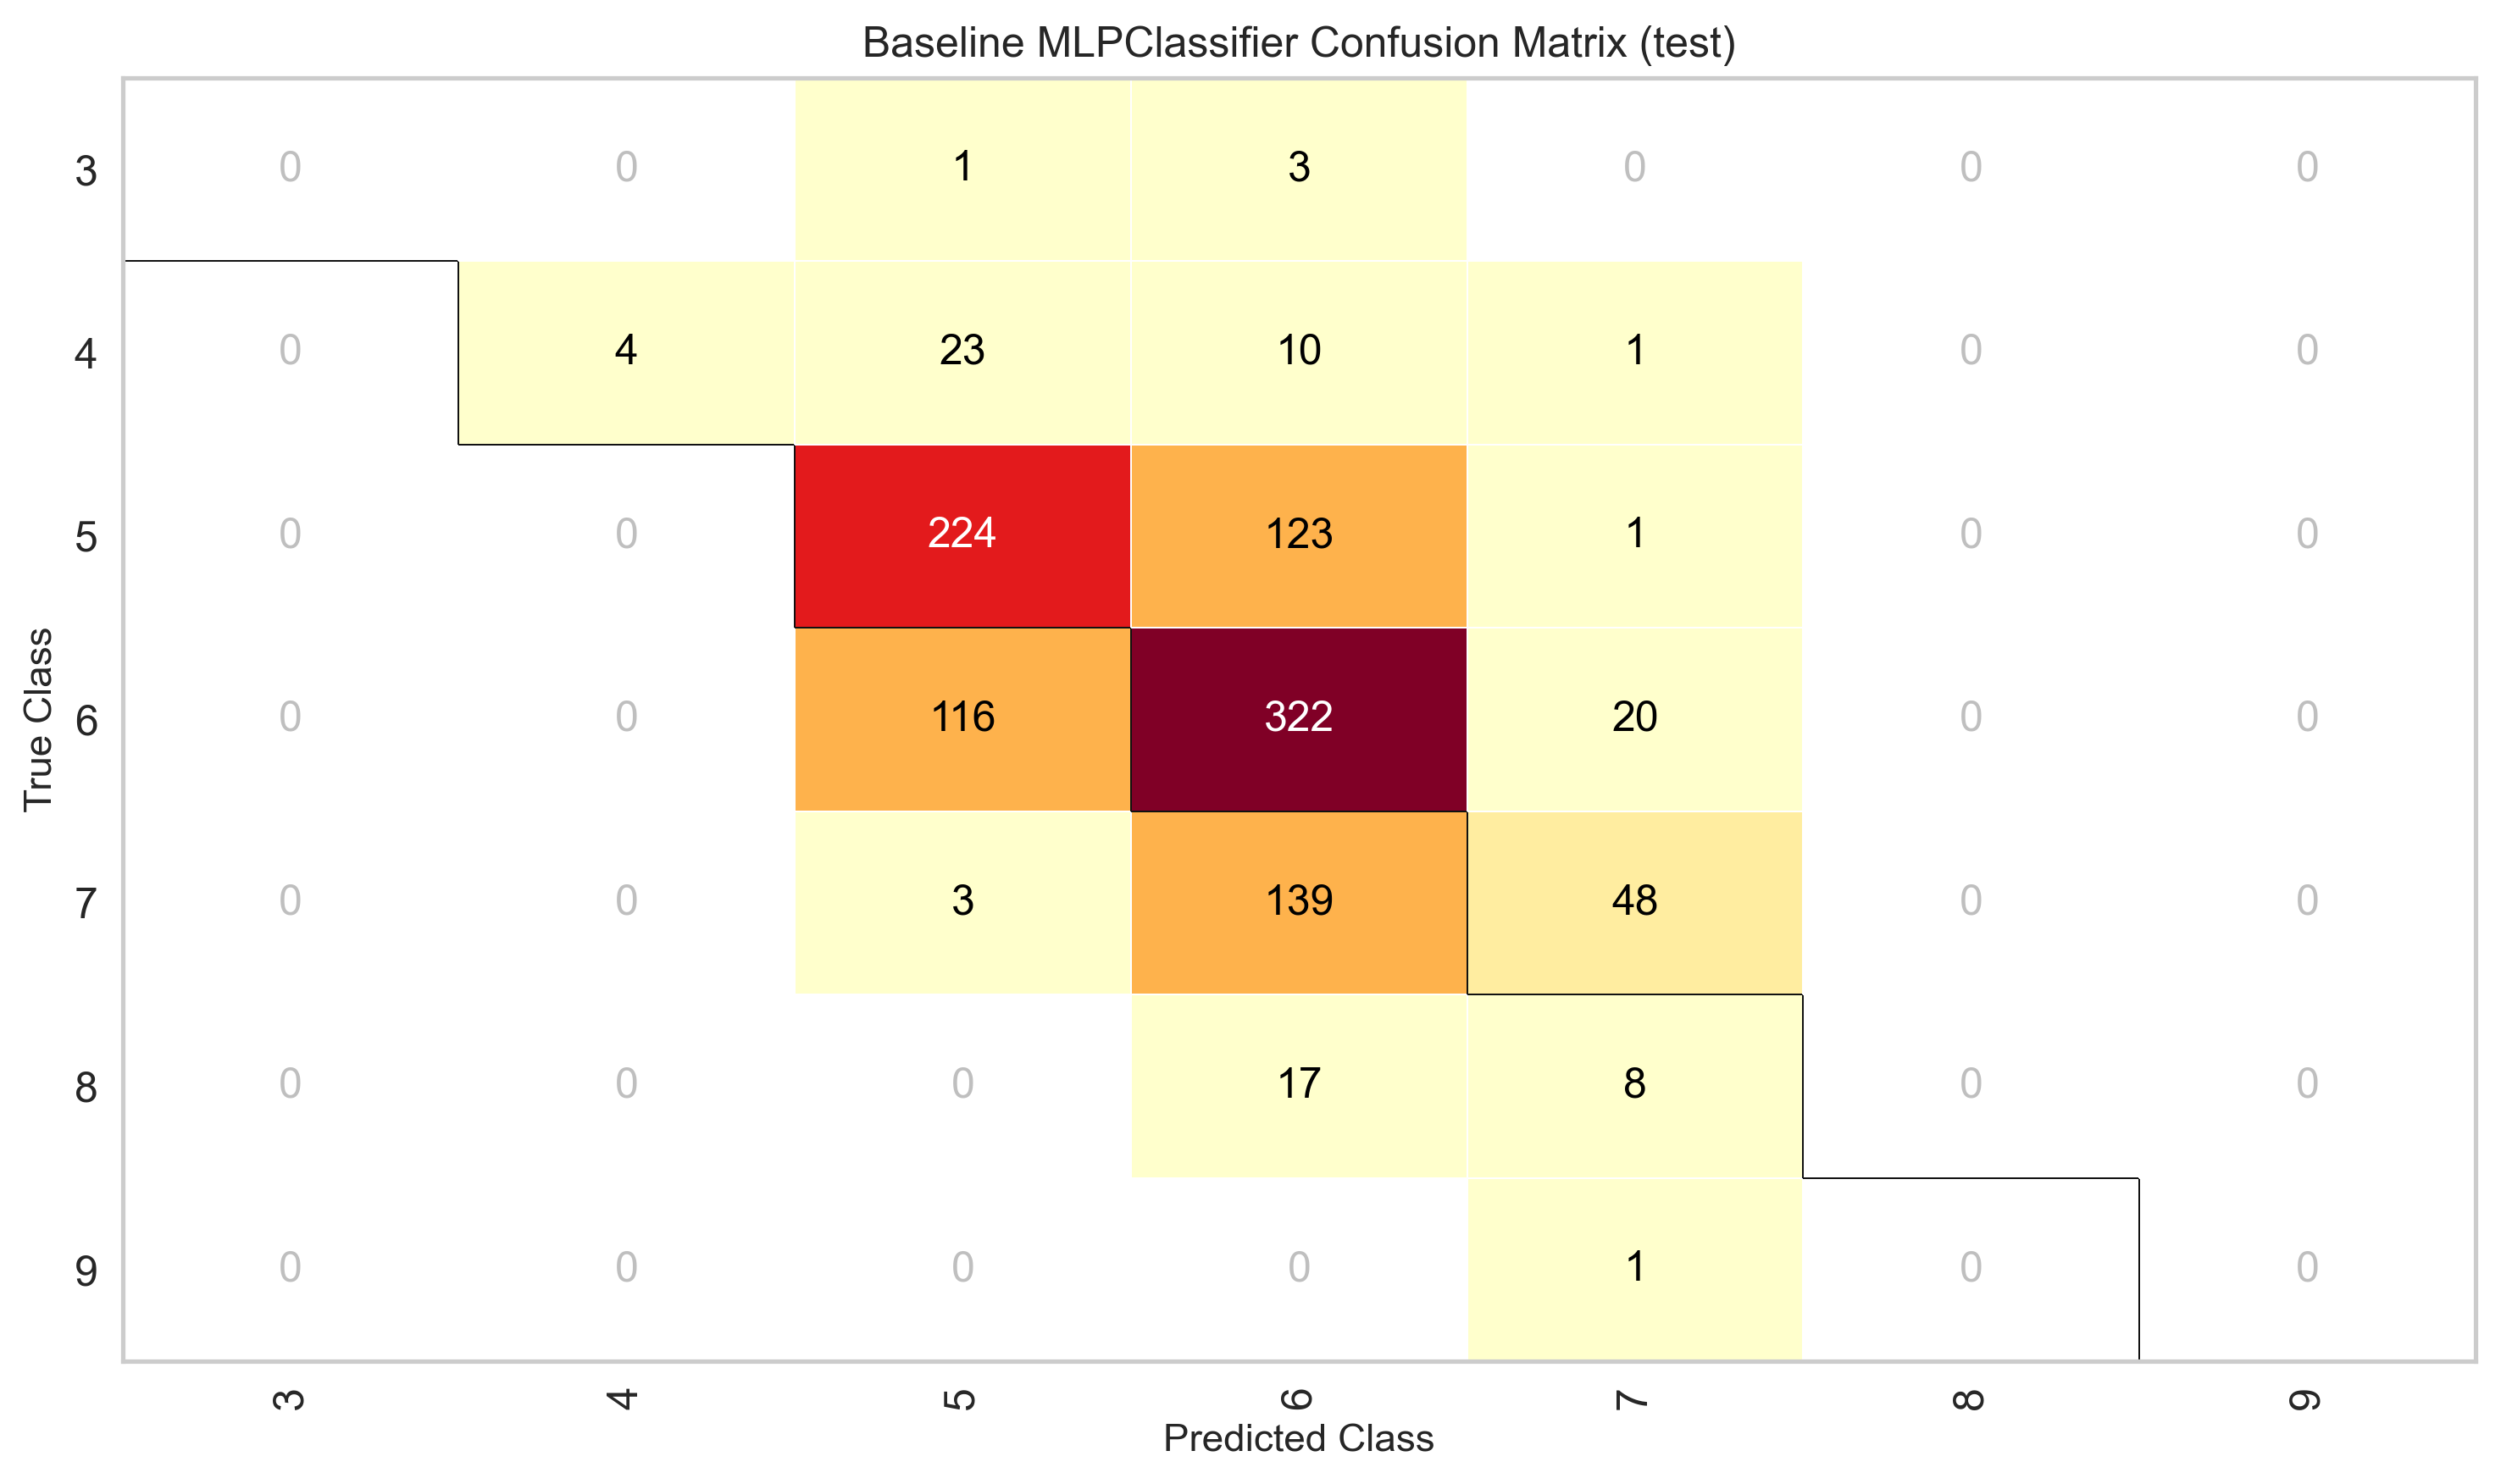

In [77]:
viz.confusion_matrix(
    clf=baseline_mlp_clf,
    X=X_test_n,
    y=y_test,
    title='Baseline MLPClassifier Confusion Matrix (test)',
    output_path=f'{WINE_MLP_PATH}/baseline_mlp_test_confusion_matrix.png'
)

In [78]:
metrics.f1_score_stats(clf=baseline_mlp_clf, X_tr=X_train_n, X_t=X_test_n, y_tr=y_train, y_t=y_test,
                       averaging=F1_AVERAGING)


F1-Score, micro (train): 0.5616
F1-Score, micro (test) : 0.5620


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


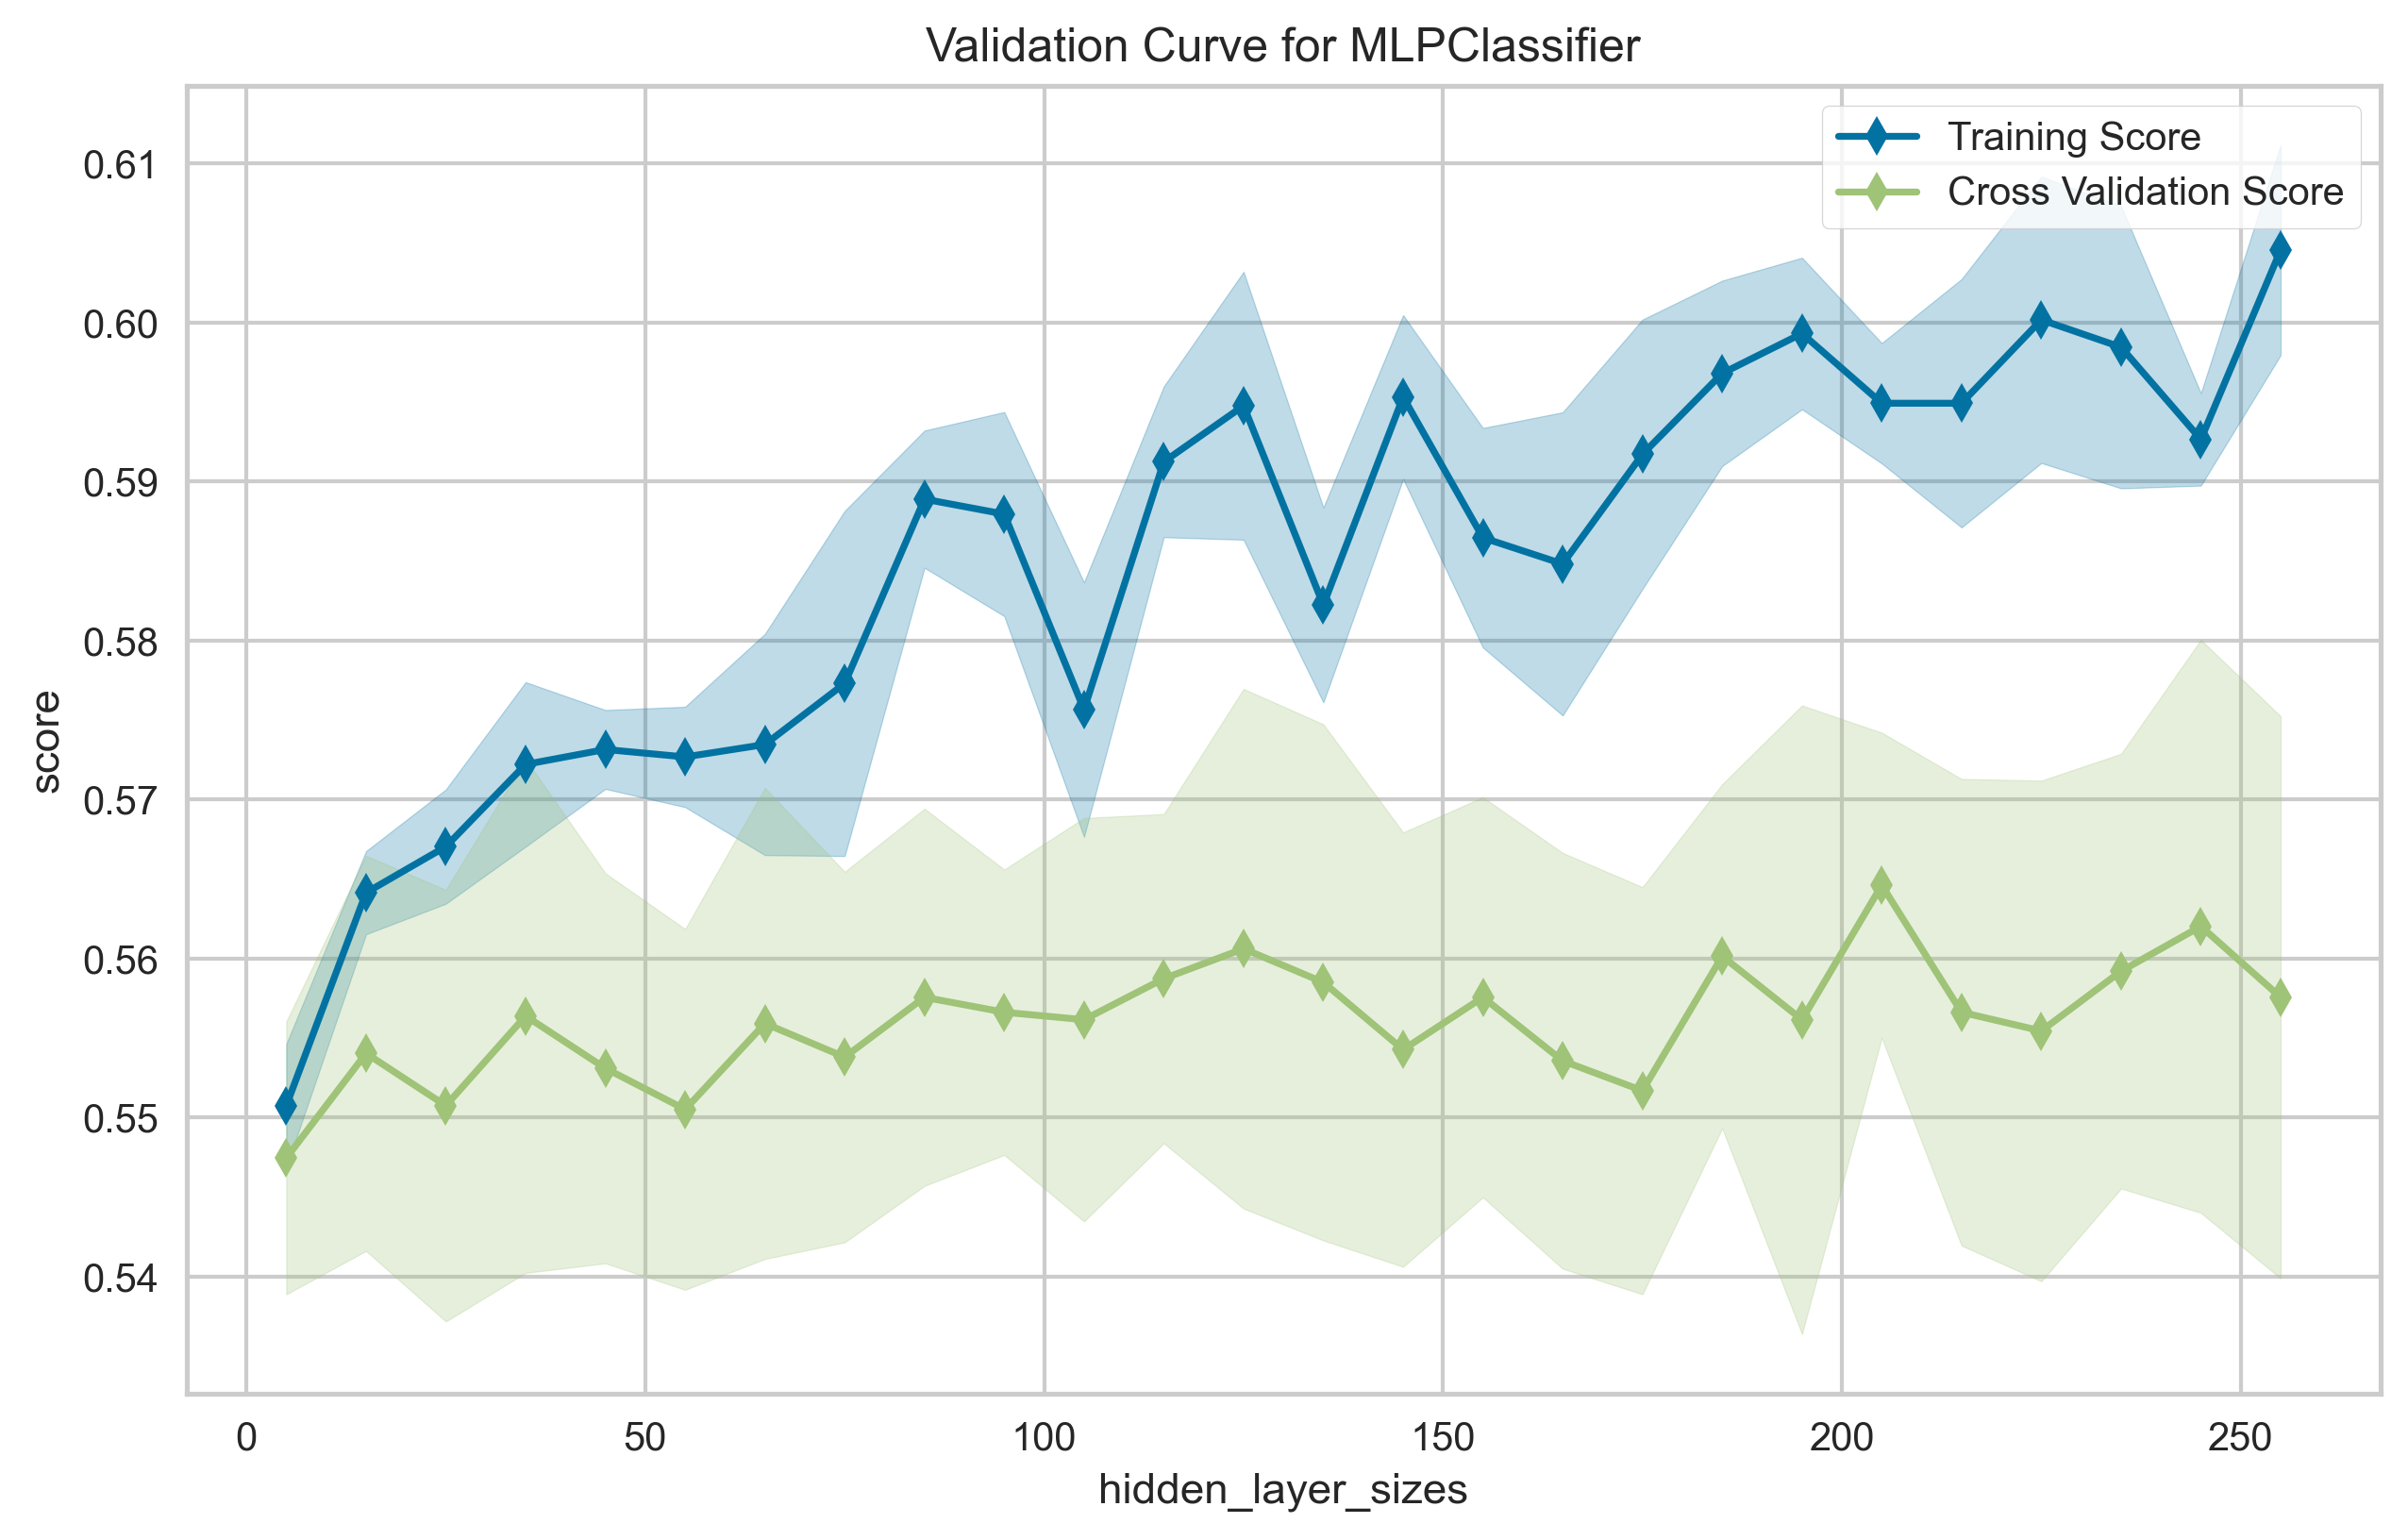

In [79]:
mlp_clf = MLPClassifier(random_state=SEED, max_iter=1000)
viz.validation_curve(
    clf=mlp_clf,
    X_tr=X_train_n,
    y_tr=y_train,
    cv=CV,
    param_name="hidden_layer_sizes",
    param_range=np.arange(5, 256, 10),
    output_path=f"{WINE_MLP_PATH}/mlp_hidden_height.png",
    scoring=F1_SCORE,
)

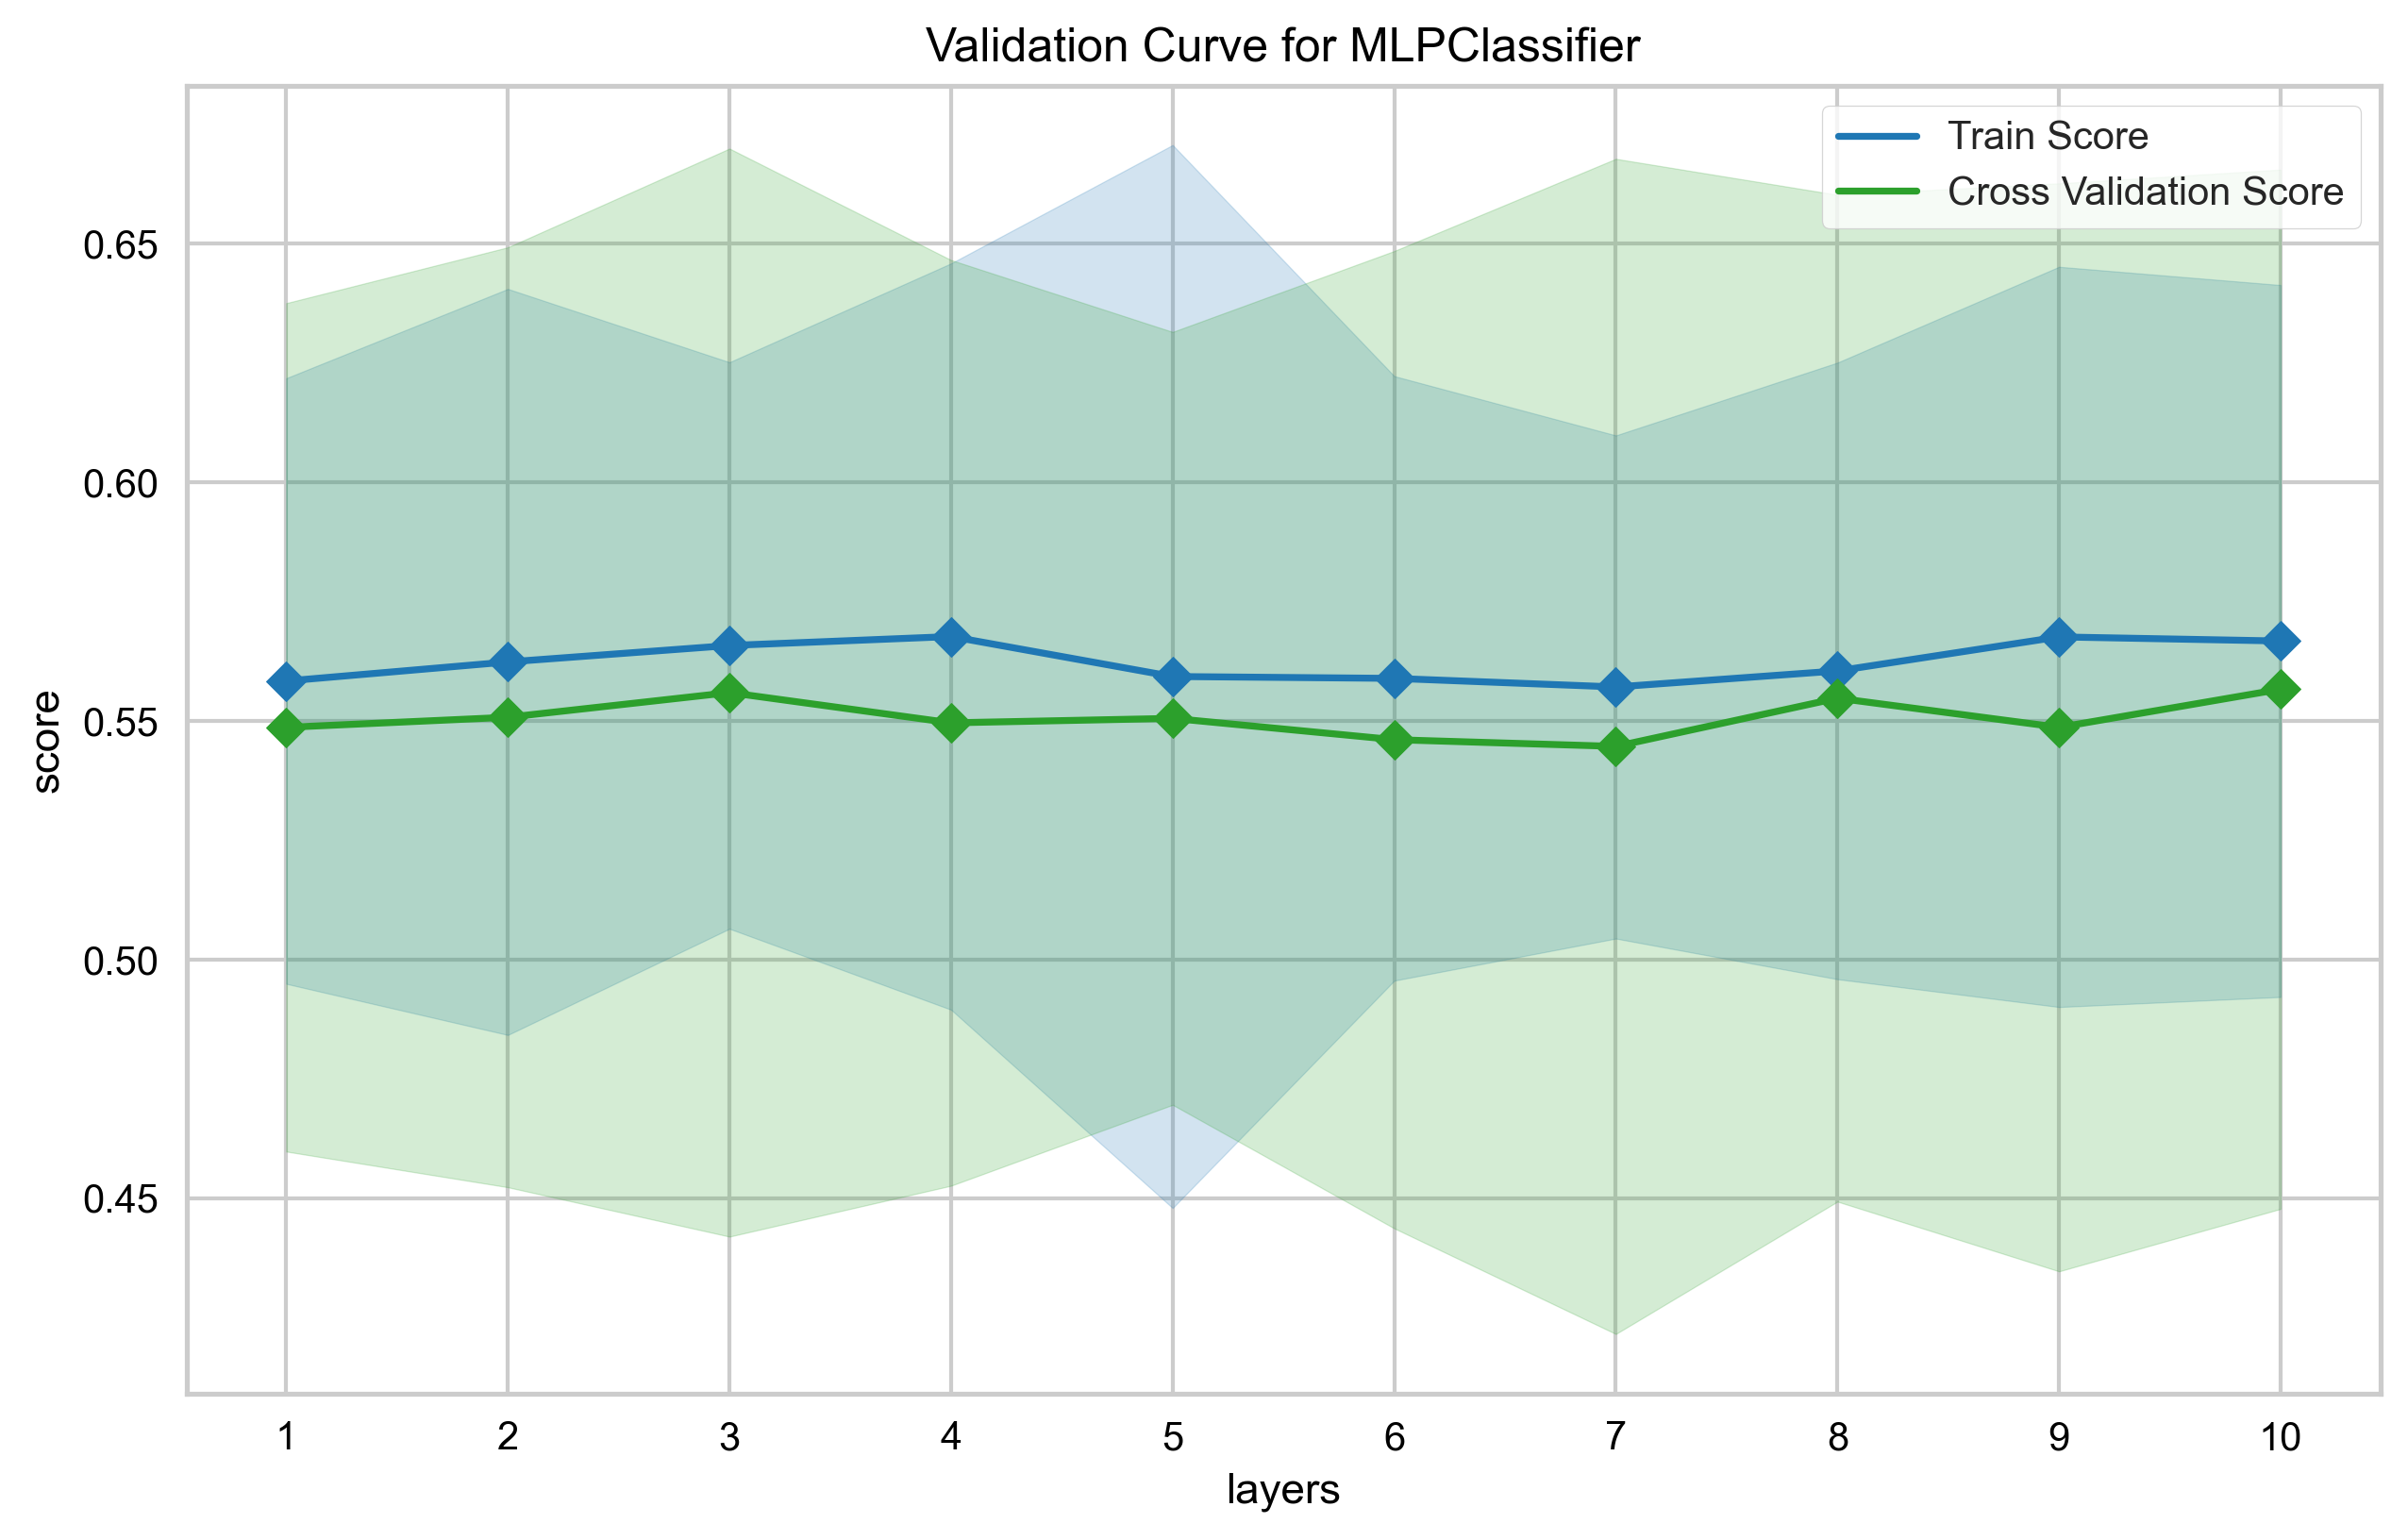

In [80]:
mlp_clf = MLPClassifier(random_state=SEED, max_iter=1000)

layers_range = np.arange(1, 11, 1)
param_range = [(NUMBER_OF_FEATURES,) * num_layers for num_layers in layers_range]

viz.validation_curve_complex(
    clf=mlp_clf,
    X_tr=X_train_n,
    y_tr=y_train,
    cv=CV,
    param_name="hidden_layer_sizes",
    param_name_print="layers",
    param_range=param_range,
    param_range_print=layers_range,
    output_path=f"{WINE_MLP_PATH}/mlp_hidden_width.png",
    legend_loc='upper right',
    scoring=F1_SCORE,
)

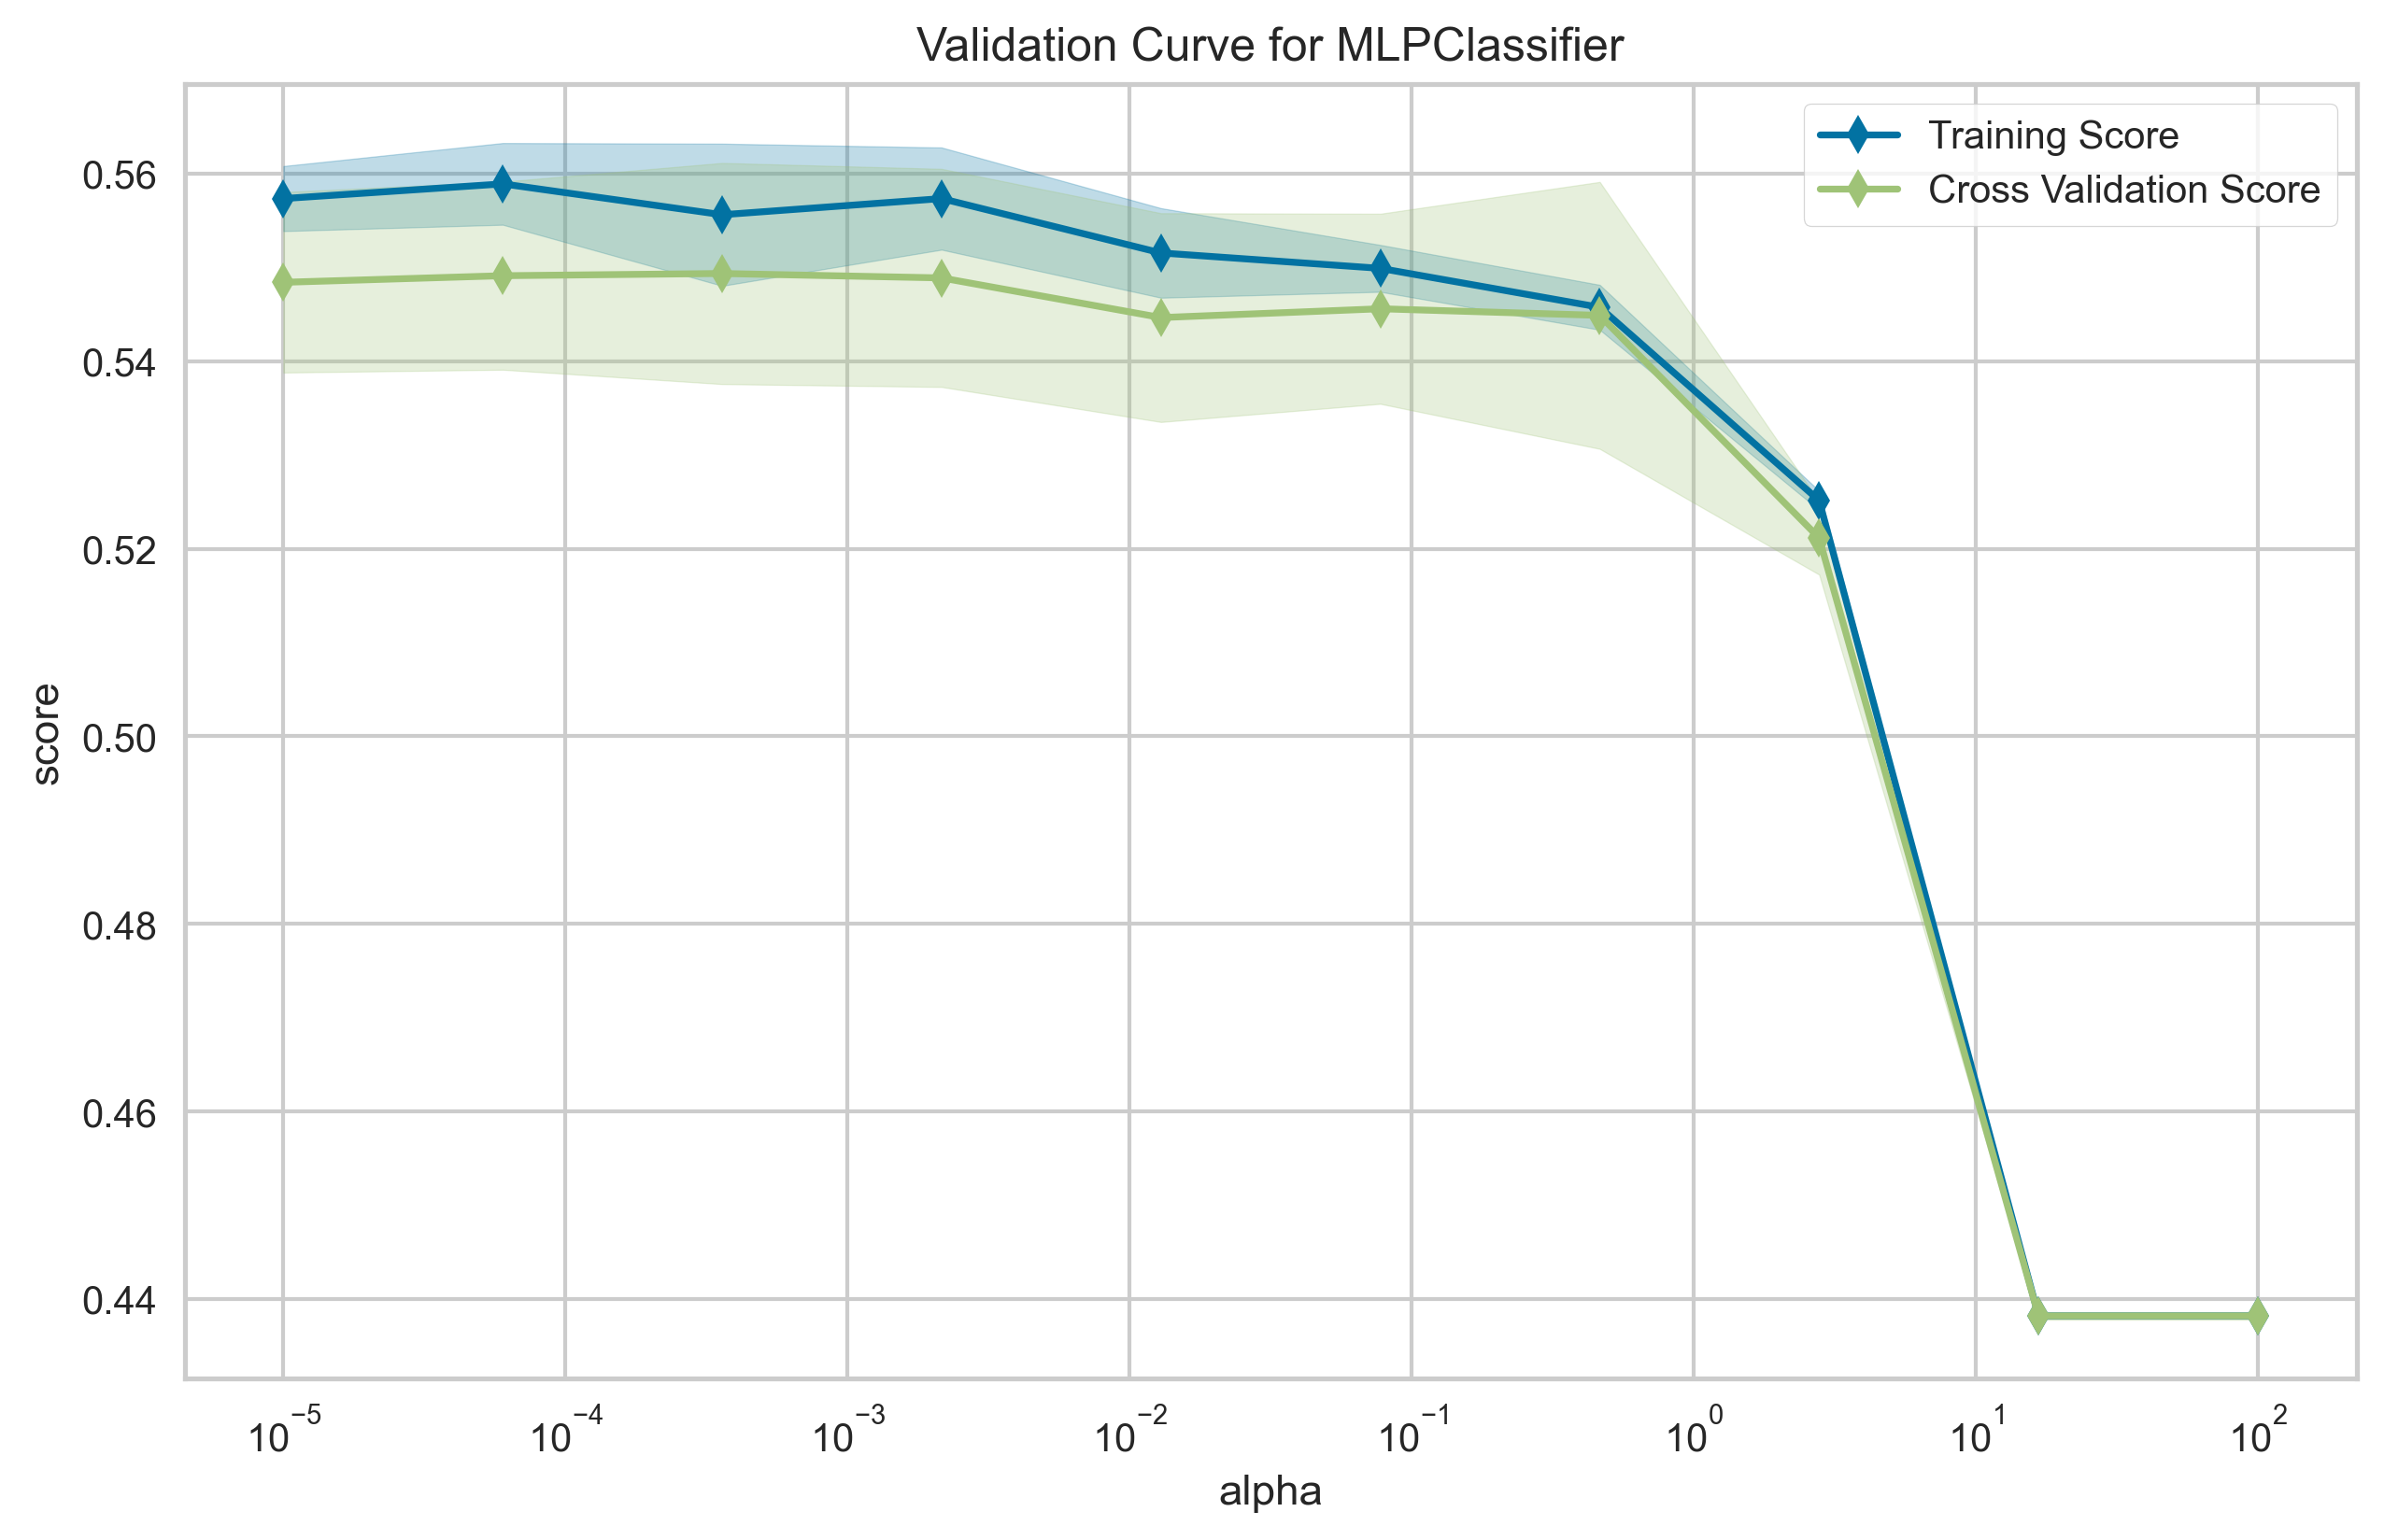

In [81]:
mlp_clf = MLPClassifier(random_state=SEED, hidden_layer_sizes=[NUMBER_OF_FEATURES], max_iter=1000)
viz.validation_curve(
    clf=mlp_clf,
    X_tr=X_train_n,
    y_tr=y_train,
    cv=CV,
    param_name="alpha",
    param_range=np.logspace(-5, 2, 10),
    output_path=f"{WINE_MLP_PATH}/mlp_alpha.png",
    logx=True,
    scoring=F1_SCORE,
)

/Users/pavponn/opt/anaconda3/envs/assignment-1/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/pavponn/opt/anaconda3/envs/assignment-1/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/pavponn/opt/anaconda3/envs/assignment-1/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/pavponn/opt/anaconda3/envs/assignment-1/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reac

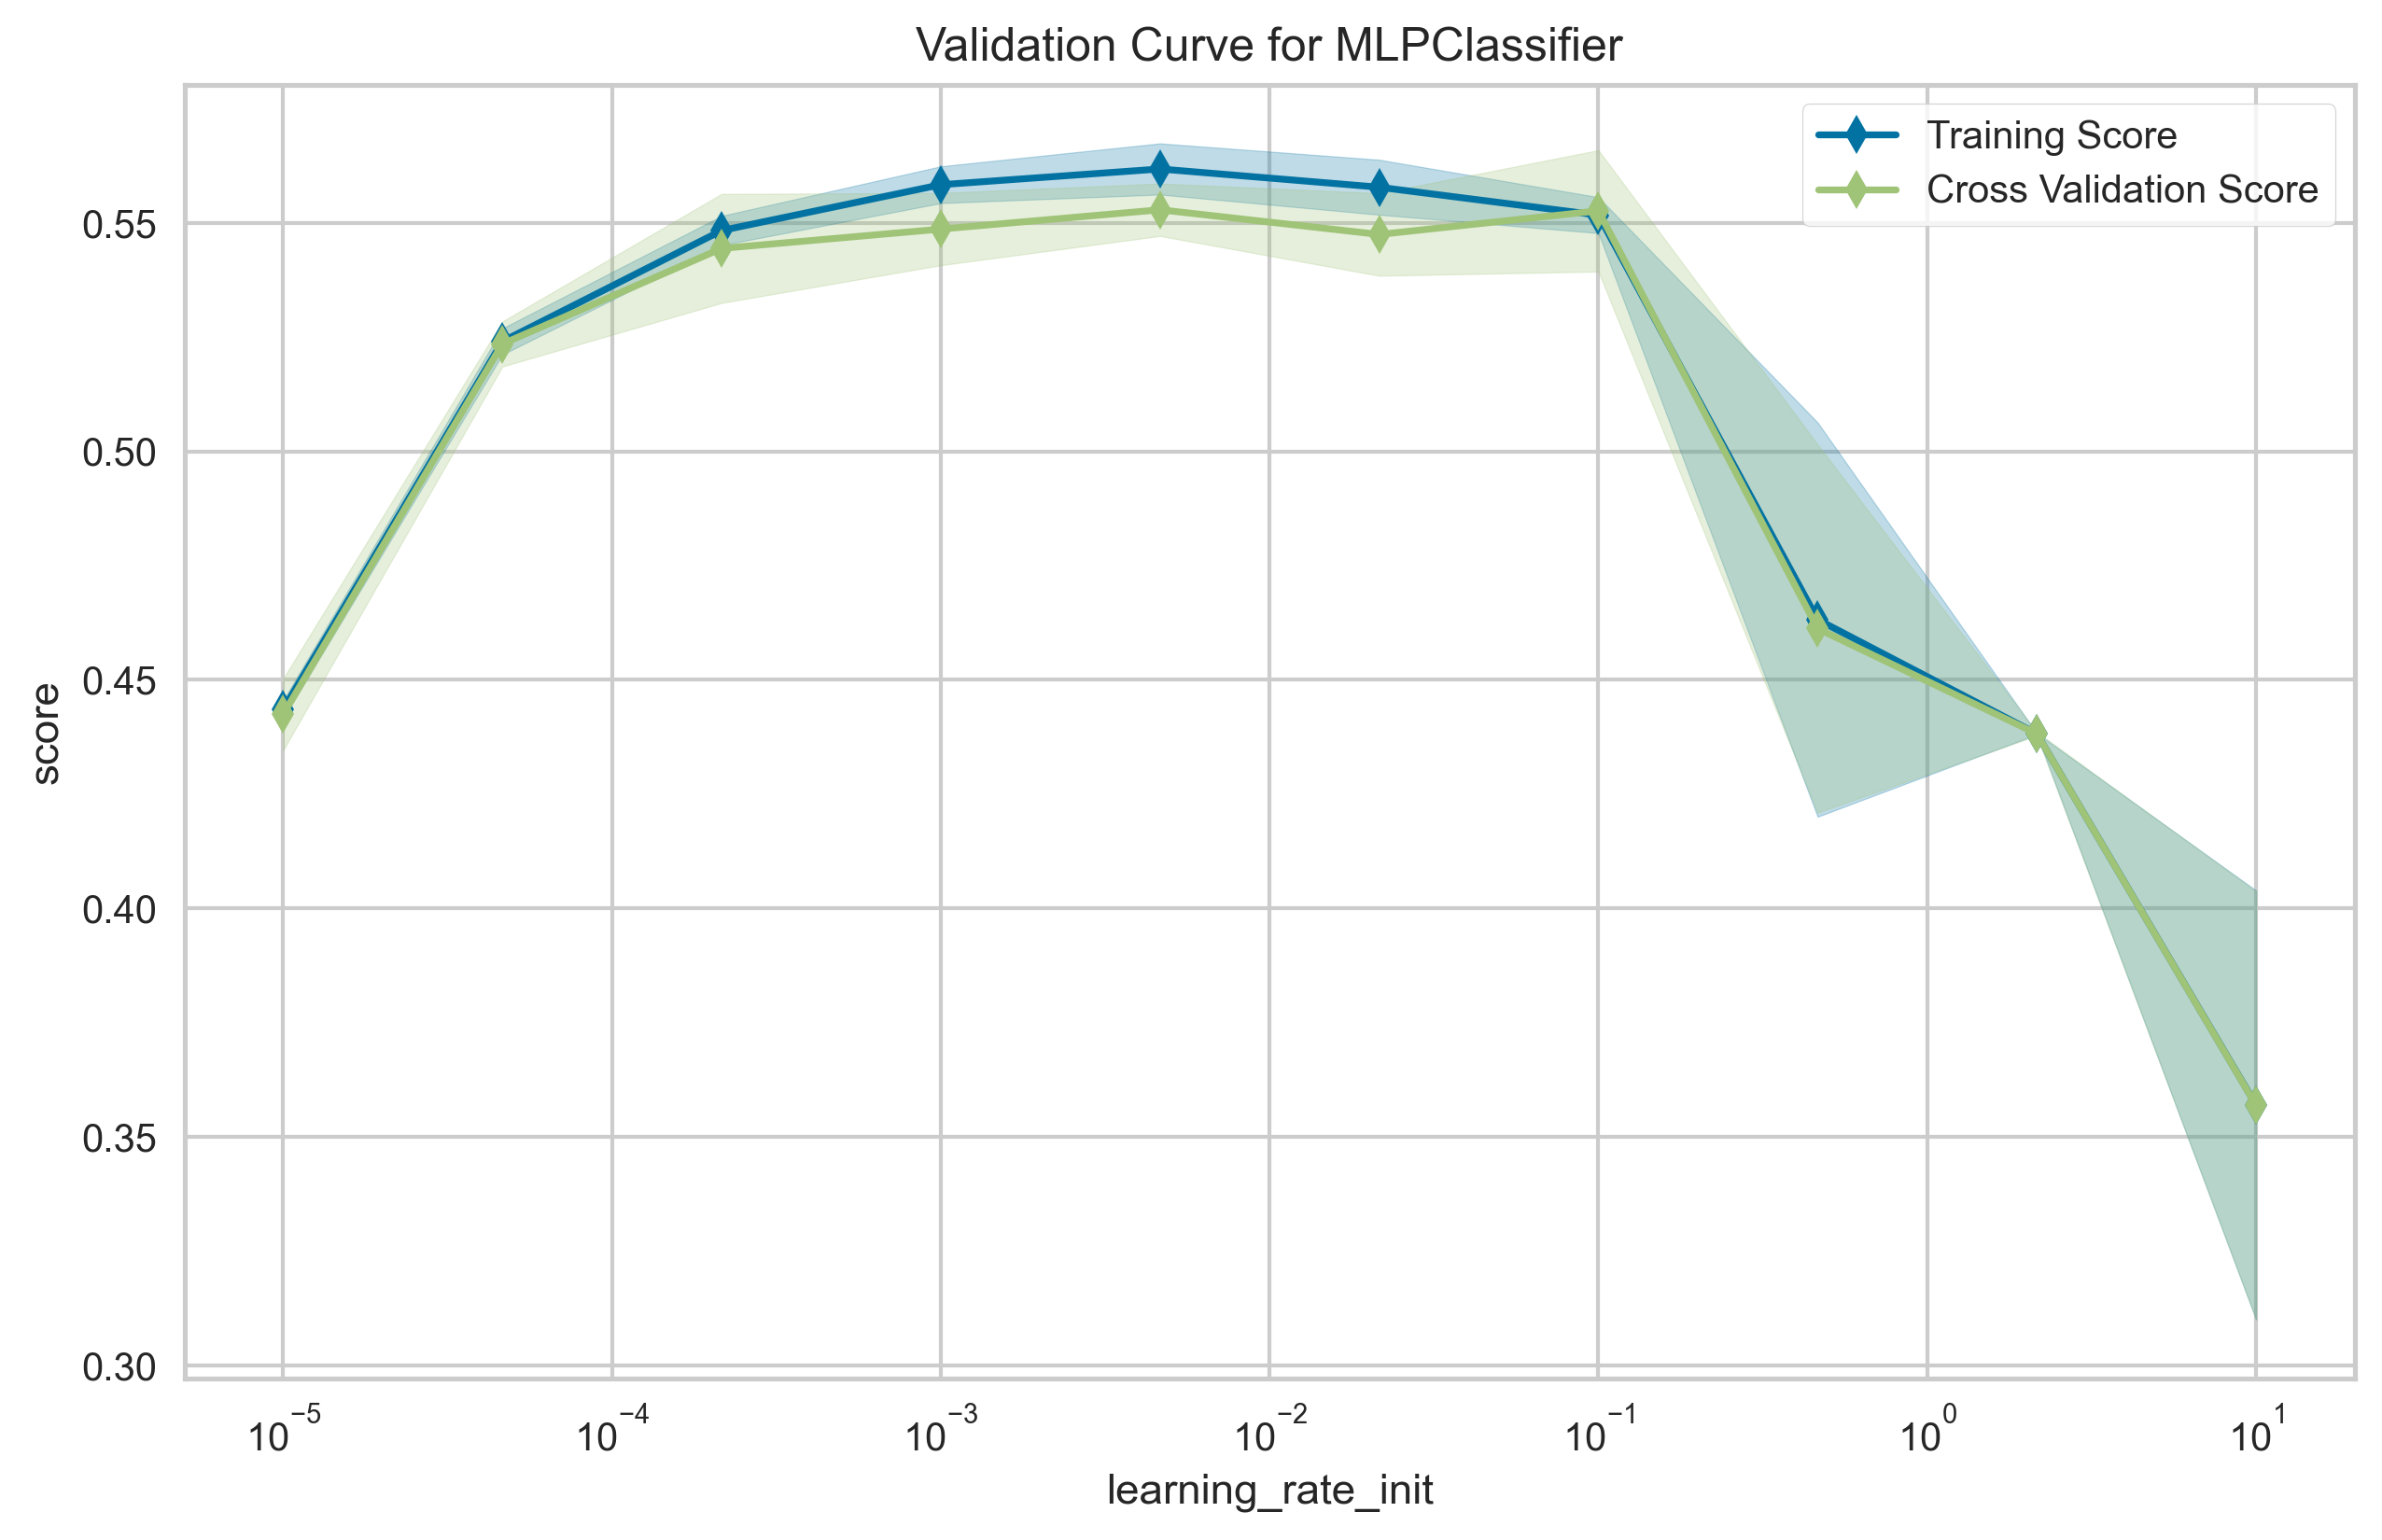

In [82]:
mlp_clf = MLPClassifier(random_state=SEED, hidden_layer_sizes=[NUMBER_OF_FEATURES], max_iter=1000)
viz.validation_curve(
    clf=mlp_clf,
    X_tr=X_train_n,
    y_tr=y_train,
    cv=CV,
    param_name="learning_rate_init",
    param_range=np.logspace(-5, 1, 10),
    output_path=f"{WINE_MLP_PATH}/mlp_learning_rate_init.png",
    logx=True,
    scoring=F1_SCORE,
)

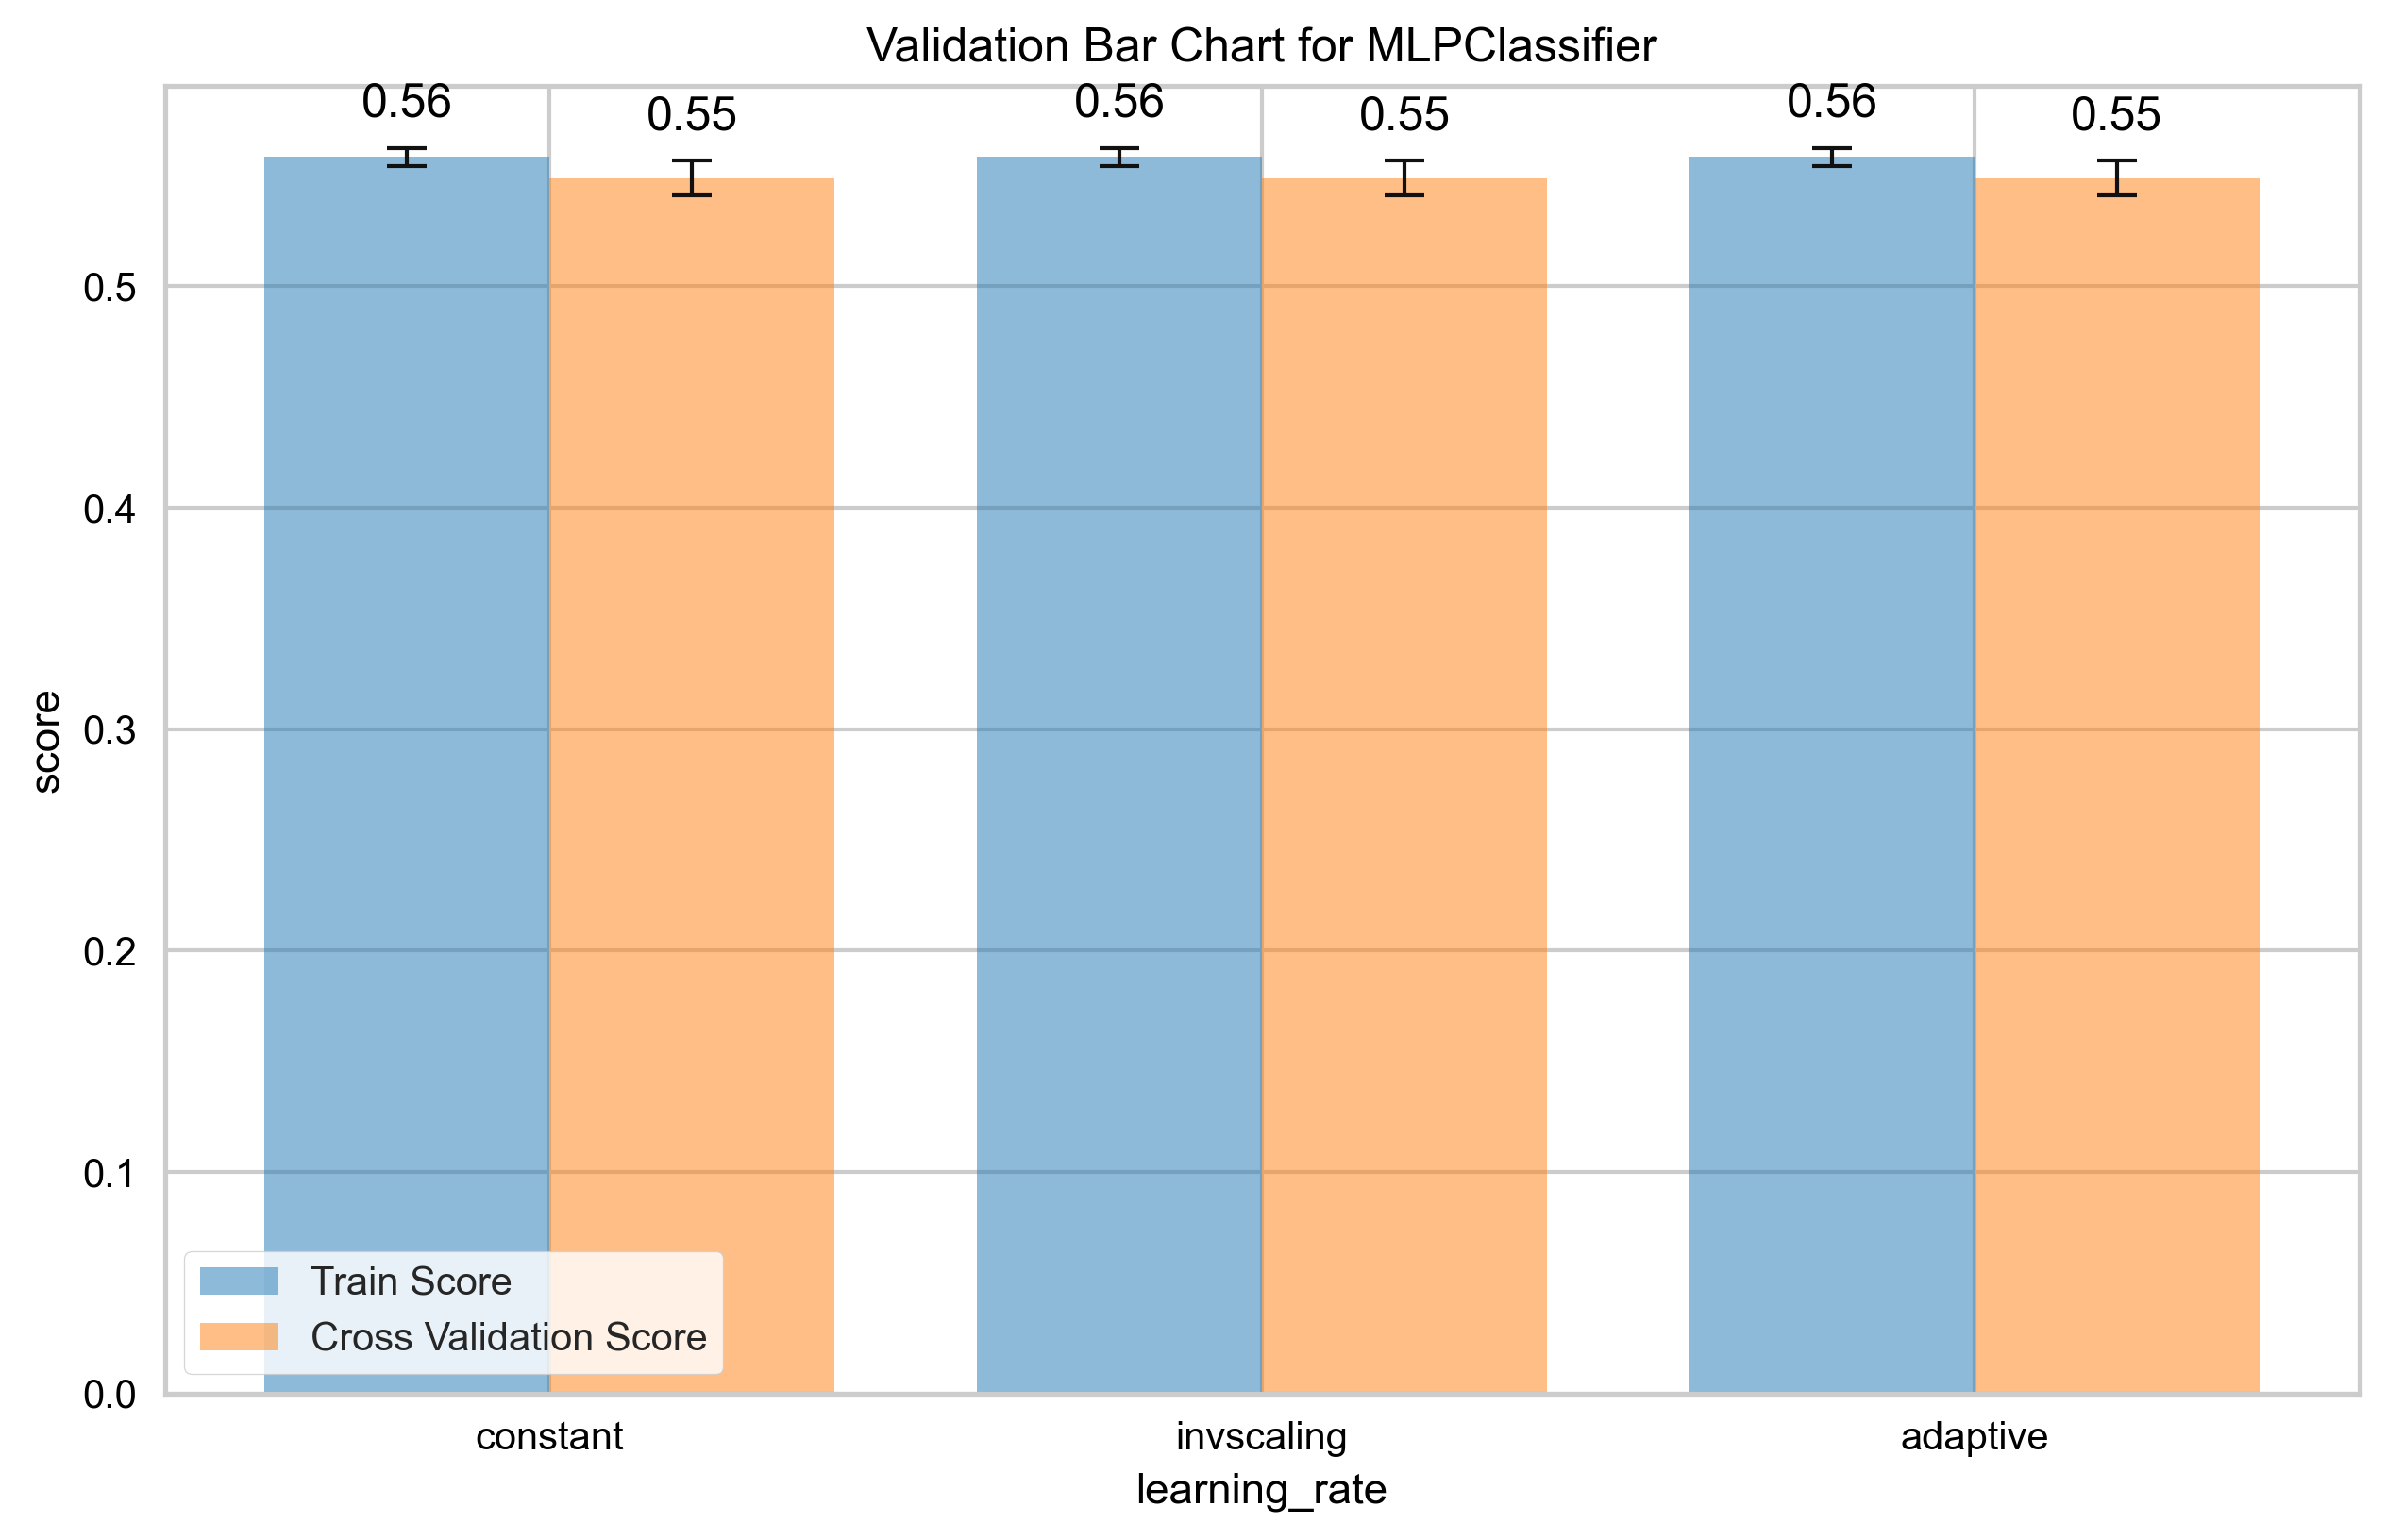

In [83]:
mlp_clf = MLPClassifier(random_state=SEED, hidden_layer_sizes=[NUMBER_OF_FEATURES], max_iter=1000)
viz.validation_bar_chart(
    clf=mlp_clf,
    X_tr=X_train_n,
    y_tr=y_train,
    cv=CV,
    param_name="learning_rate",
    param_range=['constant', 'invscaling', 'adaptive'],
    output_path=f"{WINE_MLP_PATH}/mlp_learning_rate.png",
    scoring=F1_SCORE,
)

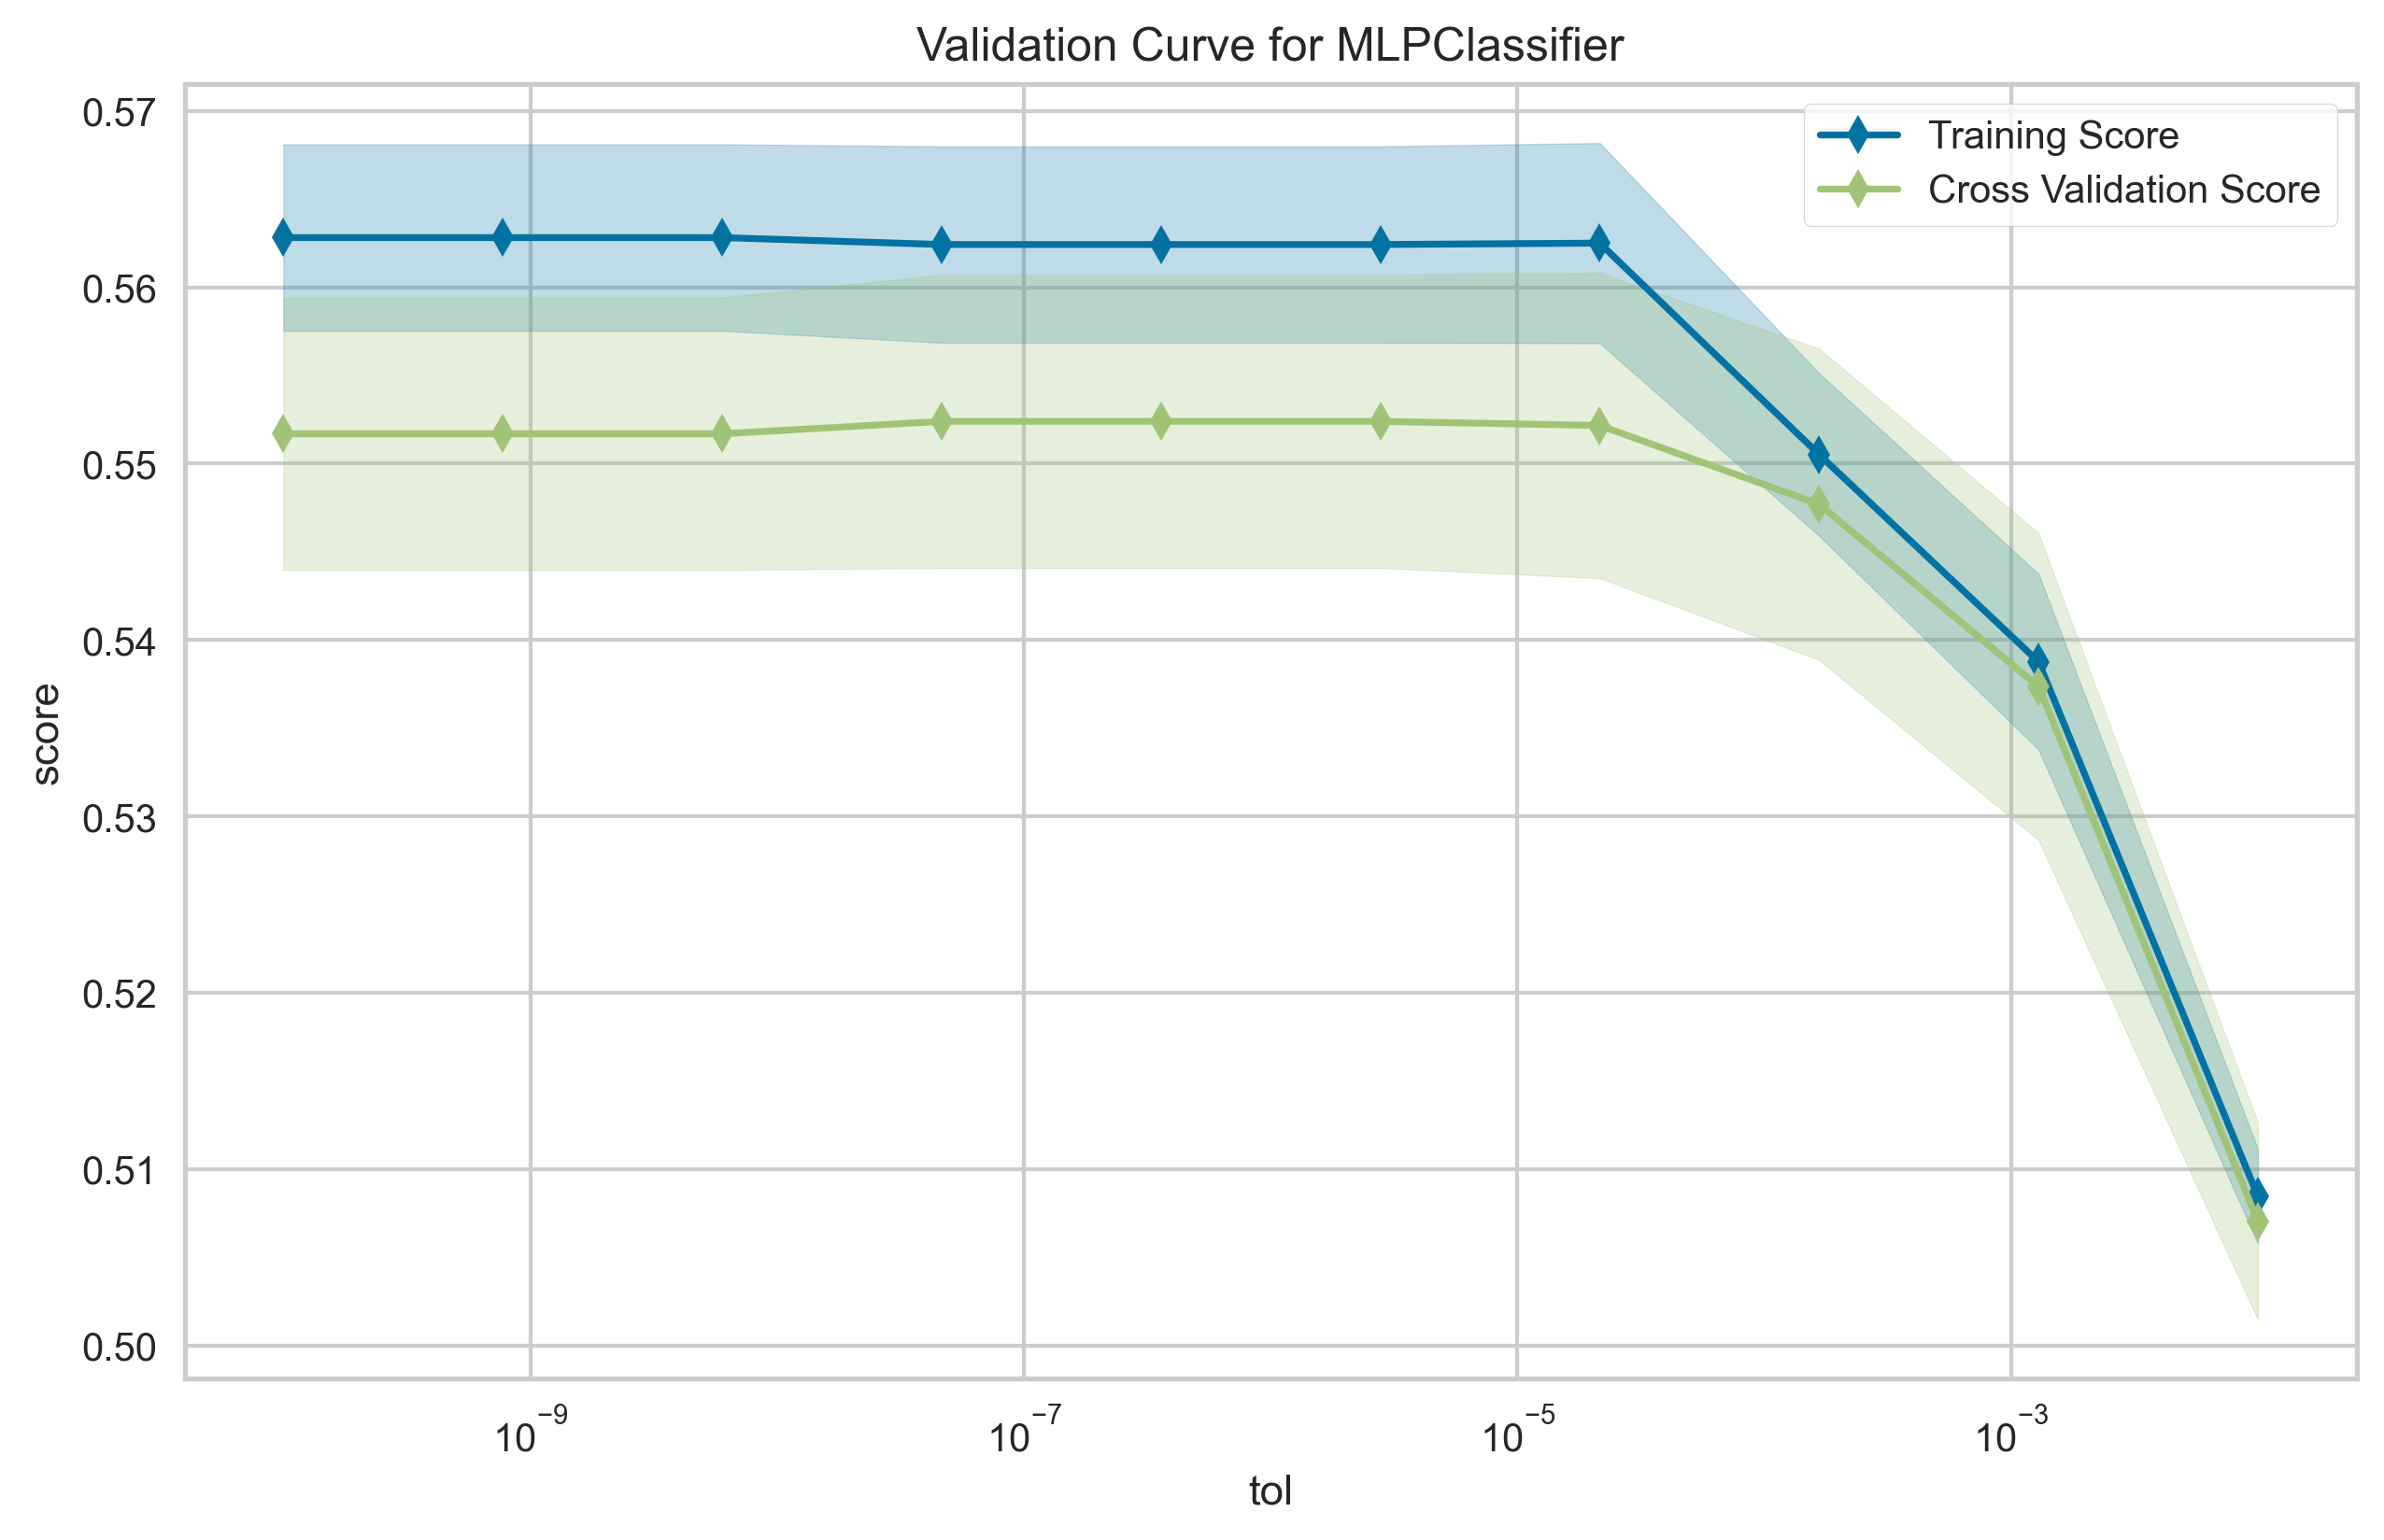

In [84]:
mlp_clf = MLPClassifier(random_state=SEED, hidden_layer_sizes=[NUMBER_OF_FEATURES], max_iter=10000)
viz.validation_curve(
    clf=mlp_clf,
    X_tr=X_train_n,
    y_tr=y_train,
    cv=CV,
    param_name="tol",
    param_range=np.logspace(-10, -2, 10),
    output_path=f"{WINE_MLP_PATH}/mlp_tol.png",
    logx=True,
    scoring=F1_SCORE,
)

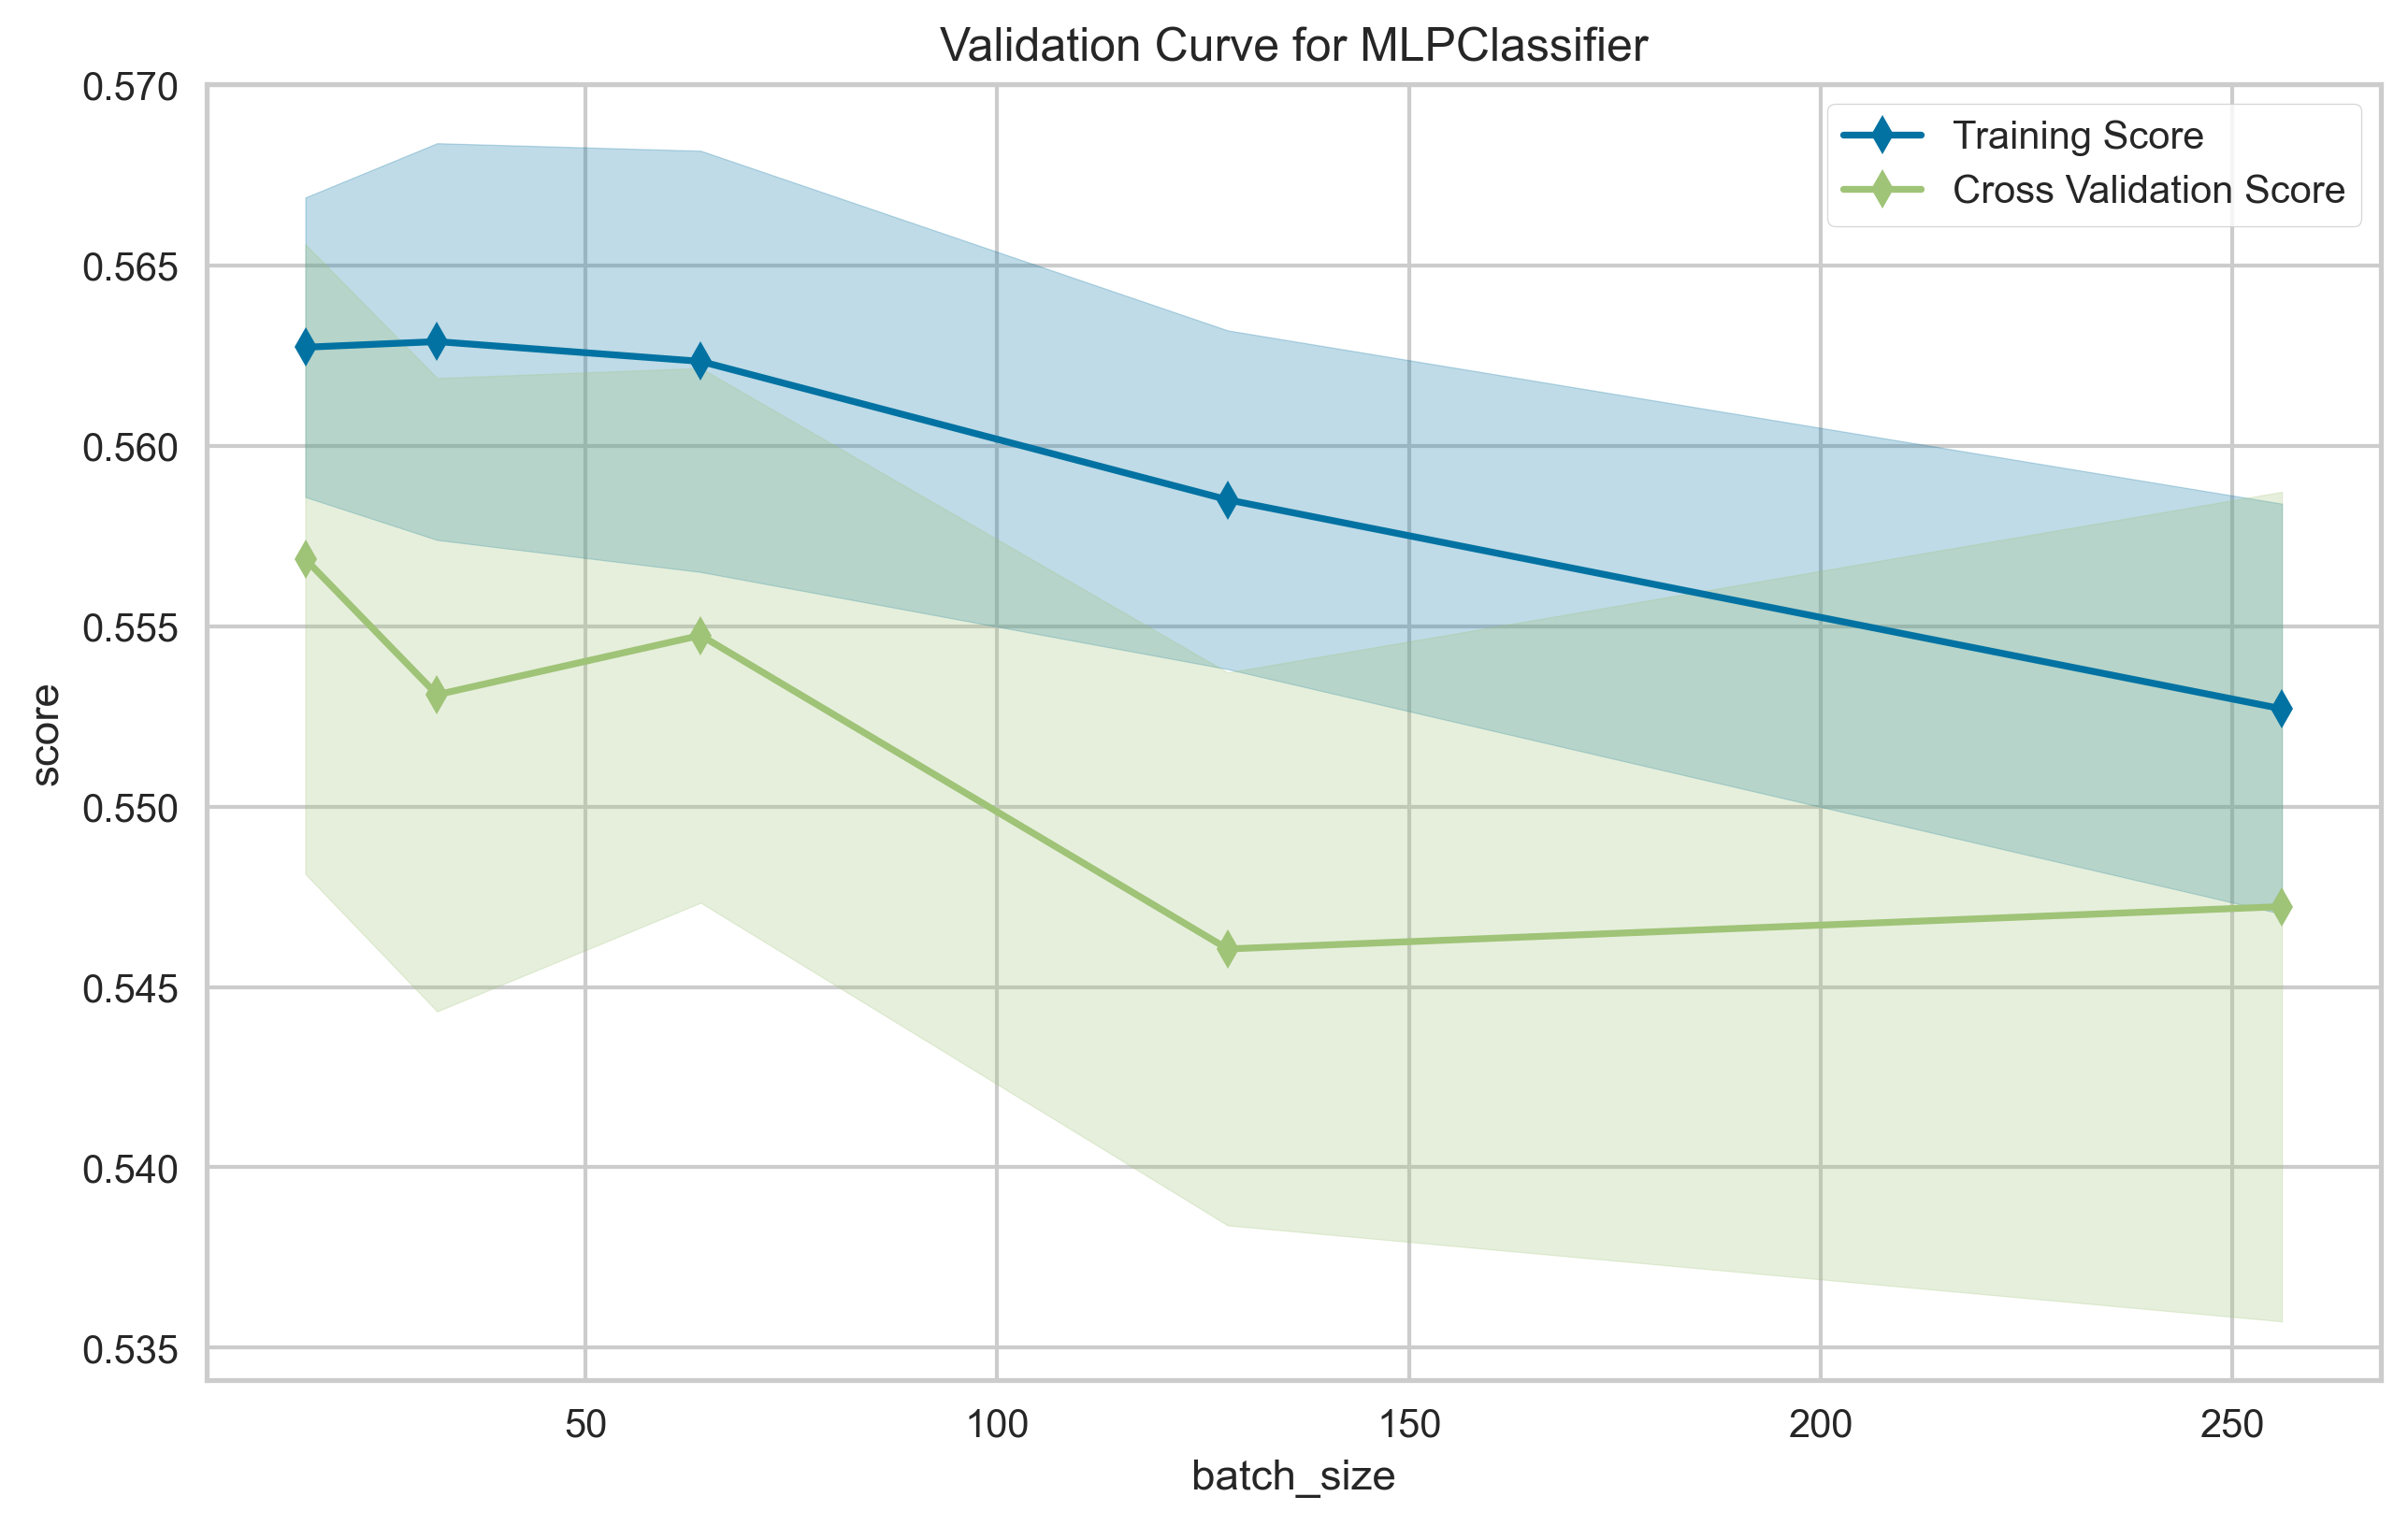

In [85]:
mlp_clf = MLPClassifier(random_state=SEED, hidden_layer_sizes=[NUMBER_OF_FEATURES], max_iter=1000)
viz.validation_curve(
    clf=mlp_clf,
    X_tr=X_train_n,
    y_tr=y_train,
    cv=CV,
    param_name="batch_size",
    param_range=[16, 32, 64, 128, 256],
    output_path=f"{WINE_MLP_PATH}/mlp_batch_size.png",
    scoring=F1_SCORE,
)

In [86]:
best_mlp_params = training.perform_hyperparameter_tuning(
    clf=MLPClassifier(random_state=SEED, hidden_layer_sizes=[100] * 4, max_iter=1000, tol=1e-5, batch_size=64),
    X_tr=X_train_n,
    y_tr=y_train,
    cv=CV,
    param_space={
        "alpha": np.logspace(-5, -3, 3),
        "learning_rate_init": np.logspace(-3, -1, 3)
    },
    n_jobs=-1,
    scoring=F1_SCORE,
)

In [87]:
best_mlp_params

{'alpha': 0.001, 'learning_rate_init': 0.01}

In [88]:
def instantiate_best_mlp_clf(max_iter=1000):
    return MLPClassifier(random_state=SEED, hidden_layer_sizes=[200] * 2, max_iter=max_iter,
                         tol=1e-5, batch_size=64, alpha=best_mlp_params['alpha'],
                         learning_rate_init=best_mlp_params['learning_rate_init'])

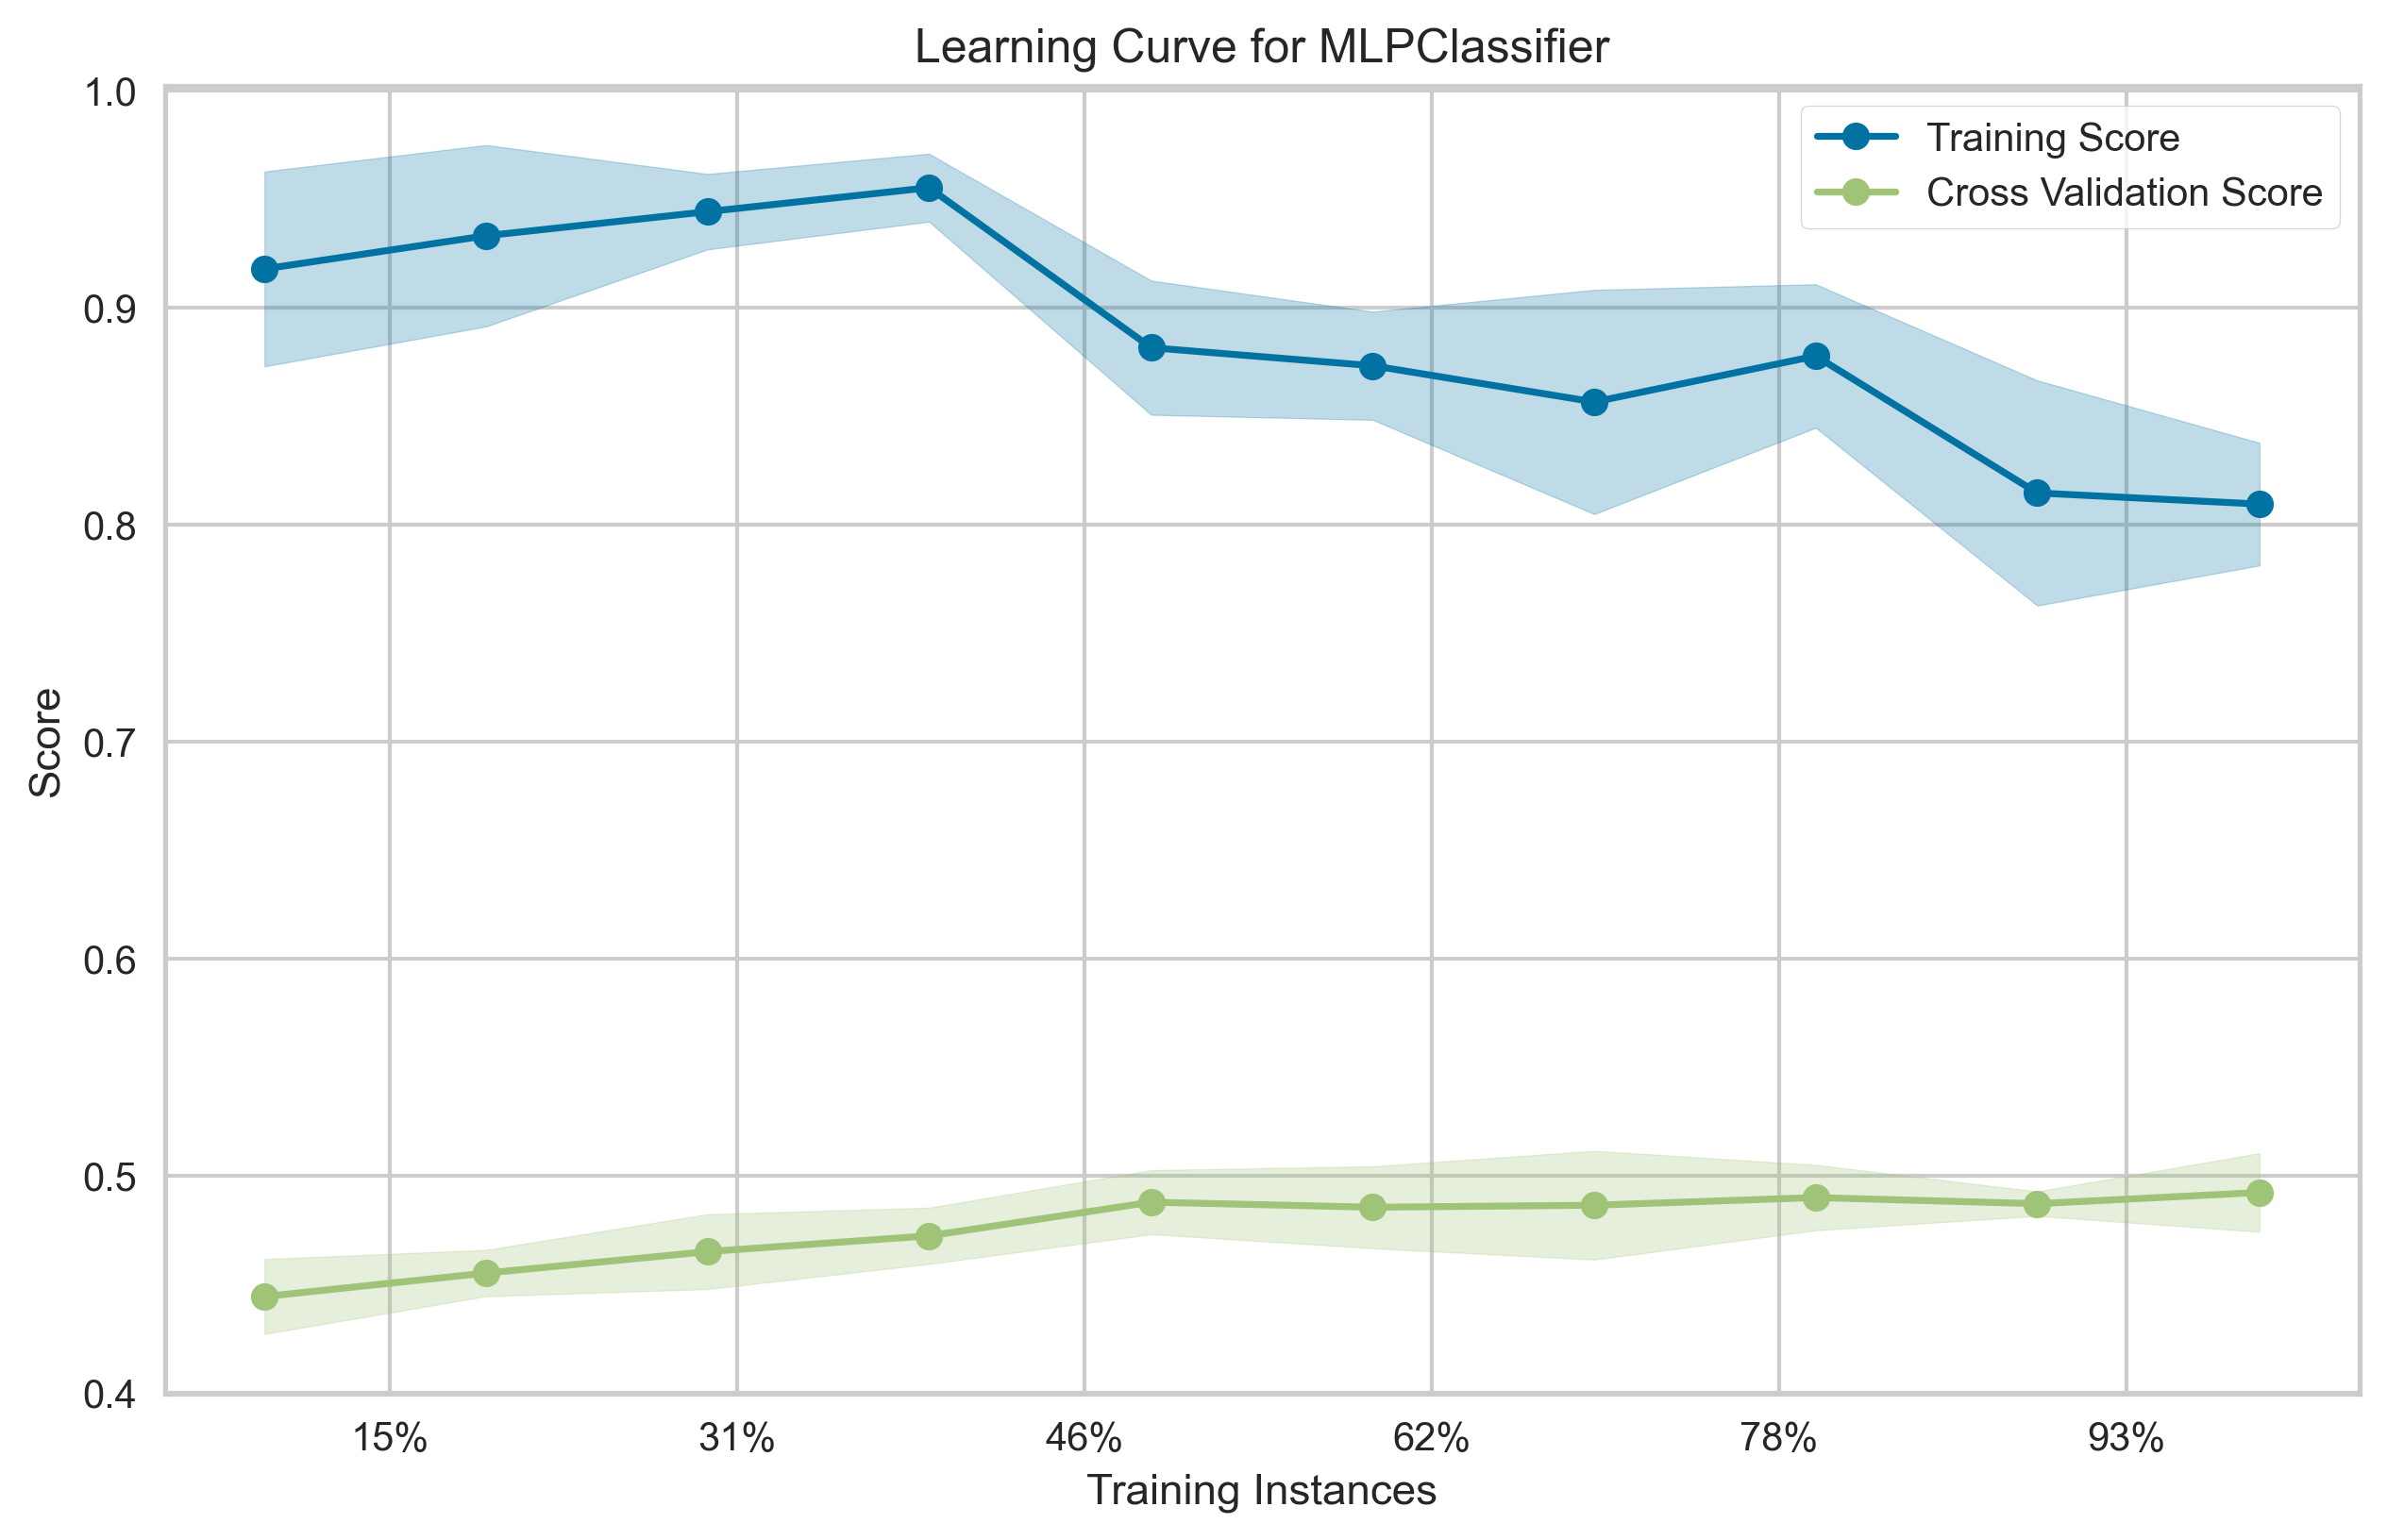

In [89]:
best_mlp_clf = instantiate_best_mlp_clf()
viz.learning_curve(clf=best_mlp_clf,
                   X_tr=X_train_n,
                   y_tr=y_train,
                   cv=CV, output_path=f"{WINE_MLP_PATH}/mlp_learning_curve.png",
                   scoring=F1_SCORE)

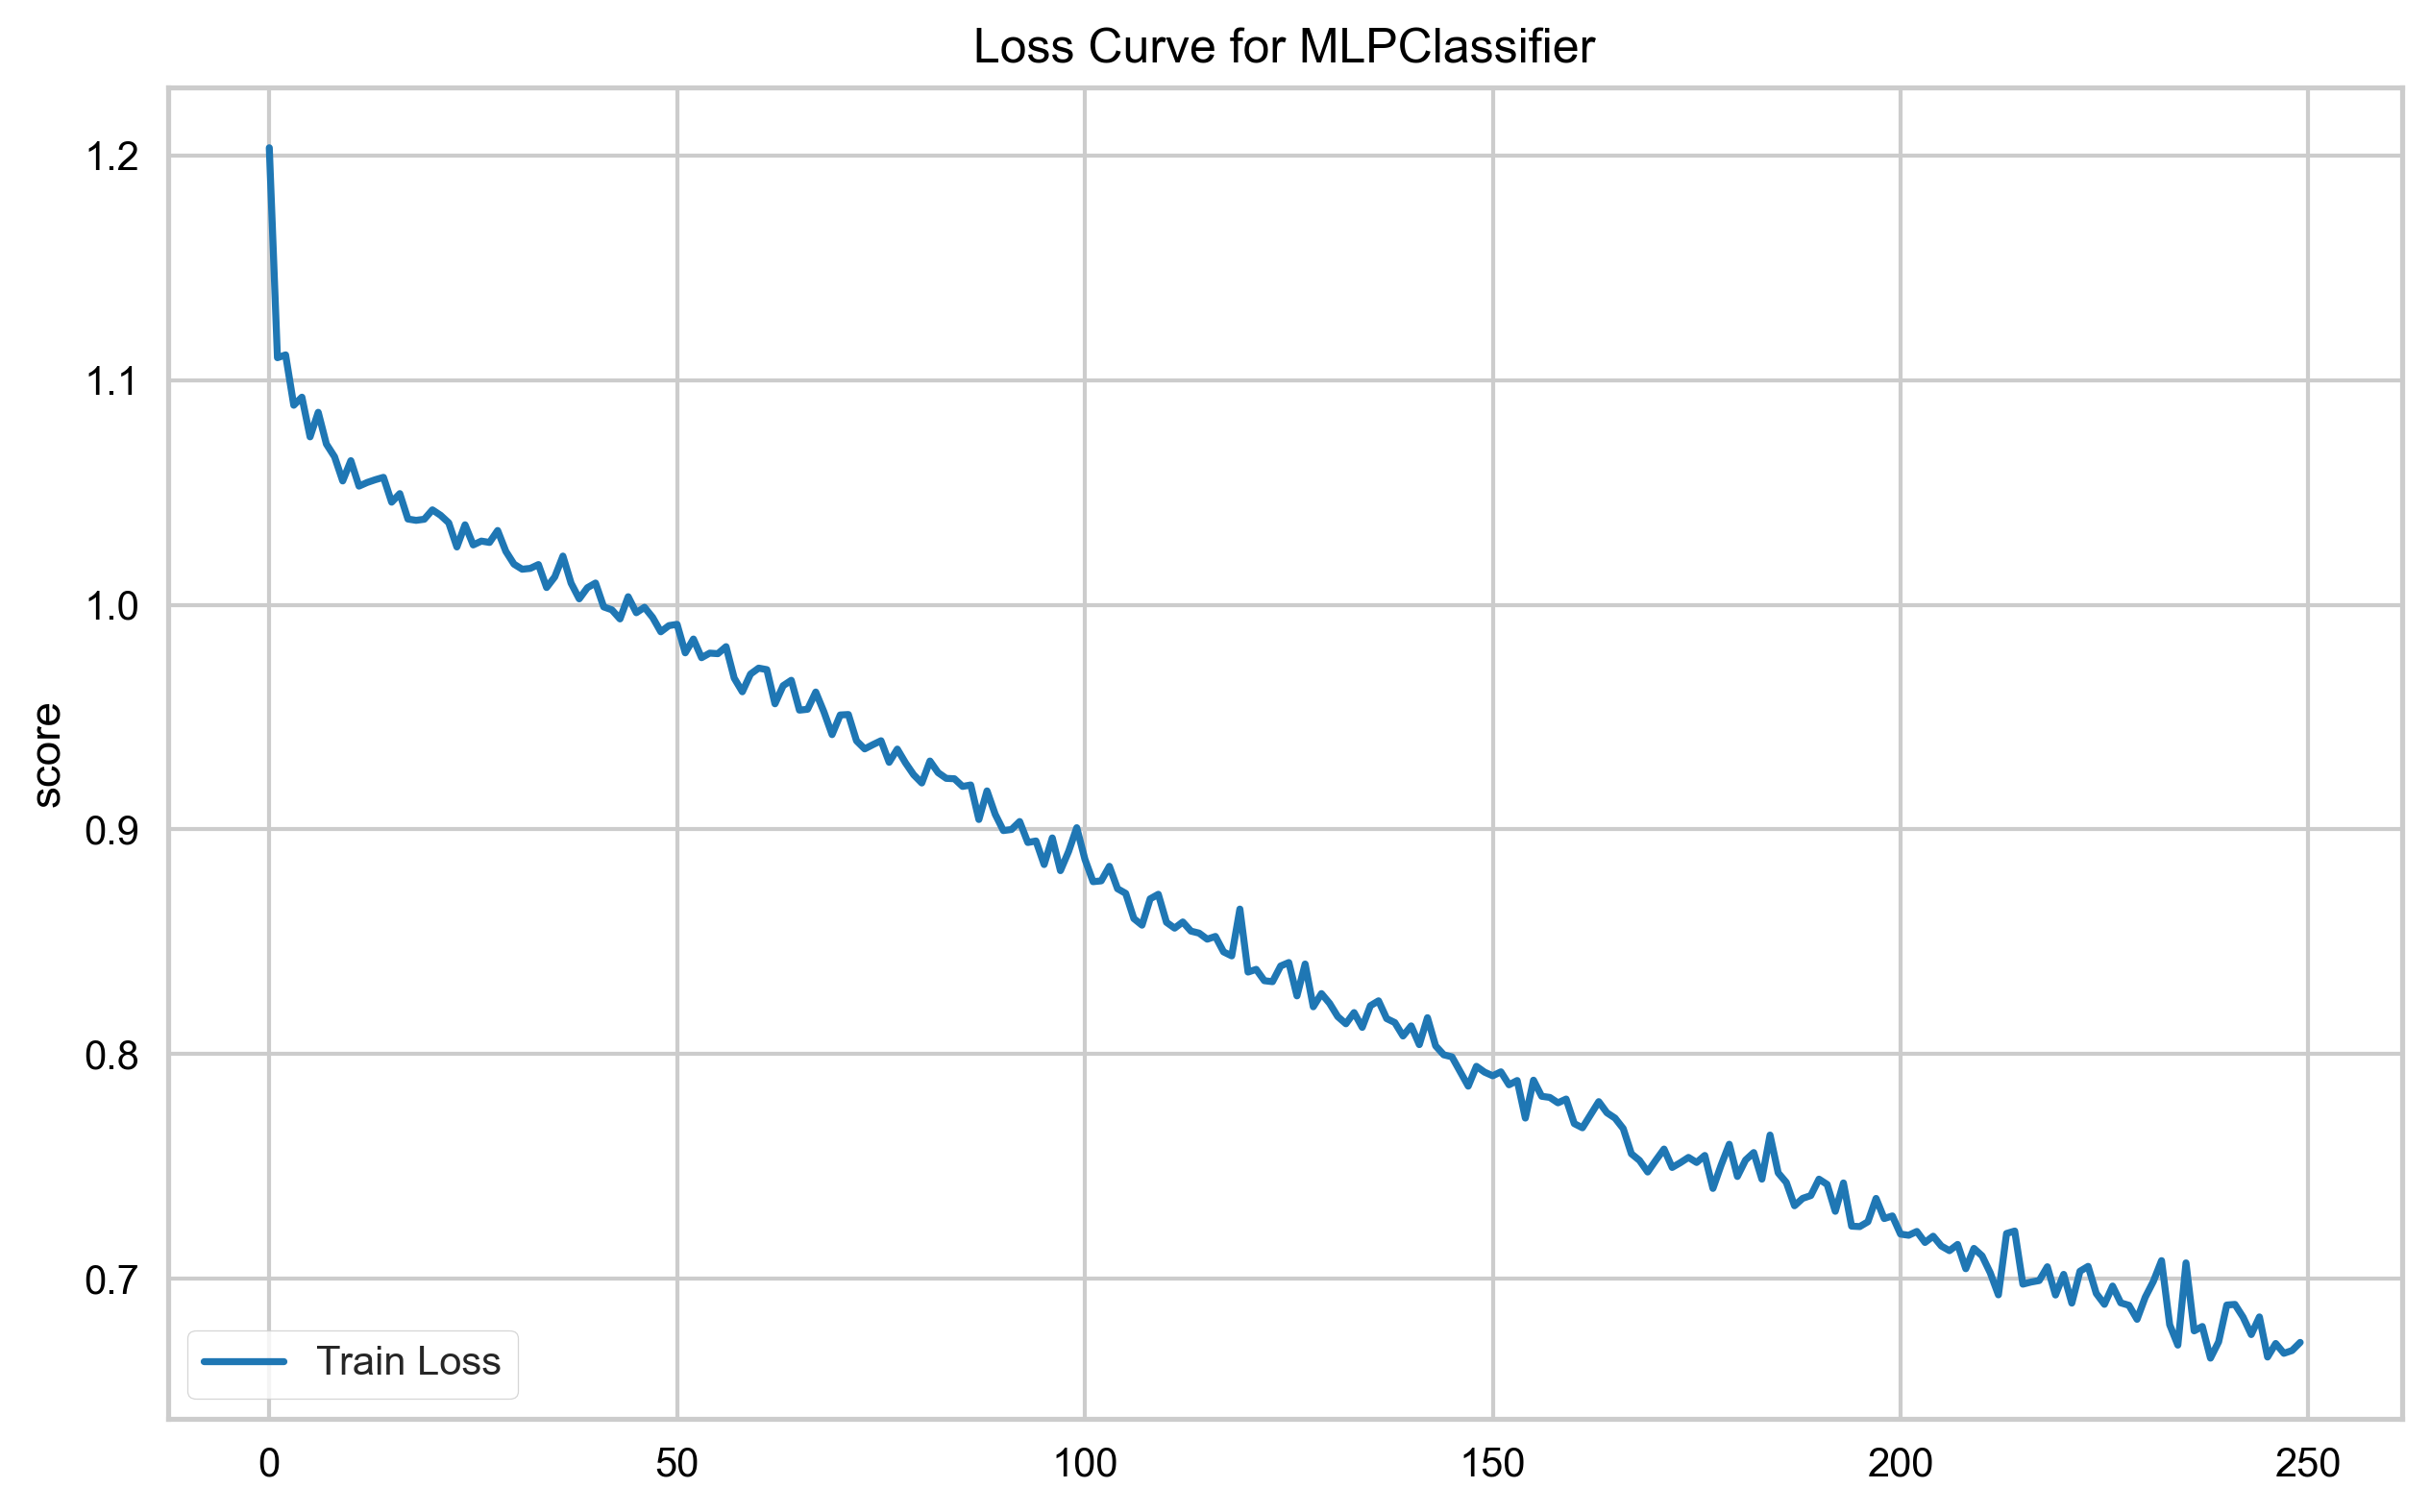

In [90]:
best_mlp_clf = instantiate_best_mlp_clf()
best_mlp_clf.fit(X_train_n, y_train)

viz.loss_curve(best_mlp_clf, output_path=f"{WINE_MLP_PATH}/loss_curves.png")

/Users/pavponn/opt/anaconda3/envs/assignment-1/lib/python3.10/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


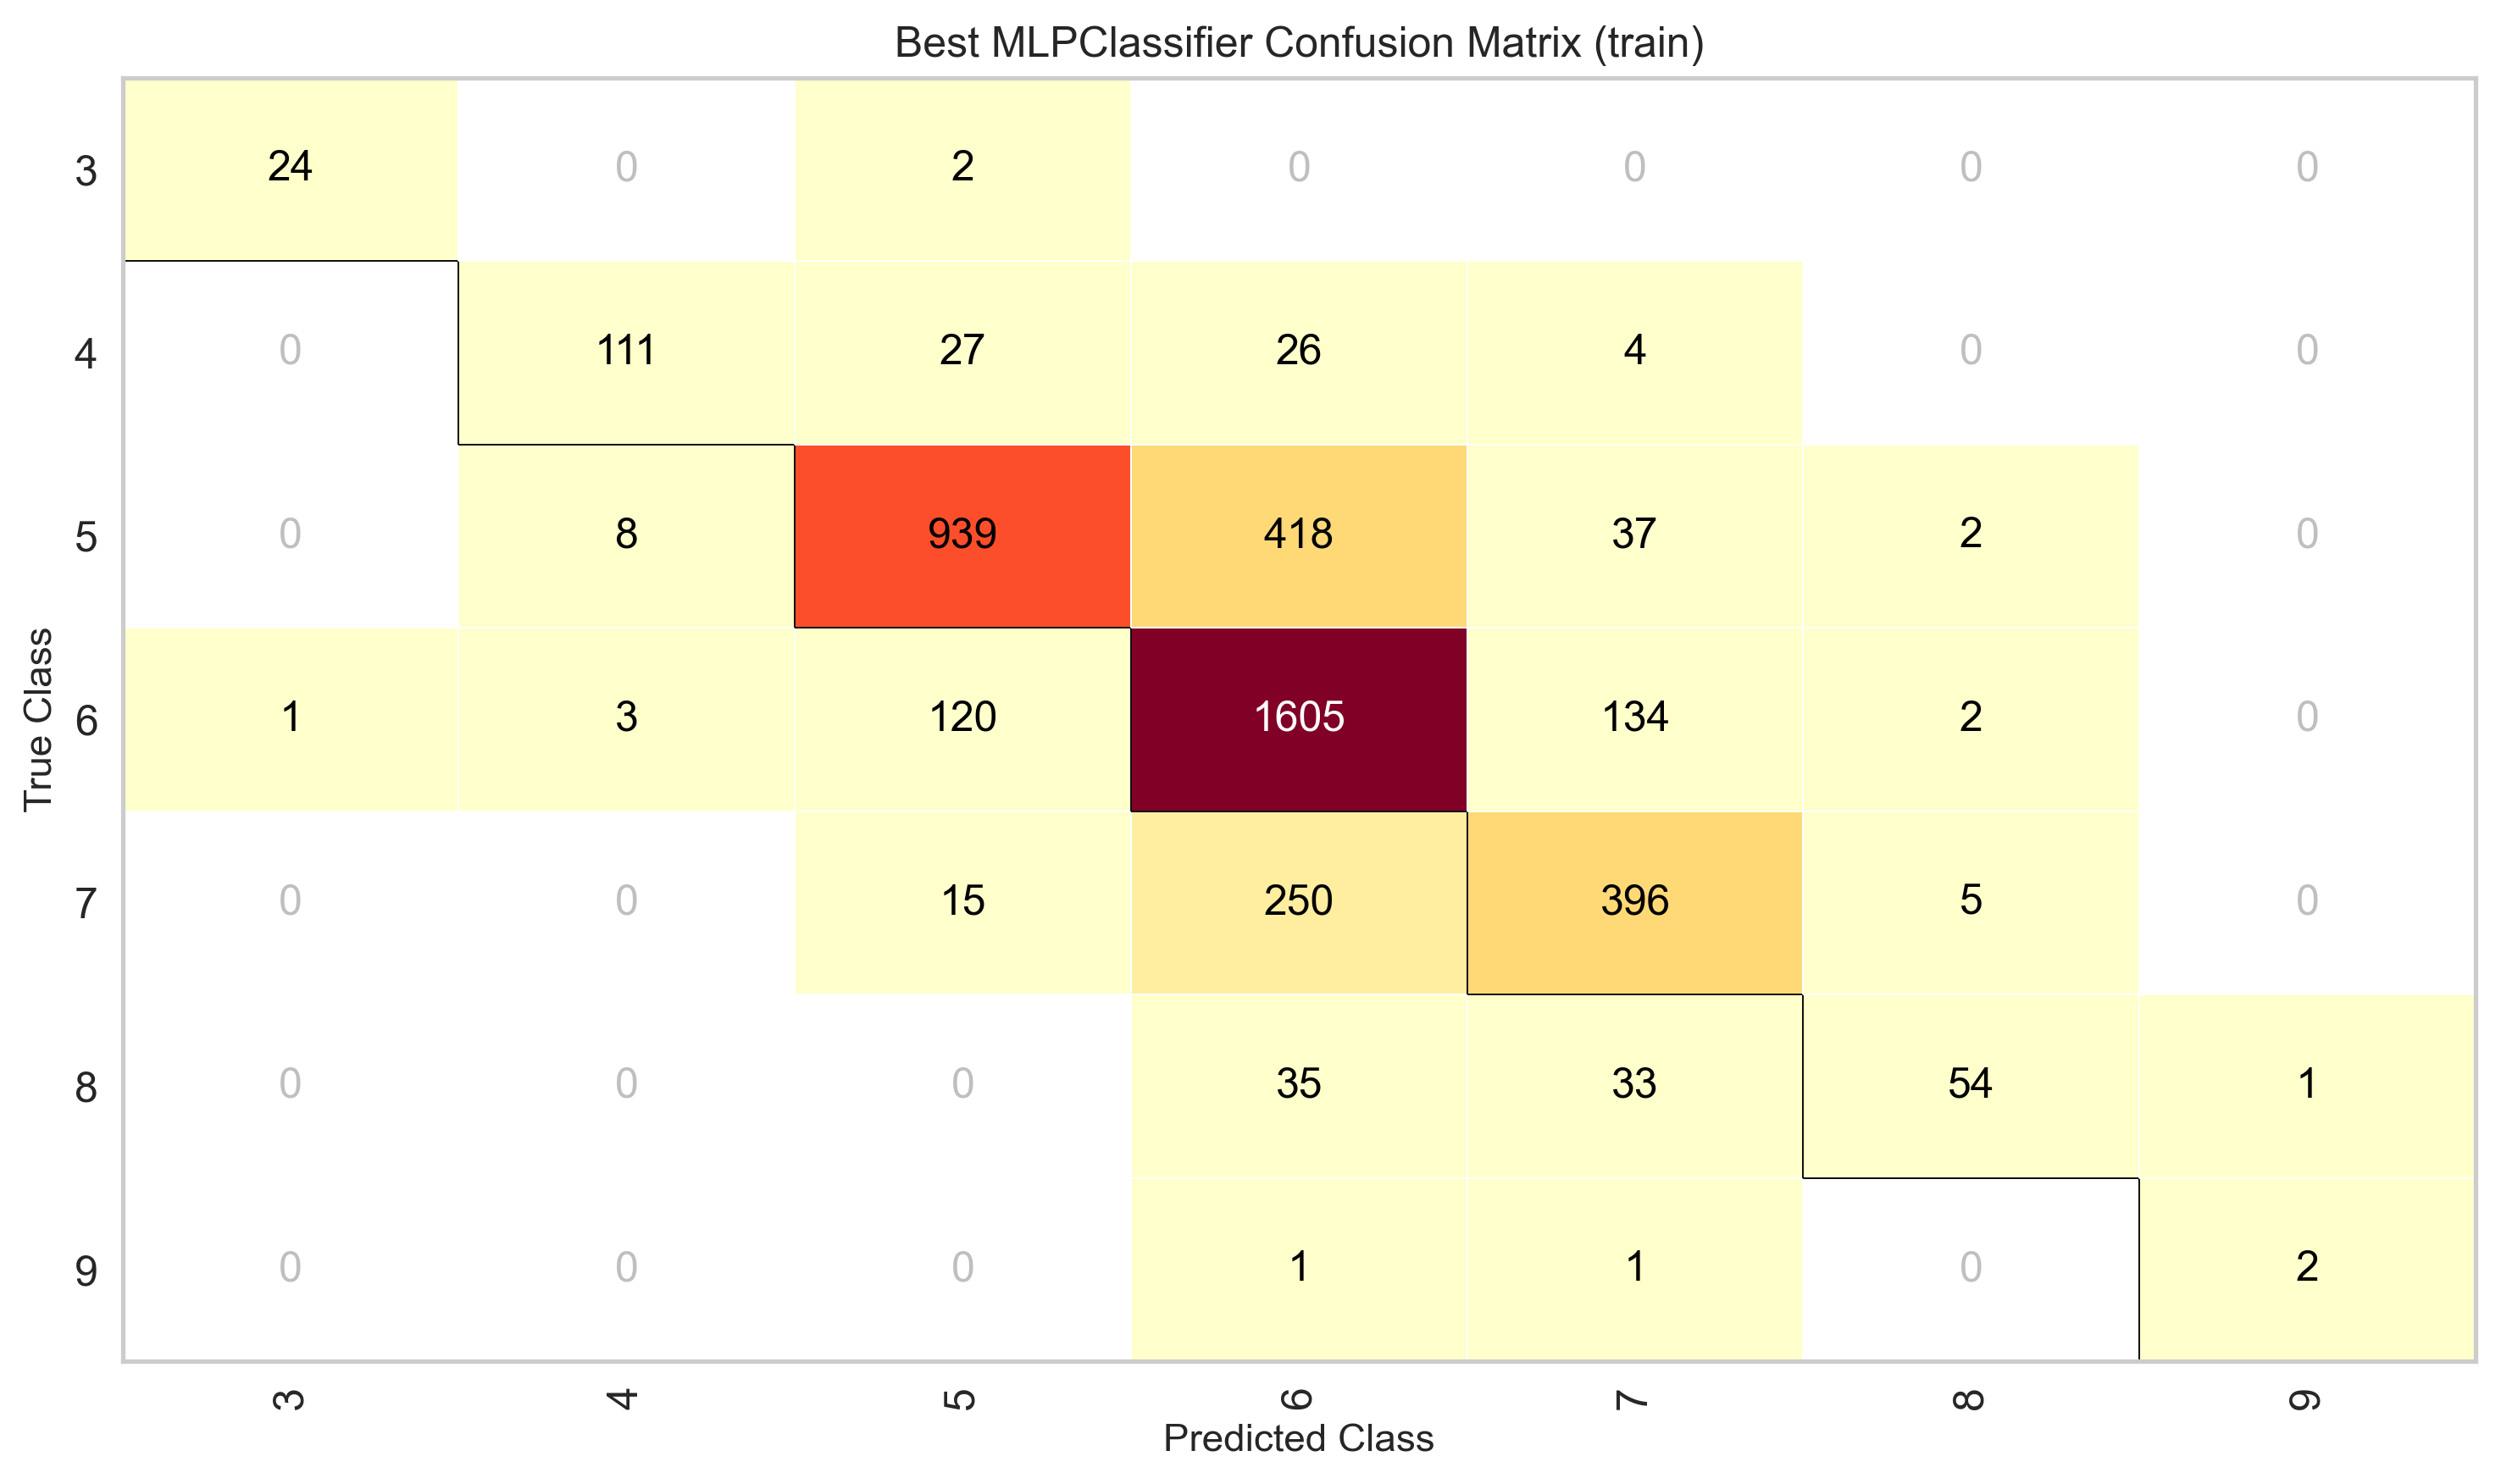

In [91]:
viz.confusion_matrix(
    clf=best_mlp_clf,
    X=X_train_n,
    y=y_train,
    title='Best MLPClassifier Confusion Matrix (train)',
    output_path=f'{WINE_MLP_PATH}/best_mlp_train_confusion_matrix.png'
)


/Users/pavponn/opt/anaconda3/envs/assignment-1/lib/python3.10/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


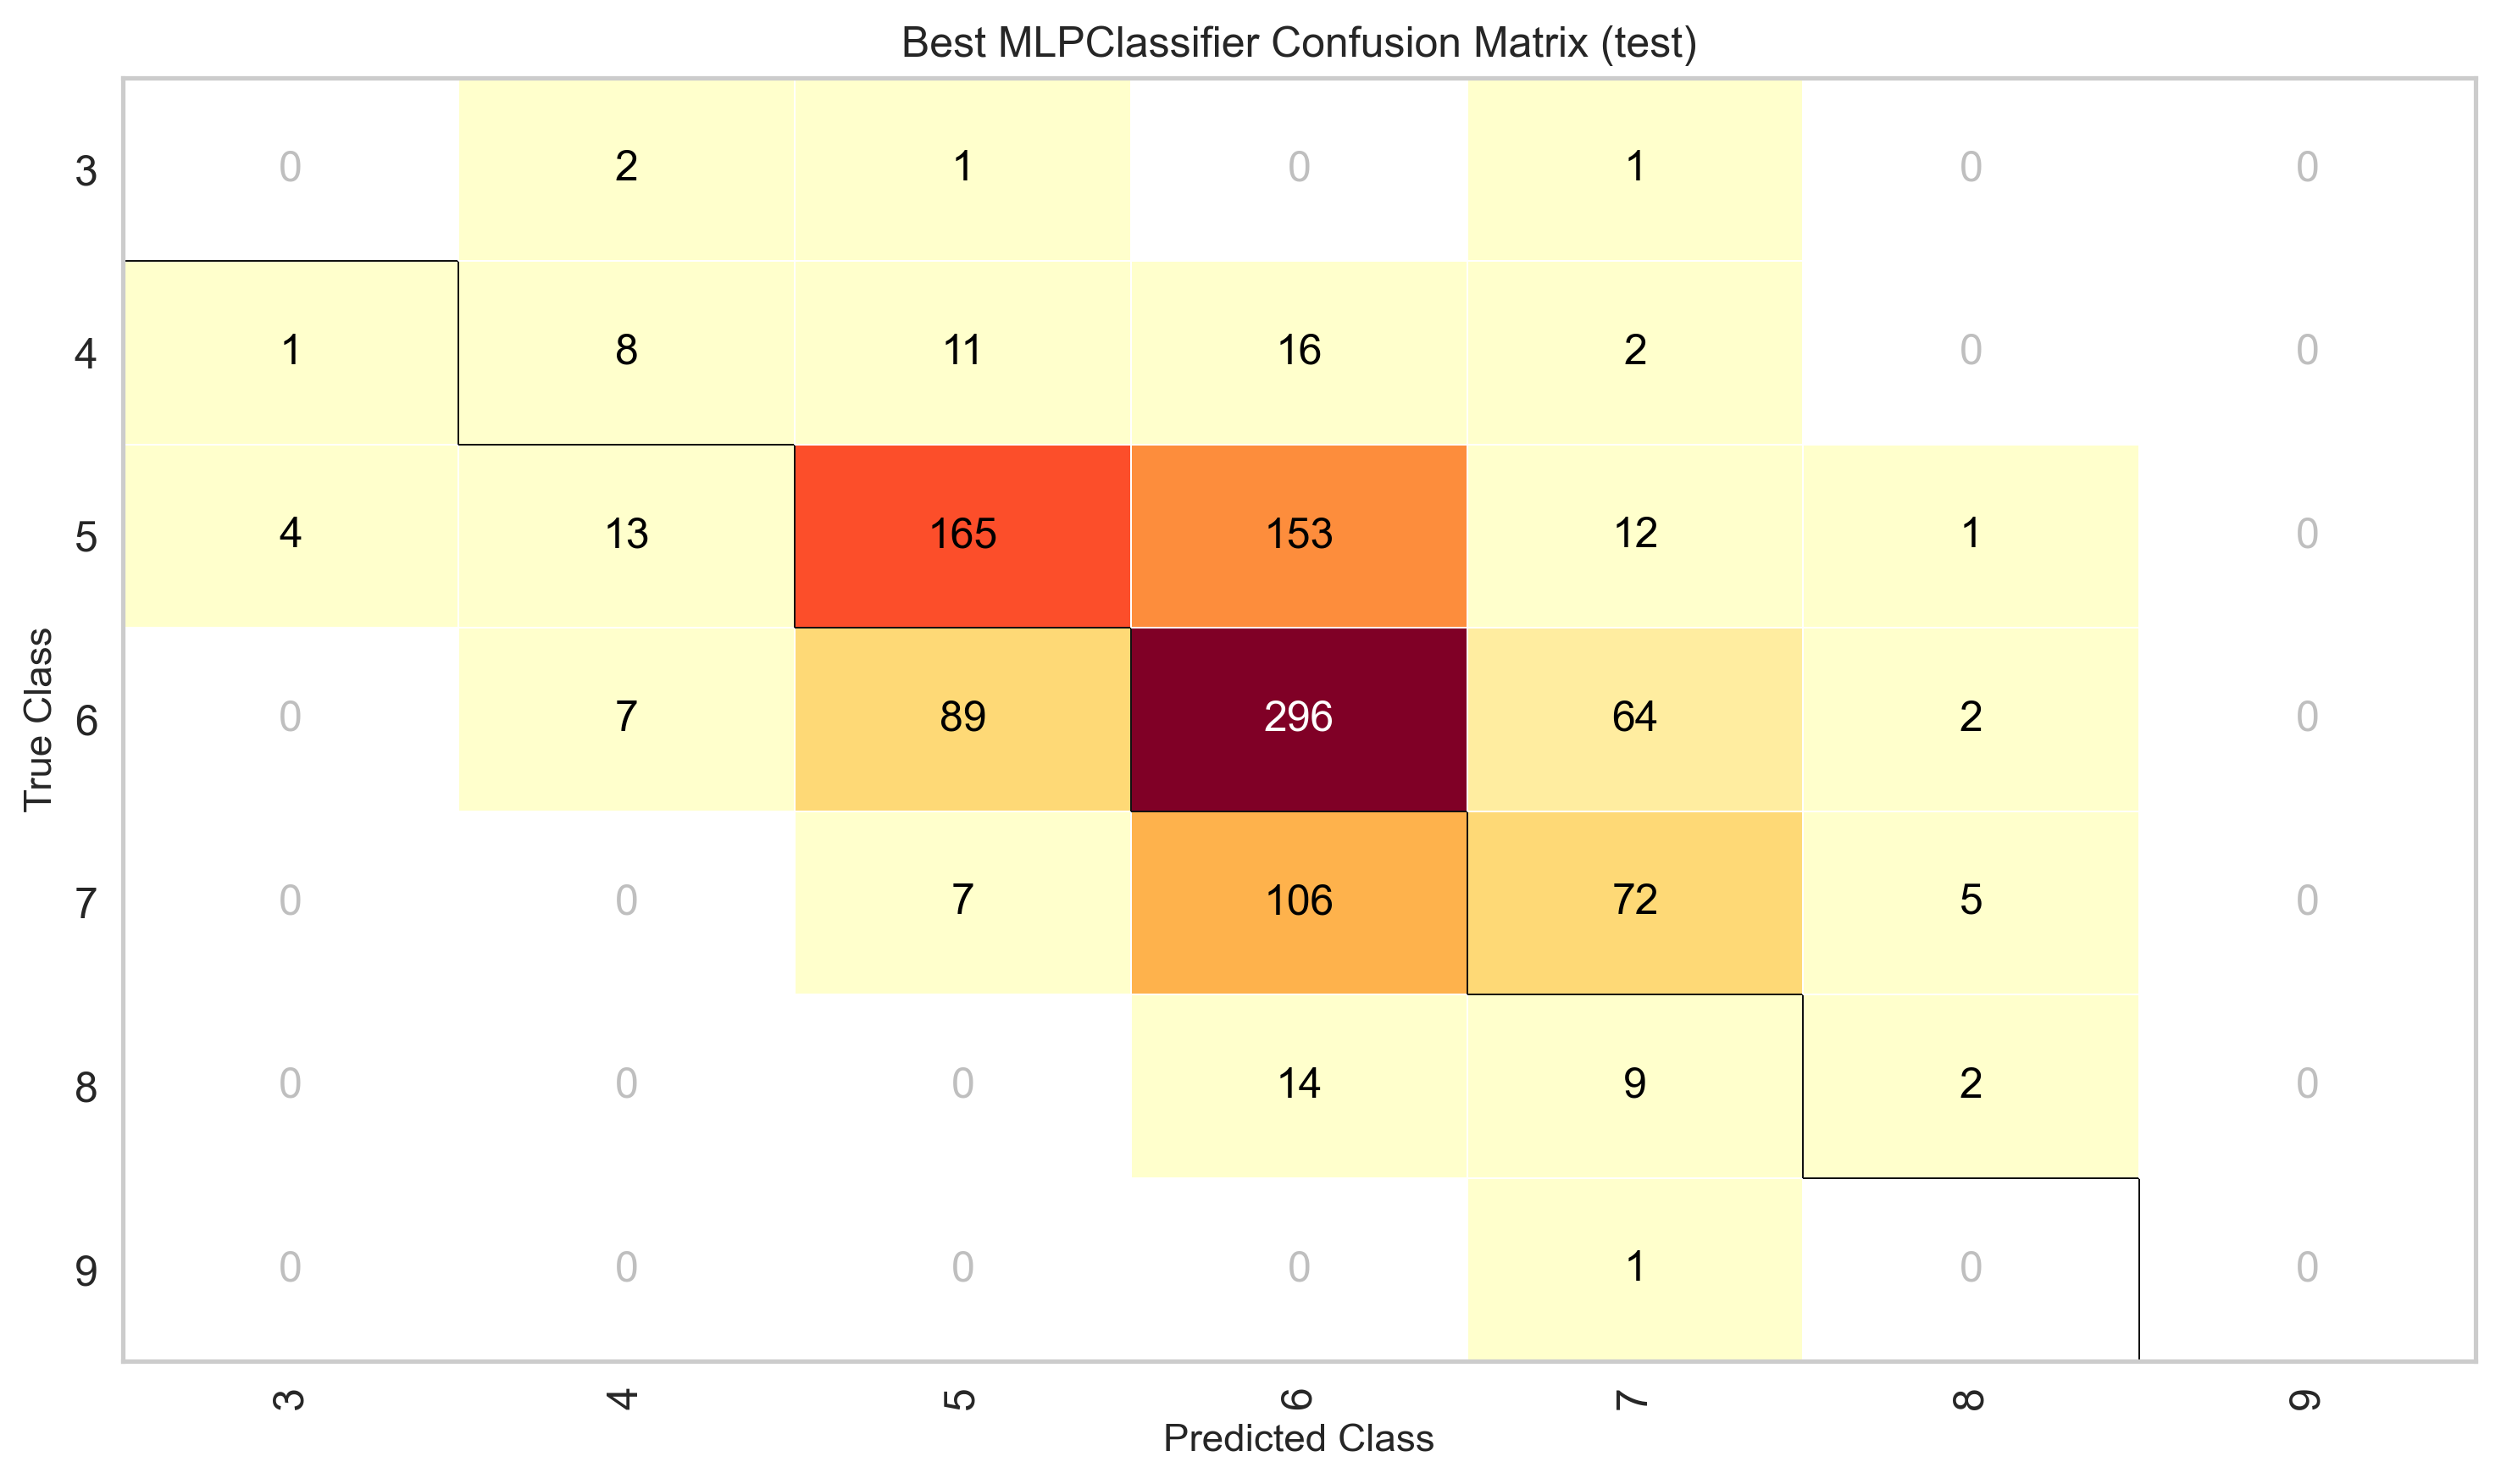

In [92]:
viz.confusion_matrix(
    clf=best_mlp_clf,
    X=X_test_n,
    y=y_test,
    title='Best MLPClassifier Confusion Matrix (test)',
    output_path=f'{WINE_MLP_PATH}/best_mlp_test_confusion_matrix.png'
)


In [93]:
metrics.f1_score_stats(clf=best_mlp_clf, X_tr=X_train_n, X_t=X_test_n, y_tr=y_train, y_t=y_test, averaging=F1_AVERAGING)


F1-Score, micro (train): 0.7357
F1-Score, micro (test) : 0.5103


In [94]:
best_mlp_clf = instantiate_best_mlp_clf()
training.learning_time_stats(best_mlp_clf, X_tr=X_train_n, y_tr=y_train)

Training time, total: 20.6169 seconds
Training time, normalized (per 1000 samples): 4.8442 seconds


In [95]:
training.inference_time_stats(best_mlp_clf, X_train_n, proba=False, dataset_name='train')
training.inference_time_stats(best_mlp_clf, X_test_n, proba=False, dataset_name='test')
training.inference_time_stats(best_mlp_clf, X_all_n, proba=False, dataset_name='all')

Inference time (train), total: 0.0079 seconds
Inference time (train), normalized (per 1000 samples): 0.0018 seconds
Inference time (test), total: 0.0027 seconds
Inference time (test), normalized (per 1000 samples): 0.0025 seconds
Inference time (all), total: 0.0080 seconds
Inference time (all), normalized (per 1000 samples): 0.0015 seconds
